In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

# importing the models
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBRegressor
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve


# addition predifined 'functions' for splitting the data and evaluating the model
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import RandomizedSearchCV

import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', 100)

import xgboost as xgb
xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=42)


from xgboost import XGBClassifier


<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


# Support functions

In [2]:
class match_support_functions():
        
    def categorical_to_numerical_convert(self,df,cat_columns):

        for column in cat_columns:
            one_hot = pd.get_dummies(df[column])
            # Drop column as it is now encoded
            df = df.drop(column,axis = 1)
            # Join the encoded df
            df = df.join(one_hot)

        return df

    def IQR_outlier_treatment(self,df, datacolumn, V1 , V3):
        
        print(datacolumn,V1,V3)

        Q1,Q3 = np.percentile(df[datacolumn] , [V1,V3])
        IQR = Q3 - Q1
        lower_range = Q1 - (1.5 * IQR)
        upper_range = Q3 + (1.5 * IQR)

        #print(f'{datacolumn} minimum range:',lower_range)
        #print(f'{datacolumn} maximum range:',upper_range) 
        df = df[(df[datacolumn] > lower_range) & (df[datacolumn] < upper_range)]
        
        return df
        
    def get_top_correlation(self,df):
        cor = df.corr().abs()
        cor2 = cor.unstack()
        cor3 = cor2.sort_values(kind="quicksort", ascending = False)

        return pd.DataFrame(cor3)

    def evaluate_prediction(self,y_prediction,y_val):
        
        mse = mean_squared_error(y_val, y_prediction)
        rmse = mean_squared_error(y_val, y_prediction, squared=False)
        rx = r2_score(y_val, y_prediction)
        print('model mean squared error:',mse)
        print('model root mean squared error:',rmse)
        print('model R2:',rx)


    def try_models(self,model_type,X_train,y_train,X_val,y_val):
        model = model_type
        model.fit(X_train, y_train)
        print('='*20)
        print(f'{model_type}')
        print(f'accuracy of train set: {model.score(X_train, y_train)}')
        print(f'accuracy of val set: {model.score(X_val, y_val)}')
        y_prediction = model.predict(X_val)
        self.evaluate_prediction(y_prediction,y_val)
        
        return model
    

# Script starts here

In [3]:
df = pd.read_csv("match_data.csv")

In [4]:
df.head()

match_id     season   div  odds_home_team_win  odds_draw  \
0         0  2008-2009  div0                1.73        3.5   
1         1  2008-2009  div0                1.25        5.5   
2         2  2008-2009  div0                1.57        3.8   
3         3  2008-2009  div0                1.17        7.0   
4         4  2008-2009  div0                1.17        7.0   

   odds_away_team_win  home_team_match_nr  home_team_goal_roll1_sum  \
0                5.00                   5                         3   
1               12.00                   7                         0   
2                5.75                   9                         1   
3               15.00                  11                         2   
4               15.00                  14                         2   

   home_team_goal_roll2_sum  home_team_goal_roll3_sum  \
0                         7                         8   
1                         2                         5   
2                         4                         4   
3                         6                         7   
4                         4                         7   

   home_team_goal_roll4_sum  home_team_opponents_goal_roll1_sum  \
0                        10                                   0   
1                         9                                   1   
2                         6                                   0   
3                        10                                   1   
4                         9                                   2   

   home_team_opponents_goal_roll2_sum  home_team_opponents_goal_roll3_sum  \
0                                   1                                   2   
1                                   6                                   6   
2                                   3                                   4   
3                                   3                                   3   
4                                   3                                   4   

   home_team_opponents_goal_roll4_sum  home_team_shot_roll1_sum  \
0                                   4                        11   
1                                   7                        13   
2                                   9                        16   
3                                   6                        15   
4                                   5                        11   

   home_team_shot_roll2_sum  home_team_shot_roll3_sum  \
0                        30                        46   
1                        35                        46   
2                        38                        51   
3                        34                        50   
4                        18                        53   

   home_team_shot_roll4_sum  home_team_opponents_shot_roll1_sum  \
0                        62                                   7   
1                        65                                   9   
2                        73                                   9   
3                        72                                  11   
4                        68                                  11   

   home_team_opponents_shot_roll2_sum  home_team_opponents_shot_roll3_sum  \
0                                  16                                  32   
1                                  19                                  26   
2                                  20                                  29   
3                                  24                                  33   
4                                  21                                  23   

   home_team_opponents_shot_roll4_sum  home_team_shot_on_target_roll1_sum  \
0                                  45                                   4   
1                                  35                                   2   
2                                  39                                   5   
3                                  44                               

# Feature Engineering

In [5]:
df["home_win_expected"] = np.where((df["odds_home_team_win"] < df["odds_draw"]) & 
                                   (df["odds_home_team_win"] < df["odds_away_team_win"]),1,0)

df["home_win_accuracy"] = np.where(df["home_win_flag"] == df["home_win_expected"],1,0)

# df["draw_expected"] = np.where((df["odds_draw"] <= df["odds_home_team_win"]) & 
#                                (df["odds_draw"] <= df["odds_away_team_win"]),1,0)

# df["away_win_expected"] = np.where((df["odds_away_team_win"] < df["odds_draw"]) & 
#                                    (df["odds_away_team_win"] < df["odds_home_team_win"]),1,0)

# df["flag_concat"] = df["home_win_flag"].astype(str) + df["draw_flag"].astype(str) + + df["away_win_flag"].astype(str)
# df["expected_concat"] = df["home_win_expected"].astype(str) + df["draw_expected"].astype(str) + + df["away_win_expected"].astype(str)
# df["expectation_accuracy"] = np.where(df["flag_concat"] == df["expected_concat"],1,0)

In [6]:
# div seasonal accuracy

acc_df = pd.DataFrame(df.groupby(["div"])["home_win_accuracy"].mean())
acc_df = acc_df.reset_index(level=['div'])
acc_df.columns = ["div","div_home_acc"]

df2 = pd.merge(df, acc_df, on=["div"], how = "left")
df2['home_win_prob'] = np.where( 1/df2['odds_home_team_win'] > 1 ,1 ,1/df2['odds_home_team_win'])
df2['draw_prob'] = np.where( 1/df2['odds_draw'] > 1 ,1 ,1/df2['odds_draw'])

In [7]:
# support_functions = match_support_functions()

# df2 = df2[df2['draw_prob']<0.37].reset_index(drop=True)

# df2 = support_functions.IQR_outlier_treatment(df2, "home_team_goal_roll4_sum" , 10 , 90)
# df2 = support_functions.IQR_outlier_treatment(df2, "home_team_opponents_goal_roll4_sum" , 10 , 90)
# df2 = support_functions.IQR_outlier_treatment(df2, "away_team_goal_roll4_sum" , 10 , 90)
# df2 = support_functions.IQR_outlier_treatment(df2, "away_team_opponents_goal_roll4_sum" , 10 , 90)

In [8]:
# #using all features (61%)
# all_cols = data_to_train.columns.tolist()
# all_cols.remove('match_id')
# all_cols.remove('season')
# all_cols.remove('div')
# all_cols.remove('home_win_flag')
# all_cols.remove('draw_flag')
# all_cols.remove('away_win_flag')
# all_cols.remove('home_win_expected')
# all_cols.remove('home_win_accuracy')

# Added metrics

In [16]:
# good 67.42
df2["home_team_roll4_points_diff"] = df2["home_team_point_roll4_sum"]-df2["home_team_expected_point_roll4_sum"]
df2["away_team_roll4_points_diff"] = df2["away_team_point_roll4_sum"]-df2["away_team_expected_point_roll4_sum"]
# good 67.46
df2["home_team_roll1_points_diff"] = df2["home_team_point_roll1_sum"]-df2["home_team_expected_point_roll1_sum"]
df2["away_team_roll1_points_diff"] = df2["home_team_point_roll1_sum"]-df2["home_team_expected_point_roll1_sum"]

In [140]:
df2["home_team_all_points_diff"] = df2["home_team_point_mean"]-df2["home_team_expected_point_mean"]
df2["away_team_all_points_diff"] = df2["away_team_point_mean"]-df2["away_team_expected_point_mean"]

In [307]:
df2["home_s_p1"] = np.where(df2["home_team_match_nr"]<19,1,0)
df2["home_s_p2"] = np.where(df2["home_team_match_nr"]>=19,1,0)

df2["away_s_p1"] = np.where(df2["away_team_match_nr"]<19,1,0)
df2["away_s_p2"] = np.where(df2["away_team_match_nr"]>=19,1,0)

In [308]:
df2

match_id     season    div  odds_home_team_win  odds_draw  \
0             0  2008-2009   div0                1.73       3.50   
1             1  2008-2009   div0                1.25       5.50   
2             2  2008-2009   div0                1.57       3.80   
3             3  2008-2009   div0                1.17       7.00   
4             4  2008-2009   div0                1.17       7.00   
...         ...        ...    ...                 ...        ...   
64161     64395  2021-2022  div18                3.80       3.71   
64162     64396  2021-2022  div18                3.62       3.42   
64163     64397  2021-2022  div18                5.51       4.06   
64164     64398  2021-2022  div18                3.83       3.76   
64165     64399  2021-2022  div18               11.22       6.78   

       odds_away_team_win  home_team_match_nr  home_team_goal_roll1_sum  \
0                    5.00                   5                         3   
1                   12.00                   7                         0   
2                    5.75                   9                         1   
3                   15.00                  11                         2   
4                   15.00                  14                         2   
...                   ...                 ...                       ...   
64161                1.90                  30                         0   
64162                2.04                  32                         0   
64163                1.59                  34                         0   
64164                1.87                  36                         1   
64165                1.22                  38                         0   

       home_team_goal_roll2_sum  home_team_goal_roll3_sum  \
0                             7                         8   
1                             2                         5   
2                             4                         4   
3                             6                         7   
4                             4                         7   
...                         ...                       ...   
64161                         1                         3   
64162                         0                         0   
64163                         0                         0   
64164                         3                         3   
64165                         1                         2   

       home_team_goal_roll4_sum  home_team_opponents_goal_roll1_sum  \
0                            10                                   0   
1                             9                                   1   
2                             6                                   0   
3                            10                                   1   
4                             9                                   2   
...                         ...                                 ...   
64161                         3                                   1   
64162                         1                                   1   
64163                         0                                   2   
64164                         3                                   2   
64165                         4                                   3   

       home_team_opponents_goal_roll2_sum  home_team_opponents_goal_roll3_sum  \
0                                       1                                   2   
1                                       6                                   6   
2                                       3                                   4   
3                                       3                                   3   
4                                       3                                   4   
...                                   ...                                 ...   
64161                                   1                                   6   
64162                                   3              

# sample prepare

In [447]:
### Train

data = df2.copy()

data_y1= data[data['home_win_flag']==1].reset_index(drop=True)
data_y0= data[data['home_win_flag']==0].reset_index(drop=True)

#selectiong train features(X_train) and train targets(y_train)
# train_feature = ['div_season_home_acc','home_win_prob',
#                  'home_team_match_nr','home_team_goal_roll4_sum','home_team_opponents_goal_roll4_sum',
#                  'home_team_point_roll4_sum','home_team_expected_point_roll4_sum',
#                  'home_team_goal_roll1_sum','home_team_opponents_goal_roll1_sum',
#                  'home_team_point_roll1_sum','home_team_expected_point_roll1_sum',
#                  'away_team_match_nr','away_team_goal_roll4_sum','away_team_opponents_goal_roll4_sum',
#                  'away_team_point_roll4_sum','away_team_expected_point_roll4_sum',
#                  'away_team_goal_roll1_sum','away_team_opponents_goal_roll1_sum',
#                  'away_team_point_roll1_sum','away_team_expected_point_roll1_sum']


# train_feature = ['home_win_prob',
#                  'home_team_opponents_goal_roll4_sum',
#                  'home_team_point_roll4_sum','home_team_expected_point_roll4_sum',
#                  'away_team_goal_roll4_sum','away_team_opponents_goal_roll4_sum',
#                  'away_team_point_roll4_sum','away_team_expected_point_roll4_sum',
#                  'home_team_roll4_points_diff','away_team_roll4_points_diff',
#                  'home_team_roll1_points_diff','away_team_roll1_points_diff',
#                  'home_s_p1','home_s_p2',
#                  'away_s_p1','away_s_p2']

train_target = 'home_win_flag'

### Train
data_to_train = pd.concat([data_y1[0:20000],data_y0[0:20000]], ignore_index=True)
X_train = data_to_train[train_feature].values
y_train = data_to_train[train_target].values

### Test
data_to_test = pd.concat([data_y1[20000:28000],data_y0[20000:28000]], ignore_index=True)
X_test = data_to_test[train_feature].values
y_test = data_to_test[train_target].values

In [448]:
# #creating a copy of the prepared dataset
# df_basemodel_dataset = df.copy()

# # no weekend and annual time data
# #selectiong train features(X_train) and train targets(y_train)
# train_feature = ['odds_home_team_win', 'odds_draw',
#                  'odds_away_team_win', 'home_team_match_nr', 'home_team_goal_roll1_sum',
#                  'home_team_goal_roll2_sum', 'home_team_goal_roll3_sum','home_team_goal_roll4_sum',
#                  'home_team_opponents_goal_roll1_sum','home_team_opponents_goal_roll2_sum',
#                  'home_team_opponents_goal_roll3_sum','home_team_opponents_goal_roll4_sum']

# train_target = 'home_win_flag'

# #separating X_train and y_train datasets
# train_df = df_basemodel_dataset[train_feature]
# target_df = df_basemodel_dataset[train_target]

# #splitting the dataframes into train and val datasets
# X_train, X_val, y_train, y_val = train_test_split(train_df, target_df, test_size=0.2, random_state=0)

In [449]:
support_functions = match_support_functions()

# Raw correlation

In [422]:
corr_table = support_functions.get_top_correlation(pd.DataFrame(X_train))

In [423]:
# get highest correlation
corr_table[corr_table.index.get_level_values(1) == 'odds_home_team_win'][:10]

Empty DataFrame
Columns: [0]
Index: []

# Models

In [56]:
from sklearn.ensemble import RandomForestClassifier


models = [LinearRegression(),
          GaussianNB(),BernoulliNB(),
          RandomForestRegressor(),
          RandomForestClassifier(),
          XGBClassifier()]

print('start model trials')
for modelx in models:
    support_functions.try_models(modelx,X_train,y_train,X_test,y_test)

start model trials
LinearRegression()
accuracy of train set: 0.09796615319705637
accuracy of val set: 0.0960036081613509
model mean squared error: 0.22599909795966228
model root mean squared error: 0.4753936242311862
model R2: 0.0960036081613509
GaussianNB()
accuracy of train set: 0.610925
accuracy of val set: 0.6125
model mean squared error: 0.3875
model root mean squared error: 0.6224949798994366
model R2: -0.55
BernoulliNB()
accuracy of train set: 0.560275
accuracy of val set: 0.5684375
model mean squared error: 0.4315625
model root mean squared error: 0.6569341671735457
model R2: -0.7262500000000001
RandomForestRegressor()
accuracy of train set: 0.87275181
accuracy of val set: -0.15807602500000018
model mean squared error: 0.28951900625000004
model root mean squared error: 0.5380697038953225
model R2: -0.15807602500000018
RandomForestClassifier()
accuracy of train set: 1.0
accuracy of val set: 0.5845
model mean squared error: 0.4155
model root mean squared error: 0.6445928947793328

### choose model

In [57]:
# gaussian purely on odds

In [450]:
model = support_functions.try_models(GaussianNB(),X_train,y_train,X_test,y_test)

GaussianNB()
accuracy of train set: 0.6066
accuracy of val set: 0.627125
model mean squared error: 0.372875
model root mean squared error: 0.6106349154773252
model R2: -0.49150000000000005


In [451]:
model = support_functions.try_models(GaussianNB(),X_train,y_train,X_test,y_test)
y_prediction = model.predict_proba(X_test)[:,1]
data_to_test["pred"] = y_prediction
auc = roc_auc_score(data_to_test['home_win_flag'],data_to_test['pred'] )
print("auc:",auc)

GaussianNB()
accuracy of train set: 0.6066
accuracy of val set: 0.627125
model mean squared error: 0.372875
model root mean squared error: 0.6106349154773252
model R2: -0.49150000000000005
auc: 0.69676496875


In [452]:
from sklearn.inspection import permutation_importance

imps = permutation_importance(model, X_test, y_test)
asd = pd.DataFrame(imps.importances_mean,data_to_test[train_feature].columns, columns = ['a'])
asd.sort_values(by=['a'], ascending=False)

a
odds_draw                                     0.006288
draw_prob                                     0.005013
odds_home_team_win                            0.004938
odds_away_team_defeat_roll3_mean              0.002563
home_win_prob                                 0.002513
...                                                ...
home_team_opponents_goal_roll4_sum           -0.001300
home_team_opponents_shot_on_target_roll4_sum -0.001362
home_team_opponents_shot_on_target_roll3_sum -0.001437
home_team_opponents_goal_roll1_sum           -0.001475
home_team_opponents_goal_roll3_sum           -0.001912

[85 rows x 1 columns]

In [453]:
data_to_test["pred"] = y_prediction

In [454]:
sum(data_to_test["home_win_flag"] == (data_to_test["pred"] > 0.5).astype(int)) / len(data_to_test)

0.627125

In [455]:
data_to_test.head()

match_id     season   div  odds_home_team_win  odds_draw  \
0     45001  2018-2019  div9                1.50       4.33   
1     45002  2018-2019  div9                1.66       4.00   
2     45003  2018-2019  div9                1.33       5.25   
3     45005  2018-2019  div9                1.85       3.40   
4     45010  2018-2019  div9                1.85       3.75   

   odds_away_team_win  home_team_match_nr  home_team_goal_roll1_sum  \
0                6.50                  30                         0   
1                5.00                  32                         2   
2                9.00                  34                         0   
3                4.33                  38                         1   
4                4.20                  13                         3   

   home_team_goal_roll2_sum  home_team_goal_roll3_sum  \
0                         1                         6   
1                         4                         4   
2                         3                         5   
3                         1                         1   
4                         3                         3   

   home_team_goal_roll4_sum  home_team_opponents_goal_roll1_sum  \
0                         7                                   1   
1                         5                                   0   
2                         7                                   3   
3                         6                                   1   
4                         3                                   1   

   home_team_opponents_goal_roll2_sum  home_team_opponents_goal_roll3_sum  \
0                                   1                                   3   
1                                   0                                   1   
2                                   5                                   5   
3                                   4                                   5   
4                                   1                                   3   

   home_team_opponents_goal_roll4_sum  home_team_shot_roll1_sum  \
0                                   5                        17   
1                                   1                        16   
2                                   5                        12   
3                                   5                        11   
4                                   3                        15   

   home_team_shot_roll2_sum  home_team_shot_roll3_sum  \
0                        29                        51   
1                        34                        51   
2                        23                        39   
3                        18                        25   
4                        25                        32   

   home_team_shot_roll4_sum  home_team_opponents_shot_roll1_sum  \
0                        63                                   4   
1                        63                                  10   
2                        57                                  10   
3                        45                                  11   
4                        46                                  17   

   home_team_opponents_shot_roll2_sum  home_team_opponents_shot_roll3_sum  \
0                                  17                                  26   
1                                  15                                  19   
2                                  22                                  32   
3                                  20                                  35   
4                                  25                                  39   

   home_team_opponents_shot_roll4_sum  home_team_shot_on_target_roll1_sum  \
0                                  33                                   5   
1                                  32                                   4   
2                                  37                                   2   
3                                  47                               

In [456]:
sum(data_to_test["home_win_flag"] == (data_to_test["home_win_prob"] > 0.5).astype(int)) / len(data_to_test)

0.620125

Text(113.9222222222222, 0.5, 'Actual')

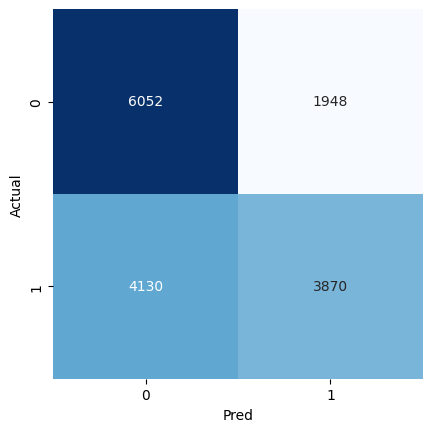

In [457]:
mat = confusion_matrix(data_to_test["home_win_flag"],
                       (data_to_test["home_win_prob"] > 0.5).astype(int))
labels = ['0', '1']
 
sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False, cmap='Blues',
            xticklabels=labels, yticklabels=labels)

plt.xlabel('Pred')
plt.ylabel('Actual')

Text(113.9222222222222, 0.5, 'woODDs')

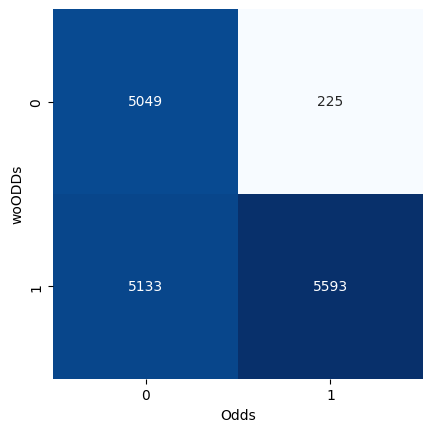

In [458]:
mat = confusion_matrix((data_to_test["pred"] > 0.5).astype(int),
                       (data_to_test["home_win_prob"] > 0.5).astype(int))
labels = ['0', '1']
 
sns.heatmap(mat, square=True, annot=True, fmt='d', cbar=False, cmap='Blues',
            xticklabels=labels, yticklabels=labels)

plt.xlabel('Odds')
plt.ylabel('woODDs')

In [459]:
maxi = 0
maxi_list = []

for i in range(0,99):
    
    for x in range(0,99):

        data_to_test["pred_w_odds"] =  np.where((data_to_test["home_win_prob"] > i/100) &
                                                (data_to_test["pred"] >= x/100),
                                                (data_to_test["home_win_prob"] + data_to_test["pred"])/2,
                                                np.where((data_to_test["home_win_prob"] > i/100) &
                                                         (data_to_test["pred"] < x/100),
                                                          data_to_test["home_win_prob"],
                                                          data_to_test["pred"]
                                                ))
    
        auc = roc_auc_score(data_to_test['home_win_flag'],data_to_test['pred_w_odds'] )
        auc
        
        if auc > maxi:
            maxi = auc
            maxi_list = []
            maxi_list.append(i)
            maxi_list.append(x)
            maxi_list.append(auc)

In [460]:
maxi

0.6967510625000001

In [461]:
maxi_list

[98, 0, 0.6967510625000001]

In [462]:
i = 98
x = 0

data_to_test["pred_w_odds"] =  np.where((data_to_test["home_win_prob"] > i/100) &
                                        (data_to_test["pred"] >= x/100),
                                        (data_to_test["home_win_prob"] + data_to_test["pred"])/2,
                                        np.where((data_to_test["home_win_prob"] > i/100) &
                                                 (data_to_test["pred"] < x/100),
                                                  data_to_test["home_win_prob"],
                                                  data_to_test["pred"]))

In [463]:
sum(data_to_test["home_win_flag"] == (data_to_test["pred_w_odds"] > 0.5).astype(int)) / len(data_to_test)

0.627125

In [464]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
fpr, tpr, _= roc_curve(data_to_test['home_win_flag'],  data_to_test['home_win_prob'])

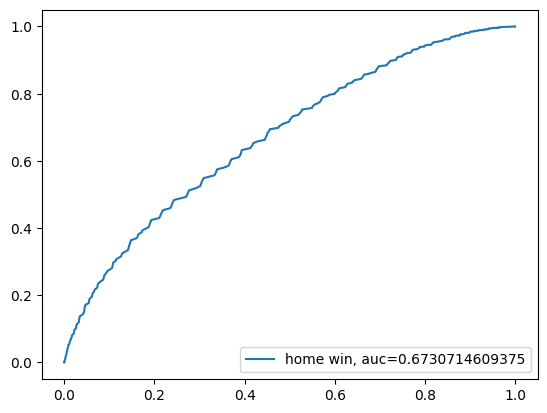

In [465]:
auc = roc_auc_score(data_to_test['home_win_flag'],data_to_test['home_win_prob'] )
plt.plot(fpr,tpr,label="home win, auc="+str(auc))
plt.legend(loc=4)
plt.show()

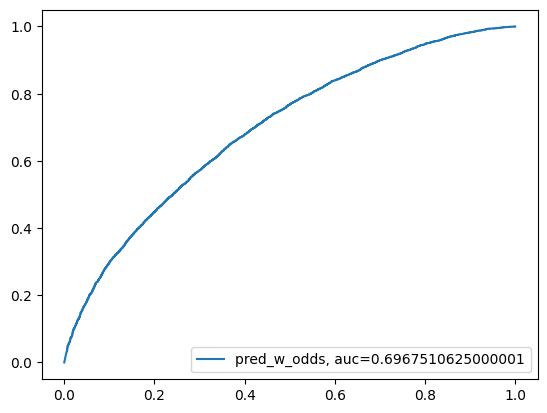

In [466]:
fpr, tpr, _= roc_curve(data_to_test['home_win_flag'],  data_to_test['pred_w_odds'])
auc = roc_auc_score(data_to_test['home_win_flag'],data_to_test['pred_w_odds'] )
plt.plot(fpr,tpr,label="pred_w_odds, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [358]:
auc = roc_auc_score(data_to_test['home_win_flag'],data_to_test['pred_w_odds'] )
auc

0.6754498984375

In [363]:
train_feature.remove('home_win_prob')

['home_win_prob',
 'home_team_goal_roll4_sum',
 'home_team_opponents_goal_roll4_sum',
 'home_team_point_roll4_sum',
 'home_team_expected_point_roll4_sum',
 'away_team_goal_roll4_sum',
 'away_team_opponents_goal_roll4_sum',
 'away_team_point_roll4_sum',
 'away_team_expected_point_roll4_sum',
 'home_team_roll4_points_diff',
 'away_team_roll4_points_diff',
 'home_team_roll1_points_diff',
 'away_team_roll1_points_diff',
 'home_s_p1',
 'home_s_p2',
 'away_s_p1',
 'away_s_p2']

In [402]:
train_feature.remove('home_team_goal_roll4_sum')

In [407]:
train_feature.remove('away_team_opponents_goal_roll4_sum')

In [410]:
train_feature.remove('home_team_roll1_points_diff')

In [413]:
train_feature.remove('home_team_point_roll4_sum')

In [416]:
train_feature.remove('away_team_point_roll4_sum')

In [417]:
auc_max = 0

for x in data_to_test[train_feature].columns:
    
    train_feature_x = [n for n in train_feature if n != x]

    
    X_train = data_to_train[train_feature_x].values
    y_train = data_to_train[train_target].values

    ### Test
    X_test = data_to_test[train_feature_x].values
    y_test = data_to_test[train_target].values
    
    print("******  ",x,"  ********")
    model = support_functions.try_models(GaussianNB(),X_train,y_train,X_test,y_test)
    y_prediction = model.predict_proba(X_test)[:,1]
    data_to_test["pred"] = y_prediction
    auc = roc_auc_score(data_to_test['home_win_flag'],data_to_test['pred'] )
    print("auc:",auc)
    
    if auc > auc_max:
        
        auc_max = auc
        auc_list = []
        auc_list.append(x)
        auc_list.append(auc)

******   home_win_prob   ********
GaussianNB()
accuracy of train set: 0.593625
accuracy of val set: 0.6039375
model mean squared error: 0.3960625
model root mean squared error: 0.6293349664526833
model R2: -0.5842499999999999
auc: 0.651790375
******   home_team_opponents_goal_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.6133
accuracy of val set: 0.6193125
model mean squared error: 0.3806875
model root mean squared error: 0.6169987844396454
model R2: -0.52275
auc: 0.6706525859375
******   home_team_expected_point_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.611775
accuracy of val set: 0.6151875
model mean squared error: 0.3848125
model root mean squared error: 0.6203325720933893
model R2: -0.53925
auc: 0.670021359375
******   away_team_goal_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.6148
accuracy of val set: 0.6180625
model mean squared error: 0.3819375
model root mean squared error: 0.6180109222335799
model R2: -0.5277499999999999
auc: 0.6694

In [401]:
auc_list

['home_win_prob', 0.6519523125, 'home_team_goal_roll4_sum', 0.670354375]

In [406]:
auc_list

['away_team_opponents_goal_roll4_sum', 0.671778453125]

In [409]:
auc_list

['home_team_roll1_points_diff', 0.672342265625]

In [412]:
auc_list

['home_team_point_roll4_sum', 0.67255834375]

In [415]:
auc_list

['away_team_point_roll4_sum', 0.672977640625]

In [418]:
auc_list

['home_team_roll4_points_diff', 0.6737907265624999]

In [436]:
auc_list

['home_team_roll4_points_diff', 0.6737907265624999]

In [438]:
auc_list[0]

'home_team_roll4_points_diff'

In [442]:
all_cols = df2.columns.tolist()
all_cols.remove('match_id')
all_cols.remove('season')
all_cols.remove('div')
all_cols.remove('home_win_flag')
all_cols.remove('draw_flag')
all_cols.remove('away_win_flag')
all_cols.remove('home_win_expected')
all_cols.remove('home_win_accuracy')

# Kill Bill

In [444]:
# train_feature = ['home_win_prob',
#                  'home_team_opponents_goal_roll4_sum',
#                  'home_team_point_roll4_sum','home_team_expected_point_roll4_sum',
#                  'away_team_goal_roll4_sum','away_team_opponents_goal_roll4_sum',
#                  'away_team_point_roll4_sum','away_team_expected_point_roll4_sum',
#                  'home_team_roll4_points_diff','away_team_roll4_points_diff',
#                  'home_team_roll1_points_diff','away_team_roll1_points_diff',
#                  'home_s_p1','home_s_p2',
#                  'away_s_p1','away_s_p2']

train_feature = all_cols


for i in range(100):
    auc_max = 0

    for x in data_to_test[train_feature].columns:

        train_feature_x = [n for n in train_feature if n != x]


        X_train = data_to_train[train_feature_x].values
        y_train = data_to_train[train_target].values

        ### Test
        X_test = data_to_test[train_feature_x].values
        y_test = data_to_test[train_target].values

        print("******  ",x,"  ********")
        model = support_functions.try_models(GaussianNB(),X_train,y_train,X_test,y_test)
        y_prediction = model.predict_proba(X_test)[:,1]
        data_to_test["pred"] = y_prediction
        auc = roc_auc_score(data_to_test['home_win_flag'],data_to_test['pred'] )
        print("auc:",auc)

        if auc > auc_max:

            auc_max = auc
            auc_list = []
            auc_list.append(x)
            auc_list.append(auc)

    train_feature.remove(auc_list[0])

******   odds_home_team_win   ********
GaussianNB()
accuracy of train set: 0.614475
accuracy of val set: 0.606
model mean squared error: 0.394
model root mean squared error: 0.6276941930590086
model R2: -0.5760000000000001
auc: 0.65689634375
******   odds_draw   ********
GaussianNB()
accuracy of train set: 0.614975
accuracy of val set: 0.6073125
model mean squared error: 0.3926875
model root mean squared error: 0.6266478277310151
model R2: -0.5707500000000001
auc: 0.6600868125
******   odds_away_team_win   ********
GaussianNB()
accuracy of train set: 0.61465
accuracy of val set: 0.607625
model mean squared error: 0.392375
model root mean squared error: 0.6263984355025162
model R2: -0.5694999999999999
auc: 0.6601727421875
******   home_team_match_nr   ********
GaussianNB()
accuracy of train set: 0.61515
accuracy of val set: 0.6080625
model mean squared error: 0.3919375
model root mean squared error: 0.6260491194786556
model R2: -0.56775
auc: 0.6606821953124999
******   home_team_goal_ro

GaussianNB()
accuracy of train set: 0.6152
accuracy of val set: 0.6078125
model mean squared error: 0.3921875
model root mean squared error: 0.6262487524937674
model R2: -0.5687500000000001
auc: 0.6606366328125
******   home_team_fault_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.615125
accuracy of val set: 0.608
model mean squared error: 0.392
model root mean squared error: 0.6260990336999411
model R2: -0.5680000000000001
auc: 0.6606399296875001
******   home_team_opponents_fault_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.615075
accuracy of val set: 0.6083125
model mean squared error: 0.3916875
model root mean squared error: 0.6258494227847462
model R2: -0.5667500000000001
auc: 0.6606850859375
******   home_team_opponents_fault_roll2_sum   ********
GaussianNB()
accuracy of train set: 0.61515
accuracy of val set: 0.60825
model mean squared error: 0.39175
model root mean squared error: 0.6258993529314437
model R2: -0.567
auc: 0.6607112265625
******   home_t

GaussianNB()
accuracy of train set: 0.615575
accuracy of val set: 0.6086875
model mean squared error: 0.3913125
model root mean squared error: 0.6255497582127261
model R2: -0.56525
auc: 0.6606535781249999
******   home_team_point_roll2_sum   ********
GaussianNB()
accuracy of train set: 0.61555
accuracy of val set: 0.60875
model mean squared error: 0.39125
model root mean squared error: 0.6254998001598402
model R2: -0.565
auc: 0.6607735312499998
******   home_team_point_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.615775
accuracy of val set: 0.60925
model mean squared error: 0.39075
model root mean squared error: 0.6250999920012797
model R2: -0.563
auc: 0.6607142890625001
******   home_team_point_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.61585
accuracy of val set: 0.6085625
model mean squared error: 0.3914375
model root mean squared error: 0.6256496623510637
model R2: -0.56575
auc: 0.6606515390625
******   home_team_expected_point_roll1_sum   ********
Gaus

accuracy of train set: 0.615525
accuracy of val set: 0.608875
model mean squared error: 0.391125
model root mean squared error: 0.6253998720818545
model R2: -0.5645
auc: 0.6608452499999999
******   away_team_shot_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.614825
accuracy of val set: 0.6075625
model mean squared error: 0.3924375
model root mean squared error: 0.6264483218909601
model R2: -0.56975
auc: 0.6606952187499999
******   away_team_shot_roll2_sum   ********
GaussianNB()
accuracy of train set: 0.615275
accuracy of val set: 0.60775
model mean squared error: 0.39225
model root mean squared error: 0.6262986508048696
model R2: -0.569
auc: 0.6608195156249999
******   away_team_shot_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.615275
accuracy of val set: 0.6079375
model mean squared error: 0.3920625
model root mean squared error: 0.6261489439422541
model R2: -0.5682499999999999
auc: 0.6607759765625001
******   away_team_shot_roll4_sum   ********
GaussianNB(

auc: 0.6606825625000001
******   away_team_opponents_corner_roll2_sum   ********
GaussianNB()
accuracy of train set: 0.6158
accuracy of val set: 0.6078125
model mean squared error: 0.3921875
model root mean squared error: 0.6262487524937674
model R2: -0.5687500000000001
auc: 0.6608494218750001
******   away_team_opponents_corner_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.615675
accuracy of val set: 0.6079375
model mean squared error: 0.3920625
model root mean squared error: 0.6261489439422541
model R2: -0.5682499999999999
auc: 0.6608526640625
******   away_team_opponents_corner_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.616075
accuracy of val set: 0.6078125
model mean squared error: 0.3921875
model root mean squared error: 0.6262487524937674
model R2: -0.5687500000000001
auc: 0.6609011562500001
******   away_team_yelllow_card_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.615525
accuracy of val set: 0.6079375
model mean squared error: 0.39206

accuracy of train set: 0.61455
accuracy of val set: 0.6095
model mean squared error: 0.3905
model root mean squared error: 0.6248999919987197
model R2: -0.562
auc: 0.6620112656250001
******   odds_away_team_win_roll4_mean   ********
GaussianNB()
accuracy of train set: 0.614325
accuracy of val set: 0.608875
model mean squared error: 0.391125
model root mean squared error: 0.6253998720818545
model R2: -0.5645
auc: 0.6616961171875
******   odds_away_team_draw_roll1_mean   ********
GaussianNB()
accuracy of train set: 0.6156
accuracy of val set: 0.608125
model mean squared error: 0.391875
model root mean squared error: 0.6259992012774457
model R2: -0.5674999999999999
auc: 0.66021084375
******   odds_away_team_draw_roll2_mean   ********
GaussianNB()
accuracy of train set: 0.615725
accuracy of val set: 0.6069375
model mean squared error: 0.3930625
model root mean squared error: 0.6269469674541859
model R2: -0.5722499999999999
auc: 0.660016671875
******   odds_away_team_draw_roll3_mean   *****

******   home_s_p2   ********
GaussianNB()
accuracy of train set: 0.61495
accuracy of val set: 0.6081875
model mean squared error: 0.3918125
model root mean squared error: 0.6259492790953592
model R2: -0.56725
auc: 0.6606451875
******   home_s_p3   ********
GaussianNB()
accuracy of train set: 0.615125
accuracy of val set: 0.608375
model mean squared error: 0.391625
model root mean squared error: 0.6257994886543133
model R2: -0.5665
auc: 0.6606610390625
******   away_s_p1   ********
GaussianNB()
accuracy of train set: 0.614975
accuracy of val set: 0.6081875
model mean squared error: 0.3918125
model root mean squared error: 0.6259492790953592
model R2: -0.56725
auc: 0.6606443828124999
******   away_s_p2   ********
GaussianNB()
accuracy of train set: 0.614975
accuracy of val set: 0.6081875
model mean squared error: 0.3918125
model root mean squared error: 0.6259492790953592
model R2: -0.56725
auc: 0.6606443828124999
******   away_s_p3   ********
GaussianNB()
accuracy of train set: 0.61512

accuracy of val set: 0.60975
model mean squared error: 0.39025
model root mean squared error: 0.6246999279654193
model R2: -0.5609999999999999
auc: 0.663200640625
******   home_team_opponents_shot_on_target_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.614675
accuracy of val set: 0.61
model mean squared error: 0.39
model root mean squared error: 0.6244997998398398
model R2: -0.56
auc: 0.6630467734375
******   home_team_opponents_shot_on_target_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.6142
accuracy of val set: 0.6095
model mean squared error: 0.3905
model root mean squared error: 0.6248999919987197
model R2: -0.562
auc: 0.6629258125
******   home_team_fault_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.614425
accuracy of val set: 0.6101875
model mean squared error: 0.3898125
model root mean squared error: 0.6243496616480224
model R2: -0.55925
auc: 0.663444140625
******   home_team_fault_roll2_sum   ********
GaussianNB()
accuracy of train set: 

GaussianNB()
accuracy of train set: 0.614675
accuracy of val set: 0.6095625
model mean squared error: 0.3904375
model root mean squared error: 0.6248499819956786
model R2: -0.56175
auc: 0.6634365625
******   home_team_opponents_red_card_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.615125
accuracy of val set: 0.610125
model mean squared error: 0.389875
model root mean squared error: 0.6243997117231878
model R2: -0.5595000000000001
auc: 0.6635390703124999
******   home_team_opponents_red_card_roll2_sum   ********
GaussianNB()
accuracy of train set: 0.615175
accuracy of val set: 0.6095
model mean squared error: 0.3905
model root mean squared error: 0.6248999919987197
model R2: -0.562
auc: 0.6635885312500001
******   home_team_opponents_red_card_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.614825
accuracy of val set: 0.6095625
model mean squared error: 0.3904375
model root mean squared error: 0.6248499819956786
model R2: -0.56175
auc: 0.6635418359374999
******  

GaussianNB()
accuracy of train set: 0.614575
accuracy of val set: 0.609875
model mean squared error: 0.390125
model root mean squared error: 0.6245998719180144
model R2: -0.5605
auc: 0.6634000234374999
******   away_team_opponents_goal_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.6149
accuracy of val set: 0.6095625
model mean squared error: 0.3904375
model root mean squared error: 0.6248499819956786
model R2: -0.56175
auc: 0.6635727265625
******   away_team_opponents_goal_roll2_sum   ********
GaussianNB()
accuracy of train set: 0.614625
accuracy of val set: 0.6100625
model mean squared error: 0.3899375
model root mean squared error: 0.6244497577868054
model R2: -0.55975
auc: 0.66374028125
******   away_team_opponents_goal_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.614925
accuracy of val set: 0.611
model mean squared error: 0.389
model root mean squared error: 0.623698645180507
model R2: -0.556
auc: 0.6636583046875001
******   away_team_opponents_goal_roll4

GaussianNB()
accuracy of train set: 0.6144
accuracy of val set: 0.610375
model mean squared error: 0.389625
model root mean squared error: 0.6241994873435895
model R2: -0.5585
auc: 0.6631075546875
******   away_team_corner_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.61435
accuracy of val set: 0.6095
model mean squared error: 0.3905
model root mean squared error: 0.6248999919987197
model R2: -0.562
auc: 0.662967234375
******   away_team_corner_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.614425
accuracy of val set: 0.6094375
model mean squared error: 0.3905625
model root mean squared error: 0.62494999799984
model R2: -0.5622499999999999
auc: 0.6628453203125
******   away_team_opponents_corner_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.614725
accuracy of val set: 0.6100625
model mean squared error: 0.3899375
model root mean squared error: 0.6244497577868054
model R2: -0.55975
auc: 0.6634826640625
******   away_team_opponents_corner_roll2_sum  

GaussianNB()
accuracy of train set: 0.614025
accuracy of val set: 0.60925
model mean squared error: 0.39075
model root mean squared error: 0.6250999920012797
model R2: -0.563
auc: 0.6633374218749999
******   odds_away_team_win_roll1_mean   ********
GaussianNB()
accuracy of train set: 0.614625
accuracy of val set: 0.6103125
model mean squared error: 0.3896875
model root mean squared error: 0.6242495494591886
model R2: -0.5587500000000001
auc: 0.6636314609375
******   odds_away_team_win_roll2_mean   ********
GaussianNB()
accuracy of train set: 0.61455
accuracy of val set: 0.610625
model mean squared error: 0.389375
model root mean squared error: 0.6239991987174343
model R2: -0.5575000000000001
auc: 0.664834765625
******   odds_away_team_win_roll3_mean   ********
GaussianNB()
accuracy of train set: 0.6147
accuracy of val set: 0.6104375
model mean squared error: 0.3895625
model root mean squared error: 0.6241494212125811
model R2: -0.5582499999999999
auc: 0.664859984375
******   odds_away_

accuracy of val set: 0.6098125
model mean squared error: 0.3901875
model root mean squared error: 0.6246499019450815
model R2: -0.5607500000000001
auc: 0.6634347421875
******   s_p2   ********
GaussianNB()
accuracy of train set: 0.614525
accuracy of val set: 0.6099375
model mean squared error: 0.3900625
model root mean squared error: 0.6245498378832549
model R2: -0.5602499999999999
auc: 0.663439203125
******   s_p3   ********
GaussianNB()
accuracy of train set: 0.61455
accuracy of val set: 0.6098125
model mean squared error: 0.3901875
model root mean squared error: 0.6246499019450815
model R2: -0.5607500000000001
auc: 0.6634450859374998
******   home_s_p1   ********
GaussianNB()
accuracy of train set: 0.6147
accuracy of val set: 0.6099375
model mean squared error: 0.3900625
model root mean squared error: 0.6245498378832549
model R2: -0.5602499999999999
auc: 0.6634326015625001
******   home_s_p2   ********
GaussianNB()
accuracy of train set: 0.6147
accuracy of val set: 0.6099375
model m

GaussianNB()
accuracy of train set: 0.61585
accuracy of val set: 0.6111875
model mean squared error: 0.3888125
model root mean squared error: 0.6235483140864067
model R2: -0.55525
auc: 0.6664172734375
******   home_team_shot_on_target_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.6156
accuracy of val set: 0.6113125
model mean squared error: 0.3886875
model root mean squared error: 0.6234480732186122
model R2: -0.5547500000000001
auc: 0.6664261640625
******   home_team_opponents_shot_on_target_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.61465
accuracy of val set: 0.612375
model mean squared error: 0.387625
model root mean squared error: 0.6225953742198861
model R2: -0.5505
auc: 0.66616146875
******   home_team_opponents_shot_on_target_roll2_sum   ********
GaussianNB()
accuracy of train set: 0.6146
accuracy of val set: 0.6121875
model mean squared error: 0.3878125
model root mean squared error: 0.6227459353540575
model R2: -0.55125
auc: 0.6660851640625
****** 

******   home_team_red_card_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.6146
accuracy of val set: 0.6116875
model mean squared error: 0.3883125
model root mean squared error: 0.6231472538654086
model R2: -0.55325
auc: 0.6663003593750001
******   home_team_red_card_roll2_sum   ********
GaussianNB()
accuracy of train set: 0.6145
accuracy of val set: 0.611375
model mean squared error: 0.388625
model root mean squared error: 0.6233979467402824
model R2: -0.5545
auc: 0.6663044296874999
******   home_team_red_card_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.6145
accuracy of val set: 0.611625
model mean squared error: 0.388375
model root mean squared error: 0.6231974005080574
model R2: -0.5535000000000001
auc: 0.6663038046875
******   home_team_red_card_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.61445
accuracy of val set: 0.611625
model mean squared error: 0.388375
model root mean squared error: 0.6231974005080574
model R2: -0.5535000000000001
auc

******   away_team_goal_roll2_sum   ********
GaussianNB()
accuracy of train set: 0.614725
accuracy of val set: 0.6116875
model mean squared error: 0.3883125
model root mean squared error: 0.6231472538654086
model R2: -0.55325
auc: 0.6663535859375
******   away_team_goal_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.6147
accuracy of val set: 0.611625
model mean squared error: 0.388375
model root mean squared error: 0.6231974005080574
model R2: -0.5535000000000001
auc: 0.6662930859375
******   away_team_goal_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.614825
accuracy of val set: 0.6115
model mean squared error: 0.3885
model root mean squared error: 0.6232976816898969
model R2: -0.554
auc: 0.6662605859374999
******   away_team_opponents_goal_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.615425
accuracy of val set: 0.612125
model mean squared error: 0.387875
model root mean squared error: 0.6227961143102934
model R2: -0.5515000000000001
auc: 0.66643

GaussianNB()
accuracy of train set: 0.61445
accuracy of val set: 0.6116875
model mean squared error: 0.3883125
model root mean squared error: 0.6231472538654086
model R2: -0.55325
auc: 0.6663788046875001
******   away_team_corner_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.61495
accuracy of val set: 0.61125
model mean squared error: 0.38875
model root mean squared error: 0.6234981956669963
model R2: -0.5549999999999999
auc: 0.666132578125
******   away_team_corner_roll2_sum   ********
GaussianNB()
accuracy of train set: 0.614925
accuracy of val set: 0.610875
model mean squared error: 0.389125
model root mean squared error: 0.6237988457828373
model R2: -0.5565
auc: 0.6659841171875001
******   away_team_corner_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.61495
accuracy of val set: 0.61075
model mean squared error: 0.38925
model root mean squared error: 0.6238990302925627
model R2: -0.5569999999999999
auc: 0.66584225
******   away_team_corner_roll4_sum   *****

auc: 0.666125625
******   away_team_expected_point_roll2_sum   ********
GaussianNB()
accuracy of train set: 0.6146
accuracy of val set: 0.611
model mean squared error: 0.389
model root mean squared error: 0.623698645180507
model R2: -0.556
auc: 0.666339453125
******   away_team_expected_point_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.614975
accuracy of val set: 0.6109375
model mean squared error: 0.3890625
model root mean squared error: 0.6237487474937324
model R2: -0.5562499999999999
auc: 0.6661812578124999
******   away_team_expected_point_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.6146
accuracy of val set: 0.6109375
model mean squared error: 0.3890625
model root mean squared error: 0.6237487474937324
model R2: -0.5562499999999999
auc: 0.6662234296875
******   odds_away_team_win_roll1_mean   ********
GaussianNB()
accuracy of train set: 0.6156
accuracy of val set: 0.6111875
model mean squared error: 0.3888125
model root mean squared error: 0.6235483140

accuracy of train set: 0.615125
accuracy of val set: 0.61175
model mean squared error: 0.38825
model root mean squared error: 0.6230971031869752
model R2: -0.5529999999999999
auc: 0.6664615078125
******   away_team_all_points_diff   ********
GaussianNB()
accuracy of train set: 0.6142
accuracy of val set: 0.611375
model mean squared error: 0.388625
model root mean squared error: 0.6233979467402824
model R2: -0.5545
auc: 0.6665467578125
******   s_p1   ********
GaussianNB()
accuracy of train set: 0.6146
accuracy of val set: 0.6119375
model mean squared error: 0.3880625
model root mean squared error: 0.6229466269272191
model R2: -0.5522499999999999
auc: 0.66630059375
******   s_p2   ********
GaussianNB()
accuracy of train set: 0.6146
accuracy of val set: 0.611625
model mean squared error: 0.388375
model root mean squared error: 0.6231974005080574
model R2: -0.5535000000000001
auc: 0.66630778125
******   s_p3   ********
GaussianNB()
accuracy of train set: 0.61445
accuracy of val set: 0.611

GaussianNB()
accuracy of train set: 0.615025
accuracy of val set: 0.611125
model mean squared error: 0.388875
model root mean squared error: 0.6235984284778145
model R2: -0.5555000000000001
auc: 0.6686076796874999
******   home_team_shot_on_target_roll2_sum   ********
GaussianNB()
accuracy of train set: 0.61535
accuracy of val set: 0.6111875
model mean squared error: 0.3888125
model root mean squared error: 0.6235483140864067
model R2: -0.55525
auc: 0.6686846796875001
******   home_team_shot_on_target_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.6151
accuracy of val set: 0.6115
model mean squared error: 0.3885
model root mean squared error: 0.6232976816898969
model R2: -0.554
auc: 0.6686900390624999
******   home_team_shot_on_target_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.614775
accuracy of val set: 0.61175
model mean squared error: 0.38825
model root mean squared error: 0.6230971031869752
model R2: -0.5529999999999999
auc: 0.6687066015625001
******   h

accuracy of train set: 0.615025
accuracy of val set: 0.61275
model mean squared error: 0.38725
model root mean squared error: 0.6222941426688829
model R2: -0.5489999999999999
auc: 0.6685467265625
******   home_team_opponents_yellow_card_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.61485
accuracy of val set: 0.61275
model mean squared error: 0.38725
model root mean squared error: 0.6222941426688829
model R2: -0.5489999999999999
auc: 0.6684723359375001
******   home_team_opponents_yellow_card_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.61495
accuracy of val set: 0.613125
model mean squared error: 0.386875
model root mean squared error: 0.6219927652312365
model R2: -0.5475000000000001
auc: 0.6685673671875001
******   home_team_red_card_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.614625
accuracy of val set: 0.6114375
model mean squared error: 0.3885625
model root mean squared error: 0.6233478162310349
model R2: -0.5542499999999999
auc: 0.66855474

GaussianNB()
accuracy of train set: 0.6147
accuracy of val set: 0.6113125
model mean squared error: 0.3886875
model root mean squared error: 0.6234480732186122
model R2: -0.5547500000000001
auc: 0.6685866874999999
******   away_team_goal_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.615425
accuracy of val set: 0.6115625
model mean squared error: 0.3884375
model root mean squared error: 0.6232475431158955
model R2: -0.55375
auc: 0.6685598203125
******   away_team_goal_roll2_sum   ********
GaussianNB()
accuracy of train set: 0.614925
accuracy of val set: 0.6115
model mean squared error: 0.3885
model root mean squared error: 0.6232976816898969
model R2: -0.554
auc: 0.6686163593750001
******   away_team_goal_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.614775
accuracy of val set: 0.612375
model mean squared error: 0.387625
model root mean squared error: 0.6225953742198861
model R2: -0.5505
auc: 0.6685601484375
******   away_team_goal_roll4_sum   ********
Gaussian

accuracy of train set: 0.614675
accuracy of val set: 0.6121875
model mean squared error: 0.3878125
model root mean squared error: 0.6227459353540575
model R2: -0.55125
auc: 0.6686221953125
******   away_team_opponents_fault_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.6148
accuracy of val set: 0.611875
model mean squared error: 0.388125
model root mean squared error: 0.6229967897188556
model R2: -0.5525
auc: 0.66864646875
******   away_team_opponents_fault_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.614875
accuracy of val set: 0.61175
model mean squared error: 0.38825
model root mean squared error: 0.6230971031869752
model R2: -0.5529999999999999
auc: 0.6686408281249999
******   away_team_corner_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.614875
accuracy of val set: 0.611625
model mean squared error: 0.388375
model root mean squared error: 0.6231974005080574
model R2: -0.5535000000000001
auc: 0.668379953125
******   away_team_corner_roll2_sum

GaussianNB()
accuracy of train set: 0.6148
accuracy of val set: 0.61275
model mean squared error: 0.38725
model root mean squared error: 0.6222941426688829
model R2: -0.5489999999999999
auc: 0.6687223359375
******   away_team_expected_point_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.615375
accuracy of val set: 0.6119375
model mean squared error: 0.3880625
model root mean squared error: 0.6229466269272191
model R2: -0.5522499999999999
auc: 0.668391
******   away_team_expected_point_roll2_sum   ********
GaussianNB()
accuracy of train set: 0.6149
accuracy of val set: 0.6128125
model mean squared error: 0.3871875
model root mean squared error: 0.6222439232326822
model R2: -0.5487500000000001
auc: 0.6686048906250001
******   away_team_expected_point_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.6145
accuracy of val set: 0.61275
model mean squared error: 0.38725
model root mean squared error: 0.6222941426688829
model R2: -0.5489999999999999
auc: 0.668461726562499

GaussianNB()
accuracy of train set: 0.6148
accuracy of val set: 0.6116875
model mean squared error: 0.3883125
model root mean squared error: 0.6231472538654086
model R2: -0.55325
auc: 0.6685979453124999
******   away_team_goal_roll4_goal_diff   ********
GaussianNB()
accuracy of train set: 0.6148
accuracy of val set: 0.61275
model mean squared error: 0.38725
model root mean squared error: 0.6222941426688829
model R2: -0.5489999999999999
auc: 0.6687641718749999
******   home_team_all_points_diff   ********
GaussianNB()
accuracy of train set: 0.61495
accuracy of val set: 0.6120625
model mean squared error: 0.3879375
model root mean squared error: 0.6228462892239144
model R2: -0.55175
auc: 0.668719515625
******   away_team_all_points_diff   ********
GaussianNB()
accuracy of train set: 0.61475
accuracy of val set: 0.6121875
model mean squared error: 0.3878125
model root mean squared error: 0.6227459353540575
model R2: -0.55125
auc: 0.6688023828125
******   s_p1   ********
GaussianNB()
accur

GaussianNB()
accuracy of train set: 0.61485
accuracy of val set: 0.6125625
model mean squared error: 0.3874375
model root mean squared error: 0.6224447766669747
model R2: -0.54975
auc: 0.6703315390625
******   home_team_opponents_shot_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.6147
accuracy of val set: 0.613625
model mean squared error: 0.386375
model root mean squared error: 0.6215907013461511
model R2: -0.5455000000000001
auc: 0.6703260546875001
******   home_team_shot_on_target_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.615275
accuracy of val set: 0.6129375
model mean squared error: 0.3870625
model root mean squared error: 0.6221434721991383
model R2: -0.5482499999999999
auc: 0.6702760781249999
******   home_team_shot_on_target_roll2_sum   ********
GaussianNB()
accuracy of train set: 0.615275
accuracy of val set: 0.61325
model mean squared error: 0.38675
model root mean squared error: 0.6218922736294445
model R2: -0.5469999999999999
auc: 0.67035744531

accuracy of val set: 0.6135
model mean squared error: 0.3865
model root mean squared error: 0.6216912416947822
model R2: -0.546
auc: 0.6702803671875
******   home_team_opponents_yellow_card_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.614725
accuracy of val set: 0.6136875
model mean squared error: 0.3863125
model root mean squared error: 0.62154042507306
model R2: -0.54525
auc: 0.6701537343749999
******   home_team_opponents_yellow_card_roll2_sum   ********
GaussianNB()
accuracy of train set: 0.614575
accuracy of val set: 0.6141875
model mean squared error: 0.3858125
model root mean squared error: 0.6211380683873755
model R2: -0.54325
auc: 0.6702086796875001
******   home_team_opponents_yellow_card_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.614625
accuracy of val set: 0.6135
model mean squared error: 0.3865
model root mean squared error: 0.6216912416947822
model R2: -0.546
auc: 0.670133796875
******   home_team_opponents_yellow_card_roll4_sum   ********
Ga

GaussianNB()
accuracy of train set: 0.614
accuracy of val set: 0.614375
model mean squared error: 0.385625
model root mean squared error: 0.620987117418711
model R2: -0.5425
auc: 0.6708872187499999
******   away_team_match_nr   ********
GaussianNB()
accuracy of train set: 0.615175
accuracy of val set: 0.6133125
model mean squared error: 0.3866875
model root mean squared error: 0.6218420217386407
model R2: -0.5467500000000001
auc: 0.67024725
******   away_team_goal_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.614975
accuracy of val set: 0.61275
model mean squared error: 0.38725
model root mean squared error: 0.6222941426688829
model R2: -0.5489999999999999
auc: 0.6702370234374999
******   away_team_goal_roll2_sum   ********
GaussianNB()
accuracy of train set: 0.614625
accuracy of val set: 0.612625
model mean squared error: 0.387375
model root mean squared error: 0.6223945693850486
model R2: -0.5495000000000001
auc: 0.670292640625
******   away_team_goal_roll3_sum   *******

GaussianNB()
accuracy of train set: 0.61505
accuracy of val set: 0.6135625
model mean squared error: 0.3864375
model root mean squared error: 0.621640973553063
model R2: -0.54575
auc: 0.6702678281250001
******   away_team_opponents_fault_roll2_sum   ********
GaussianNB()
accuracy of train set: 0.614825
accuracy of val set: 0.613875
model mean squared error: 0.386125
model root mean squared error: 0.6213895718468407
model R2: -0.5445
auc: 0.6702862109375
******   away_team_opponents_fault_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.615025
accuracy of val set: 0.614
model mean squared error: 0.386
model root mean squared error: 0.6212889826803627
model R2: -0.544
auc: 0.670308859375
******   away_team_opponents_fault_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.61495
accuracy of val set: 0.6135625
model mean squared error: 0.3864375
model root mean squared error: 0.621640973553063
model R2: -0.54575
auc: 0.6703080390625
******   away_team_corner_roll1_sum   *

******   away_team_point_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.6147
accuracy of val set: 0.613375
model mean squared error: 0.386625
model root mean squared error: 0.6217917657865855
model R2: -0.5465
auc: 0.6703761953124999
******   away_team_point_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.61455
accuracy of val set: 0.614375
model mean squared error: 0.385625
model root mean squared error: 0.620987117418711
model R2: -0.5425
auc: 0.6703759843749999
******   away_team_expected_point_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.615025
accuracy of val set: 0.613375
model mean squared error: 0.386625
model root mean squared error: 0.6217917657865855
model R2: -0.5465
auc: 0.6700569609375
******   away_team_expected_point_roll2_sum   ********
GaussianNB()
accuracy of train set: 0.614875
accuracy of val set: 0.6138125
model mean squared error: 0.3861875
model root mean squared error: 0.6214398603243921
model R2: -0.5447500000000001
auc: 0.

GaussianNB()
accuracy of train set: 0.614625
accuracy of val set: 0.6135625
model mean squared error: 0.3864375
model root mean squared error: 0.621640973553063
model R2: -0.54575
auc: 0.670178421875
******   home_team_goal_roll4_goal_diff   ********
GaussianNB()
accuracy of train set: 0.6147
accuracy of val set: 0.6128125
model mean squared error: 0.3871875
model root mean squared error: 0.6222439232326822
model R2: -0.5487500000000001
auc: 0.670288828125
******   away_team_goal_roll4_goal_diff   ********
GaussianNB()
accuracy of train set: 0.6148
accuracy of val set: 0.6139375
model mean squared error: 0.3860625
model root mean squared error: 0.6213392792991603
model R2: -0.5442499999999999
auc: 0.6704238984374999
******   home_team_all_points_diff   ********
GaussianNB()
accuracy of train set: 0.6147
accuracy of val set: 0.61325
model mean squared error: 0.38675
model root mean squared error: 0.6218922736294445
model R2: -0.5469999999999999
auc: 0.6703913828125
******   away_team_al

******   home_team_opponents_shot_roll2_sum   ********
GaussianNB()
accuracy of train set: 0.6144
accuracy of val set: 0.61475
model mean squared error: 0.38525
model root mean squared error: 0.6206851053473089
model R2: -0.5409999999999999
auc: 0.6717175
******   home_team_opponents_shot_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.614625
accuracy of val set: 0.6143125
model mean squared error: 0.3856875
model root mean squared error: 0.6210374384849918
model R2: -0.5427500000000001
auc: 0.6717408359374999
******   home_team_opponents_shot_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.6145
accuracy of val set: 0.614875
model mean squared error: 0.385125
model root mean squared error: 0.6205844019954094
model R2: -0.5405
auc: 0.6717103984375
******   home_team_shot_on_target_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.61445
accuracy of val set: 0.6151875
model mean squared error: 0.3848125
model root mean squared error: 0.6203325720933893
model

GaussianNB()
accuracy of train set: 0.6143
accuracy of val set: 0.6146875
model mean squared error: 0.3853125
model root mean squared error: 0.6207354508967569
model R2: -0.54125
auc: 0.671633984375
******   home_team_yellow_card_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.6143
accuracy of val set: 0.6145625
model mean squared error: 0.3854375
model root mean squared error: 0.620836129747617
model R2: -0.54175
auc: 0.6716425078125001
******   home_team_opponents_yellow_card_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.61395
accuracy of val set: 0.61525
model mean squared error: 0.38475
model root mean squared error: 0.6202821938440599
model R2: -0.5389999999999999
auc: 0.6715352890625
******   home_team_opponents_yellow_card_roll2_sum   ********
GaussianNB()
accuracy of train set: 0.61405
accuracy of val set: 0.614875
model mean squared error: 0.385125
model root mean squared error: 0.6205844019954094
model R2: -0.5405
auc: 0.6715940390625
******   home_tea

auc: 0.6721092734375
******   home_team_point_mean   ********
GaussianNB()
accuracy of train set: 0.614075
accuracy of val set: 0.61475
model mean squared error: 0.38525
model root mean squared error: 0.6206851053473089
model R2: -0.5409999999999999
auc: 0.6717292343750001
******   home_team_expected_point_mean   ********
GaussianNB()
accuracy of train set: 0.613625
accuracy of val set: 0.6163125
model mean squared error: 0.3836875
model root mean squared error: 0.6194251367195232
model R2: -0.5347500000000001
auc: 0.6723411171875
******   away_team_match_nr   ********
GaussianNB()
accuracy of train set: 0.614175
accuracy of val set: 0.614875
model mean squared error: 0.385125
model root mean squared error: 0.6205844019954094
model R2: -0.5405
auc: 0.6716178749999999
******   away_team_goal_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.614
accuracy of val set: 0.615
model mean squared error: 0.385
model root mean squared error: 0.6204836822995429
model R2: -0.54
auc: 0.671

auc: 0.6717149296875
******   away_team_fault_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.61415
accuracy of val set: 0.61525
model mean squared error: 0.38475
model root mean squared error: 0.6202821938440599
model R2: -0.5389999999999999
auc: 0.6717472187499999
******   away_team_opponents_fault_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.6146
accuracy of val set: 0.6149375
model mean squared error: 0.3850625
model root mean squared error: 0.6205340441909694
model R2: -0.5402499999999999
auc: 0.6716341484375
******   away_team_opponents_fault_roll2_sum   ********
GaussianNB()
accuracy of train set: 0.61445
accuracy of val set: 0.614625
model mean squared error: 0.385375
model root mean squared error: 0.6207857923631951
model R2: -0.5415000000000001
auc: 0.6716534453125
******   away_team_opponents_fault_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.614375
accuracy of val set: 0.614625
model mean squared error: 0.385375
model root mean squared

GaussianNB()
accuracy of train set: 0.614575
accuracy of val set: 0.615125
model mean squared error: 0.384875
model root mean squared error: 0.6203829462517486
model R2: -0.5395000000000001
auc: 0.6716655468749999
******   away_team_point_roll2_sum   ********
GaussianNB()
accuracy of train set: 0.614075
accuracy of val set: 0.6155
model mean squared error: 0.3845
model root mean squared error: 0.6200806399170998
model R2: -0.538
auc: 0.671801390625
******   away_team_point_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.61425
accuracy of val set: 0.61575
model mean squared error: 0.38425
model root mean squared error: 0.619879020454798
model R2: -0.5369999999999999
auc: 0.6717368671875
******   away_team_point_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.614175
accuracy of val set: 0.61625
model mean squared error: 0.38375
model root mean squared error: 0.6194755846681933
model R2: -0.5349999999999999
auc: 0.671729609375
******   away_team_expected_point_roll1_

GaussianNB()
accuracy of train set: 0.61465
accuracy of val set: 0.6153125
model mean squared error: 0.3846875
model root mean squared error: 0.6202318115027639
model R2: -0.5387500000000001
auc: 0.6719261093750001
******   away_team_goal_roll4_avg   ********
GaussianNB()
accuracy of train set: 0.6142
accuracy of val set: 0.61575
model mean squared error: 0.38425
model root mean squared error: 0.619879020454798
model R2: -0.5369999999999999
auc: 0.6715455625000001
******   home_team_goal_roll4_goal_diff   ********
GaussianNB()
accuracy of train set: 0.614225
accuracy of val set: 0.6158125
model mean squared error: 0.3841875
model root mean squared error: 0.6198286053418316
model R2: -0.5367500000000001
auc: 0.6716803359375
******   away_team_goal_roll4_goal_diff   ********
GaussianNB()
accuracy of train set: 0.614275
accuracy of val set: 0.6166875
model mean squared error: 0.3833125
model root mean squared error: 0.6191223627038519
model R2: -0.53325
auc: 0.671795859375
******   home_t

GaussianNB()
accuracy of train set: 0.614625
accuracy of val set: 0.6168125
model mean squared error: 0.3831875
model root mean squared error: 0.6190214051226339
model R2: -0.5327500000000001
auc: 0.6726670703125001
******   home_team_opponents_shot_roll2_sum   ********
GaussianNB()
accuracy of train set: 0.61445
accuracy of val set: 0.616375
model mean squared error: 0.383625
model root mean squared error: 0.6193746846618774
model R2: -0.5345
auc: 0.6727476953125
******   home_team_opponents_shot_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.614425
accuracy of val set: 0.616375
model mean squared error: 0.383625
model root mean squared error: 0.6193746846618774
model R2: -0.5345
auc: 0.6727658593750001
******   home_team_opponents_shot_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.61425
accuracy of val set: 0.6158125
model mean squared error: 0.3841875
model root mean squared error: 0.6198286053418316
model R2: -0.5367500000000001
auc: 0.6727504375
******   h

model mean squared error: 0.3830625
model root mean squared error: 0.6189204310733327
model R2: -0.5322499999999999
auc: 0.6726307031250001
******   home_team_yellow_card_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.61405
accuracy of val set: 0.6166875
model mean squared error: 0.3833125
model root mean squared error: 0.6191223627038519
model R2: -0.53325
auc: 0.6726523359375
******   home_team_yellow_card_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.61425
accuracy of val set: 0.6169375
model mean squared error: 0.3830625
model root mean squared error: 0.6189204310733327
model R2: -0.5322499999999999
auc: 0.6726628125
******   home_team_opponents_yellow_card_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.6139
accuracy of val set: 0.6168125
model mean squared error: 0.3831875
model root mean squared error: 0.6190214051226339
model R2: -0.5327500000000001
auc: 0.6725570234374999
******   home_team_opponents_yellow_card_roll2_sum   ********
Gaussian

******   odds_home_team_defeat_roll4_mean   ********
GaussianNB()
accuracy of train set: 0.613925
accuracy of val set: 0.617
model mean squared error: 0.383
model root mean squared error: 0.618869937870632
model R2: -0.532
auc: 0.6731800703124999
******   home_team_point_mean   ********
GaussianNB()
accuracy of train set: 0.613775
accuracy of val set: 0.6166875
model mean squared error: 0.3833125
model root mean squared error: 0.6191223627038519
model R2: -0.53325
auc: 0.672773921875
******   home_team_expected_point_mean   ********
GaussianNB()
accuracy of train set: 0.61395
accuracy of val set: 0.617625
model mean squared error: 0.382375
model root mean squared error: 0.6183647790746171
model R2: -0.5295000000000001
auc: 0.6734252812499999
******   away_team_match_nr   ********
GaussianNB()
accuracy of train set: 0.614375
accuracy of val set: 0.6165625
model mean squared error: 0.3834375
model root mean squared error: 0.6192233038250418
model R2: -0.53375
auc: 0.672622203125
******  

******   away_team_fault_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.614925
accuracy of val set: 0.617125
model mean squared error: 0.382875
model root mean squared error: 0.6187689391040891
model R2: -0.5315000000000001
auc: 0.6727253046874999
******   away_team_fault_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.614875
accuracy of val set: 0.617
model mean squared error: 0.383
model root mean squared error: 0.618869937870632
model R2: -0.532
auc: 0.672758359375
******   away_team_opponents_fault_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.6141
accuracy of val set: 0.616875
model mean squared error: 0.383125
model root mean squared error: 0.6189709201569974
model R2: -0.5325
auc: 0.6726448203125
******   away_team_opponents_fault_roll2_sum   ********
GaussianNB()
accuracy of train set: 0.614325
accuracy of val set: 0.617
model mean squared error: 0.383
model root mean squared error: 0.618869937870632
model R2: -0.532
auc: 0.6726663749999999
*

******   away_team_point_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.614475
accuracy of val set: 0.617
model mean squared error: 0.383
model root mean squared error: 0.618869937870632
model R2: -0.532
auc: 0.6726717265625
******   away_team_point_roll2_sum   ********
GaussianNB()
accuracy of train set: 0.614225
accuracy of val set: 0.6170625
model mean squared error: 0.3829375
model root mean squared error: 0.6188194405478871
model R2: -0.53175
auc: 0.672783921875
******   away_team_point_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.61435
accuracy of val set: 0.617625
model mean squared error: 0.382375
model root mean squared error: 0.6183647790746171
model R2: -0.5295000000000001
auc: 0.6727281484375001
******   away_team_point_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.614225
accuracy of val set: 0.616875
model mean squared error: 0.383125
model root mean squared error: 0.6189709201569974
model R2: -0.5325
auc: 0.67272159375
******   away_

model mean squared error: 0.384125
model root mean squared error: 0.6197781861279081
model R2: -0.5365
auc: 0.672542265625
******   home_team_goal_roll4_goal_diff   ********
GaussianNB()
accuracy of train set: 0.614575
accuracy of val set: 0.6170625
model mean squared error: 0.3829375
model root mean squared error: 0.6188194405478871
model R2: -0.53175
auc: 0.6727140703125
******   away_team_goal_roll4_goal_diff   ********
GaussianNB()
accuracy of train set: 0.613925
accuracy of val set: 0.6175625
model mean squared error: 0.3824375
model root mean squared error: 0.6184153135232018
model R2: -0.5297499999999999
auc: 0.6727835312500001
******   home_team_all_points_diff   ********
GaussianNB()
accuracy of train set: 0.614375
accuracy of val set: 0.6166875
model mean squared error: 0.3833125
model root mean squared error: 0.6191223627038519
model R2: -0.53325
auc: 0.6727739687500001
******   away_team_all_points_diff   ********
GaussianNB()
accuracy of train set: 0.6141
accuracy of val s

model mean squared error: 0.382875
model root mean squared error: 0.6187689391040891
model R2: -0.5315000000000001
auc: 0.67362825
******   home_team_opponents_shot_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.614175
accuracy of val set: 0.616875
model mean squared error: 0.383125
model root mean squared error: 0.6189709201569974
model R2: -0.5325
auc: 0.6736579375
******   home_team_opponents_shot_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.613775
accuracy of val set: 0.6166875
model mean squared error: 0.3833125
model root mean squared error: 0.6191223627038519
model R2: -0.53325
auc: 0.6736353515625
******   home_team_shot_on_target_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.614075
accuracy of val set: 0.617375
model mean squared error: 0.382625
model root mean squared error: 0.6185668920981788
model R2: -0.5305
auc: 0.6735520703125
******   home_team_shot_on_target_roll2_sum   ********
GaussianNB()
accuracy of train set: 0.61435
accuracy

model mean squared error: 0.382625
model root mean squared error: 0.6185668920981788
model R2: -0.5305
auc: 0.6735487812500001
******   home_team_opponents_yellow_card_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.6141
accuracy of val set: 0.6166875
model mean squared error: 0.3833125
model root mean squared error: 0.6191223627038519
model R2: -0.53325
auc: 0.67344915625
******   home_team_opponents_yellow_card_roll2_sum   ********
GaussianNB()
accuracy of train set: 0.614225
accuracy of val set: 0.6171875
model mean squared error: 0.3828125
model root mean squared error: 0.6187184335382291
model R2: -0.53125
auc: 0.6735093671875001
******   home_team_opponents_yellow_card_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.6141
accuracy of val set: 0.61725
model mean squared error: 0.38275
model root mean squared error: 0.6186679238492974
model R2: -0.5309999999999999
auc: 0.6734264375
******   home_team_opponents_yellow_card_roll4_sum   ********
GaussianNB()
accur

GaussianNB()
accuracy of train set: 0.6137
accuracy of val set: 0.61725
model mean squared error: 0.38275
model root mean squared error: 0.6186679238492974
model R2: -0.5309999999999999
auc: 0.6735071015625
******   away_team_goal_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.614
accuracy of val set: 0.616875
model mean squared error: 0.383125
model root mean squared error: 0.6189709201569974
model R2: -0.5325
auc: 0.6734916796875001
******   away_team_goal_roll2_sum   ********
GaussianNB()
accuracy of train set: 0.613825
accuracy of val set: 0.617125
model mean squared error: 0.382875
model root mean squared error: 0.6187689391040891
model R2: -0.5315000000000001
auc: 0.6735433828124999
******   away_team_goal_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.613925
accuracy of val set: 0.6174375
model mean squared error: 0.3825625
model root mean squared error: 0.6185163700339709
model R2: -0.5302500000000001
auc: 0.6734778359375
******   away_team_goal_roll4_su

GaussianNB()
accuracy of train set: 0.613725
accuracy of val set: 0.6173125
model mean squared error: 0.3826875
model root mean squared error: 0.6186174100362841
model R2: -0.53075
auc: 0.6735594375
******   away_team_opponents_fault_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.613425
accuracy of val set: 0.6175625
model mean squared error: 0.3824375
model root mean squared error: 0.6184153135232018
model R2: -0.5297499999999999
auc: 0.6735782187500001
******   away_team_opponents_fault_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.61355
accuracy of val set: 0.6174375
model mean squared error: 0.3825625
model root mean squared error: 0.6185163700339709
model R2: -0.5302500000000001
auc: 0.6735751953125
******   away_team_corner_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.614
accuracy of val set: 0.61725
model mean squared error: 0.38275
model root mean squared error: 0.6186679238492974
model R2: -0.5309999999999999
auc: 0.6733147968750001
*****

******   away_team_point_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.613975
accuracy of val set: 0.6175
model mean squared error: 0.3825
model root mean squared error: 0.6184658438426491
model R2: -0.53
auc: 0.6736332812500001
******   away_team_expected_point_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.614125
accuracy of val set: 0.6160625
model mean squared error: 0.3839375
model root mean squared error: 0.6196269038703855
model R2: -0.53575
auc: 0.673304828125
******   away_team_expected_point_roll2_sum   ********
GaussianNB()
accuracy of train set: 0.61415
accuracy of val set: 0.617
model mean squared error: 0.383
model root mean squared error: 0.618869937870632
model R2: -0.532
auc: 0.6734870234375
******   away_team_expected_point_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.613775
accuracy of val set: 0.6170625
model mean squared error: 0.3829375
model root mean squared error: 0.6188194405478871
model R2: -0.53175
auc: 0.673340328125
*

accuracy of train set: 0.613975
accuracy of val set: 0.617125
model mean squared error: 0.382875
model root mean squared error: 0.6187689391040891
model R2: -0.5315000000000001
auc: 0.6736582734375001
******   away_team_all_points_diff   ********
GaussianNB()
accuracy of train set: 0.6138
accuracy of val set: 0.617625
model mean squared error: 0.382375
model root mean squared error: 0.6183647790746171
model R2: -0.5295000000000001
auc: 0.6737283046875
******   s_p1   ********
GaussianNB()
accuracy of train set: 0.6141
accuracy of val set: 0.61675
model mean squared error: 0.38325
model root mean squared error: 0.6190718859712497
model R2: -0.5329999999999999
auc: 0.6734841250000001
******   s_p2   ********
GaussianNB()
accuracy of train set: 0.61395
accuracy of val set: 0.617
model mean squared error: 0.383
model root mean squared error: 0.618869937870632
model R2: -0.532
auc: 0.6734907578125
******   s_p3   ********
GaussianNB()
accuracy of train set: 0.613875
accuracy of val set: 0.6

******   home_team_shot_on_target_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.61475
accuracy of val set: 0.618125
model mean squared error: 0.381875
model root mean squared error: 0.6179603547154138
model R2: -0.5275000000000001
auc: 0.674395421875
******   home_team_shot_on_target_roll2_sum   ********
GaussianNB()
accuracy of train set: 0.614325
accuracy of val set: 0.61725
model mean squared error: 0.38275
model root mean squared error: 0.6186679238492974
model R2: -0.5309999999999999
auc: 0.6744684765625001
******   home_team_shot_on_target_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.614425
accuracy of val set: 0.6173125
model mean squared error: 0.3826875
model root mean squared error: 0.6186174100362841
model R2: -0.53075
auc: 0.6744621640624999
******   home_team_shot_on_target_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.61435
accuracy of val set: 0.617375
model mean squared error: 0.382625
model root mean squared error: 0.618566892098

******   home_team_opponents_yellow_card_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.613975
accuracy of val set: 0.617625
model mean squared error: 0.382375
model root mean squared error: 0.6183647790746171
model R2: -0.5295000000000001
auc: 0.674262640625
******   home_team_opponents_yellow_card_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.614075
accuracy of val set: 0.618125
model mean squared error: 0.381875
model root mean squared error: 0.6179603547154138
model R2: -0.5275000000000001
auc: 0.6743885546874999
******   home_team_red_card_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.6144
accuracy of val set: 0.6178125
model mean squared error: 0.3821875
model root mean squared error: 0.6182131509439119
model R2: -0.52875
auc: 0.674311
******   home_team_red_card_roll2_sum   ********
GaussianNB()
accuracy of train set: 0.614425
accuracy of val set: 0.6178125
model mean squared error: 0.3821875
model root mean squared error: 0.6182131509439119

******   away_team_goal_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.61475
accuracy of val set: 0.6179375
model mean squared error: 0.3820625
model root mean squared error: 0.6181120448591825
model R2: -0.5282500000000001
auc: 0.6743194375
******   away_team_opponents_goal_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.61435
accuracy of val set: 0.6175625
model mean squared error: 0.3824375
model root mean squared error: 0.6184153135232018
model R2: -0.5297499999999999
auc: 0.6744719921875001
******   away_team_opponents_goal_roll2_sum   ********
GaussianNB()
accuracy of train set: 0.6141
accuracy of val set: 0.617375
model mean squared error: 0.382625
model root mean squared error: 0.6185668920981788
model R2: -0.5305
auc: 0.6746288906249999
******   away_team_opponents_goal_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.613975
accuracy of val set: 0.6179375
model mean squared error: 0.3820625
model root mean squared error: 0.6181120448591825
mode

accuracy of train set: 0.61425
accuracy of val set: 0.6178125
model mean squared error: 0.3821875
model root mean squared error: 0.6182131509439119
model R2: -0.52875
auc: 0.6741478984375
******   away_team_corner_roll2_sum   ********
GaussianNB()
accuracy of train set: 0.61385
accuracy of val set: 0.6179375
model mean squared error: 0.3820625
model root mean squared error: 0.6181120448591825
model R2: -0.5282500000000001
auc: 0.6739835
******   away_team_corner_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.614625
accuracy of val set: 0.6175625
model mean squared error: 0.3824375
model root mean squared error: 0.6184153135232018
model R2: -0.5297499999999999
auc: 0.6738434140625
******   away_team_corner_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.614025
accuracy of val set: 0.617375
model mean squared error: 0.382625
model root mean squared error: 0.6185668920981788
model R2: -0.5305
auc: 0.6737026796875
******   away_team_opponents_corner_roll1_sum   *****

******   away_team_expected_point_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.614775
accuracy of val set: 0.6175625
model mean squared error: 0.3824375
model root mean squared error: 0.6184153135232018
model R2: -0.5297499999999999
auc: 0.674210765625
******   away_team_expected_point_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.61415
accuracy of val set: 0.6178125
model mean squared error: 0.3821875
model root mean squared error: 0.6182131509439119
model R2: -0.52875
auc: 0.6742734609375
******   odds_away_team_win_roll1_mean   ********
GaussianNB()
accuracy of train set: 0.614375
accuracy of val set: 0.61675
model mean squared error: 0.38325
model root mean squared error: 0.6190718859712497
model R2: -0.5329999999999999
auc: 0.6741201328125
******   odds_away_team_win_roll4_mean   ********
GaussianNB()
accuracy of train set: 0.6134
accuracy of val set: 0.617375
model mean squared error: 0.382625
model root mean squared error: 0.6185668920981788
model R2: 

******   s_p3   ********
GaussianNB()
accuracy of train set: 0.614175
accuracy of val set: 0.6175
model mean squared error: 0.3825
model root mean squared error: 0.6184658438426491
model R2: -0.53
auc: 0.6743285625000001
******   home_s_p1   ********
GaussianNB()
accuracy of train set: 0.614275
accuracy of val set: 0.61775
model mean squared error: 0.38225
model root mean squared error: 0.6182636977859851
model R2: -0.5289999999999999
auc: 0.67431365625
******   home_s_p2   ********
GaussianNB()
accuracy of train set: 0.614275
accuracy of val set: 0.61775
model mean squared error: 0.38225
model root mean squared error: 0.6182636977859851
model R2: -0.5289999999999999
auc: 0.67431365625
******   home_s_p3   ********
GaussianNB()
accuracy of train set: 0.614175
accuracy of val set: 0.6175
model mean squared error: 0.3825
model root mean squared error: 0.6184658438426491
model R2: -0.53
auc: 0.6743285625000001
******   away_s_p1   ********
GaussianNB()
accuracy of train set: 0.614275
accu

accuracy of train set: 0.61385
accuracy of val set: 0.618625
model mean squared error: 0.381375
model root mean squared error: 0.6175556655071671
model R2: -0.5255000000000001
auc: 0.6748535625000001
******   home_team_opponents_shot_on_target_roll2_sum   ********
GaussianNB()
accuracy of train set: 0.6135
accuracy of val set: 0.6190625
model mean squared error: 0.3809375
model root mean squared error: 0.6172013447814254
model R2: -0.5237499999999999
auc: 0.674802125
******   home_team_opponents_shot_on_target_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.613325
accuracy of val set: 0.6190625
model mean squared error: 0.3809375
model root mean squared error: 0.6172013447814254
model R2: -0.5237499999999999
auc: 0.674660890625
******   home_team_opponents_shot_on_target_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.6132
accuracy of val set: 0.6181875
model mean squared error: 0.3818125
model root mean squared error: 0.6179097830589835
model R2: -0.52725
auc: 0.

******   home_team_red_card_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.613725
accuracy of val set: 0.6194375
model mean squared error: 0.3805625
model root mean squared error: 0.6168974793269948
model R2: -0.5222500000000001
auc: 0.67492040625
******   home_team_red_card_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.613675
accuracy of val set: 0.61925
model mean squared error: 0.38075
model root mean squared error: 0.6170494307589952
model R2: -0.5229999999999999
auc: 0.6749208203125
******   home_team_opponents_red_card_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.61415
accuracy of val set: 0.6188125
model mean squared error: 0.3811875
model root mean squared error: 0.617403838666395
model R2: -0.52475
auc: 0.67505465625
******   home_team_opponents_red_card_roll2_sum   ********
GaussianNB()
accuracy of train set: 0.613875
accuracy of val set: 0.6190625
model mean squared error: 0.3809375
model root mean squared error: 0.6172013447814254
mode

GaussianNB()
accuracy of train set: 0.614075
accuracy of val set: 0.6188125
model mean squared error: 0.3811875
model root mean squared error: 0.617403838666395
model R2: -0.52475
auc: 0.6750003515625
******   away_team_shot_roll2_sum   ********
GaussianNB()
accuracy of train set: 0.61395
accuracy of val set: 0.61875
model mean squared error: 0.38125
model root mean squared error: 0.6174544517614234
model R2: -0.5249999999999999
auc: 0.6751425703125
******   away_team_shot_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.6138
accuracy of val set: 0.619
model mean squared error: 0.381
model root mean squared error: 0.6172519744804386
model R2: -0.524
auc: 0.6751012109375001
******   away_team_shot_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.613975
accuracy of val set: 0.6193125
model mean squared error: 0.3806875
model root mean squared error: 0.6169987844396454
model R2: -0.52275
auc: 0.6751478203125001
******   away_team_opponents_shot_roll1_sum   ********
Gau

******   away_team_opponents_corner_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.613875
accuracy of val set: 0.619
model mean squared error: 0.381
model root mean squared error: 0.6172519744804386
model R2: -0.524
auc: 0.67515690625
******   away_team_opponents_corner_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.613725
accuracy of val set: 0.619
model mean squared error: 0.381
model root mean squared error: 0.6172519744804386
model R2: -0.524
auc: 0.6752214999999999
******   away_team_yelllow_card_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.614025
accuracy of val set: 0.61825
model mean squared error: 0.38175
model root mean squared error: 0.6178592072632728
model R2: -0.5269999999999999
auc: 0.6750058828125001
******   away_team_yelllow_card_roll2_sum   ********
GaussianNB()
accuracy of train set: 0.61395
accuracy of val set: 0.6183125
model mean squared error: 0.3816875
model root mean squared error: 0.6178086273272655
model R2: -0.52675
auc

model mean squared error: 0.3826875
model root mean squared error: 0.6186174100362841
model R2: -0.53075
auc: 0.6746236796874999
******   odds_away_team_draw_roll3_mean   ********
GaussianNB()
accuracy of train set: 0.613825
accuracy of val set: 0.617125
model mean squared error: 0.382875
model root mean squared error: 0.6187689391040891
model R2: -0.5315000000000001
auc: 0.6746254765625
******   odds_away_team_draw_roll4_mean   ********
GaussianNB()
accuracy of train set: 0.614075
accuracy of val set: 0.61725
model mean squared error: 0.38275
model root mean squared error: 0.6186679238492974
model R2: -0.5309999999999999
auc: 0.674742109375
******   odds_away_team_defeat_roll1_mean   ********
GaussianNB()
accuracy of train set: 0.61365
accuracy of val set: 0.616875
model mean squared error: 0.383125
model root mean squared error: 0.6189709201569974
model R2: -0.5325
auc: 0.674425796875
******   odds_away_team_defeat_roll2_mean   ********
GaussianNB()
accuracy of train set: 0.613625
ac

GaussianNB()
accuracy of train set: 0.613675
accuracy of val set: 0.6193125
model mean squared error: 0.3806875
model root mean squared error: 0.6169987844396454
model R2: -0.52275
auc: 0.6749301953125001
******   odds_home_team_win   ********
GaussianNB()
accuracy of train set: 0.61275
accuracy of val set: 0.6178125
model mean squared error: 0.3821875
model root mean squared error: 0.6182131509439119
model R2: -0.52875
auc: 0.673143015625
******   odds_draw   ********
GaussianNB()
accuracy of train set: 0.61265
accuracy of val set: 0.6189375
model mean squared error: 0.3810625
model root mean squared error: 0.6173026000269236
model R2: -0.5242500000000001
auc: 0.6749561328125
******   odds_away_team_win   ********
GaussianNB()
accuracy of train set: 0.611175
accuracy of val set: 0.61875
model mean squared error: 0.38125
model root mean squared error: 0.6174544517614234
model R2: -0.5249999999999999
auc: 0.6753793515625001
******   home_team_match_nr   ********
GaussianNB()
accuracy of

GaussianNB()
accuracy of train set: 0.613325
accuracy of val set: 0.6179375
model mean squared error: 0.3820625
model root mean squared error: 0.6181120448591825
model R2: -0.5282500000000001
auc: 0.6755896953125
******   home_team_fault_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.613225
accuracy of val set: 0.6180625
model mean squared error: 0.3819375
model root mean squared error: 0.6180109222335799
model R2: -0.5277499999999999
auc: 0.6755931093750001
******   home_team_fault_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.6132
accuracy of val set: 0.618
model mean squared error: 0.382
model root mean squared error: 0.6180614856144977
model R2: -0.528
auc: 0.6755931171875
******   home_team_opponents_fault_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.61335
accuracy of val set: 0.6176875
model mean squared error: 0.3823125
model root mean squared error: 0.6183142404958825
model R2: -0.52925
auc: 0.6756534140625
******   home_team_opponents_fau

GaussianNB()
accuracy of train set: 0.613525
accuracy of val set: 0.6185
model mean squared error: 0.3815
model root mean squared error: 0.6176568626672904
model R2: -0.526
auc: 0.675733921875
******   home_team_opponents_red_card_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.6135
accuracy of val set: 0.61825
model mean squared error: 0.38175
model root mean squared error: 0.6178592072632728
model R2: -0.5269999999999999
auc: 0.6756900390625
******   home_team_point_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.61265
accuracy of val set: 0.6189375
model mean squared error: 0.3810625
model root mean squared error: 0.6173026000269236
model R2: -0.5242500000000001
auc: 0.67570396875
******   home_team_point_roll2_sum   ********
GaussianNB()
accuracy of train set: 0.61335
accuracy of val set: 0.6185
model mean squared error: 0.3815
model root mean squared error: 0.6176568626672904
model R2: -0.526
auc: 0.67584453125
******   home_team_point_roll3_sum   ********
Ga

GaussianNB()
accuracy of train set: 0.612975
accuracy of val set: 0.6183125
model mean squared error: 0.3816875
model root mean squared error: 0.6178086273272655
model R2: -0.52675
auc: 0.6754342109375
******   away_team_opponents_shot_roll2_sum   ********
GaussianNB()
accuracy of train set: 0.6132
accuracy of val set: 0.61875
model mean squared error: 0.38125
model root mean squared error: 0.6174544517614234
model R2: -0.5249999999999999
auc: 0.6754296875
******   away_team_opponents_shot_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.613175
accuracy of val set: 0.6189375
model mean squared error: 0.3810625
model root mean squared error: 0.6173026000269236
model R2: -0.5242500000000001
auc: 0.6752284921875
******   away_team_opponents_shot_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.6135
accuracy of val set: 0.6183125
model mean squared error: 0.3816875
model root mean squared error: 0.6178086273272655
model R2: -0.52675
auc: 0.6751771796875
******   away_te

auc: 0.6757891953124999
******   away_team_yelllow_card_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.61295
accuracy of val set: 0.618
model mean squared error: 0.382
model root mean squared error: 0.6180614856144977
model R2: -0.528
auc: 0.6757785312500001
******   away_team_yelllow_card_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.612525
accuracy of val set: 0.618375
model mean squared error: 0.381625
model root mean squared error: 0.6177580432499442
model R2: -0.5265
auc: 0.6758578125
******   away_team_opponents_yellow_card_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.613425
accuracy of val set: 0.6178125
model mean squared error: 0.3821875
model root mean squared error: 0.6182131509439119
model R2: -0.52875
auc: 0.6755969453125
******   away_team_opponents_yellow_card_roll2_sum   ********
GaussianNB()
accuracy of train set: 0.61325
accuracy of val set: 0.6178125
model mean squared error: 0.3821875
model root mean squared error: 0.6182131509

GaussianNB()
accuracy of train set: 0.6132
accuracy of val set: 0.6186875
model mean squared error: 0.3813125
model root mean squared error: 0.6175050607080075
model R2: -0.52525
auc: 0.6748488437500001
******   odds_away_team_defeat_roll4_mean   ********
GaussianNB()
accuracy of train set: 0.61355
accuracy of val set: 0.6183125
model mean squared error: 0.3816875
model root mean squared error: 0.6178086273272655
model R2: -0.52675
auc: 0.6748257890625
******   away_team_point_mean   ********
GaussianNB()
accuracy of train set: 0.6136
accuracy of val set: 0.6195
model mean squared error: 0.3805
model root mean squared error: 0.6168468205316454
model R2: -0.522
auc: 0.6759212343750001
******   div_home_acc   ********
GaussianNB()
accuracy of train set: 0.61365
accuracy of val set: 0.6193125
model mean squared error: 0.3806875
model root mean squared error: 0.6169987844396454
model R2: -0.52275
auc: 0.6757067734375
******   home_win_prob   ********
GaussianNB()
accuracy of train set: 0.6

GaussianNB()
accuracy of train set: 0.611375
accuracy of val set: 0.6195
model mean squared error: 0.3805
model root mean squared error: 0.6168468205316454
model R2: -0.522
auc: 0.6763530390624999
******   home_team_goal_roll2_sum   ********
GaussianNB()
accuracy of train set: 0.611775
accuracy of val set: 0.6204375
model mean squared error: 0.3795625
model root mean squared error: 0.6160864387405391
model R2: -0.5182500000000001
auc: 0.6765374453124999
******   home_team_goal_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.611975
accuracy of val set: 0.62025
model mean squared error: 0.37975
model root mean squared error: 0.6162385901580653
model R2: -0.5189999999999999
auc: 0.6765426250000001
******   home_team_goal_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.61215
accuracy of val set: 0.62025
model mean squared error: 0.37975
model root mean squared error: 0.6162385901580653
model R2: -0.5189999999999999
auc: 0.676513828125
******   home_team_opponents_goal

GaussianNB()
accuracy of train set: 0.611825
accuracy of val set: 0.6189375
model mean squared error: 0.3810625
model root mean squared error: 0.6173026000269236
model R2: -0.5242500000000001
auc: 0.6761807343749999
******   home_team_opponents_fault_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.6117
accuracy of val set: 0.6193125
model mean squared error: 0.3806875
model root mean squared error: 0.6169987844396454
model R2: -0.52275
auc: 0.6761923203125001
******   home_team_corner_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.611725
accuracy of val set: 0.61925
model mean squared error: 0.38075
model root mean squared error: 0.6170494307589952
model R2: -0.5229999999999999
auc: 0.6761625312499999
******   home_team_corner_roll2_sum   ********
GaussianNB()
accuracy of train set: 0.6122
accuracy of val set: 0.6200625
model mean squared error: 0.3799375
model root mean squared error: 0.6163907040181577
model R2: -0.5197499999999999
auc: 0.6762916875
******   ho

model mean squared error: 0.3805
model root mean squared error: 0.6168468205316454
model R2: -0.522
auc: 0.676278234375
******   home_team_expected_point_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.61165
accuracy of val set: 0.620625
model mean squared error: 0.379375
model root mean squared error: 0.615934249737746
model R2: -0.5175000000000001
auc: 0.6757614609375
******   home_team_expected_point_roll2_sum   ********
GaussianNB()
accuracy of train set: 0.61205
accuracy of val set: 0.620125
model mean squared error: 0.379875
model root mean squared error: 0.6163400035694584
model R2: -0.5195000000000001
auc: 0.67578165625
******   home_team_expected_point_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.612025
accuracy of val set: 0.6206875
model mean squared error: 0.3793125
model root mean squared error: 0.6158835117130511
model R2: -0.51725
auc: 0.6755282499999999
******   home_team_expected_point_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.

accuracy of train set: 0.61245
accuracy of val set: 0.6188125
model mean squared error: 0.3811875
model root mean squared error: 0.617403838666395
model R2: -0.52475
auc: 0.676095296875
******   away_team_shot_on_target_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.612325
accuracy of val set: 0.619
model mean squared error: 0.381
model root mean squared error: 0.6172519744804386
model R2: -0.524
auc: 0.675980265625
******   away_team_shot_on_target_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.612025
accuracy of val set: 0.618875
model mean squared error: 0.381125
model root mean squared error: 0.6173532214219021
model R2: -0.5245
auc: 0.6759281796875
******   away_team_opponents_shot_on_target_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.6118
accuracy of val set: 0.6199375
model mean squared error: 0.3800625
model root mean squared error: 0.6164920924067072
model R2: -0.5202500000000001
auc: 0.6761914453125
******   away_team_opponents_shot_on_t

******   away_team_opponents_yellow_card_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.61175
accuracy of val set: 0.618875
model mean squared error: 0.381125
model root mean squared error: 0.6173532214219021
model R2: -0.5245
auc: 0.6761252656249999
******   away_team_red_card_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.61185
accuracy of val set: 0.6191875
model mean squared error: 0.3808125
model root mean squared error: 0.6171000729217264
model R2: -0.52325
auc: 0.6762521171875
******   away_team_red_card_roll2_sum   ********
GaussianNB()
accuracy of train set: 0.6119
accuracy of val set: 0.619875
model mean squared error: 0.380125
model root mean squared error: 0.6165427803486145
model R2: -0.5205
auc: 0.6762571328125
******   away_team_red_card_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.611825
accuracy of val set: 0.61925
model mean squared error: 0.38075
model root mean squared error: 0.6170494307589952
model R2: -0.5229999999999999
auc:

******   home_team_points_diff   ********
GaussianNB()
accuracy of train set: 0.61195
accuracy of val set: 0.619125
model mean squared error: 0.380875
model root mean squared error: 0.6171507109288622
model R2: -0.5235000000000001
auc: 0.6757586484375001
******   away_team_points_diff   ********
GaussianNB()
accuracy of train set: 0.611625
accuracy of val set: 0.61875
model mean squared error: 0.38125
model root mean squared error: 0.6174544517614234
model R2: -0.5249999999999999
auc: 0.6758995468750001
******   home_team_roll4_points_diff   ********
GaussianNB()
accuracy of train set: 0.61195
accuracy of val set: 0.619125
model mean squared error: 0.380875
model root mean squared error: 0.6171507109288622
model R2: -0.5235000000000001
auc: 0.6757586484375001
******   away_team_roll4_points_diff   ********
GaussianNB()
accuracy of train set: 0.611625
accuracy of val set: 0.61875
model mean squared error: 0.38125
model root mean squared error: 0.6174544517614234
model R2: -0.52499999999

******   home_team_opponents_goal_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.611925
accuracy of val set: 0.6189375
model mean squared error: 0.3810625
model root mean squared error: 0.6173026000269236
model R2: -0.5242500000000001
auc: 0.6764337421875001
******   home_team_shot_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.61185
accuracy of val set: 0.6209375
model mean squared error: 0.3790625
model root mean squared error: 0.6156805178012376
model R2: -0.5162500000000001
auc: 0.676437
******   home_team_shot_roll2_sum   ********
GaussianNB()
accuracy of train set: 0.6115
accuracy of val set: 0.6206875
model mean squared error: 0.3793125
model root mean squared error: 0.6158835117130511
model R2: -0.51725
auc: 0.6762914453125001
******   home_team_shot_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.612225
accuracy of val set: 0.6206875
model mean squared error: 0.3793125
model root mean squared error: 0.6158835117130511
model R2: -0.51725
auc: 

******   home_team_opponents_corner_roll2_sum   ********
GaussianNB()
accuracy of train set: 0.612075
accuracy of val set: 0.62
model mean squared error: 0.38
model root mean squared error: 0.6164414002968976
model R2: -0.52
auc: 0.67624890625
******   home_team_opponents_corner_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.61235
accuracy of val set: 0.6200625
model mean squared error: 0.3799375
model root mean squared error: 0.6163907040181577
model R2: -0.5197499999999999
auc: 0.6760929296875
******   home_team_opponents_corner_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.612175
accuracy of val set: 0.61925
model mean squared error: 0.38075
model root mean squared error: 0.6170494307589952
model R2: -0.5229999999999999
auc: 0.6759877109374999
******   home_team_yellow_card_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.612025
accuracy of val set: 0.6200625
model mean squared error: 0.3799375
model root mean squared error: 0.6163907040181577
mode

******   odds_home_team_win_roll4_mean   ********
GaussianNB()
accuracy of train set: 0.612025
accuracy of val set: 0.6195625
model mean squared error: 0.3804375
model root mean squared error: 0.6167961575755803
model R2: -0.5217499999999999
auc: 0.6757363359374999
******   odds_home_team_defeat_roll3_mean   ********
GaussianNB()
accuracy of train set: 0.611075
accuracy of val set: 0.6221875
model mean squared error: 0.3778125
model root mean squared error: 0.6146645426572124
model R2: -0.51125
auc: 0.6767658124999999
******   odds_home_team_defeat_roll4_mean   ********
GaussianNB()
accuracy of train set: 0.6113
accuracy of val set: 0.622
model mean squared error: 0.378
model root mean squared error: 0.6148170459575759
model R2: -0.512
auc: 0.6767895312500001
******   home_team_point_mean   ********
GaussianNB()
accuracy of train set: 0.61175
accuracy of val set: 0.6210625
model mean squared error: 0.3789375
model root mean squared error: 0.6155789957430321
model R2: -0.515749999999999

GaussianNB()
accuracy of train set: 0.6121
accuracy of val set: 0.6211875
model mean squared error: 0.3788125
model root mean squared error: 0.6154774569389199
model R2: -0.51525
auc: 0.6766821015625
******   away_team_fault_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.6122
accuracy of val set: 0.62075
model mean squared error: 0.37925
model root mean squared error: 0.6158327695080865
model R2: -0.5169999999999999
auc: 0.6766896093749999
******   away_team_fault_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.61225
accuracy of val set: 0.620875
model mean squared error: 0.379125
model root mean squared error: 0.6157312725532137
model R2: -0.5165
auc: 0.6767303984374999
******   away_team_opponents_fault_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.611875
accuracy of val set: 0.6203125
model mean squared error: 0.3796875
model root mean squared error: 0.6161878771933119
model R2: -0.51875
auc: 0.6766069609375001
******   away_team_opponents_fault_r

GaussianNB()
accuracy of train set: 0.612025
accuracy of val set: 0.6205
model mean squared error: 0.3795
model root mean squared error: 0.6160357132504576
model R2: -0.518
auc: 0.6766733749999999
******   away_team_point_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.612425
accuracy of val set: 0.6200625
model mean squared error: 0.3799375
model root mean squared error: 0.6163907040181577
model R2: -0.5197499999999999
auc: 0.6766620546875
******   away_team_point_roll2_sum   ********
GaussianNB()
accuracy of train set: 0.61265
accuracy of val set: 0.620375
model mean squared error: 0.379625
model root mean squared error: 0.61613716005448
model R2: -0.5185
auc: 0.6767892421875
******   away_team_point_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.612125
accuracy of val set: 0.619875
model mean squared error: 0.380125
model root mean squared error: 0.6165427803486145
model R2: -0.5205
auc: 0.6767299296875
******   away_team_point_roll4_sum   ********
GaussianNB(

accuracy of val set: 0.6203125
model mean squared error: 0.3796875
model root mean squared error: 0.6161878771933119
model R2: -0.51875
auc: 0.6767124609374999
******   away_team_goal_roll4_goal_diff   ********
GaussianNB()
accuracy of train set: 0.612325
accuracy of val set: 0.619375
model mean squared error: 0.380625
model root mean squared error: 0.6169481339626532
model R2: -0.5225
auc: 0.6767891640625
******   home_team_all_points_diff   ********
GaussianNB()
accuracy of train set: 0.6117
accuracy of val set: 0.620625
model mean squared error: 0.379375
model root mean squared error: 0.615934249737746
model R2: -0.5175000000000001
auc: 0.6767172734375
******   away_team_all_points_diff   ********
GaussianNB()
accuracy of train set: 0.612
accuracy of val set: 0.62
model mean squared error: 0.38
model root mean squared error: 0.6164414002968976
model R2: -0.52
auc: 0.6767404218749999
******   s_p1   ********
GaussianNB()
accuracy of train set: 0.611675
accuracy of val set: 0.620375
m

model mean squared error: 0.3788125
model root mean squared error: 0.6154774569389199
model R2: -0.51525
auc: 0.6770260703125
******   home_team_shot_on_target_roll2_sum   ********
GaussianNB()
accuracy of train set: 0.612125
accuracy of val set: 0.6213125
model mean squared error: 0.3786875
model root mean squared error: 0.6153759013806115
model R2: -0.51475
auc: 0.677108046875
******   home_team_shot_on_target_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.612425
accuracy of val set: 0.6220625
model mean squared error: 0.3779375
model root mean squared error: 0.6147662157275723
model R2: -0.5117499999999999
auc: 0.677130625
******   home_team_shot_on_target_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.61245
accuracy of val set: 0.6215
model mean squared error: 0.3785
model root mean squared error: 0.615223536610881
model R2: -0.514
auc: 0.6771566171875
******   home_team_opponents_shot_on_target_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.6124

GaussianNB()
accuracy of train set: 0.61175
accuracy of val set: 0.6203125
model mean squared error: 0.3796875
model root mean squared error: 0.6161878771933119
model R2: -0.51875
auc: 0.6769374531250001
******   home_team_opponents_yellow_card_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.611475
accuracy of val set: 0.6203125
model mean squared error: 0.3796875
model root mean squared error: 0.6161878771933119
model R2: -0.51875
auc: 0.6770813203125
******   home_team_red_card_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.611575
accuracy of val set: 0.621375
model mean squared error: 0.378625
model root mean squared error: 0.6153251173160413
model R2: -0.5145
auc: 0.676945703125
******   home_team_red_card_roll2_sum   ********
GaussianNB()
accuracy of train set: 0.61185
accuracy of val set: 0.6214375
model mean squared error: 0.3785625
model root mean squared error: 0.6152743290598105
model R2: -0.5142500000000001
auc: 0.6769544062500001
******   home_team_re

GaussianNB()
accuracy of train set: 0.6119
accuracy of val set: 0.62125
model mean squared error: 0.37875
model root mean squared error: 0.6154266812545586
model R2: -0.5149999999999999
auc: 0.6771194921874999
******   away_team_opponents_goal_roll2_sum   ********
GaussianNB()
accuracy of train set: 0.612175
accuracy of val set: 0.6216875
model mean squared error: 0.3783125
model root mean squared error: 0.6150711340975124
model R2: -0.51325
auc: 0.6772655781249999
******   away_team_opponents_goal_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.6122
accuracy of val set: 0.621
model mean squared error: 0.379
model root mean squared error: 0.6156297588648554
model R2: -0.516
auc: 0.6771371015625
******   away_team_opponents_goal_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.612225
accuracy of val set: 0.6213125
model mean squared error: 0.3786875
model root mean squared error: 0.6153759013806115
model R2: -0.51475
auc: 0.6771597421875
******   away_team_shot_roll

******   away_team_corner_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.612625
accuracy of val set: 0.6203125
model mean squared error: 0.3796875
model root mean squared error: 0.6161878771933119
model R2: -0.51875
auc: 0.6764738125
******   away_team_corner_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.61255
accuracy of val set: 0.62075
model mean squared error: 0.37925
model root mean squared error: 0.6158327695080865
model R2: -0.5169999999999999
auc: 0.6763250000000001
******   away_team_opponents_corner_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.6122
accuracy of val set: 0.6219375
model mean squared error: 0.3780625
model root mean squared error: 0.6148678719855185
model R2: -0.5122500000000001
auc: 0.6770058046875
******   away_team_opponents_corner_roll2_sum   ********
GaussianNB()
accuracy of train set: 0.611825
accuracy of val set: 0.621625
model mean squared error: 0.378375
model root mean squared error: 0.6151219391307711
model R2: -

accuracy of train set: 0.612025
accuracy of val set: 0.6205625
model mean squared error: 0.3794375
model root mean squared error: 0.6159849835832039
model R2: -0.5177499999999999
auc: 0.6768510546875
******   odds_away_team_win_roll1_mean   ********
GaussianNB()
accuracy of train set: 0.6121
accuracy of val set: 0.6218125
model mean squared error: 0.3781875
model root mean squared error: 0.6149695114393884
model R2: -0.51275
auc: 0.676634890625
******   odds_away_team_draw_roll1_mean   ********
GaussianNB()
accuracy of train set: 0.61255
accuracy of val set: 0.619375
model mean squared error: 0.380625
model root mean squared error: 0.6169481339626532
model R2: -0.5225
auc: 0.676971109375
******   odds_away_team_draw_roll2_mean   ********
GaussianNB()
accuracy of train set: 0.6127
accuracy of val set: 0.62125
model mean squared error: 0.37875
model root mean squared error: 0.6154266812545586
model R2: -0.5149999999999999
auc: 0.6768808828124999
******   odds_away_team_draw_roll3_mean   

GaussianNB()
accuracy of train set: 0.6118
accuracy of val set: 0.6213125
model mean squared error: 0.3786875
model root mean squared error: 0.6153759013806115
model R2: -0.51475
auc: 0.6769641796875
******   away_s_p1   ********
GaussianNB()
accuracy of train set: 0.6118
accuracy of val set: 0.6213125
model mean squared error: 0.3786875
model root mean squared error: 0.6153759013806115
model R2: -0.51475
auc: 0.6769533984375
******   away_s_p2   ********
GaussianNB()
accuracy of train set: 0.6118
accuracy of val set: 0.6213125
model mean squared error: 0.3786875
model root mean squared error: 0.6153759013806115
model R2: -0.51475
auc: 0.6769533984375
******   away_s_p3   ********
GaussianNB()
accuracy of train set: 0.611775
accuracy of val set: 0.6211875
model mean squared error: 0.3788125
model root mean squared error: 0.6154774569389199
model R2: -0.51525
auc: 0.6769657812499998
******   odds_home_team_win   ********
GaussianNB()
accuracy of train set: 0.611625
accuracy of val set: 

accuracy of train set: 0.612075
accuracy of val set: 0.6206875
model mean squared error: 0.3793125
model root mean squared error: 0.6158835117130511
model R2: -0.51725
auc: 0.6772597187499999
******   home_team_fault_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.612025
accuracy of val set: 0.6204375
model mean squared error: 0.3795625
model root mean squared error: 0.6160864387405391
model R2: -0.5182500000000001
auc: 0.6772672109375001
******   home_team_fault_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.612125
accuracy of val set: 0.6204375
model mean squared error: 0.3795625
model root mean squared error: 0.6160864387405391
model R2: -0.5182500000000001
auc: 0.6772658437500001
******   home_team_opponents_fault_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.61195
accuracy of val set: 0.6204375
model mean squared error: 0.3795625
model root mean squared error: 0.6160864387405391
model R2: -0.5182500000000001
auc: 0.6773418125
******   home_team_

auc: 0.677426390625
******   home_team_opponents_red_card_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.6116
accuracy of val set: 0.62125
model mean squared error: 0.37875
model root mean squared error: 0.6154266812545586
model R2: -0.5149999999999999
auc: 0.677389359375
******   home_team_point_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.61255
accuracy of val set: 0.620875
model mean squared error: 0.379125
model root mean squared error: 0.6157312725532137
model R2: -0.5165
auc: 0.6773386171875
******   home_team_point_roll2_sum   ********
GaussianNB()
accuracy of train set: 0.611825
accuracy of val set: 0.6205625
model mean squared error: 0.3794375
model root mean squared error: 0.6159849835832039
model R2: -0.5177499999999999
auc: 0.6774843125000001
******   home_team_point_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.611675
accuracy of val set: 0.6210625
model mean squared error: 0.3789375
model root mean squared error: 0.6155789957430321
m

******   away_team_opponents_shot_roll2_sum   ********
GaussianNB()
accuracy of train set: 0.612075
accuracy of val set: 0.620875
model mean squared error: 0.379125
model root mean squared error: 0.6157312725532137
model R2: -0.5165
auc: 0.6770531640624999
******   away_team_opponents_shot_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.611625
accuracy of val set: 0.62075
model mean squared error: 0.37925
model root mean squared error: 0.6158327695080865
model R2: -0.5169999999999999
auc: 0.6768581953124999
******   away_team_opponents_shot_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.612025
accuracy of val set: 0.620875
model mean squared error: 0.379125
model root mean squared error: 0.6157312725532137
model R2: -0.5165
auc: 0.6767932812499999
******   away_team_shot_on_target_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.612325
accuracy of val set: 0.6203125
model mean squared error: 0.3796875
model root mean squared error: 0.6161878771933119
mo

GaussianNB()
accuracy of train set: 0.611775
accuracy of val set: 0.6204375
model mean squared error: 0.3795625
model root mean squared error: 0.6160864387405391
model R2: -0.5182500000000001
auc: 0.67748634375
******   away_team_yelllow_card_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.611925
accuracy of val set: 0.62175
model mean squared error: 0.37825
model root mean squared error: 0.6150203248673982
model R2: -0.5129999999999999
auc: 0.67755396875
******   away_team_opponents_yellow_card_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.611825
accuracy of val set: 0.6208125
model mean squared error: 0.3791875
model root mean squared error: 0.6157820231218186
model R2: -0.51675
auc: 0.677264640625
******   away_team_opponents_yellow_card_roll2_sum   ********
GaussianNB()
accuracy of train set: 0.612125
accuracy of val set: 0.621125
model mean squared error: 0.378875
model root mean squared error: 0.6155282284347323
model R2: -0.5155000000000001
auc: 0.6773077

model mean squared error: 0.38125
model root mean squared error: 0.6174544517614234
model R2: -0.5249999999999999
auc: 0.6765891640625
******   odds_away_team_defeat_roll4_mean   ********
GaussianNB()
accuracy of train set: 0.612425
accuracy of val set: 0.6186875
model mean squared error: 0.3813125
model root mean squared error: 0.6175050607080075
model R2: -0.52525
auc: 0.6765552265625001
******   away_team_point_mean   ********
GaussianNB()
accuracy of train set: 0.61185
accuracy of val set: 0.621625
model mean squared error: 0.378375
model root mean squared error: 0.6151219391307711
model R2: -0.5135000000000001
auc: 0.6776102578125001
******   div_home_acc   ********
GaussianNB()
accuracy of train set: 0.612175
accuracy of val set: 0.6219375
model mean squared error: 0.3780625
model root mean squared error: 0.6148678719855185
model R2: -0.5122500000000001
auc: 0.677351671875
******   home_win_prob   ********
GaussianNB()
accuracy of train set: 0.60935
accuracy of val set: 0.619375


auc: 0.6778077734374999
******   home_team_opponents_goal_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.611825
accuracy of val set: 0.6215625
model mean squared error: 0.3784375
model root mean squared error: 0.6151727399682141
model R2: -0.5137499999999999
auc: 0.6775977968750001
******   home_team_opponents_goal_roll2_sum   ********
GaussianNB()
accuracy of train set: 0.6115
accuracy of val set: 0.6213125
model mean squared error: 0.3786875
model root mean squared error: 0.6153759013806115
model R2: -0.51475
auc: 0.6776366796875
******   home_team_opponents_goal_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.611575
accuracy of val set: 0.6214375
model mean squared error: 0.3785625
model root mean squared error: 0.6152743290598105
model R2: -0.5142500000000001
auc: 0.6775889687500001
******   home_team_opponents_goal_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.61135
accuracy of val set: 0.6210625
model mean squared error: 0.3789375
model root me

model mean squared error: 0.378375
model root mean squared error: 0.6151219391307711
model R2: -0.5135000000000001
auc: 0.6778228046875
******   home_team_corner_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.611925
accuracy of val set: 0.621875
model mean squared error: 0.378125
model root mean squared error: 0.6149186938124421
model R2: -0.5125
auc: 0.677916796875
******   home_team_corner_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.611875
accuracy of val set: 0.622125
model mean squared error: 0.377875
model root mean squared error: 0.6147153812944655
model R2: -0.5115000000000001
auc: 0.6778850078125
******   home_team_opponents_corner_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.61165
accuracy of val set: 0.62125
model mean squared error: 0.37875
model root mean squared error: 0.6154266812545586
model R2: -0.5149999999999999
auc: 0.6774220000000001
******   home_team_opponents_corner_roll2_sum   ********
GaussianNB()
accuracy of train set: 

******   home_team_expected_point_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.6113
accuracy of val set: 0.6215625
model mean squared error: 0.3784375
model root mean squared error: 0.6151727399682141
model R2: -0.5137499999999999
auc: 0.6770180625
******   odds_home_team_win_roll1_mean   ********
GaussianNB()
accuracy of train set: 0.612375
accuracy of val set: 0.6213125
model mean squared error: 0.3786875
model root mean squared error: 0.6153759013806115
model R2: -0.51475
auc: 0.6770827890625
******   odds_home_team_win_roll2_mean   ********
GaussianNB()
accuracy of train set: 0.61215
accuracy of val set: 0.62125
model mean squared error: 0.37875
model root mean squared error: 0.6154266812545586
model R2: -0.5149999999999999
auc: 0.67708403125
******   odds_home_team_win_roll3_mean   ********
GaussianNB()
accuracy of train set: 0.61225
accuracy of val set: 0.620625
model mean squared error: 0.379375
model root mean squared error: 0.615934249737746
model R2: -0.51750000

accuracy of train set: 0.611575
accuracy of val set: 0.6215625
model mean squared error: 0.3784375
model root mean squared error: 0.6151727399682141
model R2: -0.5137499999999999
auc: 0.6778697499999999
******   away_team_opponents_shot_on_target_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.6118
accuracy of val set: 0.622
model mean squared error: 0.378
model root mean squared error: 0.6148170459575759
model R2: -0.512
auc: 0.6778567578125001
******   away_team_opponents_shot_on_target_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.611725
accuracy of val set: 0.622
model mean squared error: 0.378
model root mean squared error: 0.6148170459575759
model R2: -0.512
auc: 0.6778855390625
******   away_team_fault_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.61175
accuracy of val set: 0.6213125
model mean squared error: 0.3786875
model root mean squared error: 0.6153759013806115
model R2: -0.51475
auc: 0.6776751640625001
******   away_team_fault_roll2_s

auc: 0.677801109375
******   away_team_red_card_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.61185
accuracy of val set: 0.6208125
model mean squared error: 0.3791875
model root mean squared error: 0.6157820231218186
model R2: -0.51675
auc: 0.6777393359374999
******   away_team_opponents_red_card_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.611825
accuracy of val set: 0.621625
model mean squared error: 0.378375
model root mean squared error: 0.6151219391307711
model R2: -0.5135000000000001
auc: 0.6775913515624999
******   away_team_opponents_red_card_roll2_sum   ********
GaussianNB()
accuracy of train set: 0.611925
accuracy of val set: 0.621875
model mean squared error: 0.378125
model root mean squared error: 0.6149186938124421
model R2: -0.5125
auc: 0.67764175
******   away_team_opponents_red_card_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.61215
accuracy of val set: 0.6220625
model mean squared error: 0.3779375
model root mean squared error: 

******   away_team_roll1_points_diff   ********
GaussianNB()
accuracy of train set: 0.612025
accuracy of val set: 0.6213125
model mean squared error: 0.3786875
model root mean squared error: 0.6153759013806115
model R2: -0.51475
auc: 0.6774566249999999
******   home_team_goal_roll4_avg   ********
GaussianNB()
accuracy of train set: 0.61145
accuracy of val set: 0.621875
model mean squared error: 0.378125
model root mean squared error: 0.6149186938124421
model R2: -0.5125
auc: 0.6778469687500001
******   away_team_goal_roll4_avg   ********
GaussianNB()
accuracy of train set: 0.6119
accuracy of val set: 0.621
model mean squared error: 0.379
model root mean squared error: 0.6156297588648554
model R2: -0.516
auc: 0.677650125
******   home_team_goal_roll4_goal_diff   ********
GaussianNB()
accuracy of train set: 0.61125
accuracy of val set: 0.6209375
model mean squared error: 0.3790625
model root mean squared error: 0.6156805178012376
model R2: -0.5162500000000001
auc: 0.6776964140624999
****

GaussianNB()
accuracy of train set: 0.6119
accuracy of val set: 0.622
model mean squared error: 0.378
model root mean squared error: 0.6148170459575759
model R2: -0.512
auc: 0.6782133281249999
******   home_team_opponents_shot_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.61205
accuracy of val set: 0.6218125
model mean squared error: 0.3781875
model root mean squared error: 0.6149695114393884
model R2: -0.51275
auc: 0.6781935625000001
******   home_team_shot_on_target_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.611475
accuracy of val set: 0.621875
model mean squared error: 0.378125
model root mean squared error: 0.6149186938124421
model R2: -0.5125
auc: 0.6780033359375
******   home_team_shot_on_target_roll2_sum   ********
GaussianNB()
accuracy of train set: 0.611725
accuracy of val set: 0.6223125
model mean squared error: 0.3776875
model root mean squared error: 0.6145628527660942
model R2: -0.51075
auc: 0.6780948984375
******   home_team_shot_on_target_rol

GaussianNB()
accuracy of train set: 0.611325
accuracy of val set: 0.6215625
model mean squared error: 0.3784375
model root mean squared error: 0.6151727399682141
model R2: -0.5137499999999999
auc: 0.6779273828125001
******   home_team_opponents_yellow_card_roll2_sum   ********
GaussianNB()
accuracy of train set: 0.610975
accuracy of val set: 0.6223125
model mean squared error: 0.3776875
model root mean squared error: 0.6145628527660942
model R2: -0.51075
auc: 0.678002390625
******   home_team_opponents_yellow_card_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.611125
accuracy of val set: 0.6220625
model mean squared error: 0.3779375
model root mean squared error: 0.6147662157275723
model R2: -0.5117499999999999
auc: 0.6779155625
******   home_team_opponents_yellow_card_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.6113
accuracy of val set: 0.622
model mean squared error: 0.378
model root mean squared error: 0.6148170459575759
model R2: -0.512
auc: 0.678061375
*

GaussianNB()
accuracy of train set: 0.612475
accuracy of val set: 0.6208125
model mean squared error: 0.3791875
model root mean squared error: 0.6157820231218186
model R2: -0.51675
auc: 0.677990375
******   away_team_goal_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.61255
accuracy of val set: 0.6214375
model mean squared error: 0.3785625
model root mean squared error: 0.6152743290598105
model R2: -0.5142500000000001
auc: 0.6779749843749999
******   away_team_opponents_goal_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.611775
accuracy of val set: 0.6216875
model mean squared error: 0.3783125
model root mean squared error: 0.6150711340975124
model R2: -0.51325
auc: 0.6780824140624999
******   away_team_opponents_goal_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.611675
accuracy of val set: 0.621625
model mean squared error: 0.378375
model root mean squared error: 0.6151219391307711
model R2: -0.5135000000000001
auc: 0.6780986875
******   away_team_

******   away_team_corner_roll2_sum   ********
GaussianNB()
accuracy of train set: 0.612025
accuracy of val set: 0.62075
model mean squared error: 0.37925
model root mean squared error: 0.6158327695080865
model R2: -0.5169999999999999
auc: 0.677604578125
******   away_team_corner_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.611725
accuracy of val set: 0.620625
model mean squared error: 0.379375
model root mean squared error: 0.615934249737746
model R2: -0.5175000000000001
auc: 0.677442
******   away_team_corner_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.6122
accuracy of val set: 0.6205625
model mean squared error: 0.3794375
model root mean squared error: 0.6159849835832039
model R2: -0.5177499999999999
auc: 0.6772889921874999
******   away_team_opponents_corner_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.6118
accuracy of val set: 0.622
model mean squared error: 0.378
model root mean squared error: 0.6148170459575759
model R2: -0.512
auc: 0.6

accuracy of train set: 0.6113
accuracy of val set: 0.6195625
model mean squared error: 0.3804375
model root mean squared error: 0.6167961575755803
model R2: -0.5217499999999999
auc: 0.6777661015625001
******   away_team_expected_point_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.611575
accuracy of val set: 0.620125
model mean squared error: 0.379875
model root mean squared error: 0.6163400035694584
model R2: -0.5195000000000001
auc: 0.6778062265625
******   odds_away_team_win_roll1_mean   ********
GaussianNB()
accuracy of train set: 0.61105
accuracy of val set: 0.62275
model mean squared error: 0.37725
model root mean squared error: 0.6142068055630774
model R2: -0.5089999999999999
auc: 0.6775934218750002
******   odds_away_team_draw_roll1_mean   ********
GaussianNB()
accuracy of train set: 0.612375
accuracy of val set: 0.6205
model mean squared error: 0.3795
model root mean squared error: 0.6160357132504576
model R2: -0.518
auc: 0.6779634296875
******   odds_away_team_dra

GaussianNB()
accuracy of train set: 0.61165
accuracy of val set: 0.621625
model mean squared error: 0.378375
model root mean squared error: 0.6151219391307711
model R2: -0.5135000000000001
auc: 0.6779497578124999
******   away_s_p1   ********
GaussianNB()
accuracy of train set: 0.61165
accuracy of val set: 0.6215625
model mean squared error: 0.3784375
model root mean squared error: 0.6151727399682141
model R2: -0.5137499999999999
auc: 0.677937953125
******   away_s_p2   ********
GaussianNB()
accuracy of train set: 0.61165
accuracy of val set: 0.6215625
model mean squared error: 0.3784375
model root mean squared error: 0.6151727399682141
model R2: -0.5137499999999999
auc: 0.677937953125
******   away_s_p3   ********
GaussianNB()
accuracy of train set: 0.61165
accuracy of val set: 0.621625
model mean squared error: 0.378375
model root mean squared error: 0.6151219391307711
model R2: -0.5135000000000001
auc: 0.6779495546875001
******   odds_home_team_win   ********
GaussianNB()
accuracy o

GaussianNB()
accuracy of train set: 0.611425
accuracy of val set: 0.6216875
model mean squared error: 0.3783125
model root mean squared error: 0.6150711340975124
model R2: -0.51325
auc: 0.67824034375
******   home_team_fault_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.61165
accuracy of val set: 0.6215
model mean squared error: 0.3785
model root mean squared error: 0.615223536610881
model R2: -0.514
auc: 0.6782484140625
******   home_team_fault_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.611425
accuracy of val set: 0.621875
model mean squared error: 0.378125
model root mean squared error: 0.6149186938124421
model R2: -0.5125
auc: 0.6782473671875
******   home_team_opponents_fault_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.61155
accuracy of val set: 0.621625
model mean squared error: 0.378375
model root mean squared error: 0.6151219391307711
model R2: -0.5135000000000001
auc: 0.678314640625
******   home_team_opponents_fault_roll2_sum   *****

GaussianNB()
accuracy of train set: 0.6111
accuracy of val set: 0.6226875
model mean squared error: 0.3773125
model root mean squared error: 0.6142576820846444
model R2: -0.50925
auc: 0.6783706875
******   home_team_point_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.6117
accuracy of val set: 0.621875
model mean squared error: 0.378125
model root mean squared error: 0.6149186938124421
model R2: -0.5125
auc: 0.678345125
******   home_team_point_roll2_sum   ********
GaussianNB()
accuracy of train set: 0.61155
accuracy of val set: 0.62225
model mean squared error: 0.37775
model root mean squared error: 0.6146136998147698
model R2: -0.5109999999999999
auc: 0.6784904453125
******   home_team_point_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.61115
accuracy of val set: 0.6223125
model mean squared error: 0.3776875
model root mean squared error: 0.6145628527660942
model R2: -0.51075
auc: 0.6784537734375
******   home_team_point_roll4_sum   ********
GaussianNB()
accu

model mean squared error: 0.3786875
model root mean squared error: 0.6153759013806115
model R2: -0.51475
auc: 0.677800515625
******   away_team_opponents_shot_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.612425
accuracy of val set: 0.621
model mean squared error: 0.379
model root mean squared error: 0.6156297588648554
model R2: -0.516
auc: 0.6777423515625001
******   away_team_shot_on_target_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.612
accuracy of val set: 0.621
model mean squared error: 0.379
model root mean squared error: 0.6156297588648554
model R2: -0.516
auc: 0.6782602109375
******   away_team_shot_on_target_roll2_sum   ********
GaussianNB()
accuracy of train set: 0.612225
accuracy of val set: 0.62075
model mean squared error: 0.37925
model root mean squared error: 0.6158327695080865
model R2: -0.5169999999999999
auc: 0.6782775078125
******   away_team_shot_on_target_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.61205
accuracy of val se

GaussianNB()
accuracy of train set: 0.611225
accuracy of val set: 0.62175
model mean squared error: 0.37825
model root mean squared error: 0.6150203248673982
model R2: -0.5129999999999999
auc: 0.6782898046875
******   away_team_opponents_yellow_card_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.611325
accuracy of val set: 0.6220625
model mean squared error: 0.3779375
model root mean squared error: 0.6147662157275723
model R2: -0.5117499999999999
auc: 0.6783313671875001
******   away_team_opponents_yellow_card_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.6114
accuracy of val set: 0.62175
model mean squared error: 0.37825
model root mean squared error: 0.6150203248673982
model R2: -0.5129999999999999
auc: 0.678303875
******   away_team_red_card_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.611
accuracy of val set: 0.6221875
model mean squared error: 0.3778125
model root mean squared error: 0.6146645426572124
model R2: -0.51125
auc: 0.67842178125
**

******   draw_prob   ********
GaussianNB()
accuracy of train set: 0.61035
accuracy of val set: 0.6223125
model mean squared error: 0.3776875
model root mean squared error: 0.6145628527660942
model R2: -0.51075
auc: 0.6774715312499999
******   home_team_points_diff   ********
GaussianNB()
accuracy of train set: 0.6116
accuracy of val set: 0.6214375
model mean squared error: 0.3785625
model root mean squared error: 0.6152743290598105
model R2: -0.5142500000000001
auc: 0.6779467109375
******   away_team_points_diff   ********
GaussianNB()
accuracy of train set: 0.611175
accuracy of val set: 0.62125
model mean squared error: 0.37875
model root mean squared error: 0.6154266812545586
model R2: -0.5149999999999999
auc: 0.6780582187499999
******   home_team_roll4_points_diff   ********
GaussianNB()
accuracy of train set: 0.6116
accuracy of val set: 0.6214375
model mean squared error: 0.3785625
model root mean squared error: 0.6152743290598105
model R2: -0.5142500000000001
auc: 0.6779467109375


GaussianNB()
accuracy of train set: 0.611425
accuracy of val set: 0.62275
model mean squared error: 0.37725
model root mean squared error: 0.6142068055630774
model R2: -0.5089999999999999
auc: 0.6784602578125
******   home_team_shot_roll2_sum   ********
GaussianNB()
accuracy of train set: 0.610975
accuracy of val set: 0.6234375
model mean squared error: 0.3765625
model root mean squared error: 0.6136468854316789
model R2: -0.5062500000000001
auc: 0.6783078124999999
******   home_team_shot_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.611625
accuracy of val set: 0.622375
model mean squared error: 0.377625
model root mean squared error: 0.6145120015101414
model R2: -0.5105
auc: 0.6782882578125
******   home_team_shot_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.61115
accuracy of val set: 0.6230625
model mean squared error: 0.3769375
model root mean squared error: 0.6139523597153121
model R2: -0.5077499999999999
auc: 0.6782641484374999
******   home_team_opponen

******   home_team_opponents_corner_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.6121
accuracy of val set: 0.620875
model mean squared error: 0.379125
model root mean squared error: 0.6157312725532137
model R2: -0.5165
auc: 0.6780194609375001
******   home_team_yellow_card_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.612075
accuracy of val set: 0.622875
model mean squared error: 0.377125
model root mean squared error: 0.6141050398751015
model R2: -0.5085
auc: 0.6785841796875
******   home_team_yellow_card_roll2_sum   ********
GaussianNB()
accuracy of train set: 0.6117
accuracy of val set: 0.6229375
model mean squared error: 0.3770625
model root mean squared error: 0.6140541507065969
model R2: -0.5082500000000001
auc: 0.678597125
******   home_team_yellow_card_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.611675
accuracy of val set: 0.622625
model mean squared error: 0.377375
model root mean squared error: 0.6143085543926603
model R2: -0.50950000

model mean squared error: 0.37575
model root mean squared error: 0.6129845022510765
model R2: -0.5029999999999999
auc: 0.6788348906249999
******   odds_home_team_defeat_roll4_mean   ********
GaussianNB()
accuracy of train set: 0.61085
accuracy of val set: 0.623875
model mean squared error: 0.376125
model root mean squared error: 0.6132903064617931
model R2: -0.5045
auc: 0.6788613203125001
******   home_team_point_mean   ********
GaussianNB()
accuracy of train set: 0.611125
accuracy of val set: 0.623875
model mean squared error: 0.376125
model root mean squared error: 0.6132903064617931
model R2: -0.5045
auc: 0.6788226562499999
******   away_team_match_nr   ********
GaussianNB()
accuracy of train set: 0.611625
accuracy of val set: 0.6231875
model mean squared error: 0.3768125
model root mean squared error: 0.6138505518446652
model R2: -0.50725
auc: 0.6785998203125
******   away_team_goal_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.61205
accuracy of val set: 0.6221875
mode

******   away_team_fault_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.61205
accuracy of val set: 0.623625
model mean squared error: 0.376375
model root mean squared error: 0.6134940912510894
model R2: -0.5055000000000001
auc: 0.6787692421875
******   away_team_opponents_fault_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.611375
accuracy of val set: 0.623
model mean squared error: 0.377
model root mean squared error: 0.6140032573203501
model R2: -0.508
auc: 0.6786324531250001
******   away_team_opponents_fault_roll2_sum   ********
GaussianNB()
accuracy of train set: 0.611525
accuracy of val set: 0.623
model mean squared error: 0.377
model root mean squared error: 0.6140032573203501
model R2: -0.508
auc: 0.67865040625
******   away_team_opponents_fault_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.6115
accuracy of val set: 0.6229375
model mean squared error: 0.3770625
model root mean squared error: 0.6140541507065969
model R2: -0.5082500000000001
a

auc: 0.678824125
******   away_team_point_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.61165
accuracy of val set: 0.62275
model mean squared error: 0.37725
model root mean squared error: 0.6142068055630774
model R2: -0.5089999999999999
auc: 0.6787567343750001
******   away_team_point_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.6119
accuracy of val set: 0.6229375
model mean squared error: 0.3770625
model root mean squared error: 0.6140541507065969
model R2: -0.5082500000000001
auc: 0.67876478125
******   away_team_expected_point_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.611775
accuracy of val set: 0.622
model mean squared error: 0.378
model root mean squared error: 0.6148170459575759
model R2: -0.512
auc: 0.6783753124999999
******   away_team_expected_point_roll2_sum   ********
GaussianNB()
accuracy of train set: 0.6113
accuracy of val set: 0.6218125
model mean squared error: 0.3781875
model root mean squared error: 0.6149695114393884
model 

GaussianNB()
accuracy of train set: 0.611675
accuracy of val set: 0.6228125
model mean squared error: 0.3771875
model root mean squared error: 0.6141559248269124
model R2: -0.50875
auc: 0.67856465625
******   s_p2   ********
GaussianNB()
accuracy of train set: 0.611725
accuracy of val set: 0.6229375
model mean squared error: 0.3770625
model root mean squared error: 0.6140541507065969
model R2: -0.5082500000000001
auc: 0.6785701250000001
******   s_p3   ********
GaussianNB()
accuracy of train set: 0.611625
accuracy of val set: 0.6230625
model mean squared error: 0.3769375
model root mean squared error: 0.6139523597153121
model R2: -0.5077499999999999
auc: 0.6785759062500001
******   home_s_p1   ********
GaussianNB()
accuracy of train set: 0.611675
accuracy of val set: 0.62275
model mean squared error: 0.37725
model root mean squared error: 0.6142068055630774
model R2: -0.5089999999999999
auc: 0.67856728125
******   home_s_p2   ********
GaussianNB()
accuracy of train set: 0.611675
accura

accuracy of train set: 0.61115
accuracy of val set: 0.62275
model mean squared error: 0.37725
model root mean squared error: 0.6142068055630774
model R2: -0.5089999999999999
auc: 0.6788230078124999
******   home_team_opponents_shot_on_target_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.61085
accuracy of val set: 0.622
model mean squared error: 0.378
model root mean squared error: 0.6148170459575759
model R2: -0.512
auc: 0.6786937890625
******   home_team_opponents_shot_on_target_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.611275
accuracy of val set: 0.62175
model mean squared error: 0.37825
model root mean squared error: 0.6150203248673982
model R2: -0.5129999999999999
auc: 0.67857340625
******   home_team_fault_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.61165
accuracy of val set: 0.623
model mean squared error: 0.377
model root mean squared error: 0.6140032573203501
model R2: -0.508
auc: 0.6788831640624999
******   home_team_fault_roll2_sum

GaussianNB()
accuracy of train set: 0.611475
accuracy of val set: 0.6233125
model mean squared error: 0.3766875
model root mean squared error: 0.6137487270862564
model R2: -0.50675
auc: 0.6790377265624999
******   home_team_opponents_red_card_roll2_sum   ********
GaussianNB()
accuracy of train set: 0.61135
accuracy of val set: 0.622875
model mean squared error: 0.377125
model root mean squared error: 0.6141050398751015
model R2: -0.5085
auc: 0.6790963437499999
******   home_team_opponents_red_card_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.611475
accuracy of val set: 0.6229375
model mean squared error: 0.3770625
model root mean squared error: 0.6140541507065969
model R2: -0.5082500000000001
auc: 0.67903009375
******   home_team_opponents_red_card_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.611925
accuracy of val set: 0.6226875
model mean squared error: 0.3773125
model root mean squared error: 0.6142576820846444
model R2: -0.50925
auc: 0.6789869374999999
*

accuracy of val set: 0.6221875
model mean squared error: 0.3778125
model root mean squared error: 0.6146645426572124
model R2: -0.51125
auc: 0.6791248828125
******   away_team_opponents_shot_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.611375
accuracy of val set: 0.621875
model mean squared error: 0.378125
model root mean squared error: 0.6149186938124421
model R2: -0.5125
auc: 0.6786948828125
******   away_team_opponents_shot_roll2_sum   ********
GaussianNB()
accuracy of train set: 0.611125
accuracy of val set: 0.6225
model mean squared error: 0.3775
model root mean squared error: 0.6144102863722254
model R2: -0.51
auc: 0.678652109375
******   away_team_opponents_shot_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.611675
accuracy of val set: 0.6221875
model mean squared error: 0.3778125
model root mean squared error: 0.6146645426572124
model R2: -0.51125
auc: 0.6784221953125
******   away_team_opponents_shot_roll4_sum   ********
GaussianNB()
accuracy of train

GaussianNB()
accuracy of train set: 0.61085
accuracy of val set: 0.6221875
model mean squared error: 0.3778125
model root mean squared error: 0.6146645426572124
model R2: -0.51125
auc: 0.6790294296875
******   away_team_opponents_yellow_card_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.611325
accuracy of val set: 0.62275
model mean squared error: 0.37725
model root mean squared error: 0.6142068055630774
model R2: -0.5089999999999999
auc: 0.6788625
******   away_team_opponents_yellow_card_roll2_sum   ********
GaussianNB()
accuracy of train set: 0.61145
accuracy of val set: 0.622625
model mean squared error: 0.377375
model root mean squared error: 0.6143085543926603
model R2: -0.5095000000000001
auc: 0.6788991171875001
******   away_team_opponents_yellow_card_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.611625
accuracy of val set: 0.6224375
model mean squared error: 0.3775625
model root mean squared error: 0.6144611460458668
model R2: -0.5102500000000001
auc: 

GaussianNB()
accuracy of train set: 0.61125
accuracy of val set: 0.6233125
model mean squared error: 0.3766875
model root mean squared error: 0.6137487270862564
model R2: -0.50675
auc: 0.678934640625
******   home_win_prob   ********
GaussianNB()
accuracy of train set: 0.60895
accuracy of val set: 0.6215
model mean squared error: 0.3785
model root mean squared error: 0.615223536610881
model R2: -0.514
auc: 0.6775120234375
******   draw_prob   ********
GaussianNB()
accuracy of train set: 0.61065
accuracy of val set: 0.622625
model mean squared error: 0.377375
model root mean squared error: 0.6143085543926603
model R2: -0.5095000000000001
auc: 0.67809959375
******   home_team_points_diff   ********
GaussianNB()
accuracy of train set: 0.61205
accuracy of val set: 0.622125
model mean squared error: 0.377875
model root mean squared error: 0.6147153812944655
model R2: -0.5115000000000001
auc: 0.6785774609375
******   away_team_points_diff   ********
GaussianNB()
accuracy of train set: 0.611


GaussianNB()
accuracy of train set: 0.610575
accuracy of val set: 0.6241875
model mean squared error: 0.3758125
model root mean squared error: 0.6130354802130135
model R2: -0.50325
auc: 0.6791534921875001
******   home_team_opponents_goal_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.6104
accuracy of val set: 0.6241875
model mean squared error: 0.3758125
model root mean squared error: 0.6130354802130135
model R2: -0.50325
auc: 0.6790988046875001
******   home_team_shot_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.61065
accuracy of val set: 0.62375
model mean squared error: 0.37625
model root mean squared error: 0.6133922073192648
model R2: -0.5049999999999999
auc: 0.6790798046875
******   home_team_shot_roll2_sum   ********
GaussianNB()
accuracy of train set: 0.610575
accuracy of val set: 0.622875
model mean squared error: 0.377125
model root mean squared error: 0.6141050398751015
model R2: -0.5085
auc: 0.6789188124999999
******   home_team_shot_roll3_sum   *

GaussianNB()
accuracy of train set: 0.6105
accuracy of val set: 0.6231875
model mean squared error: 0.3768125
model root mean squared error: 0.6138505518446652
model R2: -0.50725
auc: 0.6788745703125
******   home_team_opponents_corner_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.610725
accuracy of val set: 0.6233125
model mean squared error: 0.3766875
model root mean squared error: 0.6137487270862564
model R2: -0.50675
auc: 0.678716671875
******   home_team_opponents_corner_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.6109
accuracy of val set: 0.6235625
model mean squared error: 0.3764375
model root mean squared error: 0.6135450268725189
model R2: -0.5057499999999999
auc: 0.67860875
******   home_team_yellow_card_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.610725
accuracy of val set: 0.6241875
model mean squared error: 0.3758125
model root mean squared error: 0.6130354802130135
model R2: -0.50325
auc: 0.6791953203125001
******   home_team_yel

GaussianNB()
accuracy of train set: 0.610975
accuracy of val set: 0.6236875
model mean squared error: 0.3763125
model root mean squared error: 0.6134431514003559
model R2: -0.50525
auc: 0.678349203125
******   odds_home_team_defeat_roll3_mean   ********
GaussianNB()
accuracy of train set: 0.60895
accuracy of val set: 0.623625
model mean squared error: 0.376375
model root mean squared error: 0.6134940912510894
model R2: -0.5055000000000001
auc: 0.67881709375
******   home_team_point_mean   ********
GaussianNB()
accuracy of train set: 0.610575
accuracy of val set: 0.623625
model mean squared error: 0.376375
model root mean squared error: 0.6134940912510894
model R2: -0.5055000000000001
auc: 0.6794047656250001
******   away_team_match_nr   ********
GaussianNB()
accuracy of train set: 0.6105
accuracy of val set: 0.6241875
model mean squared error: 0.3758125
model root mean squared error: 0.6130354802130135
model R2: -0.50325
auc: 0.679212125
******   away_team_goal_roll1_sum   ********
Gau

GaussianNB()
accuracy of train set: 0.6105
accuracy of val set: 0.6240625
model mean squared error: 0.3759375
model root mean squared error: 0.6131374234215361
model R2: -0.5037499999999999
auc: 0.6793876640625
******   away_team_opponents_fault_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.6104
accuracy of val set: 0.6238125
model mean squared error: 0.3761875
model root mean squared error: 0.6133412590067621
model R2: -0.50475
auc: 0.6792505390625
******   away_team_opponents_fault_roll2_sum   ********
GaussianNB()
accuracy of train set: 0.610475
accuracy of val set: 0.6236875
model mean squared error: 0.3763125
model root mean squared error: 0.6134431514003559
model R2: -0.50525
auc: 0.6792727734375001
******   away_team_opponents_fault_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.610525
accuracy of val set: 0.6240625
model mean squared error: 0.3759375
model root mean squared error: 0.6131374234215361
model R2: -0.5037499999999999
auc: 0.6793028437499999


auc: 0.67940003125
******   away_team_point_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.6106
accuracy of val set: 0.6246875
model mean squared error: 0.3753125
model root mean squared error: 0.6126275377421423
model R2: -0.50125
auc: 0.6793990390625
******   away_team_expected_point_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.6109
accuracy of val set: 0.623375
model mean squared error: 0.376625
model root mean squared error: 0.6136978083715143
model R2: -0.5065
auc: 0.679012171875
******   away_team_expected_point_roll2_sum   ********
GaussianNB()
accuracy of train set: 0.610325
accuracy of val set: 0.6233125
model mean squared error: 0.3766875
model root mean squared error: 0.6137487270862564
model R2: -0.50675
auc: 0.6792591484374999
******   away_team_expected_point_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.6109
accuracy of val set: 0.6225625
model mean squared error: 0.3774375
model root mean squared error: 0.6143594224881718
model R2:

******   s_p2   ********
GaussianNB()
accuracy of train set: 0.610525
accuracy of val set: 0.6241875
model mean squared error: 0.3758125
model root mean squared error: 0.6130354802130135
model R2: -0.50325
auc: 0.6791860390625
******   s_p3   ********
GaussianNB()
accuracy of train set: 0.610625
accuracy of val set: 0.624
model mean squared error: 0.376
model root mean squared error: 0.6131883886702356
model R2: -0.504
auc: 0.679192515625
******   home_s_p1   ********
GaussianNB()
accuracy of train set: 0.610675
accuracy of val set: 0.6238125
model mean squared error: 0.3761875
model root mean squared error: 0.6133412590067621
model R2: -0.50475
auc: 0.6791793671875
******   home_s_p2   ********
GaussianNB()
accuracy of train set: 0.610675
accuracy of val set: 0.6238125
model mean squared error: 0.3761875
model root mean squared error: 0.6133412590067621
model R2: -0.50475
auc: 0.6791793671875
******   home_s_p3   ********
GaussianNB()
accuracy of train set: 0.610625
accuracy of val se

accuracy of train set: 0.60995
accuracy of val set: 0.6231875
model mean squared error: 0.3768125
model root mean squared error: 0.6138505518446652
model R2: -0.50725
auc: 0.6793161015625
******   home_team_opponents_shot_on_target_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.609925
accuracy of val set: 0.622625
model mean squared error: 0.377375
model root mean squared error: 0.6143085543926603
model R2: -0.5095000000000001
auc: 0.6791762265625001
******   home_team_fault_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.60965
accuracy of val set: 0.6230625
model mean squared error: 0.3769375
model root mean squared error: 0.6139523597153121
model R2: -0.5077499999999999
auc: 0.679503421875
******   home_team_fault_roll2_sum   ********
GaussianNB()
accuracy of train set: 0.609675
accuracy of val set: 0.623
model mean squared error: 0.377
model root mean squared error: 0.6140032573203501
model R2: -0.508
auc: 0.679479078125
******   home_team_fault_roll3_sum   **

GaussianNB()
accuracy of train set: 0.609725
accuracy of val set: 0.624125
model mean squared error: 0.375875
model root mean squared error: 0.6130864539361476
model R2: -0.5035000000000001
auc: 0.6797141953124999
******   home_team_opponents_red_card_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.6099
accuracy of val set: 0.6238125
model mean squared error: 0.3761875
model root mean squared error: 0.6133412590067621
model R2: -0.50475
auc: 0.67966640625
******   home_team_opponents_red_card_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.6097
accuracy of val set: 0.6235
model mean squared error: 0.3765
model root mean squared error: 0.6135959582656978
model R2: -0.506
auc: 0.6796154765625
******   home_team_point_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.609825
accuracy of val set: 0.623625
model mean squared error: 0.376375
model root mean squared error: 0.6134940912510894
model R2: -0.5055000000000001
auc: 0.6795960468750001
******   home_team

******   away_team_opponents_shot_roll2_sum   ********
GaussianNB()
accuracy of train set: 0.609825
accuracy of val set: 0.6228125
model mean squared error: 0.3771875
model root mean squared error: 0.6141559248269124
model R2: -0.50875
auc: 0.6792706171874999
******   away_team_opponents_shot_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.60975
accuracy of val set: 0.6229375
model mean squared error: 0.3770625
model root mean squared error: 0.6140541507065969
model R2: -0.5082500000000001
auc: 0.6790556171875
******   away_team_opponents_shot_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.6095
accuracy of val set: 0.622125
model mean squared error: 0.377875
model root mean squared error: 0.6147153812944655
model R2: -0.5115000000000001
auc: 0.67898521875
******   away_team_shot_on_target_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.609725
accuracy of val set: 0.622625
model mean squared error: 0.377375
model root mean squared error: 0.6143085543926

GaussianNB()
accuracy of train set: 0.609775
accuracy of val set: 0.6235
model mean squared error: 0.3765
model root mean squared error: 0.6135959582656978
model R2: -0.506
auc: 0.67949253125
******   away_team_opponents_yellow_card_roll2_sum   ********
GaussianNB()
accuracy of train set: 0.6097
accuracy of val set: 0.6234375
model mean squared error: 0.3765625
model root mean squared error: 0.6136468854316789
model R2: -0.5062500000000001
auc: 0.6795244765624999
******   away_team_opponents_yellow_card_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.6097
accuracy of val set: 0.622875
model mean squared error: 0.377125
model root mean squared error: 0.6141050398751015
model R2: -0.5085
auc: 0.6795769296874999
******   away_team_opponents_yellow_card_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.609525
accuracy of val set: 0.6229375
model mean squared error: 0.3770625
model root mean squared error: 0.6140541507065969
model R2: -0.5082500000000001
auc: 0.679537625

accuracy of val set: 0.623
model mean squared error: 0.377
model root mean squared error: 0.6140032573203501
model R2: -0.508
auc: 0.6795476328125001
******   home_win_prob   ********
GaussianNB()
accuracy of train set: 0.60735
accuracy of val set: 0.6221875
model mean squared error: 0.3778125
model root mean squared error: 0.6146645426572124
model R2: -0.51125
auc: 0.678049328125
******   draw_prob   ********
GaussianNB()
accuracy of train set: 0.60905
accuracy of val set: 0.622625
model mean squared error: 0.377375
model root mean squared error: 0.6143085543926603
model R2: -0.5095000000000001
auc: 0.6786656171875
******   home_team_points_diff   ********
GaussianNB()
accuracy of train set: 0.61025
accuracy of val set: 0.6234375
model mean squared error: 0.3765625
model root mean squared error: 0.6136468854316789
model R2: -0.5062500000000001
auc: 0.67917196875
******   away_team_points_diff   ********
GaussianNB()
accuracy of train set: 0.609975
accuracy of val set: 0.62325
model me

GaussianNB()
accuracy of train set: 0.60895
accuracy of val set: 0.6229375
model mean squared error: 0.3770625
model root mean squared error: 0.6140541507065969
model R2: -0.5082500000000001
auc: 0.6797272734375
******   home_team_shot_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.609275
accuracy of val set: 0.62375
model mean squared error: 0.37625
model root mean squared error: 0.6133922073192648
model R2: -0.5049999999999999
auc: 0.67968825
******   home_team_shot_roll2_sum   ********
GaussianNB()
accuracy of train set: 0.609125
accuracy of val set: 0.623625
model mean squared error: 0.376375
model root mean squared error: 0.6134940912510894
model R2: -0.5055000000000001
auc: 0.6795330390625
******   home_team_shot_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.608875
accuracy of val set: 0.6238125
model mean squared error: 0.3761875
model root mean squared error: 0.6133412590067621
model R2: -0.50475
auc: 0.679535171875
******   home_team_shot_roll4_sum   *

GaussianNB()
accuracy of train set: 0.60925
accuracy of val set: 0.622625
model mean squared error: 0.377375
model root mean squared error: 0.6143085543926603
model R2: -0.5095000000000001
auc: 0.6793465234375
******   home_team_opponents_corner_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.6094
accuracy of val set: 0.6228125
model mean squared error: 0.3771875
model root mean squared error: 0.6141559248269124
model R2: -0.50875
auc: 0.6792310234375001
******   home_team_yellow_card_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.609275
accuracy of val set: 0.6234375
model mean squared error: 0.3765625
model root mean squared error: 0.6136468854316789
model R2: -0.5062500000000001
auc: 0.6798108125
******   home_team_yellow_card_roll2_sum   ********
GaussianNB()
accuracy of train set: 0.609575
accuracy of val set: 0.623875
model mean squared error: 0.376125
model root mean squared error: 0.6132903064617931
model R2: -0.5045
auc: 0.6798286015625
******   home_tea

GaussianNB()
accuracy of train set: 0.608825
accuracy of val set: 0.623125
model mean squared error: 0.376875
model root mean squared error: 0.6139014578904337
model R2: -0.5075000000000001
auc: 0.679570671875
******   home_team_point_mean   ********
GaussianNB()
accuracy of train set: 0.609525
accuracy of val set: 0.6241875
model mean squared error: 0.3758125
model root mean squared error: 0.6130354802130135
model R2: -0.50325
auc: 0.680044234375
******   away_team_match_nr   ********
GaussianNB()
accuracy of train set: 0.6095
accuracy of val set: 0.6235625
model mean squared error: 0.3764375
model root mean squared error: 0.6135450268725189
model R2: -0.5057499999999999
auc: 0.679839453125
******   away_team_goal_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.609275
accuracy of val set: 0.6233125
model mean squared error: 0.3766875
model root mean squared error: 0.6137487270862564
model R2: -0.50675
auc: 0.6798592968749999
******   away_team_goal_roll2_sum   ********
Gaus

accuracy of train set: 0.6095
accuracy of val set: 0.6234375
model mean squared error: 0.3765625
model root mean squared error: 0.6136468854316789
model R2: -0.5062500000000001
auc: 0.67987146875
******   away_team_opponents_fault_roll2_sum   ********
GaussianNB()
accuracy of train set: 0.609325
accuracy of val set: 0.6236875
model mean squared error: 0.3763125
model root mean squared error: 0.6134431514003559
model R2: -0.50525
auc: 0.6798940703125
******   away_team_opponents_fault_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.609225
accuracy of val set: 0.623875
model mean squared error: 0.376125
model root mean squared error: 0.6132903064617931
model R2: -0.5045
auc: 0.679924765625
******   away_team_opponents_fault_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.609425
accuracy of val set: 0.6238125
model mean squared error: 0.3761875
model root mean squared error: 0.6133412590067621
model R2: -0.50475
auc: 0.6799201953125
******   away_team_corner_roll1_su

accuracy of train set: 0.609475
accuracy of val set: 0.623
model mean squared error: 0.377
model root mean squared error: 0.6140032573203501
model R2: -0.508
auc: 0.6795993203124999
******   away_team_expected_point_roll2_sum   ********
GaussianNB()
accuracy of train set: 0.6095
accuracy of val set: 0.62375
model mean squared error: 0.37625
model root mean squared error: 0.6133922073192648
model R2: -0.5049999999999999
auc: 0.6798237968749999
******   away_team_expected_point_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.60945
accuracy of val set: 0.62275
model mean squared error: 0.37725
model root mean squared error: 0.6142068055630774
model R2: -0.5089999999999999
auc: 0.679622453125
******   away_team_expected_point_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.608625
accuracy of val set: 0.6228125
model mean squared error: 0.3771875
model root mean squared error: 0.6141559248269124
model R2: -0.50875
auc: 0.679672890625
******   odds_away_team_win_roll1_m

GaussianNB()
accuracy of train set: 0.609625
accuracy of val set: 0.6238125
model mean squared error: 0.3761875
model root mean squared error: 0.6133412590067621
model R2: -0.50475
auc: 0.679812390625
******   away_s_p1   ********
GaussianNB()
accuracy of train set: 0.609525
accuracy of val set: 0.6238125
model mean squared error: 0.3761875
model root mean squared error: 0.6133412590067621
model R2: -0.50475
auc: 0.6797980156250001
******   away_s_p2   ********
GaussianNB()
accuracy of train set: 0.609525
accuracy of val set: 0.6238125
model mean squared error: 0.3761875
model root mean squared error: 0.6133412590067621
model R2: -0.50475
auc: 0.6797980156250001
******   away_s_p3   ********
GaussianNB()
accuracy of train set: 0.6096
accuracy of val set: 0.6238125
model mean squared error: 0.3761875
model root mean squared error: 0.6133412590067621
model R2: -0.50475
auc: 0.679813015625
******   odds_home_team_win   ********
GaussianNB()
accuracy of train set: 0.60995
accuracy of val s

GaussianNB()
accuracy of train set: 0.6093
accuracy of val set: 0.623875
model mean squared error: 0.376125
model root mean squared error: 0.6132903064617931
model R2: -0.5045
auc: 0.6800945078125
******   home_team_fault_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.6091
accuracy of val set: 0.6239375
model mean squared error: 0.3760625
model root mean squared error: 0.6132393496833027
model R2: -0.5042500000000001
auc: 0.6800949296875
******   home_team_opponents_fault_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.609475
accuracy of val set: 0.6238125
model mean squared error: 0.3761875
model root mean squared error: 0.6133412590067621
model R2: -0.50475
auc: 0.680169671875
******   home_team_opponents_fault_roll2_sum   ********
GaussianNB()
accuracy of train set: 0.60955
accuracy of val set: 0.6246875
model mean squared error: 0.3753125
model root mean squared error: 0.6126275377421423
model R2: -0.50125
auc: 0.6802132109374999
******   home_team_opponents_

auc: 0.6802142187499999
******   home_team_point_roll2_sum   ********
GaussianNB()
accuracy of train set: 0.610275
accuracy of val set: 0.6253125
model mean squared error: 0.3746875
model root mean squared error: 0.6121172273347647
model R2: -0.49875
auc: 0.6803891640625
******   home_team_point_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.610475
accuracy of val set: 0.6245
model mean squared error: 0.3755
model root mean squared error: 0.6127805479941412
model R2: -0.502
auc: 0.6803588125000001
******   home_team_point_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.610375
accuracy of val set: 0.62425
model mean squared error: 0.37575
model root mean squared error: 0.6129845022510765
model R2: -0.5029999999999999
auc: 0.6803022890625
******   home_team_expected_point_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.61035
accuracy of val set: 0.624
model mean squared error: 0.376
model root mean squared error: 0.6131883886702356
model R2: -0.504
auc: 

GaussianNB()
accuracy of train set: 0.61045
accuracy of val set: 0.6233125
model mean squared error: 0.3766875
model root mean squared error: 0.6137487270862564
model R2: -0.50675
auc: 0.6801701171875001
******   away_team_shot_on_target_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.609875
accuracy of val set: 0.6235
model mean squared error: 0.3765
model root mean squared error: 0.6135959582656978
model R2: -0.506
auc: 0.6800484531250001
******   away_team_shot_on_target_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.6097
accuracy of val set: 0.62275
model mean squared error: 0.37725
model root mean squared error: 0.6142068055630774
model R2: -0.5089999999999999
auc: 0.67998603125
******   away_team_opponents_shot_on_target_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.609775
accuracy of val set: 0.624625
model mean squared error: 0.375375
model root mean squared error: 0.6126785454053374
model R2: -0.5015000000000001
auc: 0.6802078828125001
*****

model mean squared error: 0.3756875
model root mean squared error: 0.612933520049279
model R2: -0.50275
auc: 0.6802730546875
******   away_team_red_card_roll2_sum   ********
GaussianNB()
accuracy of train set: 0.609475
accuracy of val set: 0.623875
model mean squared error: 0.376125
model root mean squared error: 0.6132903064617931
model R2: -0.5045
auc: 0.6802983515625001
******   away_team_red_card_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.6096
accuracy of val set: 0.6241875
model mean squared error: 0.3758125
model root mean squared error: 0.6130354802130135
model R2: -0.50325
auc: 0.6803060703124999
******   away_team_red_card_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.609575
accuracy of val set: 0.6245625
model mean squared error: 0.3754375
model root mean squared error: 0.6127295488223169
model R2: -0.5017499999999999
auc: 0.680231796875
******   away_team_opponents_red_card_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.6096
accuracy 

GaussianNB()
accuracy of train set: 0.609025
accuracy of val set: 0.6236875
model mean squared error: 0.3763125
model root mean squared error: 0.6134431514003559
model R2: -0.50525
auc: 0.679910484375
******   home_team_roll1_points_diff   ********
GaussianNB()
accuracy of train set: 0.6093
accuracy of val set: 0.623625
model mean squared error: 0.376375
model root mean squared error: 0.6134940912510894
model R2: -0.5055000000000001
auc: 0.6799286640625
******   away_team_roll1_points_diff   ********
GaussianNB()
accuracy of train set: 0.6093
accuracy of val set: 0.623625
model mean squared error: 0.376375
model root mean squared error: 0.6134940912510894
model R2: -0.5055000000000001
auc: 0.6799286640625
******   home_team_goal_roll4_avg   ********
GaussianNB()
accuracy of train set: 0.609975
accuracy of val set: 0.6248125
model mean squared error: 0.3751875
model root mean squared error: 0.6125255096728626
model R2: -0.50075
auc: 0.680385203125
******   away_team_goal_roll4_avg   ***

******   home_team_opponents_shot_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.610525
accuracy of val set: 0.6254375
model mean squared error: 0.3745625
model root mean squared error: 0.6120151141924519
model R2: -0.4982500000000001
auc: 0.6806572734374999
******   home_team_shot_on_target_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.610175
accuracy of val set: 0.62475
model mean squared error: 0.37525
model root mean squared error: 0.6125765258316711
model R2: -0.5009999999999999
auc: 0.68049428125
******   home_team_shot_on_target_roll2_sum   ********
GaussianNB()
accuracy of train set: 0.609975
accuracy of val set: 0.624875
model mean squared error: 0.375125
model root mean squared error: 0.612474489264655
model R2: -0.5005
auc: 0.680590203125
******   home_team_shot_on_target_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.61005
accuracy of val set: 0.624625
model mean squared error: 0.375375
model root mean squared error: 0.6126785454053374
m

accuracy of train set: 0.61005
accuracy of val set: 0.624
model mean squared error: 0.376
model root mean squared error: 0.6131883886702356
model R2: -0.504
auc: 0.6804259999999999
******   home_team_opponents_yellow_card_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.61045
accuracy of val set: 0.6239375
model mean squared error: 0.3760625
model root mean squared error: 0.6132393496833027
model R2: -0.5042500000000001
auc: 0.6805768749999999
******   home_team_red_card_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.61
accuracy of val set: 0.624375
model mean squared error: 0.375625
model root mean squared error: 0.6128825336065631
model R2: -0.5025
auc: 0.6803904999999999
******   home_team_red_card_roll2_sum   ********
GaussianNB()
accuracy of train set: 0.610075
accuracy of val set: 0.6240625
model mean squared error: 0.3759375
model root mean squared error: 0.6131374234215361
model R2: -0.5037499999999999
auc: 0.6803968515625
******   home_team_red_card_roll3

accuracy of train set: 0.609875
accuracy of val set: 0.6243125
model mean squared error: 0.3756875
model root mean squared error: 0.612933520049279
model R2: -0.50275
auc: 0.6805783046875
******   away_team_opponents_goal_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.609775
accuracy of val set: 0.6240625
model mean squared error: 0.3759375
model root mean squared error: 0.6131374234215361
model R2: -0.5037499999999999
auc: 0.6805834296875001
******   away_team_shot_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.6108
accuracy of val set: 0.624375
model mean squared error: 0.375625
model root mean squared error: 0.6128825336065631
model R2: -0.5025
auc: 0.6805128984375
******   away_team_shot_roll2_sum   ********
GaussianNB()
accuracy of train set: 0.610775
accuracy of val set: 0.623875
model mean squared error: 0.376125
model root mean squared error: 0.6132903064617931
model R2: -0.5045
auc: 0.6806852109375001
******   away_team_shot_roll3_sum   ********
Gaussia

accuracy of train set: 0.609925
accuracy of val set: 0.6243125
model mean squared error: 0.3756875
model root mean squared error: 0.612933520049279
model R2: -0.50275
auc: 0.6804766484375
******   away_team_opponents_corner_roll2_sum   ********
GaussianNB()
accuracy of train set: 0.610325
accuracy of val set: 0.6240625
model mean squared error: 0.3759375
model root mean squared error: 0.6131374234215361
model R2: -0.5037499999999999
auc: 0.6806658125
******   away_team_opponents_corner_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.61055
accuracy of val set: 0.6239375
model mean squared error: 0.3760625
model root mean squared error: 0.6132393496833027
model R2: -0.5042500000000001
auc: 0.680677859375
******   away_team_yelllow_card_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.61005
accuracy of val set: 0.6241875
model mean squared error: 0.3758125
model root mean squared error: 0.6130354802130135
model R2: -0.50325
auc: 0.6805024765625001
******   away_team_y

******   odds_away_team_draw_roll4_mean   ********
GaussianNB()
accuracy of train set: 0.61125
accuracy of val set: 0.62475
model mean squared error: 0.37525
model root mean squared error: 0.6125765258316711
model R2: -0.5009999999999999
auc: 0.68062346875
******   odds_away_team_defeat_roll1_mean   ********
GaussianNB()
accuracy of train set: 0.611275
accuracy of val set: 0.623
model mean squared error: 0.377
model root mean squared error: 0.6140032573203501
model R2: -0.508
auc: 0.6800706875
******   odds_away_team_defeat_roll2_mean   ********
GaussianNB()
accuracy of train set: 0.610725
accuracy of val set: 0.6229375
model mean squared error: 0.3770625
model root mean squared error: 0.6140541507065969
model R2: -0.5082500000000001
auc: 0.68013875
******   odds_away_team_defeat_roll3_mean   ********
GaussianNB()
accuracy of train set: 0.6108
accuracy of val set: 0.622125
model mean squared error: 0.377875
model root mean squared error: 0.6147153812944655
model R2: -0.5115000000000001

GaussianNB()
accuracy of train set: 0.6106
accuracy of val set: 0.624875
model mean squared error: 0.375125
model root mean squared error: 0.612474489264655
model R2: -0.5005
auc: 0.680711046875
******   home_team_opponents_goal_roll2_sum   ********
GaussianNB()
accuracy of train set: 0.61065
accuracy of val set: 0.6250625
model mean squared error: 0.3749375
model root mean squared error: 0.6123214025330161
model R2: -0.4997499999999999
auc: 0.680756203125
******   home_team_opponents_goal_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.61045
accuracy of val set: 0.624875
model mean squared error: 0.375125
model root mean squared error: 0.612474489264655
model R2: -0.5005
auc: 0.6806927890625001
******   home_team_opponents_goal_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.610375
accuracy of val set: 0.6245
model mean squared error: 0.3755
model root mean squared error: 0.6127805479941412
model R2: -0.502
auc: 0.680629453125
******   home_team_shot_roll1_sum   

GaussianNB()
accuracy of train set: 0.610575
accuracy of val set: 0.62425
model mean squared error: 0.37575
model root mean squared error: 0.6129845022510765
model R2: -0.5029999999999999
auc: 0.6803909765625
******   home_team_opponents_corner_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.610575
accuracy of val set: 0.624375
model mean squared error: 0.375625
model root mean squared error: 0.6128825336065631
model R2: -0.5025
auc: 0.6802301953125001
******   home_team_opponents_corner_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.6104
accuracy of val set: 0.624125
model mean squared error: 0.375875
model root mean squared error: 0.6130864539361476
model R2: -0.5035000000000001
auc: 0.6801145156249999
******   home_team_yellow_card_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.610725
accuracy of val set: 0.6248125
model mean squared error: 0.3751875
model root mean squared error: 0.6125255096728626
model R2: -0.50075
auc: 0.6807164218749999
******

accuracy of train set: 0.610875
accuracy of val set: 0.6238125
model mean squared error: 0.3761875
model root mean squared error: 0.6133412590067621
model R2: -0.50475
auc: 0.6799038515625001
******   odds_home_team_defeat_roll3_mean   ********
GaussianNB()
accuracy of train set: 0.6094
accuracy of val set: 0.624875
model mean squared error: 0.375125
model root mean squared error: 0.612474489264655
model R2: -0.5005
auc: 0.6804536484375
******   home_team_point_mean   ********
GaussianNB()
accuracy of train set: 0.6104
accuracy of val set: 0.625625
model mean squared error: 0.374375
model root mean squared error: 0.6118619125260208
model R2: -0.49750000000000005
auc: 0.680974171875
******   away_team_match_nr   ********
GaussianNB()
accuracy of train set: 0.610525
accuracy of val set: 0.62475
model mean squared error: 0.37525
model root mean squared error: 0.6125765258316711
model R2: -0.5009999999999999
auc: 0.6807353515625001
******   away_team_goal_roll1_sum   ********
GaussianNB()


GaussianNB()
accuracy of train set: 0.610475
accuracy of val set: 0.62525
model mean squared error: 0.37475
model root mean squared error: 0.6121682775185268
model R2: -0.4990000000000001
auc: 0.68076825
******   away_team_opponents_fault_roll2_sum   ********
GaussianNB()
accuracy of train set: 0.610025
accuracy of val set: 0.6253125
model mean squared error: 0.3746875
model root mean squared error: 0.6121172273347647
model R2: -0.49875
auc: 0.6808000859375001
******   away_team_opponents_fault_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.610275
accuracy of val set: 0.6248125
model mean squared error: 0.3751875
model root mean squared error: 0.6125255096728626
model R2: -0.50075
auc: 0.6808226484375
******   away_team_opponents_fault_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.610425
accuracy of val set: 0.625125
model mean squared error: 0.374875
model root mean squared error: 0.6122703651165881
model R2: -0.49950000000000006
auc: 0.6808199453125
******   

auc: 0.6808783593750001
******   away_team_expected_point_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.610125
accuracy of val set: 0.6249375
model mean squared error: 0.3750625
model root mean squared error: 0.6124234646059865
model R2: -0.5002500000000001
auc: 0.6805185625000001
******   away_team_expected_point_roll2_sum   ********
GaussianNB()
accuracy of train set: 0.60985
accuracy of val set: 0.6243125
model mean squared error: 0.3756875
model root mean squared error: 0.612933520049279
model R2: -0.50275
auc: 0.680749734375
******   away_team_expected_point_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.61015
accuracy of val set: 0.624
model mean squared error: 0.376
model root mean squared error: 0.6131883886702356
model R2: -0.504
auc: 0.6805598359375
******   away_team_expected_point_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.609425
accuracy of val set: 0.62375
model mean squared error: 0.37625
model root mean squared error: 0.613392207

accuracy of train set: 0.6106
accuracy of val set: 0.6246875
model mean squared error: 0.3753125
model root mean squared error: 0.6126275377421423
model R2: -0.50125
auc: 0.6806960078125
******   home_s_p3   ********
GaussianNB()
accuracy of train set: 0.610525
accuracy of val set: 0.62475
model mean squared error: 0.37525
model root mean squared error: 0.6125765258316711
model R2: -0.5009999999999999
auc: 0.68071075
******   away_s_p1   ********
GaussianNB()
accuracy of train set: 0.610575
accuracy of val set: 0.6246875
model mean squared error: 0.3753125
model root mean squared error: 0.6126275377421423
model R2: -0.50125
auc: 0.6806949140625
******   away_s_p2   ********
GaussianNB()
accuracy of train set: 0.610575
accuracy of val set: 0.6246875
model mean squared error: 0.3753125
model root mean squared error: 0.6126275377421423
model R2: -0.50125
auc: 0.6806949140625
******   away_s_p3   ********
GaussianNB()
accuracy of train set: 0.6105
accuracy of val set: 0.6246875
model mean 

GaussianNB()
accuracy of train set: 0.610075
accuracy of val set: 0.6254375
model mean squared error: 0.3745625
model root mean squared error: 0.6120151141924519
model R2: -0.4982500000000001
auc: 0.6809923125
******   home_team_fault_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.610175
accuracy of val set: 0.625625
model mean squared error: 0.374375
model root mean squared error: 0.6118619125260208
model R2: -0.49750000000000005
auc: 0.6809955078125001
******   home_team_fault_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.60985
accuracy of val set: 0.6255625
model mean squared error: 0.3744375
model root mean squared error: 0.6119129840099816
model R2: -0.4977499999999999
auc: 0.6809982187499999
******   home_team_opponents_fault_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.6101
accuracy of val set: 0.62525
model mean squared error: 0.37475
model root mean squared error: 0.6121682775185268
model R2: -0.4990000000000001
auc: 0.68109121875
****** 

accuracy of train set: 0.610575
accuracy of val set: 0.6261875
model mean squared error: 0.3738125
model root mean squared error: 0.6114020771963405
model R2: -0.49524999999999997
auc: 0.6811261875
******   home_team_point_roll2_sum   ********
GaussianNB()
accuracy of train set: 0.61055
accuracy of val set: 0.6259375
model mean squared error: 0.3740625
model root mean squared error: 0.6116064911362534
model R2: -0.4962500000000001
auc: 0.6812818359374999
******   home_team_point_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.61045
accuracy of val set: 0.62525
model mean squared error: 0.37475
model root mean squared error: 0.6121682775185268
model R2: -0.4990000000000001
auc: 0.68124146875
******   home_team_point_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.61015
accuracy of val set: 0.624875
model mean squared error: 0.375125
model root mean squared error: 0.612474489264655
model R2: -0.5005
auc: 0.6811901328124998
******   home_team_expected_point_roll1_sum

GaussianNB()
accuracy of train set: 0.610625
accuracy of val set: 0.6244375
model mean squared error: 0.3755625
model root mean squared error: 0.6128315429218701
model R2: -0.5022500000000001
auc: 0.6810993671875
******   away_team_shot_on_target_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.611125
accuracy of val set: 0.623875
model mean squared error: 0.376125
model root mean squared error: 0.6132903064617931
model R2: -0.5045
auc: 0.6809615156250001
******   away_team_shot_on_target_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.611225
accuracy of val set: 0.6243125
model mean squared error: 0.3756875
model root mean squared error: 0.612933520049279
model R2: -0.50275
auc: 0.6809129453125
******   away_team_opponents_shot_on_target_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.6102
accuracy of val set: 0.625625
model mean squared error: 0.374375
model root mean squared error: 0.6118619125260208
model R2: -0.49750000000000005
auc: 0.6811190859375

model mean squared error: 0.3745
model root mean squared error: 0.6119640512317697
model R2: -0.498
auc: 0.6811991015625001
******   away_team_red_card_roll2_sum   ********
GaussianNB()
accuracy of train set: 0.6104
accuracy of val set: 0.6253125
model mean squared error: 0.3746875
model root mean squared error: 0.6121172273347647
model R2: -0.49875
auc: 0.6812139374999999
******   away_team_red_card_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.61035
accuracy of val set: 0.6254375
model mean squared error: 0.3745625
model root mean squared error: 0.6120151141924519
model R2: -0.4982500000000001
auc: 0.68122303125
******   away_team_red_card_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.6102
accuracy of val set: 0.6251875
model mean squared error: 0.3748125
model root mean squared error: 0.6122193234454463
model R2: -0.49924999999999997
auc: 0.681149296875
******   away_team_opponents_red_card_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.610175
a

accuracy of train set: 0.61055
accuracy of val set: 0.6250625
model mean squared error: 0.3749375
model root mean squared error: 0.6123214025330161
model R2: -0.4997499999999999
auc: 0.6807186796875
******   away_team_roll4_points_diff   ********
GaussianNB()
accuracy of train set: 0.609475
accuracy of val set: 0.62425
model mean squared error: 0.37575
model root mean squared error: 0.6129845022510765
model R2: -0.5029999999999999
auc: 0.680822984375
******   home_team_roll1_points_diff   ********
GaussianNB()
accuracy of train set: 0.610225
accuracy of val set: 0.624625
model mean squared error: 0.375375
model root mean squared error: 0.6126785454053374
model R2: -0.5015000000000001
auc: 0.6808428828125
******   away_team_roll1_points_diff   ********
GaussianNB()
accuracy of train set: 0.610225
accuracy of val set: 0.624625
model mean squared error: 0.375375
model root mean squared error: 0.6126785454053374
model R2: -0.5015000000000001
auc: 0.6808428828125
******   away_team_goal_rol

******   home_team_opponents_shot_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.610325
accuracy of val set: 0.6274375
model mean squared error: 0.3725625
model root mean squared error: 0.6103789806341631
model R2: -0.4902500000000001
auc: 0.6815776484375
******   home_team_shot_on_target_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.6101
accuracy of val set: 0.626
model mean squared error: 0.374
model root mean squared error: 0.6115553940568262
model R2: -0.496
auc: 0.6814072421874999
******   home_team_shot_on_target_roll2_sum   ********
GaussianNB()
accuracy of train set: 0.610825
accuracy of val set: 0.6268125
model mean squared error: 0.3731875
model root mean squared error: 0.6108907430956865
model R2: -0.49275
auc: 0.6815149843749999
******   home_team_shot_on_target_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.610225
accuracy of val set: 0.6266875
model mean squared error: 0.3733125
model root mean squared error: 0.6109930441502587
model R

GaussianNB()
accuracy of train set: 0.6102
accuracy of val set: 0.6258125
model mean squared error: 0.3741875
model root mean squared error: 0.6117086724904266
model R2: -0.49675
auc: 0.681355046875
******   home_team_opponents_yellow_card_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.609975
accuracy of val set: 0.62625
model mean squared error: 0.37375
model root mean squared error: 0.6113509630318742
model R2: -0.4950000000000001
auc: 0.6815320546875
******   home_team_red_card_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.61
accuracy of val set: 0.626
model mean squared error: 0.374
model root mean squared error: 0.6115553940568262
model R2: -0.496
auc: 0.6813102578125
******   home_team_red_card_roll2_sum   ********
GaussianNB()
accuracy of train set: 0.61025
accuracy of val set: 0.62625
model mean squared error: 0.37375
model root mean squared error: 0.6113509630318742
model R2: -0.4950000000000001
auc: 0.6813147109375
******   home_team_red_card_roll3_su

******   away_team_opponents_goal_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.609425
accuracy of val set: 0.6265625
model mean squared error: 0.3734375
model root mean squared error: 0.6110953280790158
model R2: -0.4937499999999999
auc: 0.6814817421875
******   away_team_opponents_goal_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.60985
accuracy of val set: 0.626625
model mean squared error: 0.373375
model root mean squared error: 0.6110441882548266
model R2: -0.49350000000000005
auc: 0.68147321875
******   away_team_shot_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.61075
accuracy of val set: 0.62625
model mean squared error: 0.37375
model root mean squared error: 0.6113509630318742
model R2: -0.4950000000000001
auc: 0.6814235
******   away_team_shot_roll2_sum   ********
GaussianNB()
accuracy of train set: 0.610475
accuracy of val set: 0.6265
model mean squared error: 0.3735
model root mean squared error: 0.6111464636239009
model R2: -0.494
auc

auc: 0.6815872421875
******   away_team_opponents_corner_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.61035
accuracy of val set: 0.626
model mean squared error: 0.374
model root mean squared error: 0.6115553940568262
model R2: -0.496
auc: 0.6815912421875
******   away_team_yelllow_card_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.610025
accuracy of val set: 0.6253125
model mean squared error: 0.3746875
model root mean squared error: 0.6121172273347647
model R2: -0.49875
auc: 0.6814195859375001
******   away_team_yelllow_card_roll2_sum   ********
GaussianNB()
accuracy of train set: 0.61035
accuracy of val set: 0.625625
model mean squared error: 0.374375
model root mean squared error: 0.6118619125260208
model R2: -0.49750000000000005
auc: 0.6815394921875
******   away_team_yelllow_card_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.61015
accuracy of val set: 0.6251875
model mean squared error: 0.3748125
model root mean squared error: 0.612219323445

GaussianNB()
accuracy of train set: 0.6107
accuracy of val set: 0.6245
model mean squared error: 0.3755
model root mean squared error: 0.6127805479941412
model R2: -0.502
auc: 0.6809875703124999
******   odds_away_team_defeat_roll2_mean   ********
GaussianNB()
accuracy of train set: 0.610475
accuracy of val set: 0.624625
model mean squared error: 0.375375
model root mean squared error: 0.6126785454053374
model R2: -0.5015000000000001
auc: 0.6810691718749999
******   odds_away_team_defeat_roll3_mean   ********
GaussianNB()
accuracy of train set: 0.610675
accuracy of val set: 0.6243125
model mean squared error: 0.3756875
model root mean squared error: 0.612933520049279
model R2: -0.50275
auc: 0.6808316953125
******   odds_away_team_defeat_roll4_mean   ********
GaussianNB()
accuracy of train set: 0.610675
accuracy of val set: 0.6238125
model mean squared error: 0.3761875
model root mean squared error: 0.6133412590067621
model R2: -0.50475
auc: 0.6808320625
******   div_home_acc   ********

GaussianNB()
accuracy of train set: 0.61095
accuracy of val set: 0.627
model mean squared error: 0.373
model root mean squared error: 0.6107372593840988
model R2: -0.492
auc: 0.6816874140625
******   home_team_opponents_goal_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.611175
accuracy of val set: 0.6268125
model mean squared error: 0.3731875
model root mean squared error: 0.6108907430956865
model R2: -0.49275
auc: 0.6816182343749999
******   home_team_opponents_goal_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.610975
accuracy of val set: 0.6260625
model mean squared error: 0.3739375
model root mean squared error: 0.6115042927077454
model R2: -0.4957499999999999
auc: 0.6815725156249999
******   home_team_shot_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.610175
accuracy of val set: 0.626375
model mean squared error: 0.373625
model root mean squared error: 0.6112487218800543
model R2: -0.49449999999999994
auc: 0.6815243046874999
******   home_team

model mean squared error: 0.3736875
model root mean squared error: 0.6112998445934695
model R2: -0.49475
auc: 0.68131046875
******   home_team_opponents_corner_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.610825
accuracy of val set: 0.6263125
model mean squared error: 0.3736875
model root mean squared error: 0.6112998445934695
model R2: -0.49475
auc: 0.6811652109375
******   home_team_opponents_corner_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.6106
accuracy of val set: 0.626
model mean squared error: 0.374
model root mean squared error: 0.6115553940568262
model R2: -0.496
auc: 0.6810494218750001
******   home_team_yellow_card_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.61035
accuracy of val set: 0.6270625
model mean squared error: 0.3729375
model root mean squared error: 0.6106860895746684
model R2: -0.4917499999999999
auc: 0.6816323906249999
******   home_team_yellow_card_roll2_sum   ********
GaussianNB()
accuracy of train set: 0.61045
accu

accuracy of train set: 0.61095
accuracy of val set: 0.6258125
model mean squared error: 0.3741875
model root mean squared error: 0.6117086724904266
model R2: -0.49675
auc: 0.6808421015625
******   odds_home_team_defeat_roll3_mean   ********
GaussianNB()
accuracy of train set: 0.609225
accuracy of val set: 0.625
model mean squared error: 0.375
model root mean squared error: 0.6123724356957945
model R2: -0.5
auc: 0.6813837031250001
******   home_team_point_mean   ********
GaussianNB()
accuracy of train set: 0.610075
accuracy of val set: 0.6253125
model mean squared error: 0.3746875
model root mean squared error: 0.6121172273347647
model R2: -0.49875
auc: 0.6819119062499999
******   away_team_match_nr   ********
GaussianNB()
accuracy of train set: 0.6103
accuracy of val set: 0.6268125
model mean squared error: 0.3731875
model root mean squared error: 0.6108907430956865
model R2: -0.49275
auc: 0.681655515625
******   away_team_goal_roll1_sum   ********
GaussianNB()
accuracy of train set: 0

accuracy of train set: 0.6103
accuracy of val set: 0.6265625
model mean squared error: 0.3734375
model root mean squared error: 0.6110953280790158
model R2: -0.4937499999999999
auc: 0.6817250859375
******   away_team_opponents_fault_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.610325
accuracy of val set: 0.6269375
model mean squared error: 0.3730625
model root mean squared error: 0.6107884249066938
model R2: -0.4922500000000001
auc: 0.6817552578125001
******   away_team_opponents_fault_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.61035
accuracy of val set: 0.626875
model mean squared error: 0.373125
model root mean squared error: 0.6108395861435308
model R2: -0.49249999999999994
auc: 0.681750828125
******   away_team_corner_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.610725
accuracy of val set: 0.6270625
model mean squared error: 0.3729375
model root mean squared error: 0.6106860895746684
model R2: -0.4917499999999999
auc: 0.6814426015624999
*

GaussianNB()
accuracy of train set: 0.609975
accuracy of val set: 0.625625
model mean squared error: 0.374375
model root mean squared error: 0.6118619125260208
model R2: -0.49750000000000005
auc: 0.68170171875
******   away_team_expected_point_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.610125
accuracy of val set: 0.6255
model mean squared error: 0.3745
model root mean squared error: 0.6119640512317697
model R2: -0.498
auc: 0.68149109375
******   away_team_expected_point_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.6096
accuracy of val set: 0.624875
model mean squared error: 0.375125
model root mean squared error: 0.612474489264655
model R2: -0.5005
auc: 0.6815353828124999
******   odds_away_team_win_roll1_mean   ********
GaussianNB()
accuracy of train set: 0.610225
accuracy of val set: 0.6265
model mean squared error: 0.3735
model root mean squared error: 0.6111464636239009
model R2: -0.494
auc: 0.68128396875
******   odds_away_team_draw_roll1_mean   *****

accuracy of train set: 0.610075
accuracy of val set: 0.6265
model mean squared error: 0.3735
model root mean squared error: 0.6111464636239009
model R2: -0.494
auc: 0.6816135078125001
******   away_s_p3   ********
GaussianNB()
accuracy of train set: 0.610275
accuracy of val set: 0.626875
model mean squared error: 0.373125
model root mean squared error: 0.6108395861435308
model R2: -0.49249999999999994
auc: 0.6816272734375001
******   odds_home_team_win   ********
GaussianNB()
accuracy of train set: 0.610375
accuracy of val set: 0.622375
model mean squared error: 0.377625
model root mean squared error: 0.6145120015101414
model R2: -0.5105
auc: 0.6793832265624999
******   odds_draw   ********
GaussianNB()
accuracy of train set: 0.60875
accuracy of val set: 0.624875
model mean squared error: 0.375125
model root mean squared error: 0.612474489264655
model R2: -0.5005
auc: 0.681222875
******   odds_away_team_win   ********
GaussianNB()
accuracy of train set: 0.60785
accuracy of val set: 0.6

model mean squared error: 0.372625
model root mean squared error: 0.6104301761872524
model R2: -0.49049999999999994
auc: 0.6820009140625001
******   home_team_opponents_fault_roll2_sum   ********
GaussianNB()
accuracy of train set: 0.6111
accuracy of val set: 0.627375
model mean squared error: 0.372625
model root mean squared error: 0.6104301761872524
model R2: -0.49049999999999994
auc: 0.682041609375
******   home_team_opponents_fault_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.61115
accuracy of val set: 0.6275625
model mean squared error: 0.3724375
model root mean squared error: 0.6102765766437378
model R2: -0.4897499999999999
auc: 0.682052046875
******   home_team_opponents_fault_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.610825
accuracy of val set: 0.6276875
model mean squared error: 0.3723125
model root mean squared error: 0.6101741554671092
model R2: -0.48924999999999996
auc: 0.6820757890625
******   home_team_corner_roll1_sum   ********
GaussianNB(

GaussianNB()
accuracy of train set: 0.61075
accuracy of val set: 0.62575
model mean squared error: 0.37425
model root mean squared error: 0.6117597567673114
model R2: -0.4970000000000001
auc: 0.6817101796875
******   home_team_expected_point_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.61135
accuracy of val set: 0.625625
model mean squared error: 0.374375
model root mean squared error: 0.6118619125260208
model R2: -0.49750000000000005
auc: 0.681444046875
******   home_team_expected_point_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.610375
accuracy of val set: 0.6263125
model mean squared error: 0.3736875
model root mean squared error: 0.6112998445934695
model R2: -0.49475
auc: 0.6814053437500001
******   odds_home_team_win_roll1_mean   ********
GaussianNB()
accuracy of train set: 0.61155
accuracy of val set: 0.6270625
model mean squared error: 0.3729375
model root mean squared error: 0.6106860895746684
model R2: -0.4917499999999999
auc: 0.681436546875
******

******   away_team_opponents_shot_on_target_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.6101
accuracy of val set: 0.627125
model mean squared error: 0.372875
model root mean squared error: 0.6106349154773252
model R2: -0.49150000000000005
auc: 0.6821699765625
******   away_team_fault_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.610775
accuracy of val set: 0.6268125
model mean squared error: 0.3731875
model root mean squared error: 0.6108907430956865
model R2: -0.49275
auc: 0.6819995625
******   away_team_fault_roll2_sum   ********
GaussianNB()
accuracy of train set: 0.6105
accuracy of val set: 0.627
model mean squared error: 0.373
model root mean squared error: 0.6107372593840988
model R2: -0.492
auc: 0.6820955468749998
******   away_team_fault_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.610575
accuracy of val set: 0.627125
model mean squared error: 0.372875
model root mean squared error: 0.6106349154773252
model R2: -0.49150000000000005
auc:

accuracy of train set: 0.6112
accuracy of val set: 0.6269375
model mean squared error: 0.3730625
model root mean squared error: 0.6107884249066938
model R2: -0.4922500000000001
auc: 0.6820200546875
******   away_team_opponents_red_card_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.611275
accuracy of val set: 0.627125
model mean squared error: 0.372875
model root mean squared error: 0.6106349154773252
model R2: -0.49150000000000005
auc: 0.6820439375
******   away_team_point_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.61075
accuracy of val set: 0.626625
model mean squared error: 0.373375
model root mean squared error: 0.6110441882548266
model R2: -0.49350000000000005
auc: 0.68203159375
******   away_team_point_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.6112
accuracy of val set: 0.626
model mean squared error: 0.374
model root mean squared error: 0.6115553940568262
model R2: -0.496
auc: 0.6821027578125001
******   away_team_point_roll4_sum   ***

accuracy of train set: 0.611
accuracy of val set: 0.6274375
model mean squared error: 0.3725625
model root mean squared error: 0.6103789806341631
model R2: -0.4902500000000001
auc: 0.6819177734374999
******   s_p2   ********
GaussianNB()
accuracy of train set: 0.6112
accuracy of val set: 0.627375
model mean squared error: 0.372625
model root mean squared error: 0.6104301761872524
model R2: -0.49049999999999994
auc: 0.68193121875
******   s_p3   ********
GaussianNB()
accuracy of train set: 0.61115
accuracy of val set: 0.627625
model mean squared error: 0.372375
model root mean squared error: 0.6102253682042398
model R2: -0.48950000000000005
auc: 0.6819375078125001
******   home_s_p1   ********
GaussianNB()
accuracy of train set: 0.6111
accuracy of val set: 0.627375
model mean squared error: 0.372625
model root mean squared error: 0.6104301761872524
model R2: -0.49049999999999994
auc: 0.6819205546875
******   home_s_p2   ********
GaussianNB()
accuracy of train set: 0.6111
accuracy of val

accuracy of train set: 0.6113
accuracy of val set: 0.627875
model mean squared error: 0.372125
model root mean squared error: 0.6100204914590984
model R2: -0.48849999999999993
auc: 0.682186203125
******   home_team_opponents_shot_on_target_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.611325
accuracy of val set: 0.6275
model mean squared error: 0.3725
model root mean squared error: 0.6103277807866851
model R2: -0.49
auc: 0.6820476953125001
******   home_team_opponents_shot_on_target_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.6105
accuracy of val set: 0.628
model mean squared error: 0.372
model root mean squared error: 0.6099180272790763
model R2: -0.488
auc: 0.6819104375
******   home_team_fault_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.610875
accuracy of val set: 0.62725
model mean squared error: 0.37275
model root mean squared error: 0.6105325544145865
model R2: -0.4910000000000001
auc: 0.6822321484375
******   home_team_fault_roll2_sum  

accuracy of train set: 0.610625
accuracy of val set: 0.6266875
model mean squared error: 0.3733125
model root mean squared error: 0.6109930441502587
model R2: -0.49324999999999997
auc: 0.6824038203125
******   home_team_opponents_red_card_roll2_sum   ********
GaussianNB()
accuracy of train set: 0.61075
accuracy of val set: 0.627375
model mean squared error: 0.372625
model root mean squared error: 0.6104301761872524
model R2: -0.49049999999999994
auc: 0.6824503671875001
******   home_team_opponents_red_card_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.610875
accuracy of val set: 0.6271875
model mean squared error: 0.3728125
model root mean squared error: 0.6105837370909907
model R2: -0.49124999999999996
auc: 0.682396515625
******   home_team_opponents_red_card_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.610775
accuracy of val set: 0.6273125
model mean squared error: 0.3726875
model root mean squared error: 0.6104813674470335
model R2: -0.49075
auc: 0.6823464

accuracy of train set: 0.610375
accuracy of val set: 0.626875
model mean squared error: 0.373125
model root mean squared error: 0.6108395861435308
model R2: -0.49249999999999994
auc: 0.6817724609374999
******   away_team_opponents_shot_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.610475
accuracy of val set: 0.6259375
model mean squared error: 0.3740625
model root mean squared error: 0.6116064911362534
model R2: -0.4962500000000001
auc: 0.681696984375
******   away_team_shot_on_target_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.611225
accuracy of val set: 0.6264375
model mean squared error: 0.3735625
model root mean squared error: 0.6111975948905558
model R2: -0.4942500000000001
auc: 0.6822415625
******   away_team_shot_on_target_roll2_sum   ********
GaussianNB()
accuracy of train set: 0.611325
accuracy of val set: 0.6264375
model mean squared error: 0.3735625
model root mean squared error: 0.6111975948905558
model R2: -0.4942500000000001
auc: 0.682301421874

GaussianNB()
accuracy of train set: 0.61045
accuracy of val set: 0.626625
model mean squared error: 0.373375
model root mean squared error: 0.6110441882548266
model R2: -0.49350000000000005
auc: 0.6823866875
******   away_team_red_card_roll2_sum   ********
GaussianNB()
accuracy of train set: 0.6105
accuracy of val set: 0.627125
model mean squared error: 0.372875
model root mean squared error: 0.6106349154773252
model R2: -0.49150000000000005
auc: 0.6824076953125
******   away_team_red_card_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.6106
accuracy of val set: 0.6271875
model mean squared error: 0.3728125
model root mean squared error: 0.6105837370909907
model R2: -0.49124999999999996
auc: 0.682430765625
******   away_team_red_card_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.6104
accuracy of val set: 0.6273125
model mean squared error: 0.3726875
model root mean squared error: 0.6104813674470335
model R2: -0.49075
auc: 0.6823535859375001
******   away_team_op

accuracy of train set: 0.61055
accuracy of val set: 0.625875
model mean squared error: 0.374125
model root mean squared error: 0.611657583947097
model R2: -0.49649999999999994
auc: 0.68204009375
******   home_team_roll1_points_diff   ********
GaussianNB()
accuracy of train set: 0.610675
accuracy of val set: 0.626375
model mean squared error: 0.373625
model root mean squared error: 0.6112487218800543
model R2: -0.49449999999999994
auc: 0.6820611171875001
******   away_team_roll1_points_diff   ********
GaussianNB()
accuracy of train set: 0.610675
accuracy of val set: 0.626375
model mean squared error: 0.373625
model root mean squared error: 0.6112487218800543
model R2: -0.49449999999999994
auc: 0.6820611171875001
******   away_team_goal_roll4_avg   ********
GaussianNB()
accuracy of train set: 0.611525
accuracy of val set: 0.626875
model mean squared error: 0.373125
model root mean squared error: 0.6108395861435308
model R2: -0.49249999999999994
auc: 0.6822702109375001
******   home_team_

accuracy of train set: 0.611175
accuracy of val set: 0.6278125
model mean squared error: 0.3721875
model root mean squared error: 0.6100717170956215
model R2: -0.48875
auc: 0.682694484375
******   home_team_shot_on_target_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.611175
accuracy of val set: 0.6278125
model mean squared error: 0.3721875
model root mean squared error: 0.6100717170956215
model R2: -0.48875
auc: 0.6827086640625
******   home_team_shot_on_target_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.611325
accuracy of val set: 0.6273125
model mean squared error: 0.3726875
model root mean squared error: 0.6104813674470335
model R2: -0.49075
auc: 0.6827305781250002
******   home_team_opponents_shot_on_target_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.6115
accuracy of val set: 0.6281875
model mean squared error: 0.3718125
model root mean squared error: 0.6097642987253353
model R2: -0.48724999999999996
auc: 0.6824955234375
******   home_team

accuracy of train set: 0.611675
accuracy of val set: 0.6271875
model mean squared error: 0.3728125
model root mean squared error: 0.6105837370909907
model R2: -0.49124999999999996
auc: 0.6824979453125
******   home_team_red_card_roll2_sum   ********
GaussianNB()
accuracy of train set: 0.611575
accuracy of val set: 0.6271875
model mean squared error: 0.3728125
model root mean squared error: 0.6105837370909907
model R2: -0.49124999999999996
auc: 0.6825060390625
******   home_team_red_card_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.611575
accuracy of val set: 0.627125
model mean squared error: 0.372875
model root mean squared error: 0.6106349154773252
model R2: -0.49150000000000005
auc: 0.6825101015625001
******   home_team_red_card_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.6117
accuracy of val set: 0.6269375
model mean squared error: 0.3730625
model root mean squared error: 0.6107884249066938
model R2: -0.4922500000000001
auc: 0.6825133359375
******   hom

model mean squared error: 0.372375
model root mean squared error: 0.6102253682042398
model R2: -0.48950000000000005
auc: 0.6826168828125
******   away_team_shot_roll2_sum   ********
GaussianNB()
accuracy of train set: 0.61175
accuracy of val set: 0.6281875
model mean squared error: 0.3718125
model root mean squared error: 0.6097642987253353
model R2: -0.48724999999999996
auc: 0.6827868203124999
******   away_team_shot_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.611325
accuracy of val set: 0.6281875
model mean squared error: 0.3718125
model root mean squared error: 0.6097642987253353
model R2: -0.48724999999999996
auc: 0.6827230624999999
******   away_team_opponents_shot_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.6111
accuracy of val set: 0.6275625
model mean squared error: 0.3724375
model root mean squared error: 0.6102765766437378
model R2: -0.4897499999999999
auc: 0.6823282890625
******   away_team_opponents_shot_roll2_sum   ********
GaussianNB()
accura

GaussianNB()
accuracy of train set: 0.6116
accuracy of val set: 0.626875
model mean squared error: 0.373125
model root mean squared error: 0.6108395861435308
model R2: -0.49249999999999994
auc: 0.6827260625
******   away_team_opponents_yellow_card_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.611375
accuracy of val set: 0.6270625
model mean squared error: 0.3729375
model root mean squared error: 0.6106860895746684
model R2: -0.4917499999999999
auc: 0.6825023046875
******   away_team_opponents_yellow_card_roll2_sum   ********
GaussianNB()
accuracy of train set: 0.611425
accuracy of val set: 0.627375
model mean squared error: 0.372625
model root mean squared error: 0.6104301761872524
model R2: -0.49049999999999994
auc: 0.682549171875
******   away_team_opponents_yellow_card_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.611425
accuracy of val set: 0.6275625
model mean squared error: 0.3724375
model root mean squared error: 0.6102765766437378
model R2: -0.48974999

GaussianNB()
accuracy of train set: 0.61135
accuracy of val set: 0.6278125
model mean squared error: 0.3721875
model root mean squared error: 0.6100717170956215
model R2: -0.48875
auc: 0.682545421875
******   home_win_prob   ********
GaussianNB()
accuracy of train set: 0.608075
accuracy of val set: 0.626
model mean squared error: 0.374
model root mean squared error: 0.6115553940568262
model R2: -0.496
auc: 0.6811594296874999
******   draw_prob   ********
GaussianNB()
accuracy of train set: 0.60965
accuracy of val set: 0.625625
model mean squared error: 0.374375
model root mean squared error: 0.6118619125260208
model R2: -0.49750000000000005
auc: 0.6816817421875001
******   home_team_points_diff   ********
GaussianNB()
accuracy of train set: 0.610825
accuracy of val set: 0.627625
model mean squared error: 0.372375
model root mean squared error: 0.6102253682042398
model R2: -0.48950000000000005
auc: 0.6822338593749999
******   away_team_points_diff   ********
GaussianNB()
accuracy of tra

auc: 0.6827131875000001
******   home_team_shot_roll2_sum   ********
GaussianNB()
accuracy of train set: 0.611375
accuracy of val set: 0.627625
model mean squared error: 0.372375
model root mean squared error: 0.6102253682042398
model R2: -0.48950000000000005
auc: 0.6825596640625
******   home_team_shot_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.61145
accuracy of val set: 0.6273125
model mean squared error: 0.3726875
model root mean squared error: 0.6104813674470335
model R2: -0.49075
auc: 0.6825471015625
******   home_team_shot_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.610775
accuracy of val set: 0.628125
model mean squared error: 0.371875
model root mean squared error: 0.6098155458825234
model R2: -0.48750000000000004
auc: 0.682518578125
******   home_team_opponents_shot_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.61195
accuracy of val set: 0.627875
model mean squared error: 0.372125
model root mean squared error: 0.6100204914590984
mod

******   home_team_yellow_card_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.6116
accuracy of val set: 0.628375
model mean squared error: 0.371625
model root mean squared error: 0.6096105314050931
model R2: -0.48649999999999993
auc: 0.6828662109375
******   home_team_yellow_card_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.611675
accuracy of val set: 0.6284375
model mean squared error: 0.3715625
model root mean squared error: 0.6095592670118305
model R2: -0.48625000000000007
auc: 0.6828781406250001
******   home_team_opponents_yellow_card_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.61155
accuracy of val set: 0.627375
model mean squared error: 0.372625
model root mean squared error: 0.6104301761872524
model R2: -0.49049999999999994
auc: 0.6828270625
******   home_team_opponents_yellow_card_roll2_sum   ********
GaussianNB()
accuracy of train set: 0.611125
accuracy of val set: 0.6275625
model mean squared error: 0.3724375
model root mean squared e

auc: 0.6829591171874999
******   away_team_goal_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.6118
accuracy of val set: 0.62825
model mean squared error: 0.37175
model root mean squared error: 0.6097130472607586
model R2: -0.4870000000000001
auc: 0.6828749765625
******   away_team_goal_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.611525
accuracy of val set: 0.6285625
model mean squared error: 0.3714375
model root mean squared error: 0.6094567252890069
model R2: -0.4857499999999999
auc: 0.6828458749999999
******   away_team_opponents_goal_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.611025
accuracy of val set: 0.627375
model mean squared error: 0.372625
model root mean squared error: 0.6104301761872524
model R2: -0.49049999999999994
auc: 0.6829574765624999
******   away_team_opponents_goal_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.6114
accuracy of val set: 0.627375
model mean squared error: 0.372625
model root mean squared error:

GaussianNB()
accuracy of train set: 0.612475
accuracy of val set: 0.625875
model mean squared error: 0.374125
model root mean squared error: 0.611657583947097
model R2: -0.49649999999999994
auc: 0.6820840546875
******   away_team_opponents_corner_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.61165
accuracy of val set: 0.6279375
model mean squared error: 0.3720625
model root mean squared error: 0.6099692615206114
model R2: -0.4882500000000001
auc: 0.68285709375
******   away_team_opponents_corner_roll2_sum   ********
GaussianNB()
accuracy of train set: 0.610875
accuracy of val set: 0.6281875
model mean squared error: 0.3718125
model root mean squared error: 0.6097642987253353
model R2: -0.48724999999999996
auc: 0.68305215625
******   away_team_yelllow_card_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.6117
accuracy of val set: 0.6280625
model mean squared error: 0.3719375
model root mean squared error: 0.6098667887334085
model R2: -0.4877499999999999
auc: 0.682

accuracy of train set: 0.612425
accuracy of val set: 0.6270625
model mean squared error: 0.3729375
model root mean squared error: 0.6106860895746684
model R2: -0.4917499999999999
auc: 0.6830599921875
******   odds_away_team_defeat_roll1_mean   ********
GaussianNB()
accuracy of train set: 0.61125
accuracy of val set: 0.6261875
model mean squared error: 0.3738125
model root mean squared error: 0.6114020771963405
model R2: -0.49524999999999997
auc: 0.682467296875
******   odds_away_team_defeat_roll2_mean   ********
GaussianNB()
accuracy of train set: 0.611425
accuracy of val set: 0.6265
model mean squared error: 0.3735
model root mean squared error: 0.6111464636239009
model R2: -0.494
auc: 0.6825414921875
******   odds_away_team_defeat_roll3_mean   ********
GaussianNB()
accuracy of train set: 0.61145
accuracy of val set: 0.625375
model mean squared error: 0.374625
model root mean squared error: 0.612066172893095
model R2: -0.49849999999999994
auc: 0.6823133906250001
******   odds_away_tea

accuracy of train set: 0.61135
accuracy of val set: 0.62725
model mean squared error: 0.37275
model root mean squared error: 0.6105325544145865
model R2: -0.4910000000000001
auc: 0.68311021875
******   home_team_opponents_goal_roll2_sum   ********
GaussianNB()
accuracy of train set: 0.611175
accuracy of val set: 0.6275625
model mean squared error: 0.3724375
model root mean squared error: 0.6102765766437378
model R2: -0.4897499999999999
auc: 0.6831402265625
******   home_team_opponents_goal_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.610775
accuracy of val set: 0.62775
model mean squared error: 0.37225
model root mean squared error: 0.6101229384312641
model R2: -0.4890000000000001
auc: 0.6830818203125
******   home_team_opponents_goal_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.611025
accuracy of val set: 0.6278125
model mean squared error: 0.3721875
model root mean squared error: 0.6100717170956215
model R2: -0.48875
auc: 0.683018453125
******   home_team_

accuracy of train set: 0.61075
accuracy of val set: 0.626875
model mean squared error: 0.373125
model root mean squared error: 0.6108395861435308
model R2: -0.49249999999999994
auc: 0.6826224609375
******   home_team_opponents_corner_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.6109
accuracy of val set: 0.6270625
model mean squared error: 0.3729375
model root mean squared error: 0.6106860895746684
model R2: -0.4917499999999999
auc: 0.682493265625
******   home_team_yellow_card_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.6106
accuracy of val set: 0.6279375
model mean squared error: 0.3720625
model root mean squared error: 0.6099692615206114
model R2: -0.4882500000000001
auc: 0.6831111171875
******   home_team_yellow_card_roll2_sum   ********
GaussianNB()
accuracy of train set: 0.610775
accuracy of val set: 0.62775
model mean squared error: 0.37225
model root mean squared error: 0.6101229384312641
model R2: -0.4890000000000001
auc: 0.6831309140624999
******  

GaussianNB()
accuracy of train set: 0.610675
accuracy of val set: 0.6280625
model mean squared error: 0.3719375
model root mean squared error: 0.6098667887334085
model R2: -0.4877499999999999
auc: 0.6831339843750001
******   away_team_goal_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.6107
accuracy of val set: 0.6271875
model mean squared error: 0.3728125
model root mean squared error: 0.6105837370909907
model R2: -0.49124999999999996
auc: 0.6831713359375
******   away_team_goal_roll2_sum   ********
GaussianNB()
accuracy of train set: 0.611225
accuracy of val set: 0.62775
model mean squared error: 0.37225
model root mean squared error: 0.6101229384312641
model R2: -0.4890000000000001
auc: 0.6832696406250001
******   away_team_goal_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.61095
accuracy of val set: 0.6275
model mean squared error: 0.3725
model root mean squared error: 0.6103277807866851
model R2: -0.49
auc: 0.683180234375
******   away_team_goal_roll4_sum 

GaussianNB()
accuracy of train set: 0.610825
accuracy of val set: 0.6274375
model mean squared error: 0.3725625
model root mean squared error: 0.6103789806341631
model R2: -0.4902500000000001
auc: 0.6827336015625
******   away_team_corner_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.61135
accuracy of val set: 0.6278125
model mean squared error: 0.3721875
model root mean squared error: 0.6100717170956215
model R2: -0.48875
auc: 0.68257103125
******   away_team_corner_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.611025
accuracy of val set: 0.6270625
model mean squared error: 0.3729375
model root mean squared error: 0.6106860895746684
model R2: -0.4917499999999999
auc: 0.6823890546875
******   away_team_opponents_corner_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.610475
accuracy of val set: 0.6278125
model mean squared error: 0.3721875
model root mean squared error: 0.6100717170956215
model R2: -0.48875
auc: 0.6831486484375
******   away_team_opp

GaussianNB()
accuracy of train set: 0.61195
accuracy of val set: 0.62725
model mean squared error: 0.37275
model root mean squared error: 0.6105325544145865
model R2: -0.4910000000000001
auc: 0.6832072265625
******   odds_away_team_draw_roll4_mean   ********
GaussianNB()
accuracy of train set: 0.612
accuracy of val set: 0.627375
model mean squared error: 0.372625
model root mean squared error: 0.6104301761872524
model R2: -0.49049999999999994
auc: 0.6833803203125
******   odds_away_team_defeat_roll1_mean   ********
GaussianNB()
accuracy of train set: 0.61115
accuracy of val set: 0.6275625
model mean squared error: 0.3724375
model root mean squared error: 0.6102765766437378
model R2: -0.4897499999999999
auc: 0.6827907578125
******   odds_away_team_defeat_roll2_mean   ********
GaussianNB()
accuracy of train set: 0.611025
accuracy of val set: 0.6271875
model mean squared error: 0.3728125
model root mean squared error: 0.6105837370909907
model R2: -0.49124999999999996
auc: 0.68288457031249

******   home_team_goal_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.61045
accuracy of val set: 0.62875
model mean squared error: 0.37125
model root mean squared error: 0.6093028803476971
model R2: -0.4850000000000001
auc: 0.6836119453125
******   home_team_opponents_goal_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.611025
accuracy of val set: 0.6275625
model mean squared error: 0.3724375
model root mean squared error: 0.6102765766437378
model R2: -0.4897499999999999
auc: 0.6834077109375
******   home_team_opponents_goal_roll2_sum   ********
GaussianNB()
accuracy of train set: 0.610525
accuracy of val set: 0.627875
model mean squared error: 0.372125
model root mean squared error: 0.6100204914590984
model R2: -0.48849999999999993
auc: 0.6834453984375
******   home_team_opponents_goal_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.610175
accuracy of val set: 0.62825
model mean squared error: 0.37175
model root mean squared error: 0.6097130472607586

accuracy of train set: 0.610775
accuracy of val set: 0.6281875
model mean squared error: 0.3718125
model root mean squared error: 0.6097642987253353
model R2: -0.48724999999999996
auc: 0.6831859375
******   home_team_opponents_corner_roll2_sum   ********
GaussianNB()
accuracy of train set: 0.610575
accuracy of val set: 0.628
model mean squared error: 0.372
model root mean squared error: 0.6099180272790763
model R2: -0.488
auc: 0.6830721640625
******   home_team_opponents_corner_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.6107
accuracy of val set: 0.627625
model mean squared error: 0.372375
model root mean squared error: 0.6102253682042398
model R2: -0.48950000000000005
auc: 0.6829154531250001
******   home_team_opponents_corner_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.61065
accuracy of val set: 0.6279375
model mean squared error: 0.3720625
model root mean squared error: 0.6099692615206114
model R2: -0.4882500000000001
auc: 0.6827968515625
******   home_

GaussianNB()
accuracy of train set: 0.6113
accuracy of val set: 0.6271875
model mean squared error: 0.3728125
model root mean squared error: 0.6105837370909907
model R2: -0.49124999999999996
auc: 0.682564328125
******   odds_home_team_defeat_roll3_mean   ********
GaussianNB()
accuracy of train set: 0.61005
accuracy of val set: 0.62625
model mean squared error: 0.37375
model root mean squared error: 0.6113509630318742
model R2: -0.4950000000000001
auc: 0.6831152812500001
******   away_team_match_nr   ********
GaussianNB()
accuracy of train set: 0.610475
accuracy of val set: 0.6284375
model mean squared error: 0.3715625
model root mean squared error: 0.6095592670118305
model R2: -0.48625000000000007
auc: 0.6834293124999999
******   away_team_goal_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.610825
accuracy of val set: 0.6274375
model mean squared error: 0.3725625
model root mean squared error: 0.6103789806341631
model R2: -0.4902500000000001
auc: 0.683466765625
******   awa

GaussianNB()
accuracy of train set: 0.610325
accuracy of val set: 0.6281875
model mean squared error: 0.3718125
model root mean squared error: 0.6097642987253353
model R2: -0.48724999999999996
auc: 0.6835235078124999
******   away_team_corner_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.611025
accuracy of val set: 0.627625
model mean squared error: 0.372375
model root mean squared error: 0.6102253682042398
model R2: -0.48950000000000005
auc: 0.6832102578125
******   away_team_corner_roll2_sum   ********
GaussianNB()
accuracy of train set: 0.6108
accuracy of val set: 0.627375
model mean squared error: 0.372625
model root mean squared error: 0.6104301761872524
model R2: -0.49049999999999994
auc: 0.6830204140624999
******   away_team_corner_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.61135
accuracy of val set: 0.6275625
model mean squared error: 0.3724375
model root mean squared error: 0.6102765766437378
model R2: -0.4897499999999999
auc: 0.682860921875
******

GaussianNB()
accuracy of train set: 0.610775
accuracy of val set: 0.628375
model mean squared error: 0.371625
model root mean squared error: 0.6096105314050931
model R2: -0.48649999999999993
auc: 0.6835058515624999
******   odds_away_team_draw_roll2_mean   ********
GaussianNB()
accuracy of train set: 0.6116
accuracy of val set: 0.6278125
model mean squared error: 0.3721875
model root mean squared error: 0.6100717170956215
model R2: -0.48875
auc: 0.6834474140625
******   odds_away_team_draw_roll3_mean   ********
GaussianNB()
accuracy of train set: 0.611675
accuracy of val set: 0.627875
model mean squared error: 0.372125
model root mean squared error: 0.6100204914590984
model R2: -0.48849999999999993
auc: 0.6835219375
******   odds_away_team_draw_roll4_mean   ********
GaussianNB()
accuracy of train set: 0.6119
accuracy of val set: 0.6281875
model mean squared error: 0.3718125
model root mean squared error: 0.6097642987253353
model R2: -0.48724999999999996
auc: 0.6836932109375
******   od

accuracy of train set: 0.60925
accuracy of val set: 0.6258125
model mean squared error: 0.3741875
model root mean squared error: 0.6117086724904266
model R2: -0.49675
auc: 0.68366421875
******   home_team_match_nr   ********
GaussianNB()
accuracy of train set: 0.61175
accuracy of val set: 0.6283125
model mean squared error: 0.3716875
model root mean squared error: 0.6096617914877067
model R2: -0.48675
auc: 0.6837361015625001
******   home_team_goal_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.611975
accuracy of val set: 0.62775
model mean squared error: 0.37225
model root mean squared error: 0.6101229384312641
model R2: -0.4890000000000001
auc: 0.683919046875
******   home_team_opponents_goal_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.612925
accuracy of val set: 0.628
model mean squared error: 0.372
model root mean squared error: 0.6099180272790763
model R2: -0.488
auc: 0.6837117187499999
******   home_team_opponents_goal_roll2_sum   ********
GaussianNB()


GaussianNB()
accuracy of train set: 0.611775
accuracy of val set: 0.6275
model mean squared error: 0.3725
model root mean squared error: 0.6103277807866851
model R2: -0.49
auc: 0.683928046875
******   home_team_opponents_corner_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.611525
accuracy of val set: 0.628
model mean squared error: 0.372
model root mean squared error: 0.6099180272790763
model R2: -0.488
auc: 0.6834811718749999
******   home_team_opponents_corner_roll2_sum   ********
GaussianNB()
accuracy of train set: 0.6119
accuracy of val set: 0.6275
model mean squared error: 0.3725
model root mean squared error: 0.6103277807866851
model R2: -0.49
auc: 0.6833863828125
******   home_team_opponents_corner_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.6121
accuracy of val set: 0.6271875
model mean squared error: 0.3728125
model root mean squared error: 0.6105837370909907
model R2: -0.49124999999999996
auc: 0.6832180546875
******   home_team_opponents_corner_rol

model mean squared error: 0.3726875
model root mean squared error: 0.6104813674470335
model R2: -0.49075
auc: 0.6832018906249999
******   odds_home_team_win_roll3_mean   ********
GaussianNB()
accuracy of train set: 0.612625
accuracy of val set: 0.6264375
model mean squared error: 0.3735625
model root mean squared error: 0.6111975948905558
model R2: -0.4942500000000001
auc: 0.6830797734374999
******   odds_home_team_win_roll4_mean   ********
GaussianNB()
accuracy of train set: 0.61235
accuracy of val set: 0.626375
model mean squared error: 0.373625
model root mean squared error: 0.6112487218800543
model R2: -0.49449999999999994
auc: 0.6828711875
******   odds_home_team_defeat_roll3_mean   ********
GaussianNB()
accuracy of train set: 0.610725
accuracy of val set: 0.6268125
model mean squared error: 0.3731875
model root mean squared error: 0.6108907430956865
model R2: -0.49275
auc: 0.683453796875
******   away_team_match_nr   ********
GaussianNB()
accuracy of train set: 0.611675
accuracy 

GaussianNB()
accuracy of train set: 0.6117
accuracy of val set: 0.6285625
model mean squared error: 0.3714375
model root mean squared error: 0.6094567252890069
model R2: -0.4857499999999999
auc: 0.68383921875
******   away_team_opponents_fault_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.611825
accuracy of val set: 0.628375
model mean squared error: 0.371625
model root mean squared error: 0.6096105314050931
model R2: -0.48649999999999993
auc: 0.6838314843750001
******   away_team_corner_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.612625
accuracy of val set: 0.627375
model mean squared error: 0.372625
model root mean squared error: 0.6104301761872524
model R2: -0.49049999999999994
auc: 0.6835183359374999
******   away_team_corner_roll2_sum   ********
GaussianNB()
accuracy of train set: 0.612475
accuracy of val set: 0.628
model mean squared error: 0.372
model root mean squared error: 0.6099180272790763
model R2: -0.488
auc: 0.6833340546875
******   away_team_

auc: 0.6836856484375
******   odds_away_team_win_roll1_mean   ********
GaussianNB()
accuracy of train set: 0.611275
accuracy of val set: 0.6276875
model mean squared error: 0.3723125
model root mean squared error: 0.6101741554671092
model R2: -0.48924999999999996
auc: 0.68344203125
******   odds_away_team_draw_roll1_mean   ********
GaussianNB()
accuracy of train set: 0.612675
accuracy of val set: 0.6273125
model mean squared error: 0.3726875
model root mean squared error: 0.6104813674470335
model R2: -0.49075
auc: 0.6836576249999999
******   odds_away_team_draw_roll2_mean   ********
GaussianNB()
accuracy of train set: 0.612825
accuracy of val set: 0.6270625
model mean squared error: 0.3729375
model root mean squared error: 0.6106860895746684
model R2: -0.4917499999999999
auc: 0.68355709375
******   odds_away_team_draw_roll3_mean   ********
GaussianNB()
accuracy of train set: 0.61335
accuracy of val set: 0.6264375
model mean squared error: 0.3735625
model root mean squared error: 0.6111

accuracy of train set: 0.608725
accuracy of val set: 0.626125
model mean squared error: 0.373875
model root mean squared error: 0.6114531870879405
model R2: -0.49550000000000005
auc: 0.6839650703125
******   home_team_match_nr   ********
GaussianNB()
accuracy of train set: 0.6116
accuracy of val set: 0.628375
model mean squared error: 0.371625
model root mean squared error: 0.6096105314050931
model R2: -0.48649999999999993
auc: 0.68402325
******   home_team_goal_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.61175
accuracy of val set: 0.6290625
model mean squared error: 0.3709375
model root mean squared error: 0.6090463857539916
model R2: -0.4837499999999999
auc: 0.6842135859375
******   home_team_opponents_goal_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.612375
accuracy of val set: 0.6270625
model mean squared error: 0.3729375
model root mean squared error: 0.6106860895746684
model R2: -0.4917499999999999
auc: 0.6840029218750001
******   home_team_opponents_

GaussianNB()
accuracy of train set: 0.611425
accuracy of val set: 0.6276875
model mean squared error: 0.3723125
model root mean squared error: 0.6101741554671092
model R2: -0.48924999999999996
auc: 0.6842154921875
******   home_team_opponents_corner_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.611725
accuracy of val set: 0.6280625
model mean squared error: 0.3719375
model root mean squared error: 0.6098667887334085
model R2: -0.4877499999999999
auc: 0.6837692109375
******   home_team_opponents_corner_roll2_sum   ********
GaussianNB()
accuracy of train set: 0.611425
accuracy of val set: 0.6276875
model mean squared error: 0.3723125
model root mean squared error: 0.6101741554671092
model R2: -0.48924999999999996
auc: 0.6836706953124999
******   home_team_opponents_corner_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.611475
accuracy of val set: 0.6275625
model mean squared error: 0.3724375
model root mean squared error: 0.6102765766437378
model R2: -0.4897499999

GaussianNB()
accuracy of train set: 0.611775
accuracy of val set: 0.6275625
model mean squared error: 0.3724375
model root mean squared error: 0.6102765766437378
model R2: -0.4897499999999999
auc: 0.6834934296875
******   odds_home_team_win_roll3_mean   ********
GaussianNB()
accuracy of train set: 0.6122
accuracy of val set: 0.6270625
model mean squared error: 0.3729375
model root mean squared error: 0.6106860895746684
model R2: -0.4917499999999999
auc: 0.6833744531250001
******   odds_home_team_win_roll4_mean   ********
GaussianNB()
accuracy of train set: 0.61175
accuracy of val set: 0.626875
model mean squared error: 0.373125
model root mean squared error: 0.6108395861435308
model R2: -0.49249999999999994
auc: 0.6831706875000001
******   odds_home_team_defeat_roll3_mean   ********
GaussianNB()
accuracy of train set: 0.6101
accuracy of val set: 0.6270625
model mean squared error: 0.3729375
model root mean squared error: 0.6106860895746684
model R2: -0.4917499999999999
auc: 0.683758164

GaussianNB()
accuracy of train set: 0.611875
accuracy of val set: 0.6280625
model mean squared error: 0.3719375
model root mean squared error: 0.6098667887334085
model R2: -0.4877499999999999
auc: 0.6841153359375001
******   away_team_opponents_fault_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.6115
accuracy of val set: 0.628125
model mean squared error: 0.371875
model root mean squared error: 0.6098155458825234
model R2: -0.48750000000000004
auc: 0.6841113437499999
******   away_team_corner_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.612225
accuracy of val set: 0.6279375
model mean squared error: 0.3720625
model root mean squared error: 0.6099692615206114
model R2: -0.4882500000000001
auc: 0.683795671875
******   away_team_corner_roll2_sum   ********
GaussianNB()
accuracy of train set: 0.612125
accuracy of val set: 0.6284375
model mean squared error: 0.3715625
model root mean squared error: 0.6095592670118305
model R2: -0.48625000000000007
auc: 0.683623679

******   away_team_expected_point_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.610675
accuracy of val set: 0.627875
model mean squared error: 0.372125
model root mean squared error: 0.6100204914590984
model R2: -0.48849999999999993
auc: 0.6839638515625001
******   odds_away_team_win_roll1_mean   ********
GaussianNB()
accuracy of train set: 0.610975
accuracy of val set: 0.629375
model mean squared error: 0.370625
model root mean squared error: 0.608789783094296
model R2: -0.48249999999999993
auc: 0.683705421875
******   odds_away_team_draw_roll1_mean   ********
GaussianNB()
accuracy of train set: 0.611975
accuracy of val set: 0.627875
model mean squared error: 0.372125
model root mean squared error: 0.6100204914590984
model R2: -0.48849999999999993
auc: 0.683934265625
******   odds_away_team_draw_roll2_mean   ********
GaussianNB()
accuracy of train set: 0.612575
accuracy of val set: 0.6278125
model mean squared error: 0.3721875
model root mean squared error: 0.610071717095

accuracy of val set: 0.6235
model mean squared error: 0.3765
model root mean squared error: 0.6135959582656978
model R2: -0.506
auc: 0.6815955703125001
******   odds_draw   ********
GaussianNB()
accuracy of train set: 0.61015
accuracy of val set: 0.6270625
model mean squared error: 0.3729375
model root mean squared error: 0.6106860895746684
model R2: -0.4917499999999999
auc: 0.6835828984375
******   odds_away_team_win   ********
GaussianNB()
accuracy of train set: 0.609325
accuracy of val set: 0.6270625
model mean squared error: 0.3729375
model root mean squared error: 0.6106860895746684
model R2: -0.4917499999999999
auc: 0.6842348828125
******   home_team_match_nr   ********
GaussianNB()
accuracy of train set: 0.611725
accuracy of val set: 0.6288125
model mean squared error: 0.3711875
model root mean squared error: 0.6092515900676829
model R2: -0.48475
auc: 0.6842917968750001
******   home_team_goal_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.6119
accuracy of val set: 0

accuracy of val set: 0.6291875
model mean squared error: 0.3708125
model root mean squared error: 0.6089437576656813
model R2: -0.48324999999999996
auc: 0.6844231796875
******   home_team_corner_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.61135
accuracy of val set: 0.627875
model mean squared error: 0.372125
model root mean squared error: 0.6100204914590984
model R2: -0.48849999999999993
auc: 0.6843407265625
******   home_team_corner_roll2_sum   ********
GaussianNB()
accuracy of train set: 0.61145
accuracy of val set: 0.6285625
model mean squared error: 0.3714375
model root mean squared error: 0.6094567252890069
model R2: -0.4857499999999999
auc: 0.6844929687500001
******   home_team_opponents_corner_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.611425
accuracy of val set: 0.628875
model mean squared error: 0.371125
model root mean squared error: 0.6092002954693965
model R2: -0.48449999999999993
auc: 0.6840502421875001
******   home_team_opponents_corner_rol

accuracy of train set: 0.611725
accuracy of val set: 0.6274375
model mean squared error: 0.3725625
model root mean squared error: 0.6103789806341631
model R2: -0.4902500000000001
auc: 0.6837698515624999
******   odds_home_team_win_roll1_mean   ********
GaussianNB()
accuracy of train set: 0.61195
accuracy of val set: 0.628
model mean squared error: 0.372
model root mean squared error: 0.6099180272790763
model R2: -0.488
auc: 0.6837802421875
******   odds_home_team_win_roll2_mean   ********
GaussianNB()
accuracy of train set: 0.611475
accuracy of val set: 0.6276875
model mean squared error: 0.3723125
model root mean squared error: 0.6101741554671092
model R2: -0.48924999999999996
auc: 0.6837738984375
******   odds_home_team_win_roll3_mean   ********
GaussianNB()
accuracy of train set: 0.611725
accuracy of val set: 0.627125
model mean squared error: 0.372875
model root mean squared error: 0.6106349154773252
model R2: -0.49150000000000005
auc: 0.683663640625
******   odds_home_team_win_rol

accuracy of train set: 0.6113
accuracy of val set: 0.6290625
model mean squared error: 0.3709375
model root mean squared error: 0.6090463857539916
model R2: -0.4837499999999999
auc: 0.684358203125
******   away_team_opponents_fault_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.611525
accuracy of val set: 0.6289375
model mean squared error: 0.3710625
model root mean squared error: 0.6091489965517468
model R2: -0.48425000000000007
auc: 0.6843892265625
******   away_team_opponents_fault_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.6112
accuracy of val set: 0.62875
model mean squared error: 0.37125
model root mean squared error: 0.6093028803476971
model R2: -0.4850000000000001
auc: 0.6843865234375
******   away_team_corner_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.611775
accuracy of val set: 0.628375
model mean squared error: 0.371625
model root mean squared error: 0.6096105314050931
model R2: -0.48649999999999993
auc: 0.6840713359374999
******  

accuracy of train set: 0.6101
accuracy of val set: 0.627875
model mean squared error: 0.372125
model root mean squared error: 0.6100204914590984
model R2: -0.48849999999999993
auc: 0.6842375859375001
******   odds_away_team_win_roll1_mean   ********
GaussianNB()
accuracy of train set: 0.611425
accuracy of val set: 0.629375
model mean squared error: 0.370625
model root mean squared error: 0.608789783094296
model R2: -0.48249999999999993
auc: 0.6839673984375
******   odds_away_team_draw_roll1_mean   ********
GaussianNB()
accuracy of train set: 0.61175
accuracy of val set: 0.628625
model mean squared error: 0.371375
model root mean squared error: 0.6094054479572693
model R2: -0.48550000000000004
auc: 0.6842100156250001
******   odds_away_team_draw_roll2_mean   ********
GaussianNB()
accuracy of train set: 0.6121
accuracy of val set: 0.6276875
model mean squared error: 0.3723125
model root mean squared error: 0.6101741554671092
model R2: -0.48924999999999996
auc: 0.684120828125
******   odd

GaussianNB()
accuracy of train set: 0.6097
accuracy of val set: 0.625875
model mean squared error: 0.374125
model root mean squared error: 0.611657583947097
model R2: -0.49649999999999994
auc: 0.6838487421875
******   odds_away_team_win   ********
GaussianNB()
accuracy of train set: 0.608575
accuracy of val set: 0.626125
model mean squared error: 0.373875
model root mean squared error: 0.6114531870879405
model R2: -0.49550000000000005
auc: 0.6845260625
******   home_team_match_nr   ********
GaussianNB()
accuracy of train set: 0.61135
accuracy of val set: 0.62975
model mean squared error: 0.37025
model root mean squared error: 0.608481717063052
model R2: -0.4810000000000001
auc: 0.684563171875
******   home_team_goal_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.6109
accuracy of val set: 0.6305
model mean squared error: 0.3695
model root mean squared error: 0.6078651166171654
model R2: -0.478
auc: 0.6847401953125
******   home_team_opponents_goal_roll1_sum   ********
Gaussi

GaussianNB()
accuracy of train set: 0.61125
accuracy of val set: 0.629
model mean squared error: 0.371
model root mean squared error: 0.6090976933136424
model R2: -0.484
auc: 0.6846813046875
******   home_team_corner_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.61125
accuracy of val set: 0.6295625
model mean squared error: 0.3704375
model root mean squared error: 0.6086357695699457
model R2: -0.4817499999999999
auc: 0.684618171875
******   home_team_corner_roll2_sum   ********
GaussianNB()
accuracy of train set: 0.6109
accuracy of val set: 0.629625
model mean squared error: 0.370375
model root mean squared error: 0.6085844230671699
model R2: -0.48150000000000004
auc: 0.6847684140625
******   home_team_opponents_corner_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.610925
accuracy of val set: 0.6295
model mean squared error: 0.3705
model root mean squared error: 0.6086871117413281
model R2: -0.482
auc: 0.6843242265625
******   home_team_opponents_corner_roll2_s

GaussianNB()
accuracy of train set: 0.61105
accuracy of val set: 0.629
model mean squared error: 0.371
model root mean squared error: 0.6090976933136424
model R2: -0.484
auc: 0.684055734375
******   odds_home_team_win_roll3_mean   ********
GaussianNB()
accuracy of train set: 0.611575
accuracy of val set: 0.6283125
model mean squared error: 0.3716875
model root mean squared error: 0.6096617914877067
model R2: -0.48675
auc: 0.683939265625
******   odds_home_team_win_roll4_mean   ********
GaussianNB()
accuracy of train set: 0.6112
accuracy of val set: 0.6283125
model mean squared error: 0.3716875
model root mean squared error: 0.6096617914877067
model R2: -0.48675
auc: 0.6837375156249998
******   odds_home_team_defeat_roll3_mean   ********
GaussianNB()
accuracy of train set: 0.60955
accuracy of val set: 0.6280625
model mean squared error: 0.3719375
model root mean squared error: 0.6098667887334085
model R2: -0.4877499999999999
auc: 0.684351953125
******   away_team_match_nr   ********
Gau

accuracy of train set: 0.61145
accuracy of val set: 0.6296875
model mean squared error: 0.3703125
model root mean squared error: 0.6085330722319042
model R2: -0.48124999999999996
auc: 0.6846534296875001
******   away_team_corner_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.6114
accuracy of val set: 0.6291875
model mean squared error: 0.3708125
model root mean squared error: 0.6089437576656813
model R2: -0.48324999999999996
auc: 0.6843517578125
******   away_team_corner_roll2_sum   ********
GaussianNB()
accuracy of train set: 0.611725
accuracy of val set: 0.629875
model mean squared error: 0.370125
model root mean squared error: 0.6083789937201974
model R2: -0.4804999999999999
auc: 0.684168390625
******   away_team_corner_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.612
accuracy of val set: 0.6298125
model mean squared error: 0.3701875
model root mean squared error: 0.6084303575595156
model R2: -0.48075
auc: 0.6840105468750001
******   away_team_corner_roll4_

accuracy of val set: 0.6285
model mean squared error: 0.3715
model root mean squared error: 0.6095079983068311
model R2: -0.486
auc: 0.68447434375
******   odds_away_team_draw_roll2_mean   ********
GaussianNB()
accuracy of train set: 0.61205
accuracy of val set: 0.62775
model mean squared error: 0.37225
model root mean squared error: 0.6101229384312641
model R2: -0.4890000000000001
auc: 0.6844032343750001
******   odds_away_team_draw_roll3_mean   ********
GaussianNB()
accuracy of train set: 0.612425
accuracy of val set: 0.6276875
model mean squared error: 0.3723125
model root mean squared error: 0.6101741554671092
model R2: -0.48924999999999996
auc: 0.6844600781250001
******   odds_away_team_defeat_roll1_mean   ********
GaussianNB()
accuracy of train set: 0.611025
accuracy of val set: 0.6283125
model mean squared error: 0.3716875
model root mean squared error: 0.6096617914877067
model R2: -0.48675
auc: 0.6842163750000001
******   odds_away_team_defeat_roll2_mean   ********
GaussianNB()

accuracy of train set: 0.61145
accuracy of val set: 0.6295625
model mean squared error: 0.3704375
model root mean squared error: 0.6086357695699457
model R2: -0.4817499999999999
auc: 0.6848341484375
******   home_team_goal_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.61145
accuracy of val set: 0.6305625
model mean squared error: 0.3694375
model root mean squared error: 0.607813705011659
model R2: -0.4777499999999999
auc: 0.6850105390625
******   home_team_opponents_goal_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.611675
accuracy of val set: 0.6286875
model mean squared error: 0.3713125
model root mean squared error: 0.6093541663105291
model R2: -0.48524999999999996
auc: 0.6848178125000001
******   home_team_opponents_goal_roll2_sum   ********
GaussianNB()
accuracy of train set: 0.611425
accuracy of val set: 0.628875
model mean squared error: 0.371125
model root mean squared error: 0.6092002954693965
model R2: -0.48449999999999993
auc: 0.6848564921875
******

accuracy of train set: 0.611125
accuracy of val set: 0.629
model mean squared error: 0.371
model root mean squared error: 0.6090976933136424
model R2: -0.484
auc: 0.684591453125
******   home_team_opponents_corner_roll2_sum   ********
GaussianNB()
accuracy of train set: 0.6114
accuracy of val set: 0.6285625
model mean squared error: 0.3714375
model root mean squared error: 0.6094567252890069
model R2: -0.4857499999999999
auc: 0.6844879531249999
******   home_team_opponents_corner_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.61165
accuracy of val set: 0.6285625
model mean squared error: 0.3714375
model root mean squared error: 0.6094567252890069
model R2: -0.4857499999999999
auc: 0.6843223046875
******   home_team_opponents_corner_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.61135
accuracy of val set: 0.628875
model mean squared error: 0.371125
model root mean squared error: 0.6092002954693965
model R2: -0.48449999999999993
auc: 0.6841896250000001
******   ho

auc: 0.6839816640625
******   odds_home_team_defeat_roll3_mean   ********
GaussianNB()
accuracy of train set: 0.6097
accuracy of val set: 0.628
model mean squared error: 0.372
model root mean squared error: 0.6099180272790763
model R2: -0.488
auc: 0.6846215781250001
******   away_team_match_nr   ********
GaussianNB()
accuracy of train set: 0.61145
accuracy of val set: 0.6295
model mean squared error: 0.3705
model root mean squared error: 0.6086871117413281
model R2: -0.482
auc: 0.684832796875
******   away_team_goal_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.61135
accuracy of val set: 0.6291875
model mean squared error: 0.3708125
model root mean squared error: 0.6089437576656813
model R2: -0.48324999999999996
auc: 0.6848954375
******   away_team_goal_roll2_sum   ********
GaussianNB()
accuracy of train set: 0.6114
accuracy of val set: 0.6290625
model mean squared error: 0.3709375
model root mean squared error: 0.6090463857539916
model R2: -0.4837499999999999
auc: 0.68498

accuracy of train set: 0.61195
accuracy of val set: 0.6298125
model mean squared error: 0.3701875
model root mean squared error: 0.6084303575595156
model R2: -0.48075
auc: 0.6842726328125
******   away_team_corner_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.61175
accuracy of val set: 0.6283125
model mean squared error: 0.3716875
model root mean squared error: 0.6096617914877067
model R2: -0.48675
auc: 0.6840787500000001
******   away_team_opponents_corner_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.611625
accuracy of val set: 0.62925
model mean squared error: 0.37075
model root mean squared error: 0.6088924371348359
model R2: -0.4830000000000001
auc: 0.6848513359375
******   away_team_yelllow_card_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.611525
accuracy of val set: 0.62875
model mean squared error: 0.37125
model root mean squared error: 0.6093028803476971
model R2: -0.4850000000000001
auc: 0.684919703125
******   away_team_yelllow_card_ro

accuracy of train set: 0.611225
accuracy of val set: 0.6283125
model mean squared error: 0.3716875
model root mean squared error: 0.6096617914877067
model R2: -0.48675
auc: 0.68448959375
******   odds_away_team_defeat_roll2_mean   ********
GaussianNB()
accuracy of train set: 0.6116
accuracy of val set: 0.628375
model mean squared error: 0.371625
model root mean squared error: 0.6096105314050931
model R2: -0.48649999999999993
auc: 0.6845699140624999
******   odds_away_team_defeat_roll3_mean   ********
GaussianNB()
accuracy of train set: 0.611425
accuracy of val set: 0.627875
model mean squared error: 0.372125
model root mean squared error: 0.6100204914590984
model R2: -0.48849999999999993
auc: 0.684331828125
******   odds_away_team_defeat_roll4_mean   ********
GaussianNB()
accuracy of train set: 0.6119
accuracy of val set: 0.6269375
model mean squared error: 0.3730625
model root mean squared error: 0.6107884249066938
model R2: -0.4922500000000001
auc: 0.6843271328125
******   div_home_a

accuracy of train set: 0.611925
accuracy of val set: 0.629
model mean squared error: 0.371
model root mean squared error: 0.6090976933136424
model R2: -0.484
auc: 0.685059390625
******   home_team_opponents_goal_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.612
accuracy of val set: 0.6283125
model mean squared error: 0.3716875
model root mean squared error: 0.6096617914877067
model R2: -0.48675
auc: 0.685006921875
******   home_team_shot_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.6116
accuracy of val set: 0.6295
model mean squared error: 0.3705
model root mean squared error: 0.6086871117413281
model R2: -0.482
auc: 0.685006828125
******   home_team_shot_roll2_sum   ********
GaussianNB()
accuracy of train set: 0.611425
accuracy of val set: 0.629375
model mean squared error: 0.370625
model root mean squared error: 0.608789783094296
model R2: -0.48249999999999993
auc: 0.6848430546875
******   home_team_shot_roll3_sum   ********
GaussianNB()
accuracy of train s

accuracy of train set: 0.611625
accuracy of val set: 0.630375
model mean squared error: 0.369625
model root mean squared error: 0.6079679267856158
model R2: -0.4784999999999999
auc: 0.685064265625
******   home_team_yellow_card_roll2_sum   ********
GaussianNB()
accuracy of train set: 0.611425
accuracy of val set: 0.62975
model mean squared error: 0.37025
model root mean squared error: 0.608481717063052
model R2: -0.4810000000000001
auc: 0.68508578125
******   home_team_yellow_card_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.611575
accuracy of val set: 0.629375
model mean squared error: 0.370625
model root mean squared error: 0.608789783094296
model R2: -0.48249999999999993
auc: 0.685119203125
******   home_team_yellow_card_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.6115
accuracy of val set: 0.6294375
model mean squared error: 0.3705625
model root mean squared error: 0.6087384495824131
model R2: -0.48225000000000007
auc: 0.6851336484374999
******   home_te

******   away_team_goal_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.611475
accuracy of val set: 0.629875
model mean squared error: 0.370125
model root mean squared error: 0.6083789937201974
model R2: -0.4804999999999999
auc: 0.6851647578125
******   away_team_opponents_goal_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.611475
accuracy of val set: 0.6296875
model mean squared error: 0.3703125
model root mean squared error: 0.6085330722319042
model R2: -0.48124999999999996
auc: 0.6852387734375001
******   away_team_opponents_goal_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.611075
accuracy of val set: 0.6298125
model mean squared error: 0.3701875
model root mean squared error: 0.6084303575595156
model R2: -0.48075
auc: 0.6852595859375
******   away_team_opponents_goal_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.61095
accuracy of val set: 0.6298125
model mean squared error: 0.3701875
model root mean squared error: 0.6084303575595156

GaussianNB()
accuracy of train set: 0.61135
accuracy of val set: 0.629875
model mean squared error: 0.370125
model root mean squared error: 0.6083789937201974
model R2: -0.4804999999999999
auc: 0.685290421875
******   away_team_yelllow_card_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.6118
accuracy of val set: 0.629625
model mean squared error: 0.370375
model root mean squared error: 0.6085844230671699
model R2: -0.48150000000000004
auc: 0.6852882265625
******   away_team_opponents_yellow_card_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.611375
accuracy of val set: 0.629875
model mean squared error: 0.370125
model root mean squared error: 0.6083789937201974
model R2: -0.4804999999999999
auc: 0.6850600390624999
******   away_team_opponents_yellow_card_roll2_sum   ********
GaussianNB()
accuracy of train set: 0.6113
accuracy of val set: 0.6298125
model mean squared error: 0.3701875
model root mean squared error: 0.6084303575595156
model R2: -0.48075
auc: 0.6850

accuracy of train set: 0.608425
accuracy of val set: 0.628
model mean squared error: 0.372
model root mean squared error: 0.6099180272790763
model R2: -0.488
auc: 0.6838263046874999
******   draw_prob   ********
GaussianNB()
accuracy of train set: 0.609675
accuracy of val set: 0.628875
model mean squared error: 0.371125
model root mean squared error: 0.6092002954693965
model R2: -0.48449999999999993
auc: 0.6842296953125
******   home_team_points_diff   ********
GaussianNB()
accuracy of train set: 0.611775
accuracy of val set: 0.6294375
model mean squared error: 0.3705625
model root mean squared error: 0.6087384495824131
model R2: -0.48225000000000007
auc: 0.6847908828125
******   away_team_points_diff   ********
GaussianNB()
accuracy of train set: 0.61175
accuracy of val set: 0.628875
model mean squared error: 0.371125
model root mean squared error: 0.6092002954693965
model R2: -0.48449999999999993
auc: 0.684879875
******   home_team_roll4_points_diff   ********
GaussianNB()
accuracy o

GaussianNB()
accuracy of train set: 0.611725
accuracy of val set: 0.6290625
model mean squared error: 0.3709375
model root mean squared error: 0.6090463857539916
model R2: -0.4837499999999999
auc: 0.685065109375
******   home_team_opponents_shot_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.61185
accuracy of val set: 0.6298125
model mean squared error: 0.3701875
model root mean squared error: 0.6084303575595156
model R2: -0.48075
auc: 0.6854215625
******   home_team_shot_on_target_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.61165
accuracy of val set: 0.6306875
model mean squared error: 0.3693125
model root mean squared error: 0.6077108687525672
model R2: -0.47724999999999995
auc: 0.685428734375
******   home_team_shot_on_target_roll2_sum   ********
GaussianNB()
accuracy of train set: 0.611425
accuracy of val set: 0.6311875
model mean squared error: 0.3688125
model root mean squared error: 0.6072993495797604
model R2: -0.47524999999999995
auc: 0.685534953125


******   home_team_opponents_yellow_card_roll2_sum   ********
GaussianNB()
accuracy of train set: 0.611575
accuracy of val set: 0.630125
model mean squared error: 0.369875
model root mean squared error: 0.6081734949831339
model R2: -0.47950000000000004
auc: 0.6854027890625001
******   home_team_opponents_yellow_card_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.611375
accuracy of val set: 0.629375
model mean squared error: 0.370625
model root mean squared error: 0.608789783094296
model R2: -0.48249999999999993
auc: 0.6852772421875
******   home_team_red_card_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.6119
accuracy of val set: 0.63
model mean squared error: 0.37
model root mean squared error: 0.6082762530298219
model R2: -0.48
auc: 0.6853082578125
******   home_team_red_card_roll2_sum   ********
GaussianNB()
accuracy of train set: 0.6119
accuracy of val set: 0.6303125
model mean squared error: 0.3696875
model root mean squared error: 0.6080193253507655
model

GaussianNB()
accuracy of train set: 0.61285
accuracy of val set: 0.6293125
model mean squared error: 0.3706875
model root mean squared error: 0.6088411122780721
model R2: -0.48275
auc: 0.6854083671874999
******   away_team_shot_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.612525
accuracy of val set: 0.629875
model mean squared error: 0.370125
model root mean squared error: 0.6083789937201974
model R2: -0.4804999999999999
auc: 0.6855185859375001
******   away_team_opponents_shot_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.61195
accuracy of val set: 0.6293125
model mean squared error: 0.3706875
model root mean squared error: 0.6088411122780721
model R2: -0.48275
auc: 0.6851465468750001
******   away_team_opponents_shot_roll2_sum   ********
GaussianNB()
accuracy of train set: 0.611875
accuracy of val set: 0.6295
model mean squared error: 0.3705
model root mean squared error: 0.6086871117413281
model R2: -0.482
auc: 0.6850912265625
******   away_team_opponents_

accuracy of train set: 0.612075
accuracy of val set: 0.6296875
model mean squared error: 0.3703125
model root mean squared error: 0.6085330722319042
model R2: -0.48124999999999996
auc: 0.6854095078125001
******   away_team_opponents_yellow_card_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.612125
accuracy of val set: 0.629375
model mean squared error: 0.370625
model root mean squared error: 0.608789783094296
model R2: -0.48249999999999993
auc: 0.685377453125
******   away_team_red_card_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.611875
accuracy of val set: 0.6301875
model mean squared error: 0.3698125
model root mean squared error: 0.6081221094484232
model R2: -0.47924999999999995
auc: 0.6855209062500001
******   away_team_red_card_roll2_sum   ********
GaussianNB()
accuracy of train set: 0.61185
accuracy of val set: 0.6305
model mean squared error: 0.3695
model root mean squared error: 0.6078651166171654
model R2: -0.478
auc: 0.6855359296875
******   away_te

GaussianNB()
accuracy of train set: 0.611925
accuracy of val set: 0.630125
model mean squared error: 0.369875
model root mean squared error: 0.6081734949831339
model R2: -0.47950000000000004
auc: 0.6850425234374999
******   away_team_roll4_points_diff   ********
GaussianNB()
accuracy of train set: 0.611975
accuracy of val set: 0.6290625
model mean squared error: 0.3709375
model root mean squared error: 0.6090463857539916
model R2: -0.4837499999999999
auc: 0.6851588125
******   home_team_roll1_points_diff   ********
GaussianNB()
accuracy of train set: 0.6118
accuracy of val set: 0.629625
model mean squared error: 0.370375
model root mean squared error: 0.6085844230671699
model R2: -0.48150000000000004
auc: 0.6851591640625
******   away_team_roll1_points_diff   ********
GaussianNB()
accuracy of train set: 0.6118
accuracy of val set: 0.629625
model mean squared error: 0.370375
model root mean squared error: 0.6085844230671699
model R2: -0.48150000000000004
auc: 0.6851591640625
******   aw

accuracy of train set: 0.611475
accuracy of val set: 0.630625
model mean squared error: 0.369375
model root mean squared error: 0.6077622890571609
model R2: -0.47750000000000004
auc: 0.6858160859375
******   home_team_shot_on_target_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.611525
accuracy of val set: 0.630375
model mean squared error: 0.369625
model root mean squared error: 0.6079679267856158
model R2: -0.4784999999999999
auc: 0.6858362421875
******   home_team_opponents_shot_on_target_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.61195
accuracy of val set: 0.629
model mean squared error: 0.371
model root mean squared error: 0.6090976933136424
model R2: -0.484
auc: 0.6855742734375
******   home_team_opponents_shot_on_target_roll2_sum   ********
GaussianNB()
accuracy of train set: 0.612
accuracy of val set: 0.6285
model mean squared error: 0.3715
model root mean squared error: 0.6095079983068311
model R2: -0.486
auc: 0.6855343359375
******   home_team_oppo

accuracy of train set: 0.6119
accuracy of val set: 0.630375
model mean squared error: 0.369625
model root mean squared error: 0.6079679267856158
model R2: -0.4784999999999999
auc: 0.6855865546875
******   home_team_opponents_red_card_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.611525
accuracy of val set: 0.631125
model mean squared error: 0.368875
model root mean squared error: 0.6073508047249135
model R2: -0.47550000000000003
auc: 0.6857734140624999
******   home_team_opponents_red_card_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.61115
accuracy of val set: 0.6305625
model mean squared error: 0.3694375
model root mean squared error: 0.607813705011659
model R2: -0.4777499999999999
auc: 0.6857543749999999
******   home_team_opponents_red_card_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.61075
accuracy of val set: 0.630375
model mean squared error: 0.369625
model root mean squared error: 0.6079679267856158
model R2: -0.4784999999999999
auc: 0.68

accuracy of train set: 0.6124
accuracy of val set: 0.62925
model mean squared error: 0.37075
model root mean squared error: 0.6088924371348359
model R2: -0.4830000000000001
auc: 0.6856161171875002
******   away_team_shot_on_target_roll2_sum   ********
GaussianNB()
accuracy of train set: 0.6126
accuracy of val set: 0.629
model mean squared error: 0.371
model root mean squared error: 0.6090976933136424
model R2: -0.484
auc: 0.685676765625
******   away_team_shot_on_target_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.61235
accuracy of val set: 0.6285
model mean squared error: 0.3715
model root mean squared error: 0.6095079983068311
model R2: -0.486
auc: 0.6855647031250001
******   away_team_shot_on_target_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.611875
accuracy of val set: 0.6285625
model mean squared error: 0.3714375
model root mean squared error: 0.6094567252890069
model R2: -0.4857499999999999
auc: 0.685503953125
******   away_team_opponents_shot_on_targ

accuracy of train set: 0.612125
accuracy of val set: 0.6303125
model mean squared error: 0.3696875
model root mean squared error: 0.6080193253507655
model R2: -0.47875
auc: 0.68569375
******   away_team_opponents_red_card_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.612225
accuracy of val set: 0.6300625
model mean squared error: 0.3699375
model root mean squared error: 0.6082248761765667
model R2: -0.4797499999999999
auc: 0.685711640625
******   away_team_point_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.61175
accuracy of val set: 0.63
model mean squared error: 0.37
model root mean squared error: 0.6082762530298219
model R2: -0.48
auc: 0.685725484375
******   away_team_point_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.611925
accuracy of val set: 0.6286875
model mean squared error: 0.3713125
model root mean squared error: 0.6093541663105291
model R2: -0.48524999999999996
auc: 0.6858330234375001
******   away_team_point_roll4_sum   ********
Gau

model mean squared error: 0.3701875
model root mean squared error: 0.6084303575595156
model R2: -0.48075
auc: 0.6855931171875
******   home_s_p1   ********
GaussianNB()
accuracy of train set: 0.6116
accuracy of val set: 0.6299375
model mean squared error: 0.3700625
model root mean squared error: 0.6083276255439991
model R2: -0.48025000000000007
auc: 0.685581859375
******   home_s_p2   ********
GaussianNB()
accuracy of train set: 0.6116
accuracy of val set: 0.6299375
model mean squared error: 0.3700625
model root mean squared error: 0.6083276255439991
model R2: -0.48025000000000007
auc: 0.685581859375
******   home_s_p3   ********
GaussianNB()
accuracy of train set: 0.611725
accuracy of val set: 0.6298125
model mean squared error: 0.3701875
model root mean squared error: 0.6084303575595156
model R2: -0.48075
auc: 0.6855931171875
******   away_s_p1   ********
GaussianNB()
accuracy of train set: 0.6116
accuracy of val set: 0.6299375
model mean squared error: 0.3700625
model root mean squa

GaussianNB()
accuracy of train set: 0.61145
accuracy of val set: 0.6303125
model mean squared error: 0.3696875
model root mean squared error: 0.6080193253507655
model R2: -0.47875
auc: 0.6858377265625001
******   home_team_fault_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.611725
accuracy of val set: 0.63025
model mean squared error: 0.36975
model root mean squared error: 0.6080707195713341
model R2: -0.4790000000000001
auc: 0.6858415546875
******   home_team_opponents_fault_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.611425
accuracy of val set: 0.63075
model mean squared error: 0.36925
model root mean squared error: 0.6076594440967736
model R2: -0.4770000000000001
auc: 0.6859340546875001
******   home_team_opponents_fault_roll2_sum   ********
GaussianNB()
accuracy of train set: 0.611525
accuracy of val set: 0.630625
model mean squared error: 0.369375
model root mean squared error: 0.6077622890571609
model R2: -0.47750000000000004
auc: 0.6859734375
******  

accuracy of train set: 0.611725
accuracy of val set: 0.6298125
model mean squared error: 0.3701875
model root mean squared error: 0.6084303575595156
model R2: -0.48075
auc: 0.6857011015625001
******   home_team_expected_point_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.612275
accuracy of val set: 0.6291875
model mean squared error: 0.3708125
model root mean squared error: 0.6089437576656813
model R2: -0.48324999999999996
auc: 0.6854203515625
******   home_team_expected_point_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.611775
accuracy of val set: 0.628875
model mean squared error: 0.371125
model root mean squared error: 0.6092002954693965
model R2: -0.48449999999999993
auc: 0.685377796875
******   odds_home_team_win_roll1_mean   ********
GaussianNB()
accuracy of train set: 0.611575
accuracy of val set: 0.6296875
model mean squared error: 0.3703125
model root mean squared error: 0.6085330722319042
model R2: -0.48124999999999996
auc: 0.6853743046875
******   

GaussianNB()
accuracy of train set: 0.6114
accuracy of val set: 0.63125
model mean squared error: 0.36875
model root mean squared error: 0.6072478900745559
model R2: -0.4750000000000001
auc: 0.6860836250000001
******   away_team_opponents_fault_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.611575
accuracy of val set: 0.630875
model mean squared error: 0.369125
model root mean squared error: 0.6075565817271672
model R2: -0.4764999999999999
auc: 0.6859291796875
******   away_team_opponents_fault_roll2_sum   ********
GaussianNB()
accuracy of train set: 0.611325
accuracy of val set: 0.6303125
model mean squared error: 0.3696875
model root mean squared error: 0.6080193253507655
model R2: -0.47875
auc: 0.6859568515625
******   away_team_opponents_fault_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.611575
accuracy of val set: 0.630625
model mean squared error: 0.369375
model root mean squared error: 0.6077622890571609
model R2: -0.47750000000000004
auc: 0.68598652343

GaussianNB()
accuracy of train set: 0.6107
accuracy of val set: 0.63075
model mean squared error: 0.36925
model root mean squared error: 0.6076594440967736
model R2: -0.4770000000000001
auc: 0.685937171875
******   odds_away_team_win_roll1_mean   ********
GaussianNB()
accuracy of train set: 0.6109
accuracy of val set: 0.630125
model mean squared error: 0.369875
model root mean squared error: 0.6081734949831339
model R2: -0.47950000000000004
auc: 0.6856798281250001
******   odds_away_team_draw_roll1_mean   ********
GaussianNB()
accuracy of train set: 0.6127
accuracy of val set: 0.629
model mean squared error: 0.371
model root mean squared error: 0.6090976933136424
model R2: -0.484
auc: 0.6857613593749999
******   odds_away_team_draw_roll2_mean   ********
GaussianNB()
accuracy of train set: 0.612475
accuracy of val set: 0.6286875
model mean squared error: 0.3713125
model root mean squared error: 0.6093541663105291
model R2: -0.48524999999999996
auc: 0.6857418750000001
******   odds_away_

auc: 0.6854534453125001
******   odds_away_team_win   ********
GaussianNB()
accuracy of train set: 0.607975
accuracy of val set: 0.6279375
model mean squared error: 0.3720625
model root mean squared error: 0.6099692615206114
model R2: -0.4882500000000001
auc: 0.6861885390625
******   home_team_match_nr   ********
GaussianNB()
accuracy of train set: 0.611775
accuracy of val set: 0.629125
model mean squared error: 0.370875
model root mean squared error: 0.6089950738717022
model R2: -0.48350000000000004
auc: 0.68617578125
******   home_team_goal_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.611675
accuracy of val set: 0.629375
model mean squared error: 0.370625
model root mean squared error: 0.608789783094296
model R2: -0.48249999999999993
auc: 0.6863574375
******   home_team_opponents_goal_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.612325
accuracy of val set: 0.629625
model mean squared error: 0.370375
model root mean squared error: 0.6085844230671699
model R

GaussianNB()
accuracy of train set: 0.611725
accuracy of val set: 0.6294375
model mean squared error: 0.3705625
model root mean squared error: 0.6087384495824131
model R2: -0.48225000000000007
auc: 0.6864030937499999
******   home_team_opponents_corner_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.6119
accuracy of val set: 0.6276875
model mean squared error: 0.3723125
model root mean squared error: 0.6101741554671092
model R2: -0.48924999999999996
auc: 0.6859236015625001
******   home_team_opponents_corner_roll2_sum   ********
GaussianNB()
accuracy of train set: 0.611575
accuracy of val set: 0.6279375
model mean squared error: 0.3720625
model root mean squared error: 0.6099692615206114
model R2: -0.4882500000000001
auc: 0.6858085859375
******   home_team_opponents_corner_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.6121
accuracy of val set: 0.6285625
model mean squared error: 0.3714375
model root mean squared error: 0.6094567252890069
model R2: -0.48574999999

accuracy of train set: 0.60935
accuracy of val set: 0.62875
model mean squared error: 0.37125
model root mean squared error: 0.6093028803476971
model R2: -0.4850000000000001
auc: 0.686005703125
******   away_team_match_nr   ********
GaussianNB()
accuracy of train set: 0.61175
accuracy of val set: 0.6291875
model mean squared error: 0.3708125
model root mean squared error: 0.6089437576656813
model R2: -0.48324999999999996
auc: 0.6861733750000001
******   away_team_goal_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.6121
accuracy of val set: 0.6279375
model mean squared error: 0.3720625
model root mean squared error: 0.6099692615206114
model R2: -0.4882500000000001
auc: 0.6862227109375001
******   away_team_goal_roll2_sum   ********
GaussianNB()
accuracy of train set: 0.61225
accuracy of val set: 0.6285625
model mean squared error: 0.3714375
model root mean squared error: 0.6094567252890069
model R2: -0.4857499999999999
auc: 0.6863138125000001
******   away_team_goal_roll3_su

accuracy of train set: 0.612125
accuracy of val set: 0.6284375
model mean squared error: 0.3715625
model root mean squared error: 0.6095592670118305
model R2: -0.48625000000000007
auc: 0.6856025390625
******   away_team_corner_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.61245
accuracy of val set: 0.6285
model mean squared error: 0.3715
model root mean squared error: 0.6095079983068311
model R2: -0.486
auc: 0.6854153359375001
******   away_team_opponents_corner_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.611525
accuracy of val set: 0.62925
model mean squared error: 0.37075
model root mean squared error: 0.6088924371348359
model R2: -0.4830000000000001
auc: 0.6861932265624999
******   away_team_yelllow_card_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.6118
accuracy of val set: 0.6286875
model mean squared error: 0.3713125
model root mean squared error: 0.6093541663105291
model R2: -0.48524999999999996
auc: 0.6862065937499999
******   away_team_

GaussianNB()
accuracy of train set: 0.611975
accuracy of val set: 0.627375
model mean squared error: 0.372625
model root mean squared error: 0.6104301761872524
model R2: -0.49049999999999994
auc: 0.6856964453125001
******   odds_away_team_defeat_roll4_mean   ********
GaussianNB()
accuracy of train set: 0.612275
accuracy of val set: 0.6276875
model mean squared error: 0.3723125
model root mean squared error: 0.6101741554671092
model R2: -0.48924999999999996
auc: 0.685690390625
******   div_home_acc   ********
GaussianNB()
accuracy of train set: 0.611625
accuracy of val set: 0.6294375
model mean squared error: 0.3705625
model root mean squared error: 0.6087384495824131
model R2: -0.48225000000000007
auc: 0.68618159375
******   home_win_prob   ********
GaussianNB()
accuracy of train set: 0.60915
accuracy of val set: 0.6284375
model mean squared error: 0.3715625
model root mean squared error: 0.6095592670118305
model R2: -0.48625000000000007
auc: 0.6849720781249999
******   draw_prob   ***

GaussianNB()
accuracy of train set: 0.612125
accuracy of val set: 0.6290625
model mean squared error: 0.3709375
model root mean squared error: 0.6090463857539916
model R2: -0.4837499999999999
auc: 0.68637571875
******   home_team_shot_roll2_sum   ********
GaussianNB()
accuracy of train set: 0.6121
accuracy of val set: 0.62925
model mean squared error: 0.37075
model root mean squared error: 0.6088924371348359
model R2: -0.4830000000000001
auc: 0.6861837421875
******   home_team_shot_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.612275
accuracy of val set: 0.6290625
model mean squared error: 0.3709375
model root mean squared error: 0.6090463857539916
model R2: -0.4837499999999999
auc: 0.68619346875
******   home_team_shot_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.611875
accuracy of val set: 0.628875
model mean squared error: 0.371125
model root mean squared error: 0.6092002954693965
model R2: -0.48449999999999993
auc: 0.68615203125
******   home_team_opponen

GaussianNB()
accuracy of train set: 0.61135
accuracy of val set: 0.63
model mean squared error: 0.37
model root mean squared error: 0.6082762530298219
model R2: -0.48
auc: 0.6864875468750001
******   home_team_opponents_yellow_card_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.6115
accuracy of val set: 0.6295
model mean squared error: 0.3705
model root mean squared error: 0.6086871117413281
model R2: -0.482
auc: 0.6863986640625
******   home_team_opponents_yellow_card_roll2_sum   ********
GaussianNB()
accuracy of train set: 0.611375
accuracy of val set: 0.62925
model mean squared error: 0.37075
model root mean squared error: 0.6088924371348359
model R2: -0.4830000000000001
auc: 0.68649078125
******   home_team_opponents_yellow_card_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.61115
accuracy of val set: 0.629
model mean squared error: 0.371
model root mean squared error: 0.6090976933136424
model R2: -0.484
auc: 0.6863676953125001
******   home_team_red_card_ro

accuracy of train set: 0.612125
accuracy of val set: 0.6298125
model mean squared error: 0.3701875
model root mean squared error: 0.6084303575595156
model R2: -0.48075
auc: 0.686521328125
******   away_team_shot_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.6121
accuracy of val set: 0.6296875
model mean squared error: 0.3703125
model root mean squared error: 0.6085330722319042
model R2: -0.48124999999999996
auc: 0.6866466953124999
******   away_team_opponents_shot_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.6124
accuracy of val set: 0.6295
model mean squared error: 0.3705
model root mean squared error: 0.6086871117413281
model R2: -0.482
auc: 0.6862465703124999
******   away_team_opponents_shot_roll2_sum   ********
GaussianNB()
accuracy of train set: 0.611975
accuracy of val set: 0.6298125
model mean squared error: 0.3701875
model root mean squared error: 0.6084303575595156
model R2: -0.48075
auc: 0.6862106953125
******   away_team_opponents_shot_roll3_sum  

GaussianNB()
accuracy of train set: 0.61175
accuracy of val set: 0.6295
model mean squared error: 0.3705
model root mean squared error: 0.6086871117413281
model R2: -0.482
auc: 0.6866021171875
******   away_team_red_card_roll2_sum   ********
GaussianNB()
accuracy of train set: 0.612025
accuracy of val set: 0.6294375
model mean squared error: 0.3705625
model root mean squared error: 0.6087384495824131
model R2: -0.48225000000000007
auc: 0.6866212734375
******   away_team_red_card_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.61185
accuracy of val set: 0.62975
model mean squared error: 0.37025
model root mean squared error: 0.608481717063052
model R2: -0.4810000000000001
auc: 0.6866440937499999
******   away_team_red_card_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.612025
accuracy of val set: 0.630125
model mean squared error: 0.369875
model root mean squared error: 0.6081734949831339
model R2: -0.47950000000000004
auc: 0.6865573515625001
******   away_team_op

GaussianNB()
accuracy of train set: 0.611725
accuracy of val set: 0.6289375
model mean squared error: 0.3710625
model root mean squared error: 0.6091489965517468
model R2: -0.48425000000000007
auc: 0.6862737109375
******   away_team_goal_roll4_avg   ********
GaussianNB()
accuracy of train set: 0.6119
accuracy of val set: 0.62875
model mean squared error: 0.37125
model root mean squared error: 0.6093028803476971
model R2: -0.4850000000000001
auc: 0.6865141640625001
******   home_team_goal_roll4_goal_diff   ********
GaussianNB()
accuracy of train set: 0.6121
accuracy of val set: 0.62975
model mean squared error: 0.37025
model root mean squared error: 0.608481717063052
model R2: -0.4810000000000001
auc: 0.6865134375
******   s_p1   ********
GaussianNB()
accuracy of train set: 0.611575
accuracy of val set: 0.6289375
model mean squared error: 0.3710625
model root mean squared error: 0.6091489965517468
model R2: -0.48425000000000007
auc: 0.6864044921875
******   s_p2   ********
GaussianNB()


accuracy of train set: 0.611675
accuracy of val set: 0.63025
model mean squared error: 0.36975
model root mean squared error: 0.6080707195713341
model R2: -0.4790000000000001
auc: 0.686640578125
******   home_team_opponents_shot_on_target_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.6112
accuracy of val set: 0.6299375
model mean squared error: 0.3700625
model root mean squared error: 0.6083276255439991
model R2: -0.48025000000000007
auc: 0.6864950546875
******   home_team_opponents_shot_on_target_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.611075
accuracy of val set: 0.629875
model mean squared error: 0.370125
model root mean squared error: 0.6083789937201974
model R2: -0.4804999999999999
auc: 0.6863409921875001
******   home_team_fault_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.612325
accuracy of val set: 0.62925
model mean squared error: 0.37075
model root mean squared error: 0.6088924371348359
model R2: -0.4830000000000001
auc: 0.68670086

GaussianNB()
accuracy of train set: 0.612275
accuracy of val set: 0.629625
model mean squared error: 0.370375
model root mean squared error: 0.6085844230671699
model R2: -0.48150000000000004
auc: 0.6867792187499999
******   home_team_point_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.611975
accuracy of val set: 0.629375
model mean squared error: 0.370625
model root mean squared error: 0.608789783094296
model R2: -0.48249999999999993
auc: 0.6868063359375001
******   home_team_expected_point_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.612575
accuracy of val set: 0.6280625
model mean squared error: 0.3719375
model root mean squared error: 0.6098667887334085
model R2: -0.4877499999999999
auc: 0.686502515625
******   home_team_expected_point_roll2_sum   ********
GaussianNB()
accuracy of train set: 0.61235
accuracy of val set: 0.627875
model mean squared error: 0.372125
model root mean squared error: 0.6100204914590984
model R2: -0.48849999999999993
auc: 0.686567

GaussianNB()
accuracy of train set: 0.612125
accuracy of val set: 0.6294375
model mean squared error: 0.3705625
model root mean squared error: 0.6087384495824131
model R2: -0.48225000000000007
auc: 0.6867726718749999
******   away_team_fault_roll2_sum   ********
GaussianNB()
accuracy of train set: 0.612175
accuracy of val set: 0.6298125
model mean squared error: 0.3701875
model root mean squared error: 0.6084303575595156
model R2: -0.48075
auc: 0.6868674921875
******   away_team_fault_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.61205
accuracy of val set: 0.6299375
model mean squared error: 0.3700625
model root mean squared error: 0.6083276255439991
model R2: -0.48025000000000007
auc: 0.6868830937499999
******   away_team_fault_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.6118
accuracy of val set: 0.630125
model mean squared error: 0.369875
model root mean squared error: 0.6081734949831339
model R2: -0.47950000000000004
auc: 0.6869283359375
******   away_tea

accuracy of train set: 0.61195
accuracy of val set: 0.6300625
model mean squared error: 0.3699375
model root mean squared error: 0.6082248761765667
model R2: -0.4797499999999999
auc: 0.6865654218750001
******   away_team_expected_point_roll2_sum   ********
GaussianNB()
accuracy of train set: 0.612125
accuracy of val set: 0.6293125
model mean squared error: 0.3706875
model root mean squared error: 0.6088411122780721
model R2: -0.48275
auc: 0.6868975
******   away_team_expected_point_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.6118
accuracy of val set: 0.629625
model mean squared error: 0.370375
model root mean squared error: 0.6085844230671699
model R2: -0.48150000000000004
auc: 0.6867055078125001
******   away_team_expected_point_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.6116
accuracy of val set: 0.6291875
model mean squared error: 0.3708125
model root mean squared error: 0.6089437576656813
model R2: -0.48324999999999996
auc: 0.6867904140625001
******   

auc: 0.686679703125
******   away_s_p3   ********
GaussianNB()
accuracy of train set: 0.61225
accuracy of val set: 0.62925
model mean squared error: 0.37075
model root mean squared error: 0.6088924371348359
model R2: -0.4830000000000001
auc: 0.68669659375
******   odds_home_team_win   ********
GaussianNB()
accuracy of train set: 0.61115
accuracy of val set: 0.62675
model mean squared error: 0.37325
model root mean squared error: 0.6109418957642372
model R2: -0.4930000000000001
auc: 0.6844136953125001
******   odds_draw   ********
GaussianNB()
accuracy of train set: 0.609925
accuracy of val set: 0.629
model mean squared error: 0.371
model root mean squared error: 0.6090976933136424
model R2: -0.484
auc: 0.6862738203125
******   odds_away_team_win   ********
GaussianNB()
accuracy of train set: 0.6087
accuracy of val set: 0.62825
model mean squared error: 0.37175
model root mean squared error: 0.6097130472607586
model R2: -0.4870000000000001
auc: 0.6870375703125
******   home_team_match_n

******   home_team_corner_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.612125
accuracy of val set: 0.6310625
model mean squared error: 0.3689375
model root mean squared error: 0.6074022555111234
model R2: -0.4757499999999999
auc: 0.68702140625
******   home_team_opponents_corner_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.612125
accuracy of val set: 0.630625
model mean squared error: 0.369375
model root mean squared error: 0.6077622890571609
model R2: -0.47750000000000004
auc: 0.6867470078125
******   home_team_opponents_corner_roll2_sum   ********
GaussianNB()
accuracy of train set: 0.6117
accuracy of val set: 0.6301875
model mean squared error: 0.3698125
model root mean squared error: 0.6081221094484232
model R2: -0.47924999999999995
auc: 0.686615890625
******   home_team_opponents_corner_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.612275
accuracy of val set: 0.629375
model mean squared error: 0.370625
model root mean squared error: 0.60878

auc: 0.6861402578125
******   odds_home_team_defeat_roll3_mean   ********
GaussianNB()
accuracy of train set: 0.609875
accuracy of val set: 0.6295
model mean squared error: 0.3705
model root mean squared error: 0.6086871117413281
model R2: -0.482
auc: 0.6867976328125001
******   away_team_match_nr   ********
GaussianNB()
accuracy of train set: 0.612525
accuracy of val set: 0.6314375
model mean squared error: 0.3685625
model root mean squared error: 0.6070934853875473
model R2: -0.47425000000000006
auc: 0.686991328125
******   away_team_goal_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.613075
accuracy of val set: 0.63
model mean squared error: 0.37
model root mean squared error: 0.6082762530298219
model R2: -0.48
auc: 0.687050234375
******   away_team_goal_roll2_sum   ********
GaussianNB()
accuracy of train set: 0.612875
accuracy of val set: 0.63025
model mean squared error: 0.36975
model root mean squared error: 0.6080707195713341
model R2: -0.4790000000000001
auc: 0.6871

accuracy of train set: 0.612875
accuracy of val set: 0.6299375
model mean squared error: 0.3700625
model root mean squared error: 0.6083276255439991
model R2: -0.48025000000000007
auc: 0.6864038515625001
******   away_team_corner_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.613125
accuracy of val set: 0.629125
model mean squared error: 0.370875
model root mean squared error: 0.6089950738717022
model R2: -0.48350000000000004
auc: 0.686214421875
******   away_team_opponents_corner_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.6123
accuracy of val set: 0.630625
model mean squared error: 0.369375
model root mean squared error: 0.6077622890571609
model R2: -0.47750000000000004
auc: 0.6870052499999999
******   away_team_yelllow_card_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.612225
accuracy of val set: 0.629375
model mean squared error: 0.370625
model root mean squared error: 0.608789783094296
model R2: -0.48249999999999993
auc: 0.68702321875
******

GaussianNB()
accuracy of train set: 0.61255
accuracy of val set: 0.6285625
model mean squared error: 0.3714375
model root mean squared error: 0.6094567252890069
model R2: -0.4857499999999999
auc: 0.68653371875
******   odds_away_team_defeat_roll4_mean   ********
GaussianNB()
accuracy of train set: 0.61235
accuracy of val set: 0.6288125
model mean squared error: 0.3711875
model root mean squared error: 0.6092515900676829
model R2: -0.48475
auc: 0.6865403125
******   div_home_acc   ********
GaussianNB()
accuracy of train set: 0.61205
accuracy of val set: 0.631125
model mean squared error: 0.368875
model root mean squared error: 0.6073508047249135
model R2: -0.47550000000000003
auc: 0.6869945859375
******   home_win_prob   ********
GaussianNB()
accuracy of train set: 0.609325
accuracy of val set: 0.6288125
model mean squared error: 0.3711875
model root mean squared error: 0.6092515900676829
model R2: -0.48475
auc: 0.6858059140624999
******   draw_prob   ********
GaussianNB()
accuracy of t

accuracy of train set: 0.611775
accuracy of val set: 0.6310625
model mean squared error: 0.3689375
model root mean squared error: 0.6074022555111234
model R2: -0.4757499999999999
auc: 0.6871731875
******   home_team_shot_roll2_sum   ********
GaussianNB()
accuracy of train set: 0.6121
accuracy of val set: 0.6301875
model mean squared error: 0.3698125
model root mean squared error: 0.6081221094484232
model R2: -0.47924999999999995
auc: 0.68697734375
******   home_team_shot_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.611925
accuracy of val set: 0.630125
model mean squared error: 0.369875
model root mean squared error: 0.6081734949831339
model R2: -0.47950000000000004
auc: 0.6869848984375
******   home_team_shot_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.612025
accuracy of val set: 0.6298125
model mean squared error: 0.3701875
model root mean squared error: 0.6084303575595156
model R2: -0.48075
auc: 0.68694528125
******   home_team_opponents_shot_roll1_sum   

******   home_team_opponents_yellow_card_roll2_sum   ********
GaussianNB()
accuracy of train set: 0.61145
accuracy of val set: 0.629375
model mean squared error: 0.370625
model root mean squared error: 0.608789783094296
model R2: -0.48249999999999993
auc: 0.6873035781250001
******   home_team_opponents_yellow_card_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.6113
accuracy of val set: 0.629
model mean squared error: 0.371
model root mean squared error: 0.6090976933136424
model R2: -0.484
auc: 0.6871672109374999
******   home_team_red_card_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.61215
accuracy of val set: 0.630625
model mean squared error: 0.369375
model root mean squared error: 0.6077622890571609
model R2: -0.47750000000000004
auc: 0.6871856171874999
******   home_team_red_card_roll2_sum   ********
GaussianNB()
accuracy of train set: 0.61215
accuracy of val set: 0.630625
model mean squared error: 0.369375
model root mean squared error: 0.6077622890571609

GaussianNB()
accuracy of train set: 0.61245
accuracy of val set: 0.6309375
model mean squared error: 0.3690625
model root mean squared error: 0.6075051440111433
model R2: -0.47625000000000006
auc: 0.6870353671875
******   away_team_opponents_shot_roll2_sum   ********
GaussianNB()
accuracy of train set: 0.611625
accuracy of val set: 0.631375
model mean squared error: 0.368625
model root mean squared error: 0.6071449579795586
model R2: -0.4744999999999999
auc: 0.6870030078125
******   away_team_opponents_shot_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.612125
accuracy of val set: 0.6309375
model mean squared error: 0.3690625
model root mean squared error: 0.6075051440111433
model R2: -0.47625000000000006
auc: 0.6867619921874999
******   away_team_opponents_shot_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.611875
accuracy of val set: 0.6301875
model mean squared error: 0.3698125
model root mean squared error: 0.6081221094484232
model R2: -0.47924999999999995
a

accuracy of train set: 0.6122
accuracy of val set: 0.6303125
model mean squared error: 0.3696875
model root mean squared error: 0.6080193253507655
model R2: -0.47875
auc: 0.68743940625
******   away_team_red_card_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.612425
accuracy of val set: 0.630375
model mean squared error: 0.369625
model root mean squared error: 0.6079679267856158
model R2: -0.4784999999999999
auc: 0.687346140625
******   away_team_opponents_red_card_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.612475
accuracy of val set: 0.6305
model mean squared error: 0.3695
model root mean squared error: 0.6078651166171654
model R2: -0.478
auc: 0.6871890937499999
******   away_team_opponents_red_card_roll2_sum   ********
GaussianNB()
accuracy of train set: 0.6121
accuracy of val set: 0.6305
model mean squared error: 0.3695
model root mean squared error: 0.6078651166171654
model R2: -0.478
auc: 0.6872409921875
******   away_team_opponents_red_card_roll3_sum  

GaussianNB()
accuracy of train set: 0.6119
accuracy of val set: 0.630125
model mean squared error: 0.369875
model root mean squared error: 0.6081734949831339
model R2: -0.47950000000000004
auc: 0.687295515625
******   s_p1   ********
GaussianNB()
accuracy of train set: 0.61235
accuracy of val set: 0.630625
model mean squared error: 0.369375
model root mean squared error: 0.6077622890571609
model R2: -0.47750000000000004
auc: 0.6871981015624999
******   s_p2   ********
GaussianNB()
accuracy of train set: 0.612225
accuracy of val set: 0.6305625
model mean squared error: 0.3694375
model root mean squared error: 0.607813705011659
model R2: -0.4777499999999999
auc: 0.68720234375
******   s_p3   ********
GaussianNB()
accuracy of train set: 0.61235
accuracy of val set: 0.630625
model mean squared error: 0.369375
model root mean squared error: 0.6077622890571609
model R2: -0.47750000000000004
auc: 0.6872151640625
******   home_s_p1   ********
GaussianNB()
accuracy of train set: 0.612225
accura

accuracy of train set: 0.61245
accuracy of val set: 0.629625
model mean squared error: 0.370375
model root mean squared error: 0.6085844230671699
model R2: -0.48150000000000004
auc: 0.6871212031249999
******   home_team_fault_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.61225
accuracy of val set: 0.6305
model mean squared error: 0.3695
model root mean squared error: 0.6078651166171654
model R2: -0.478
auc: 0.687451234375
******   home_team_fault_roll2_sum   ********
GaussianNB()
accuracy of train set: 0.6122
accuracy of val set: 0.6305625
model mean squared error: 0.3694375
model root mean squared error: 0.607813705011659
model R2: -0.4777499999999999
auc: 0.6874303125
******   home_team_fault_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.612325
accuracy of val set: 0.6304375
model mean squared error: 0.3695625
model root mean squared error: 0.6079165238747833
model R2: -0.47825000000000006
auc: 0.6874398515625
******   home_team_fault_roll4_sum   ********
Ga

GaussianNB()
accuracy of train set: 0.612275
accuracy of val set: 0.6309375
model mean squared error: 0.3690625
model root mean squared error: 0.6075051440111433
model R2: -0.47625000000000006
auc: 0.687597625
******   home_team_expected_point_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.6128
accuracy of val set: 0.630125
model mean squared error: 0.369875
model root mean squared error: 0.6081734949831339
model R2: -0.47950000000000004
auc: 0.6873154531250001
******   home_team_expected_point_roll2_sum   ********
GaussianNB()
accuracy of train set: 0.613
accuracy of val set: 0.6300625
model mean squared error: 0.3699375
model root mean squared error: 0.6082248761765667
model R2: -0.4797499999999999
auc: 0.68738046875
******   home_team_expected_point_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.6132
accuracy of val set: 0.62975
model mean squared error: 0.37025
model root mean squared error: 0.608481717063052
model R2: -0.4810000000000001
auc: 0.687099835937

accuracy of train set: 0.6121
accuracy of val set: 0.630375
model mean squared error: 0.369625
model root mean squared error: 0.6079679267856158
model R2: -0.4784999999999999
auc: 0.6876190390624999
******   away_team_opponents_fault_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.61235
accuracy of val set: 0.63025
model mean squared error: 0.36975
model root mean squared error: 0.6080707195713341
model R2: -0.4790000000000001
auc: 0.6875215859374999
******   away_team_opponents_fault_roll2_sum   ********
GaussianNB()
accuracy of train set: 0.61235
accuracy of val set: 0.63
model mean squared error: 0.37
model root mean squared error: 0.6082762530298219
model R2: -0.48
auc: 0.6875491328125001
******   away_team_opponents_fault_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.612275
accuracy of val set: 0.630375
model mean squared error: 0.369625
model root mean squared error: 0.6079679267856158
model R2: -0.4784999999999999
auc: 0.6875784921875
******   away_team_o

GaussianNB()
accuracy of train set: 0.612975
accuracy of val set: 0.6295
model mean squared error: 0.3705
model root mean squared error: 0.6086871117413281
model R2: -0.482
auc: 0.6873616640625
******   odds_away_team_draw_roll2_mean   ********
GaussianNB()
accuracy of train set: 0.61345
accuracy of val set: 0.629625
model mean squared error: 0.370375
model root mean squared error: 0.6085844230671699
model R2: -0.48150000000000004
auc: 0.6873602031250001
******   odds_away_team_draw_roll3_mean   ********
GaussianNB()
accuracy of train set: 0.61335
accuracy of val set: 0.629375
model mean squared error: 0.370625
model root mean squared error: 0.608789783094296
model R2: -0.48249999999999993
auc: 0.6874163515625
******   odds_away_team_defeat_roll1_mean   ********
GaussianNB()
accuracy of train set: 0.612
accuracy of val set: 0.6306875
model mean squared error: 0.3693125
model root mean squared error: 0.6077108687525672
model R2: -0.47724999999999995
auc: 0.6871784843750001
******   odds

auc: 0.6877138593750001
******   home_team_opponents_goal_roll2_sum   ********
GaussianNB()
accuracy of train set: 0.612675
accuracy of val set: 0.63225
model mean squared error: 0.36775
model root mean squared error: 0.6064239441183041
model R2: -0.4710000000000001
auc: 0.6877759375
******   home_team_opponents_goal_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.61235
accuracy of val set: 0.6315
model mean squared error: 0.3685
model root mean squared error: 0.6070420084310475
model R2: -0.474
auc: 0.687711734375
******   home_team_opponents_goal_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.612525
accuracy of val set: 0.631375
model mean squared error: 0.368625
model root mean squared error: 0.6071449579795586
model R2: -0.4744999999999999
auc: 0.6876514453125
******   home_team_shot_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.61185
accuracy of val set: 0.6313125
model mean squared error: 0.3686875
model root mean squared error: 0.6071964262081

GaussianNB()
accuracy of train set: 0.612125
accuracy of val set: 0.631375
model mean squared error: 0.368625
model root mean squared error: 0.6071449579795586
model R2: -0.4744999999999999
auc: 0.6877274296875
******   home_team_yellow_card_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.611925
accuracy of val set: 0.6315
model mean squared error: 0.3685
model root mean squared error: 0.6070420084310475
model R2: -0.474
auc: 0.6877606796875
******   home_team_yellow_card_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.612075
accuracy of val set: 0.6309375
model mean squared error: 0.3690625
model root mean squared error: 0.6075051440111433
model R2: -0.47625000000000006
auc: 0.6877688125
******   home_team_opponents_yellow_card_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.6116
accuracy of val set: 0.630625
model mean squared error: 0.369375
model root mean squared error: 0.6077622890571609
model R2: -0.47750000000000004
auc: 0.687696796875
******   

GaussianNB()
accuracy of train set: 0.611725
accuracy of val set: 0.6315625
model mean squared error: 0.3684375
model root mean squared error: 0.6069905271089492
model R2: -0.4737499999999999
auc: 0.6879094374999999
******   away_team_opponents_goal_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.61185
accuracy of val set: 0.632625
model mean squared error: 0.367375
model root mean squared error: 0.6061146756184015
model R2: -0.46950000000000003
auc: 0.68791475
******   away_team_shot_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.61285
accuracy of val set: 0.63075
model mean squared error: 0.36925
model root mean squared error: 0.6076594440967736
model R2: -0.4770000000000001
auc: 0.6877891875
******   away_team_opponents_shot_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.6128
accuracy of val set: 0.63125
model mean squared error: 0.36875
model root mean squared error: 0.6072478900745559
model R2: -0.4750000000000001
auc: 0.6875466562499999
******  

model mean squared error: 0.3685625
model root mean squared error: 0.6070934853875473
model R2: -0.47425000000000006
auc: 0.68775065625
******   away_team_red_card_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.6124
accuracy of val set: 0.6310625
model mean squared error: 0.3689375
model root mean squared error: 0.6074022555111234
model R2: -0.4757499999999999
auc: 0.687880765625
******   away_team_red_card_roll2_sum   ********
GaussianNB()
accuracy of train set: 0.6126
accuracy of val set: 0.6308125
model mean squared error: 0.3691875
model root mean squared error: 0.6076080150886755
model R2: -0.47675
auc: 0.6879024453125
******   away_team_red_card_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.612375
accuracy of val set: 0.631625
model mean squared error: 0.368375
model root mean squared error: 0.6069390414201413
model R2: -0.47350000000000003
auc: 0.6878350468750001
******   away_team_opponents_red_card_roll1_sum   ********
GaussianNB()
accuracy of train se

accuracy of train set: 0.612075
accuracy of val set: 0.6305625
model mean squared error: 0.3694375
model root mean squared error: 0.607813705011659
model R2: -0.4777499999999999
auc: 0.6875919218750001
******   away_team_goal_roll4_avg   ********
GaussianNB()
accuracy of train set: 0.612425
accuracy of val set: 0.63125
model mean squared error: 0.36875
model root mean squared error: 0.6072478900745559
model R2: -0.4750000000000001
auc: 0.6878176874999999
******   home_team_goal_roll4_goal_diff   ********
GaussianNB()
accuracy of train set: 0.6118
accuracy of val set: 0.631375
model mean squared error: 0.368625
model root mean squared error: 0.6071449579795586
model R2: -0.4744999999999999
auc: 0.6877810546875001
******   s_p1   ********
GaussianNB()
accuracy of train set: 0.611975
accuracy of val set: 0.6313125
model mean squared error: 0.3686875
model root mean squared error: 0.6071964262081917
model R2: -0.47475
auc: 0.6876864765624999
******   s_p2   ********
GaussianNB()
accuracy o

accuracy of val set: 0.630375
model mean squared error: 0.369625
model root mean squared error: 0.6079679267856158
model R2: -0.4784999999999999
auc: 0.6878143437500001
******   home_team_opponents_shot_on_target_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.6118
accuracy of val set: 0.6300625
model mean squared error: 0.3699375
model root mean squared error: 0.6082248761765667
model R2: -0.4797499999999999
auc: 0.6876644921875
******   home_team_fault_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.612125
accuracy of val set: 0.6308125
model mean squared error: 0.3691875
model root mean squared error: 0.6076080150886755
model R2: -0.47675
auc: 0.6879710859374999
******   home_team_fault_roll2_sum   ********
GaussianNB()
accuracy of train set: 0.612175
accuracy of val set: 0.6308125
model mean squared error: 0.3691875
model root mean squared error: 0.6076080150886755
model R2: -0.47675
auc: 0.6879451328124999
******   home_team_fault_roll3_sum   ********
Gaussia

auc: 0.6880617499999999
******   home_team_point_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.6119
accuracy of val set: 0.6319375
model mean squared error: 0.3680625
model root mean squared error: 0.6066815474365443
model R2: -0.47225000000000006
auc: 0.6881528593749999
******   home_team_expected_point_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.611875
accuracy of val set: 0.631875
model mean squared error: 0.368125
model root mean squared error: 0.6067330549755798
model R2: -0.4724999999999999
auc: 0.6878650390625001
******   home_team_expected_point_roll2_sum   ********
GaussianNB()
accuracy of train set: 0.612025
accuracy of val set: 0.6315625
model mean squared error: 0.3684375
model root mean squared error: 0.6069905271089492
model R2: -0.4737499999999999
auc: 0.6879527421875
******   home_team_expected_point_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.612775
accuracy of val set: 0.631625
model mean squared error: 0.368375
model root me

accuracy of train set: 0.612025
accuracy of val set: 0.6309375
model mean squared error: 0.3690625
model root mean squared error: 0.6075051440111433
model R2: -0.47625000000000006
auc: 0.688144578125
******   away_team_fault_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.611925
accuracy of val set: 0.630875
model mean squared error: 0.369125
model root mean squared error: 0.6075565817271672
model R2: -0.4764999999999999
auc: 0.688157671875
******   away_team_opponents_fault_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.611775
accuracy of val set: 0.631375
model mean squared error: 0.368625
model root mean squared error: 0.6071449579795586
model R2: -0.4744999999999999
auc: 0.6880410078124999
******   away_team_opponents_fault_roll2_sum   ********
GaussianNB()
accuracy of train set: 0.611775
accuracy of val set: 0.631
model mean squared error: 0.369
model root mean squared error: 0.6074537019394977
model R2: -0.476
auc: 0.6880733515624999
******   away_team_oppo

GaussianNB()
accuracy of train set: 0.611825
accuracy of val set: 0.631
model mean squared error: 0.369
model root mean squared error: 0.6074537019394977
model R2: -0.476
auc: 0.6878988046875001
******   odds_away_team_draw_roll2_mean   ********
GaussianNB()
accuracy of train set: 0.61215
accuracy of val set: 0.6300625
model mean squared error: 0.3699375
model root mean squared error: 0.6082248761765667
model R2: -0.4797499999999999
auc: 0.68790728125
******   odds_away_team_draw_roll3_mean   ********
GaussianNB()
accuracy of train set: 0.612125
accuracy of val set: 0.6298125
model mean squared error: 0.3701875
model root mean squared error: 0.6084303575595156
model R2: -0.48075
auc: 0.687962109375
******   odds_away_team_defeat_roll1_mean   ********
GaussianNB()
accuracy of train set: 0.611975
accuracy of val set: 0.6303125
model mean squared error: 0.3696875
model root mean squared error: 0.6080193253507655
model R2: -0.47875
auc: 0.6876681640625
******   odds_away_team_defeat_roll2_

******   home_team_opponents_goal_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.612575
accuracy of val set: 0.632
model mean squared error: 0.368
model root mean squared error: 0.6066300355241241
model R2: -0.472
auc: 0.6882557890625
******   home_team_opponents_goal_roll2_sum   ********
GaussianNB()
accuracy of train set: 0.612475
accuracy of val set: 0.632375
model mean squared error: 0.367625
model root mean squared error: 0.606320872146094
model R2: -0.4704999999999999
auc: 0.68831378125
******   home_team_opponents_goal_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.6124
accuracy of val set: 0.630875
model mean squared error: 0.369125
model root mean squared error: 0.6075565817271672
model R2: -0.4764999999999999
auc: 0.6882437343750001
******   home_team_opponents_goal_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.61215
accuracy of val set: 0.6315625
model mean squared error: 0.3684375
model root mean squared error: 0.6069905271089492
model R

auc: 0.688249640625
******   home_team_yellow_card_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.612075
accuracy of val set: 0.630875
model mean squared error: 0.369125
model root mean squared error: 0.6075565817271672
model R2: -0.4764999999999999
auc: 0.6882830546875
******   home_team_yellow_card_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.6119
accuracy of val set: 0.6313125
model mean squared error: 0.3686875
model root mean squared error: 0.6071964262081917
model R2: -0.47475
auc: 0.6882926015624999
******   home_team_opponents_yellow_card_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.6114
accuracy of val set: 0.6316875
model mean squared error: 0.3683125
model root mean squared error: 0.6068875513635125
model R2: -0.47324999999999995
auc: 0.6882385468749999
******   home_team_opponents_yellow_card_roll2_sum   ********
GaussianNB()
accuracy of train set: 0.611075
accuracy of val set: 0.631375
model mean squared error: 0.368625
model root me

GaussianNB()
accuracy of train set: 0.61195
accuracy of val set: 0.6315625
model mean squared error: 0.3684375
model root mean squared error: 0.6069905271089492
model R2: -0.4737499999999999
auc: 0.6884212343749999
******   away_team_opponents_goal_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.61175
accuracy of val set: 0.6316875
model mean squared error: 0.3683125
model root mean squared error: 0.6068875513635125
model R2: -0.47324999999999995
auc: 0.6884190078125001
******   away_team_shot_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.61265
accuracy of val set: 0.631
model mean squared error: 0.369
model root mean squared error: 0.6074537019394977
model R2: -0.476
auc: 0.6883046171875
******   away_team_opponents_shot_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.612375
accuracy of val set: 0.632
model mean squared error: 0.368
model root mean squared error: 0.6066300355241241
model R2: -0.472
auc: 0.6880626015625001
******   away_team_opponents

GaussianNB()
accuracy of train set: 0.612125
accuracy of val set: 0.631
model mean squared error: 0.369
model root mean squared error: 0.6074537019394977
model R2: -0.476
auc: 0.6882799140625
******   away_team_red_card_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.612375
accuracy of val set: 0.631625
model mean squared error: 0.368375
model root mean squared error: 0.6069390414201413
model R2: -0.47350000000000003
auc: 0.6884008749999999
******   away_team_red_card_roll2_sum   ********
GaussianNB()
accuracy of train set: 0.612025
accuracy of val set: 0.632
model mean squared error: 0.368
model root mean squared error: 0.6066300355241241
model R2: -0.472
auc: 0.6884257734375
******   away_team_red_card_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.6121
accuracy of val set: 0.631875
model mean squared error: 0.368125
model root mean squared error: 0.6067330549755798
model R2: -0.4724999999999999
auc: 0.6883530234375
******   away_team_opponents_red_card_roll1_s

GaussianNB()
accuracy of train set: 0.612825
accuracy of val set: 0.63125
model mean squared error: 0.36875
model root mean squared error: 0.6072478900745559
model R2: -0.4750000000000001
auc: 0.68832509375
******   home_team_goal_roll4_goal_diff   ********
GaussianNB()
accuracy of train set: 0.6117
accuracy of val set: 0.632
model mean squared error: 0.368
model root mean squared error: 0.6066300355241241
model R2: -0.472
auc: 0.688327015625
******   s_p1   ********
GaussianNB()
accuracy of train set: 0.6118
accuracy of val set: 0.630875
model mean squared error: 0.369125
model root mean squared error: 0.6075565817271672
model R2: -0.4764999999999999
auc: 0.688203890625
******   s_p2   ********
GaussianNB()
accuracy of train set: 0.612125
accuracy of val set: 0.6313125
model mean squared error: 0.3686875
model root mean squared error: 0.6071964262081917
model R2: -0.47475
auc: 0.6882124140625
******   s_p3   ********
GaussianNB()
accuracy of train set: 0.6121
accuracy of val set: 0.63

GaussianNB()
accuracy of train set: 0.6117
accuracy of val set: 0.631
model mean squared error: 0.369
model root mean squared error: 0.6074537019394977
model R2: -0.476
auc: 0.688463140625
******   home_team_fault_roll2_sum   ********
GaussianNB()
accuracy of train set: 0.611825
accuracy of val set: 0.63125
model mean squared error: 0.36875
model root mean squared error: 0.6072478900745559
model R2: -0.4750000000000001
auc: 0.68843853125
******   home_team_fault_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.611725
accuracy of val set: 0.631125
model mean squared error: 0.368875
model root mean squared error: 0.6073508047249135
model R2: -0.47550000000000003
auc: 0.6884420546875
******   home_team_fault_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.611775
accuracy of val set: 0.6311875
model mean squared error: 0.3688125
model root mean squared error: 0.6072993495797604
model R2: -0.47524999999999995
auc: 0.6884504296874999
******   home_team_opponents_fault_ro

GaussianNB()
accuracy of train set: 0.612775
accuracy of val set: 0.6308125
model mean squared error: 0.3691875
model root mean squared error: 0.6076080150886755
model R2: -0.47675
auc: 0.6883808515625001
******   home_team_expected_point_roll2_sum   ********
GaussianNB()
accuracy of train set: 0.611875
accuracy of val set: 0.6315625
model mean squared error: 0.3684375
model root mean squared error: 0.6069905271089492
model R2: -0.4737499999999999
auc: 0.68848546875
******   home_team_expected_point_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.613025
accuracy of val set: 0.6311875
model mean squared error: 0.3688125
model root mean squared error: 0.6072993495797604
model R2: -0.47524999999999995
auc: 0.68821878125
******   home_team_expected_point_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.6116
accuracy of val set: 0.631125
model mean squared error: 0.368875
model root mean squared error: 0.6073508047249135
model R2: -0.47550000000000003
auc: 0.68821560156

GaussianNB()
accuracy of train set: 0.612175
accuracy of val set: 0.631375
model mean squared error: 0.368625
model root mean squared error: 0.6071449579795586
model R2: -0.4744999999999999
auc: 0.68853378125
******   away_team_opponents_fault_roll2_sum   ********
GaussianNB()
accuracy of train set: 0.611875
accuracy of val set: 0.6313125
model mean squared error: 0.3686875
model root mean squared error: 0.6071964262081917
model R2: -0.47475
auc: 0.68857309375
******   away_team_opponents_fault_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.611975
accuracy of val set: 0.631375
model mean squared error: 0.368625
model root mean squared error: 0.6071449579795586
model R2: -0.4744999999999999
auc: 0.6885925625
******   away_team_opponents_fault_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.611875
accuracy of val set: 0.631375
model mean squared error: 0.368625
model root mean squared error: 0.6071449579795586
model R2: -0.4744999999999999
auc: 0.6885871250000001
*

GaussianNB()
accuracy of train set: 0.6129
accuracy of val set: 0.630125
model mean squared error: 0.369875
model root mean squared error: 0.6081734949831339
model R2: -0.47950000000000004
auc: 0.6881314296875001
******   odds_away_team_defeat_roll2_mean   ********
GaussianNB()
accuracy of train set: 0.613125
accuracy of val set: 0.6299375
model mean squared error: 0.3700625
model root mean squared error: 0.6083276255439991
model R2: -0.48025000000000007
auc: 0.6882237734375
******   odds_away_team_defeat_roll3_mean   ********
GaussianNB()
accuracy of train set: 0.613325
accuracy of val set: 0.6296875
model mean squared error: 0.3703125
model root mean squared error: 0.6085330722319042
model R2: -0.48124999999999996
auc: 0.6880142421875
******   odds_away_team_defeat_roll4_mean   ********
GaussianNB()
accuracy of train set: 0.612925
accuracy of val set: 0.6296875
model mean squared error: 0.3703125
model root mean squared error: 0.6085330722319042
model R2: -0.48124999999999996
auc: 0.

GaussianNB()
accuracy of train set: 0.6125
accuracy of val set: 0.6313125
model mean squared error: 0.3686875
model root mean squared error: 0.6071964262081917
model R2: -0.47475
auc: 0.6886959765625
******   home_team_shot_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.6122
accuracy of val set: 0.6319375
model mean squared error: 0.3680625
model root mean squared error: 0.6066815474365443
model R2: -0.47225000000000006
auc: 0.6886366796875001
******   home_team_shot_roll2_sum   ********
GaussianNB()
accuracy of train set: 0.6124
accuracy of val set: 0.631875
model mean squared error: 0.368125
model root mean squared error: 0.6067330549755798
model R2: -0.4724999999999999
auc: 0.68844421875
******   home_team_shot_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.612225
accuracy of val set: 0.6313125
model mean squared error: 0.3686875
model root mean squared error: 0.6071964262081917
model R2: -0.47475
auc: 0.6884639921875
******   home_team_shot_roll4_sum   *****

GaussianNB()
accuracy of train set: 0.6122
accuracy of val set: 0.6306875
model mean squared error: 0.3693125
model root mean squared error: 0.6077108687525672
model R2: -0.47724999999999995
auc: 0.688692734375
******   home_team_red_card_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.6124
accuracy of val set: 0.6313125
model mean squared error: 0.3686875
model root mean squared error: 0.6071964262081917
model R2: -0.47475
auc: 0.6886613749999999
******   home_team_red_card_roll2_sum   ********
GaussianNB()
accuracy of train set: 0.612375
accuracy of val set: 0.6315625
model mean squared error: 0.3684375
model root mean squared error: 0.6069905271089492
model R2: -0.4737499999999999
auc: 0.6886761953125
******   home_team_red_card_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.612275
accuracy of val set: 0.6313125
model mean squared error: 0.3686875
model root mean squared error: 0.6071964262081917
model R2: -0.47475
auc: 0.6886774531250001
******   home_team_re

GaussianNB()
accuracy of train set: 0.61185
accuracy of val set: 0.6316875
model mean squared error: 0.3683125
model root mean squared error: 0.6068875513635125
model R2: -0.47324999999999995
auc: 0.688218359375
******   away_team_opponents_shot_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.61165
accuracy of val set: 0.631875
model mean squared error: 0.368125
model root mean squared error: 0.6067330549755798
model R2: -0.4724999999999999
auc: 0.68814315625
******   away_team_shot_on_target_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.6128
accuracy of val set: 0.631375
model mean squared error: 0.368625
model root mean squared error: 0.6071449579795586
model R2: -0.4744999999999999
auc: 0.6887108125
******   away_team_shot_on_target_roll2_sum   ********
GaussianNB()
accuracy of train set: 0.6122
accuracy of val set: 0.6304375
model mean squared error: 0.3695625
model root mean squared error: 0.6079165238747833
model R2: -0.47825000000000006
auc: 0.68877357031

accuracy of train set: 0.61245
accuracy of val set: 0.6311875
model mean squared error: 0.3688125
model root mean squared error: 0.6072993495797604
model R2: -0.47524999999999995
auc: 0.6887851875
******   away_team_opponents_red_card_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.61215
accuracy of val set: 0.6311875
model mean squared error: 0.3688125
model root mean squared error: 0.6072993495797604
model R2: -0.47524999999999995
auc: 0.6888063984374999
******   away_team_point_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.612225
accuracy of val set: 0.6309375
model mean squared error: 0.3690625
model root mean squared error: 0.6075051440111433
model R2: -0.47625000000000006
auc: 0.6887786250000001
******   away_team_expected_point_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.6128
accuracy of val set: 0.6323125
model mean squared error: 0.3676875
model root mean squared error: 0.6063724103222375
model R2: -0.47075
auc: 0.6884935937500001
****** 

accuracy of train set: 0.6124
accuracy of val set: 0.6310625
model mean squared error: 0.3689375
model root mean squared error: 0.6074022555111234
model R2: -0.4757499999999999
auc: 0.6886783203125
******   away_s_p1   ********
GaussianNB()
accuracy of train set: 0.612475
accuracy of val set: 0.631375
model mean squared error: 0.368625
model root mean squared error: 0.6071449579795586
model R2: -0.4744999999999999
auc: 0.6886632109375
******   away_s_p2   ********
GaussianNB()
accuracy of train set: 0.612475
accuracy of val set: 0.631375
model mean squared error: 0.368625
model root mean squared error: 0.6071449579795586
model R2: -0.4744999999999999
auc: 0.6886632109375
******   away_s_p3   ********
GaussianNB()
accuracy of train set: 0.61245
accuracy of val set: 0.631125
model mean squared error: 0.368875
model root mean squared error: 0.6073508047249135
model R2: -0.47550000000000003
auc: 0.688679
******   odds_home_team_win   ********
GaussianNB()
accuracy of train set: 0.612675
ac

GaussianNB()
accuracy of train set: 0.611775
accuracy of val set: 0.6316875
model mean squared error: 0.3683125
model root mean squared error: 0.6068875513635125
model R2: -0.47324999999999995
auc: 0.6889734921874999
******   home_team_opponents_corner_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.61245
accuracy of val set: 0.63225
model mean squared error: 0.36775
model root mean squared error: 0.6064239441183041
model R2: -0.4710000000000001
auc: 0.688681234375
******   home_team_opponents_corner_roll2_sum   ********
GaussianNB()
accuracy of train set: 0.611925
accuracy of val set: 0.6320625
model mean squared error: 0.3679375
model root mean squared error: 0.6065785192372047
model R2: -0.4717499999999999
auc: 0.6885941640625
******   home_team_opponents_corner_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.611875
accuracy of val set: 0.631375
model mean squared error: 0.368625
model root mean squared error: 0.6071449579795586
model R2: -0.4744999999999999
au

GaussianNB()
accuracy of train set: 0.612075
accuracy of val set: 0.630875
model mean squared error: 0.369125
model root mean squared error: 0.6075565817271672
model R2: -0.4764999999999999
auc: 0.6889292890625
******   away_team_goal_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.612825
accuracy of val set: 0.6309375
model mean squared error: 0.3690625
model root mean squared error: 0.6075051440111433
model R2: -0.47625000000000006
auc: 0.6890006249999999
******   away_team_goal_roll2_sum   ********
GaussianNB()
accuracy of train set: 0.6128
accuracy of val set: 0.630375
model mean squared error: 0.369625
model root mean squared error: 0.6079679267856158
model R2: -0.4784999999999999
auc: 0.6890778984374999
******   away_team_goal_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.6128
accuracy of val set: 0.6311875
model mean squared error: 0.3688125
model root mean squared error: 0.6072993495797604
model R2: -0.47524999999999995
auc: 0.688978484375
******   away_

accuracy of train set: 0.61255
accuracy of val set: 0.6313125
model mean squared error: 0.3686875
model root mean squared error: 0.6071964262081917
model R2: -0.47475
auc: 0.6889628593749999
******   away_team_yelllow_card_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.612
accuracy of val set: 0.6310625
model mean squared error: 0.3689375
model root mean squared error: 0.6074022555111234
model R2: -0.4757499999999999
auc: 0.6889729765625001
******   away_team_yelllow_card_roll2_sum   ********
GaussianNB()
accuracy of train set: 0.611975
accuracy of val set: 0.630125
model mean squared error: 0.369875
model root mean squared error: 0.6081734949831339
model R2: -0.47950000000000004
auc: 0.6890751562499999
******   away_team_opponents_yellow_card_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.6122
accuracy of val set: 0.6313125
model mean squared error: 0.3686875
model root mean squared error: 0.6071964262081917
model R2: -0.47475
auc: 0.68886653125
******   away_t

GaussianNB()
accuracy of train set: 0.612275
accuracy of val set: 0.631625
model mean squared error: 0.368375
model root mean squared error: 0.6069390414201413
model R2: -0.47350000000000003
auc: 0.688761109375
******   home_team_roll4_points_diff   ********
GaussianNB()
accuracy of train set: 0.61205
accuracy of val set: 0.631
model mean squared error: 0.369
model root mean squared error: 0.6074537019394977
model R2: -0.476
auc: 0.6887368125000001
******   away_team_roll4_points_diff   ********
GaussianNB()
accuracy of train set: 0.612275
accuracy of val set: 0.631625
model mean squared error: 0.368375
model root mean squared error: 0.6069390414201413
model R2: -0.47350000000000003
auc: 0.688761109375
******   home_team_roll1_points_diff   ********
GaussianNB()
accuracy of train set: 0.612375
accuracy of val set: 0.6308125
model mean squared error: 0.3691875
model root mean squared error: 0.6076080150886755
model R2: -0.47675
auc: 0.6888022109375
******   away_team_roll1_points_diff  

accuracy of train set: 0.609825
accuracy of val set: 0.628875
model mean squared error: 0.371125
model root mean squared error: 0.6092002954693965
model R2: -0.48449999999999993
auc: 0.6889705312500001
******   home_team_opponents_shot_on_target_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.609825
accuracy of val set: 0.629
model mean squared error: 0.371
model root mean squared error: 0.6090976933136424
model R2: -0.484
auc: 0.688811390625
******   home_team_fault_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.609325
accuracy of val set: 0.6285
model mean squared error: 0.3715
model root mean squared error: 0.6095079983068311
model R2: -0.486
auc: 0.6891154687500001
******   home_team_fault_roll2_sum   ********
GaussianNB()
accuracy of train set: 0.60925
accuracy of val set: 0.62825
model mean squared error: 0.37175
model root mean squared error: 0.6097130472607586
model R2: -0.4870000000000001
auc: 0.6890826875
******   home_team_fault_roll3_sum   ********
Ga

GaussianNB()
accuracy of train set: 0.609675
accuracy of val set: 0.629375
model mean squared error: 0.370625
model root mean squared error: 0.608789783094296
model R2: -0.48249999999999993
auc: 0.6890563359374999
******   home_team_expected_point_roll2_sum   ********
GaussianNB()
accuracy of train set: 0.60945
accuracy of val set: 0.629125
model mean squared error: 0.370875
model root mean squared error: 0.6089950738717022
model R2: -0.48350000000000004
auc: 0.6891664765624999
******   home_team_expected_point_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.609375
accuracy of val set: 0.62875
model mean squared error: 0.37125
model root mean squared error: 0.6093028803476971
model R2: -0.4850000000000001
auc: 0.68890946875
******   home_team_expected_point_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.6088
accuracy of val set: 0.6285
model mean squared error: 0.3715
model root mean squared error: 0.6095079983068311
model R2: -0.486
auc: 0.6888892578125
******  

accuracy of train set: 0.609375
accuracy of val set: 0.6290625
model mean squared error: 0.3709375
model root mean squared error: 0.6090463857539916
model R2: -0.4837499999999999
auc: 0.6891890546875001
******   away_team_opponents_fault_roll2_sum   ********
GaussianNB()
accuracy of train set: 0.609325
accuracy of val set: 0.6289375
model mean squared error: 0.3710625
model root mean squared error: 0.6091489965517468
model R2: -0.48425000000000007
auc: 0.6892311484375
******   away_team_opponents_fault_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.609125
accuracy of val set: 0.6286875
model mean squared error: 0.3713125
model root mean squared error: 0.6093541663105291
model R2: -0.48524999999999996
auc: 0.6892548515625
******   away_team_opponents_fault_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.609375
accuracy of val set: 0.6289375
model mean squared error: 0.3710625
model root mean squared error: 0.6091489965517468
model R2: -0.48425000000000007
auc: 0.6

GaussianNB()
accuracy of train set: 0.61035
accuracy of val set: 0.6305625
model mean squared error: 0.3694375
model root mean squared error: 0.607813705011659
model R2: -0.4777499999999999
auc: 0.6887568828124999
******   odds_away_team_defeat_roll2_mean   ********
GaussianNB()
accuracy of train set: 0.61055
accuracy of val set: 0.6303125
model mean squared error: 0.3696875
model root mean squared error: 0.6080193253507655
model R2: -0.47875
auc: 0.6888521796874999
******   odds_away_team_defeat_roll3_mean   ********
GaussianNB()
accuracy of train set: 0.6105
accuracy of val set: 0.630375
model mean squared error: 0.369625
model root mean squared error: 0.6079679267856158
model R2: -0.4784999999999999
auc: 0.688666125
******   odds_away_team_defeat_roll4_mean   ********
GaussianNB()
accuracy of train set: 0.610325
accuracy of val set: 0.630875
model mean squared error: 0.369125
model root mean squared error: 0.6075565817271672
model R2: -0.4764999999999999
auc: 0.6886708046875001
****

GaussianNB()
accuracy of train set: 0.60965
accuracy of val set: 0.629125
model mean squared error: 0.370875
model root mean squared error: 0.6089950738717022
model R2: -0.48350000000000004
auc: 0.6893135546875
******   home_team_shot_roll2_sum   ********
GaussianNB()
accuracy of train set: 0.609425
accuracy of val set: 0.6286875
model mean squared error: 0.3713125
model root mean squared error: 0.6093541663105291
model R2: -0.48524999999999996
auc: 0.6891179453125
******   home_team_shot_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.6096
accuracy of val set: 0.62875
model mean squared error: 0.37125
model root mean squared error: 0.6093028803476971
model R2: -0.4850000000000001
auc: 0.6891550703125
******   home_team_shot_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.609075
accuracy of val set: 0.6286875
model mean squared error: 0.3713125
model root mean squared error: 0.6093541663105291
model R2: -0.48524999999999996
auc: 0.6891394453124999
******   home_te

GaussianNB()
accuracy of train set: 0.6091
accuracy of val set: 0.629125
model mean squared error: 0.370875
model root mean squared error: 0.6089950738717022
model R2: -0.48350000000000004
auc: 0.6893448437499999
******   home_team_red_card_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.6098
accuracy of val set: 0.62875
model mean squared error: 0.37125
model root mean squared error: 0.6093028803476971
model R2: -0.4850000000000001
auc: 0.6893167421874999
******   home_team_red_card_roll2_sum   ********
GaussianNB()
accuracy of train set: 0.6095
accuracy of val set: 0.629
model mean squared error: 0.371
model root mean squared error: 0.6090976933136424
model R2: -0.484
auc: 0.689337796875
******   home_team_red_card_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.609625
accuracy of val set: 0.6290625
model mean squared error: 0.3709375
model root mean squared error: 0.6090463857539916
model R2: -0.4837499999999999
auc: 0.689336671875
******   home_team_red_card_r

GaussianNB()
accuracy of train set: 0.60955
accuracy of val set: 0.62875
model mean squared error: 0.37125
model root mean squared error: 0.6093028803476971
model R2: -0.4850000000000001
auc: 0.688784
******   away_team_shot_on_target_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.610775
accuracy of val set: 0.6295
model mean squared error: 0.3705
model root mean squared error: 0.6086871117413281
model R2: -0.482
auc: 0.6893788359374999
******   away_team_shot_on_target_roll2_sum   ********
GaussianNB()
accuracy of train set: 0.6107
accuracy of val set: 0.6303125
model mean squared error: 0.3696875
model root mean squared error: 0.6080193253507655
model R2: -0.47875
auc: 0.6894368203125001
******   away_team_shot_on_target_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.610725
accuracy of val set: 0.6300625
model mean squared error: 0.3699375
model root mean squared error: 0.6082248761765667
model R2: -0.4797499999999999
auc: 0.6892828046874999
******   away_team

GaussianNB()
accuracy of train set: 0.6094
accuracy of val set: 0.6293125
model mean squared error: 0.3706875
model root mean squared error: 0.6088411122780721
model R2: -0.48275
auc: 0.689468375
******   away_team_point_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.6101
accuracy of val set: 0.6296875
model mean squared error: 0.3703125
model root mean squared error: 0.6085330722319042
model R2: -0.48124999999999996
auc: 0.6894644765625
******   away_team_expected_point_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.6095
accuracy of val set: 0.6291875
model mean squared error: 0.3708125
model root mean squared error: 0.6089437576656813
model R2: -0.48324999999999996
auc: 0.68915428125
******   away_team_expected_point_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.609675
accuracy of val set: 0.63
model mean squared error: 0.37
model root mean squared error: 0.6082762530298219
model R2: -0.48
auc: 0.6892686796875
******   away_team_expected_point_rol

GaussianNB()
accuracy of train set: 0.609775
accuracy of val set: 0.6286875
model mean squared error: 0.3713125
model root mean squared error: 0.6093541663105291
model R2: -0.48524999999999996
auc: 0.6893236796875001
******   away_s_p3   ********
GaussianNB()
accuracy of train set: 0.609775
accuracy of val set: 0.6288125
model mean squared error: 0.3711875
model root mean squared error: 0.6092515900676829
model R2: -0.48475
auc: 0.6893440390625
******   odds_home_team_win   ********
GaussianNB()
accuracy of train set: 0.609275
accuracy of val set: 0.6296875
model mean squared error: 0.3703125
model root mean squared error: 0.6085330722319042
model R2: -0.48124999999999996
auc: 0.6871596640625001
******   odds_draw   ********
GaussianNB()
accuracy of train set: 0.6063
accuracy of val set: 0.624125
model mean squared error: 0.375875
model root mean squared error: 0.6130864539361476
model R2: -0.5035000000000001
auc: 0.6887399921874999
******   home_team_match_nr   ********
GaussianNB()
a

auc: 0.6892525234375
******   home_team_opponents_corner_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.60965
accuracy of val set: 0.629125
model mean squared error: 0.370875
model root mean squared error: 0.6089950738717022
model R2: -0.48350000000000004
auc: 0.6890687578124999
******   home_team_opponents_corner_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.609575
accuracy of val set: 0.6289375
model mean squared error: 0.3710625
model root mean squared error: 0.6091489965517468
model R2: -0.48425000000000007
auc: 0.6889338984375
******   home_team_yellow_card_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.609475
accuracy of val set: 0.629
model mean squared error: 0.371
model root mean squared error: 0.6090976933136424
model R2: -0.484
auc: 0.689565921875
******   home_team_yellow_card_roll2_sum   ********
GaussianNB()
accuracy of train set: 0.609375
accuracy of val set: 0.6286875
model mean squared error: 0.3713125
model root mean squared error:

auc: 0.68962878125
******   away_team_opponents_goal_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.609625
accuracy of val set: 0.62925
model mean squared error: 0.37075
model root mean squared error: 0.6088924371348359
model R2: -0.4830000000000001
auc: 0.6897683437500001
******   away_team_opponents_goal_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.6095
accuracy of val set: 0.629875
model mean squared error: 0.370125
model root mean squared error: 0.6083789937201974
model R2: -0.4804999999999999
auc: 0.689729421875
******   away_team_opponents_goal_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.609325
accuracy of val set: 0.63
model mean squared error: 0.37
model root mean squared error: 0.6082762530298219
model R2: -0.48
auc: 0.6897110390625
******   away_team_shot_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.609775
accuracy of val set: 0.629
model mean squared error: 0.371
model root mean squared error: 0.6090976933136424
model R2

accuracy of train set: 0.609625
accuracy of val set: 0.629125
model mean squared error: 0.370875
model root mean squared error: 0.6089950738717022
model R2: -0.48350000000000004
auc: 0.6896655703125001
******   away_team_opponents_yellow_card_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.609475
accuracy of val set: 0.6288125
model mean squared error: 0.3711875
model root mean squared error: 0.6092515900676829
model R2: -0.48475
auc: 0.6896207421875
******   away_team_red_card_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.609525
accuracy of val set: 0.62875
model mean squared error: 0.37125
model root mean squared error: 0.6093028803476971
model R2: -0.4850000000000001
auc: 0.689719
******   away_team_red_card_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.609525
accuracy of val set: 0.628875
model mean squared error: 0.371125
model root mean squared error: 0.6092002954693965
model R2: -0.48449999999999993
auc: 0.689671375
******   away_team_opponen

GaussianNB()
accuracy of train set: 0.60885
accuracy of val set: 0.628375
model mean squared error: 0.371625
model root mean squared error: 0.6096105314050931
model R2: -0.48649999999999993
auc: 0.6895480234375001
******   s_p1   ********
GaussianNB()
accuracy of train set: 0.60965
accuracy of val set: 0.628625
model mean squared error: 0.371375
model root mean squared error: 0.6094054479572693
model R2: -0.48550000000000004
auc: 0.6895430859375
******   s_p2   ********
GaussianNB()
accuracy of train set: 0.609625
accuracy of val set: 0.628875
model mean squared error: 0.371125
model root mean squared error: 0.6092002954693965
model R2: -0.48449999999999993
auc: 0.6895490546875
******   s_p3   ********
GaussianNB()
accuracy of train set: 0.609525
accuracy of val set: 0.628875
model mean squared error: 0.371125
model root mean squared error: 0.6092002954693965
model R2: -0.48449999999999993
auc: 0.6895605781250002
******   home_s_p1   ********
GaussianNB()
accuracy of train set: 0.6096


accuracy of train set: 0.60925
accuracy of val set: 0.629375
model mean squared error: 0.370625
model root mean squared error: 0.608789783094296
model R2: -0.48249999999999993
auc: 0.68977671875
******   home_team_opponents_fault_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.60925
accuracy of val set: 0.6290625
model mean squared error: 0.3709375
model root mean squared error: 0.6090463857539916
model R2: -0.4837499999999999
auc: 0.6899107343750001
******   home_team_opponents_fault_roll2_sum   ********
GaussianNB()
accuracy of train set: 0.6093
accuracy of val set: 0.6285625
model mean squared error: 0.3714375
model root mean squared error: 0.6094567252890069
model R2: -0.4857499999999999
auc: 0.6899452578124999
******   home_team_opponents_fault_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.60915
accuracy of val set: 0.6289375
model mean squared error: 0.3710625
model root mean squared error: 0.6091489965517468
model R2: -0.48425000000000007
auc: 0.689956093

GaussianNB()
accuracy of train set: 0.609325
accuracy of val set: 0.6280625
model mean squared error: 0.3719375
model root mean squared error: 0.6098667887334085
model R2: -0.4877499999999999
auc: 0.689278296875
******   odds_home_team_win_roll4_mean   ********
GaussianNB()
accuracy of train set: 0.608875
accuracy of val set: 0.628
model mean squared error: 0.372
model root mean squared error: 0.6099180272790763
model R2: -0.488
auc: 0.689043296875
******   odds_home_team_defeat_roll3_mean   ********
GaussianNB()
accuracy of train set: 0.606475
accuracy of val set: 0.626
model mean squared error: 0.374
model root mean squared error: 0.6115553940568262
model R2: -0.496
auc: 0.6895565625
******   away_team_match_nr   ********
GaussianNB()
accuracy of train set: 0.60905
accuracy of val set: 0.6295625
model mean squared error: 0.3704375
model root mean squared error: 0.6086357695699457
model R2: -0.4817499999999999
auc: 0.6898280625000001
******   away_team_goal_roll1_sum   ********
Gaussi

accuracy of train set: 0.608975
accuracy of val set: 0.6288125
model mean squared error: 0.3711875
model root mean squared error: 0.6092515900676829
model R2: -0.48475
auc: 0.6890057031249999
******   away_team_opponents_corner_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.609325
accuracy of val set: 0.6284375
model mean squared error: 0.3715625
model root mean squared error: 0.6095592670118305
model R2: -0.48625000000000007
auc: 0.6898657265625001
******   away_team_yelllow_card_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.609
accuracy of val set: 0.6285625
model mean squared error: 0.3714375
model root mean squared error: 0.6094567252890069
model R2: -0.4857499999999999
auc: 0.6898621484375
******   away_team_yelllow_card_roll2_sum   ********
GaussianNB()
accuracy of train set: 0.60925
accuracy of val set: 0.6294375
model mean squared error: 0.3705625
model root mean squared error: 0.6087384495824131
model R2: -0.48225000000000007
auc: 0.6899682421875
*****

accuracy of train set: 0.60845
accuracy of val set: 0.6294375
model mean squared error: 0.3705625
model root mean squared error: 0.6087384495824131
model R2: -0.48225000000000007
auc: 0.689671015625
******   home_team_roll4_points_diff   ********
GaussianNB()
accuracy of train set: 0.6094
accuracy of val set: 0.6291875
model mean squared error: 0.3708125
model root mean squared error: 0.6089437576656813
model R2: -0.48324999999999996
auc: 0.68970365625
******   away_team_roll4_points_diff   ********
GaussianNB()
accuracy of train set: 0.60845
accuracy of val set: 0.6294375
model mean squared error: 0.3705625
model root mean squared error: 0.6087384495824131
model R2: -0.48225000000000007
auc: 0.689671015625
******   home_team_roll1_points_diff   ********
GaussianNB()
accuracy of train set: 0.609225
accuracy of val set: 0.629125
model mean squared error: 0.370875
model root mean squared error: 0.6089950738717022
model R2: -0.48350000000000004
auc: 0.6897335703125
******   away_team_roll

accuracy of train set: 0.609375
accuracy of val set: 0.629625
model mean squared error: 0.370375
model root mean squared error: 0.6085844230671699
model R2: -0.48150000000000004
auc: 0.6898952578124999
******   home_team_opponents_shot_on_target_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.609675
accuracy of val set: 0.6298125
model mean squared error: 0.3701875
model root mean squared error: 0.6084303575595156
model R2: -0.48075
auc: 0.689725734375
******   home_team_fault_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.609
accuracy of val set: 0.629375
model mean squared error: 0.370625
model root mean squared error: 0.608789783094296
model R2: -0.48249999999999993
auc: 0.690029609375
******   home_team_fault_roll2_sum   ********
GaussianNB()
accuracy of train set: 0.60915
accuracy of val set: 0.629625
model mean squared error: 0.370375
model root mean squared error: 0.6085844230671699
model R2: -0.48150000000000004
auc: 0.68999953125
******   home_team_fault

accuracy of train set: 0.60885
accuracy of val set: 0.628625
model mean squared error: 0.371375
model root mean squared error: 0.6094054479572693
model R2: -0.48550000000000004
auc: 0.6901047734375
******   home_team_expected_point_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.609075
accuracy of val set: 0.628875
model mean squared error: 0.371125
model root mean squared error: 0.6092002954693965
model R2: -0.48449999999999993
auc: 0.6898317031250001
******   home_team_expected_point_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.60865
accuracy of val set: 0.62775
model mean squared error: 0.37225
model root mean squared error: 0.6101229384312641
model R2: -0.4890000000000001
auc: 0.689803484375
******   odds_home_team_win_roll1_mean   ********
GaussianNB()
accuracy of train set: 0.60965
accuracy of val set: 0.6295
model mean squared error: 0.3705
model root mean squared error: 0.6086871117413281
model R2: -0.482
auc: 0.6896683125
******   odds_home_team_win_ro

accuracy of train set: 0.609125
accuracy of val set: 0.6299375
model mean squared error: 0.3700625
model root mean squared error: 0.6083276255439991
model R2: -0.48025000000000007
auc: 0.6901727890624999
******   away_team_corner_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.6092
accuracy of val set: 0.6295625
model mean squared error: 0.3704375
model root mean squared error: 0.6086357695699457
model R2: -0.4817499999999999
auc: 0.689847296875
******   away_team_corner_roll2_sum   ********
GaussianNB()
accuracy of train set: 0.608875
accuracy of val set: 0.629125
model mean squared error: 0.370875
model root mean squared error: 0.6089950738717022
model R2: -0.48350000000000004
auc: 0.6896285234375
******   away_team_corner_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.609125
accuracy of val set: 0.629875
model mean squared error: 0.370125
model root mean squared error: 0.6083789937201974
model R2: -0.4804999999999999
auc: 0.6894408593750001
******   away_team_

accuracy of train set: 0.608975
accuracy of val set: 0.6290625
model mean squared error: 0.3709375
model root mean squared error: 0.6090463857539916
model R2: -0.4837499999999999
auc: 0.6900422109375001
******   home_win_prob   ********
GaussianNB()
accuracy of train set: 0.605625
accuracy of val set: 0.6279375
model mean squared error: 0.3720625
model root mean squared error: 0.6099692615206114
model R2: -0.4882500000000001
auc: 0.6888057265625
******   draw_prob   ********
GaussianNB()
accuracy of train set: 0.6073
accuracy of val set: 0.626875
model mean squared error: 0.373125
model root mean squared error: 0.6108395861435308
model R2: -0.49249999999999994
auc: 0.6890566015624999
******   home_team_points_diff   ********
GaussianNB()
accuracy of train set: 0.609325
accuracy of val set: 0.6295
model mean squared error: 0.3705
model root mean squared error: 0.6086871117413281
model R2: -0.482
auc: 0.6899564453125
******   away_team_points_diff   ********
GaussianNB()
accuracy of trai

accuracy of train set: 0.61005
accuracy of val set: 0.6309375
model mean squared error: 0.3690625
model root mean squared error: 0.6075051440111433
model R2: -0.47625000000000006
auc: 0.69043784375
******   home_team_shot_on_target_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.610425
accuracy of val set: 0.6301875
model mean squared error: 0.3698125
model root mean squared error: 0.6081221094484232
model R2: -0.47924999999999995
auc: 0.6903509062499998
******   home_team_opponents_shot_on_target_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.610075
accuracy of val set: 0.63125
model mean squared error: 0.36875
model root mean squared error: 0.6072478900745559
model R2: -0.4750000000000001
auc: 0.690292390625
******   home_team_opponents_shot_on_target_roll2_sum   ********
GaussianNB()
accuracy of train set: 0.6096
accuracy of val set: 0.629375
model mean squared error: 0.370625
model root mean squared error: 0.608789783094296
model R2: -0.48249999999999993
auc:

accuracy of train set: 0.609875
accuracy of val set: 0.6305625
model mean squared error: 0.3694375
model root mean squared error: 0.607813705011659
model R2: -0.4777499999999999
auc: 0.6902518203125001
******   home_team_opponents_red_card_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.6099
accuracy of val set: 0.630625
model mean squared error: 0.369375
model root mean squared error: 0.6077622890571609
model R2: -0.47750000000000004
auc: 0.6904211796874999
******   home_team_opponents_red_card_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.60975
accuracy of val set: 0.6300625
model mean squared error: 0.3699375
model root mean squared error: 0.6082248761765667
model R2: -0.4797499999999999
auc: 0.6903703125
******   home_team_point_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.6101
accuracy of val set: 0.6298125
model mean squared error: 0.3701875
model root mean squared error: 0.6084303575595156
model R2: -0.48075
auc: 0.69029934375
******   home_

accuracy of train set: 0.609275
accuracy of val set: 0.63025
model mean squared error: 0.36975
model root mean squared error: 0.6080707195713341
model R2: -0.4790000000000001
auc: 0.6903360859375
******   away_team_fault_roll2_sum   ********
GaussianNB()
accuracy of train set: 0.60935
accuracy of val set: 0.6309375
model mean squared error: 0.3690625
model root mean squared error: 0.6075051440111433
model R2: -0.47625000000000006
auc: 0.6904398593750001
******   away_team_opponents_fault_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.60975
accuracy of val set: 0.6300625
model mean squared error: 0.3699375
model root mean squared error: 0.6082248761765667
model R2: -0.4797499999999999
auc: 0.690337734375
******   away_team_opponents_fault_roll2_sum   ********
GaussianNB()
accuracy of train set: 0.60975
accuracy of val set: 0.630125
model mean squared error: 0.369875
model root mean squared error: 0.6081734949831339
model R2: -0.47950000000000004
auc: 0.69037146875
******   a

accuracy of train set: 0.610675
accuracy of val set: 0.6304375
model mean squared error: 0.3695625
model root mean squared error: 0.6079165238747833
model R2: -0.47825000000000006
auc: 0.690298578125
******   odds_away_team_draw_roll3_mean   ********
GaussianNB()
accuracy of train set: 0.6109
accuracy of val set: 0.62975
model mean squared error: 0.37025
model root mean squared error: 0.608481717063052
model R2: -0.4810000000000001
auc: 0.690324109375
******   odds_away_team_defeat_roll1_mean   ********
GaussianNB()
accuracy of train set: 0.611125
accuracy of val set: 0.6305
model mean squared error: 0.3695
model root mean squared error: 0.6078651166171654
model R2: -0.478
auc: 0.6899258203124999
******   odds_away_team_defeat_roll2_mean   ********
GaussianNB()
accuracy of train set: 0.61145
accuracy of val set: 0.6308125
model mean squared error: 0.3691875
model root mean squared error: 0.6076080150886755
model R2: -0.47675
auc: 0.6900082890625
******   odds_away_team_defeat_roll3_mea

accuracy of train set: 0.609375
accuracy of val set: 0.629
model mean squared error: 0.371
model root mean squared error: 0.6090976933136424
model R2: -0.484
auc: 0.690493296875
******   home_team_opponents_goal_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.609275
accuracy of val set: 0.629
model mean squared error: 0.371
model root mean squared error: 0.6090976933136424
model R2: -0.484
auc: 0.690444609375
******   home_team_shot_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.609425
accuracy of val set: 0.6301875
model mean squared error: 0.3698125
model root mean squared error: 0.6081221094484232
model R2: -0.47924999999999995
auc: 0.690470671875
******   home_team_shot_roll2_sum   ********
GaussianNB()
accuracy of train set: 0.60895
accuracy of val set: 0.6286875
model mean squared error: 0.3713125
model root mean squared error: 0.6093541663105291
model R2: -0.48524999999999996
auc: 0.6902743125000002
******   home_team_shot_roll3_sum   ********
GaussianNB()

accuracy of train set: 0.608925
accuracy of val set: 0.6304375
model mean squared error: 0.3695625
model root mean squared error: 0.6079165238747833
model R2: -0.47825000000000006
auc: 0.690632375
******   home_team_opponents_yellow_card_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.609075
accuracy of val set: 0.6305
model mean squared error: 0.3695
model root mean squared error: 0.6078651166171654
model R2: -0.478
auc: 0.6904652734375
******   home_team_red_card_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.609575
accuracy of val set: 0.6306875
model mean squared error: 0.3693125
model root mean squared error: 0.6077108687525672
model R2: -0.47724999999999995
auc: 0.6904424765624999
******   home_team_red_card_roll2_sum   ********
GaussianNB()
accuracy of train set: 0.609425
accuracy of val set: 0.631
model mean squared error: 0.369
model root mean squared error: 0.6074537019394977
model R2: -0.476
auc: 0.6904628281249999
******   home_team_red_card_roll3_sum

accuracy of train set: 0.6097
accuracy of val set: 0.63125
model mean squared error: 0.36875
model root mean squared error: 0.6072478900745559
model R2: -0.4750000000000001
auc: 0.6905550546875
******   away_team_shot_on_target_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.609125
accuracy of val set: 0.6309375
model mean squared error: 0.3690625
model root mean squared error: 0.6075051440111433
model R2: -0.47625000000000006
auc: 0.6904236875
******   away_team_shot_on_target_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.610175
accuracy of val set: 0.6306875
model mean squared error: 0.3693125
model root mean squared error: 0.6077108687525672
model R2: -0.47724999999999995
auc: 0.6903708046875
******   away_team_opponents_shot_on_target_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.609475
accuracy of val set: 0.630375
model mean squared error: 0.369625
model root mean squared error: 0.6079679267856158
model R2: -0.4784999999999999
auc: 0.690578984

accuracy of train set: 0.60945
accuracy of val set: 0.631
model mean squared error: 0.369
model root mean squared error: 0.6074537019394977
model R2: -0.476
auc: 0.690431
******   away_team_expected_point_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.61
accuracy of val set: 0.63175
model mean squared error: 0.36825
model root mean squared error: 0.606836056937951
model R2: -0.4730000000000001
auc: 0.6905308750000001
******   odds_away_team_win_roll1_mean   ********
GaussianNB()
accuracy of train set: 0.608775
accuracy of val set: 0.6291875
model mean squared error: 0.3708125
model root mean squared error: 0.6089437576656813
model R2: -0.48324999999999996
auc: 0.6901888203125
******   odds_away_team_draw_roll1_mean   ********
GaussianNB()
accuracy of train set: 0.610825
accuracy of val set: 0.6315625
model mean squared error: 0.3684375
model root mean squared error: 0.6069905271089492
model R2: -0.4737499999999999
auc: 0.6903491796875001
******   odds_away_team_draw_roll2_m

accuracy of train set: 0.60635
accuracy of val set: 0.6251875
model mean squared error: 0.3748125
model root mean squared error: 0.6122193234454463
model R2: -0.49924999999999997
auc: 0.6898754921875001
******   home_team_match_nr   ********
GaussianNB()
accuracy of train set: 0.60905
accuracy of val set: 0.631125
model mean squared error: 0.368875
model root mean squared error: 0.6073508047249135
model R2: -0.47550000000000003
auc: 0.690707890625
******   home_team_opponents_goal_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.609525
accuracy of val set: 0.630875
model mean squared error: 0.369125
model root mean squared error: 0.6075565817271672
model R2: -0.4764999999999999
auc: 0.6907123671875001
******   home_team_opponents_goal_roll2_sum   ********
GaussianNB()
accuracy of train set: 0.60915
accuracy of val set: 0.6295
model mean squared error: 0.3705
model root mean squared error: 0.6086871117413281
model R2: -0.482
auc: 0.6907764453124999
******   home_team_opponents

accuracy of train set: 0.608875
accuracy of val set: 0.6318125
model mean squared error: 0.3681875
model root mean squared error: 0.6067845581423443
model R2: -0.47275
auc: 0.69068790625
******   home_team_yellow_card_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.608825
accuracy of val set: 0.631375
model mean squared error: 0.368625
model root mean squared error: 0.6071449579795586
model R2: -0.4744999999999999
auc: 0.690722828125
******   home_team_yellow_card_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.609125
accuracy of val set: 0.63125
model mean squared error: 0.36875
model root mean squared error: 0.6072478900745559
model R2: -0.4750000000000001
auc: 0.6907254062499999
******   home_team_opponents_yellow_card_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.6085
accuracy of val set: 0.6306875
model mean squared error: 0.3693125
model root mean squared error: 0.6077108687525672
model R2: -0.47724999999999995
auc: 0.6906955234375001
******   h

GaussianNB()
accuracy of train set: 0.609475
accuracy of val set: 0.6308125
model mean squared error: 0.3691875
model root mean squared error: 0.6076080150886755
model R2: -0.47675
auc: 0.69049534375
******   away_team_opponents_shot_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.609525
accuracy of val set: 0.6309375
model mean squared error: 0.3690625
model root mean squared error: 0.6075051440111433
model R2: -0.47625000000000006
auc: 0.690227984375
******   away_team_opponents_shot_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.609225
accuracy of val set: 0.631625
model mean squared error: 0.368375
model root mean squared error: 0.6069390414201413
model R2: -0.47350000000000003
auc: 0.6901381796875
******   away_team_shot_on_target_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.6097
accuracy of val set: 0.6305625
model mean squared error: 0.3694375
model root mean squared error: 0.607813705011659
model R2: -0.4777499999999999
auc: 0.6907105859375


GaussianNB()
accuracy of train set: 0.609325
accuracy of val set: 0.6306875
model mean squared error: 0.3693125
model root mean squared error: 0.6077108687525672
model R2: -0.47724999999999995
auc: 0.6908114843750001
******   away_team_point_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.6102
accuracy of val set: 0.6308125
model mean squared error: 0.3691875
model root mean squared error: 0.6076080150886755
model R2: -0.47675
auc: 0.6907493437500001
******   away_team_expected_point_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.609625
accuracy of val set: 0.6311875
model mean squared error: 0.3688125
model root mean squared error: 0.6072993495797604
model R2: -0.47524999999999995
auc: 0.690506546875
******   away_team_expected_point_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.609575
accuracy of val set: 0.631625
model mean squared error: 0.368375
model root mean squared error: 0.6069390414201413
model R2: -0.47350000000000003
auc: 0.6906329375
**

******   away_s_p2   ********
GaussianNB()
accuracy of train set: 0.6088
accuracy of val set: 0.6311875
model mean squared error: 0.3688125
model root mean squared error: 0.6072993495797604
model R2: -0.47524999999999995
auc: 0.690657015625
******   away_s_p3   ********
GaussianNB()
accuracy of train set: 0.608875
accuracy of val set: 0.6313125
model mean squared error: 0.3686875
model root mean squared error: 0.6071964262081917
model R2: -0.47475
auc: 0.6906769453124999
******   odds_home_team_win   ********
GaussianNB()
accuracy of train set: 0.609825
accuracy of val set: 0.6305625
model mean squared error: 0.3694375
model root mean squared error: 0.607813705011659
model R2: -0.4777499999999999
auc: 0.6885342187500001
******   odds_draw   ********
GaussianNB()
accuracy of train set: 0.606725
accuracy of val set: 0.6260625
model mean squared error: 0.3739375
model root mean squared error: 0.6115042927077454
model R2: -0.4957499999999999
auc: 0.6900919765625001
******   home_team_match

******   home_team_yellow_card_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.610025
accuracy of val set: 0.6313125
model mean squared error: 0.3686875
model root mean squared error: 0.6071964262081917
model R2: -0.47475
auc: 0.69087134375
******   home_team_yellow_card_roll2_sum   ********
GaussianNB()
accuracy of train set: 0.609725
accuracy of val set: 0.6314375
model mean squared error: 0.3685625
model root mean squared error: 0.6070934853875473
model R2: -0.47425000000000006
auc: 0.6909025156249999
******   home_team_yellow_card_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.609625
accuracy of val set: 0.631375
model mean squared error: 0.368625
model root mean squared error: 0.6071449579795586
model R2: -0.4744999999999999
auc: 0.6909350234375
******   home_team_yellow_card_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.609475
accuracy of val set: 0.6318125
model mean squared error: 0.3681875
model root mean squared error: 0.6067845581423443
mo

******   away_team_opponents_shot_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.6095
accuracy of val set: 0.631625
model mean squared error: 0.368375
model root mean squared error: 0.6069390414201413
model R2: -0.47350000000000003
auc: 0.6907445156249999
******   away_team_opponents_shot_roll2_sum   ********
GaussianNB()
accuracy of train set: 0.60965
accuracy of val set: 0.6311875
model mean squared error: 0.3688125
model root mean squared error: 0.6072993495797604
model R2: -0.47524999999999995
auc: 0.690711484375
******   away_team_opponents_shot_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.61015
accuracy of val set: 0.6308125
model mean squared error: 0.3691875
model root mean squared error: 0.6076080150886755
model R2: -0.47675
auc: 0.6904569375
******   away_team_opponents_shot_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.60975
accuracy of val set: 0.631625
model mean squared error: 0.368375
model root mean squared error: 0.606939041420141

******   away_team_opponents_red_card_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.610125
accuracy of val set: 0.6315
model mean squared error: 0.3685
model root mean squared error: 0.6070420084310475
model R2: -0.474
auc: 0.690999453125
******   away_team_opponents_red_card_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.609925
accuracy of val set: 0.631375
model mean squared error: 0.368625
model root mean squared error: 0.6071449579795586
model R2: -0.4744999999999999
auc: 0.6910221406250001
******   away_team_point_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.610075
accuracy of val set: 0.6310625
model mean squared error: 0.3689375
model root mean squared error: 0.6074022555111234
model R2: -0.4757499999999999
auc: 0.690962484375
******   away_team_expected_point_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.60975
accuracy of val set: 0.6315
model mean squared error: 0.3685
model root mean squared error: 0.6070420084310475
model R

accuracy of train set: 0.609975
accuracy of val set: 0.6313125
model mean squared error: 0.3686875
model root mean squared error: 0.6071964262081917
model R2: -0.47475
auc: 0.690882546875
******   away_s_p1   ********
GaussianNB()
accuracy of train set: 0.6099
accuracy of val set: 0.631
model mean squared error: 0.369
model root mean squared error: 0.6074537019394977
model R2: -0.476
auc: 0.6908647734375
******   away_s_p2   ********
GaussianNB()
accuracy of train set: 0.6099
accuracy of val set: 0.631
model mean squared error: 0.369
model root mean squared error: 0.6074537019394977
model R2: -0.476
auc: 0.6908647734375
******   away_s_p3   ********
GaussianNB()
accuracy of train set: 0.61
accuracy of val set: 0.63125
model mean squared error: 0.36875
model root mean squared error: 0.6072478900745559
model R2: -0.4750000000000001
auc: 0.690882734375
******   odds_home_team_win   ********
GaussianNB()
accuracy of train set: 0.610175
accuracy of val set: 0.63125
model mean squared error:

model mean squared error: 0.3698125
model root mean squared error: 0.6081221094484232
model R2: -0.47924999999999995
auc: 0.690577390625
******   home_team_opponents_corner_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.6089
accuracy of val set: 0.63
model mean squared error: 0.37
model root mean squared error: 0.6082762530298219
model R2: -0.48
auc: 0.6904316484375
******   home_team_yellow_card_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.608825
accuracy of val set: 0.630375
model mean squared error: 0.369625
model root mean squared error: 0.6079679267856158
model R2: -0.4784999999999999
auc: 0.6910472421875
******   home_team_yellow_card_roll2_sum   ********
GaussianNB()
accuracy of train set: 0.6089
accuracy of val set: 0.630375
model mean squared error: 0.369625
model root mean squared error: 0.6079679267856158
model R2: -0.4784999999999999
auc: 0.6910848437499999
******   home_team_yellow_card_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.60

accuracy of val set: 0.6305
model mean squared error: 0.3695
model root mean squared error: 0.6078651166171654
model R2: -0.478
auc: 0.6911793515625
******   away_team_opponents_shot_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.60915
accuracy of val set: 0.629625
model mean squared error: 0.370375
model root mean squared error: 0.6085844230671699
model R2: -0.48150000000000004
auc: 0.6909501953124999
******   away_team_opponents_shot_roll2_sum   ********
GaussianNB()
accuracy of train set: 0.609325
accuracy of val set: 0.6305
model mean squared error: 0.3695
model root mean squared error: 0.6078651166171654
model R2: -0.478
auc: 0.6909047890625
******   away_team_opponents_shot_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.609375
accuracy of val set: 0.631125
model mean squared error: 0.368875
model root mean squared error: 0.6073508047249135
model R2: -0.47550000000000003
auc: 0.6906427421875
******   away_team_opponents_shot_roll4_sum   ********
GaussianNB(

model mean squared error: 0.3693125
model root mean squared error: 0.6077108687525672
model R2: -0.47724999999999995
auc: 0.6911048046875
******   away_team_opponents_red_card_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.6091
accuracy of val set: 0.631
model mean squared error: 0.369
model root mean squared error: 0.6074537019394977
model R2: -0.476
auc: 0.691183734375
******   away_team_opponents_red_card_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.6091
accuracy of val set: 0.6311875
model mean squared error: 0.3688125
model root mean squared error: 0.6072993495797604
model R2: -0.47524999999999995
auc: 0.6912036875
******   away_team_point_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.610075
accuracy of val set: 0.6304375
model mean squared error: 0.3695625
model root mean squared error: 0.6079165238747833
model R2: -0.47825000000000006
auc: 0.6911643671875001
******   away_team_expected_point_roll1_sum   ********
GaussianNB()
accuracy of tra

GaussianNB()
accuracy of train set: 0.6088
accuracy of val set: 0.6305
model mean squared error: 0.3695
model root mean squared error: 0.6078651166171654
model R2: -0.478
auc: 0.6910662421875001
******   away_s_p1   ********
GaussianNB()
accuracy of train set: 0.608925
accuracy of val set: 0.630375
model mean squared error: 0.369625
model root mean squared error: 0.6079679267856158
model R2: -0.4784999999999999
auc: 0.691054375
******   away_s_p2   ********
GaussianNB()
accuracy of train set: 0.608925
accuracy of val set: 0.630375
model mean squared error: 0.369625
model root mean squared error: 0.6079679267856158
model R2: -0.4784999999999999
auc: 0.691054375
******   away_s_p3   ********
GaussianNB()
accuracy of train set: 0.608825
accuracy of val set: 0.6304375
model mean squared error: 0.3695625
model root mean squared error: 0.6079165238747833
model R2: -0.47825000000000006
auc: 0.69106778125
******   odds_home_team_win   ********
GaussianNB()
accuracy of train set: 0.609125
accur

auc: 0.6907552421875
******   home_team_opponents_corner_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.609075
accuracy of val set: 0.630375
model mean squared error: 0.369625
model root mean squared error: 0.6079679267856158
model R2: -0.4784999999999999
auc: 0.690598609375
******   home_team_yellow_card_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.608925
accuracy of val set: 0.630875
model mean squared error: 0.369125
model root mean squared error: 0.6075565817271672
model R2: -0.4764999999999999
auc: 0.691212703125
******   home_team_yellow_card_roll2_sum   ********
GaussianNB()
accuracy of train set: 0.608825
accuracy of val set: 0.6309375
model mean squared error: 0.3690625
model root mean squared error: 0.6075051440111433
model R2: -0.47625000000000006
auc: 0.69123628125
******   home_team_yellow_card_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.6086
accuracy of val set: 0.631125
model mean squared error: 0.368875
model root mean squared er

******   away_team_opponents_shot_roll2_sum   ********
GaussianNB()
accuracy of train set: 0.608775
accuracy of val set: 0.6303125
model mean squared error: 0.3696875
model root mean squared error: 0.6080193253507655
model R2: -0.47875
auc: 0.6910537500000001
******   away_team_opponents_shot_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.608625
accuracy of val set: 0.6305625
model mean squared error: 0.3694375
model root mean squared error: 0.607813705011659
model R2: -0.4777499999999999
auc: 0.69078890625
******   away_team_opponents_shot_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.608225
accuracy of val set: 0.63125
model mean squared error: 0.36875
model root mean squared error: 0.6072478900745559
model R2: -0.4750000000000001
auc: 0.690701125
******   away_team_shot_on_target_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.60955
accuracy of val set: 0.6308125
model mean squared error: 0.3691875
model root mean squared error: 0.6076080150886755

accuracy of train set: 0.608925
accuracy of val set: 0.6314375
model mean squared error: 0.3685625
model root mean squared error: 0.6070934853875473
model R2: -0.47425000000000006
auc: 0.6913698359375
******   away_team_point_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.6096
accuracy of val set: 0.6308125
model mean squared error: 0.3691875
model root mean squared error: 0.6076080150886755
model R2: -0.47675
auc: 0.6913073281250001
******   away_team_expected_point_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.608725
accuracy of val set: 0.6315
model mean squared error: 0.3685
model root mean squared error: 0.6070420084310475
model R2: -0.474
auc: 0.6910778281250001
******   away_team_expected_point_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.60865
accuracy of val set: 0.63125
model mean squared error: 0.36875
model root mean squared error: 0.6072478900745559
model R2: -0.4750000000000001
auc: 0.6912216875
******   away_team_expected_point_roll

accuracy of train set: 0.608925
accuracy of val set: 0.6308125
model mean squared error: 0.3691875
model root mean squared error: 0.6076080150886755
model R2: -0.47675
auc: 0.69121421875
******   away_s_p3   ********
GaussianNB()
accuracy of train set: 0.608825
accuracy of val set: 0.6309375
model mean squared error: 0.3690625
model root mean squared error: 0.6075051440111433
model R2: -0.47625000000000006
auc: 0.6912340859375
******   odds_home_team_win   ********
GaussianNB()
accuracy of train set: 0.609375
accuracy of val set: 0.631125
model mean squared error: 0.368875
model root mean squared error: 0.6073508047249135
model R2: -0.47550000000000003
auc: 0.6890611171875
******   odds_draw   ********
GaussianNB()
accuracy of train set: 0.60575
accuracy of val set: 0.6263125
model mean squared error: 0.3736875
model root mean squared error: 0.6112998445934695
model R2: -0.49475
auc: 0.6906310546875001
******   home_team_match_nr   ********
GaussianNB()
accuracy of train set: 0.61
accu

GaussianNB()
accuracy of train set: 0.6099
accuracy of val set: 0.63
model mean squared error: 0.37
model root mean squared error: 0.6082762530298219
model R2: -0.48
auc: 0.6914172265625
******   home_team_yellow_card_roll2_sum   ********
GaussianNB()
accuracy of train set: 0.60975
accuracy of val set: 0.630375
model mean squared error: 0.369625
model root mean squared error: 0.6079679267856158
model R2: -0.4784999999999999
auc: 0.6914442421875
******   home_team_yellow_card_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.609575
accuracy of val set: 0.629625
model mean squared error: 0.370375
model root mean squared error: 0.6085844230671699
model R2: -0.48150000000000004
auc: 0.6914806953125001
******   home_team_yellow_card_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.6094
accuracy of val set: 0.6301875
model mean squared error: 0.3698125
model root mean squared error: 0.6081221094484232
model R2: -0.47924999999999995
auc: 0.6914937421874999
******   home_tea

GaussianNB()
accuracy of train set: 0.60865
accuracy of val set: 0.6295
model mean squared error: 0.3705
model root mean squared error: 0.6086871117413281
model R2: -0.482
auc: 0.6910091953125
******   away_team_opponents_shot_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.608325
accuracy of val set: 0.6304375
model mean squared error: 0.3695625
model root mean squared error: 0.6079165238747833
model R2: -0.47825000000000006
auc: 0.6909222421875
******   away_team_shot_on_target_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.60995
accuracy of val set: 0.6293125
model mean squared error: 0.3706875
model root mean squared error: 0.6088411122780721
model R2: -0.48275
auc: 0.6914971171875
******   away_team_shot_on_target_roll2_sum   ********
GaussianNB()
accuracy of train set: 0.609825
accuracy of val set: 0.6304375
model mean squared error: 0.3695625
model root mean squared error: 0.6079165238747833
model R2: -0.47825000000000006
auc: 0.6915601640625
******   away

accuracy of val set: 0.629625
model mean squared error: 0.370375
model root mean squared error: 0.6085844230671699
model R2: -0.48150000000000004
auc: 0.69150090625
******   away_team_expected_point_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.6089
accuracy of val set: 0.6305625
model mean squared error: 0.3694375
model root mean squared error: 0.607813705011659
model R2: -0.4777499999999999
auc: 0.6912930546875
******   away_team_expected_point_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.60925
accuracy of val set: 0.6310625
model mean squared error: 0.3689375
model root mean squared error: 0.6074022555111234
model R2: -0.4757499999999999
auc: 0.6914937578125
******   away_team_expected_point_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.608525
accuracy of val set: 0.6323125
model mean squared error: 0.3676875
model root mean squared error: 0.6063724103222375
model R2: -0.47075
auc: 0.69162915625
******   odds_away_team_win_roll1_mean   *******

accuracy of train set: 0.609875
accuracy of val set: 0.63025
model mean squared error: 0.36975
model root mean squared error: 0.6080707195713341
model R2: -0.4790000000000001
auc: 0.6914295000000001
******   odds_home_team_win   ********
GaussianNB()
accuracy of train set: 0.608825
accuracy of val set: 0.631125
model mean squared error: 0.368875
model root mean squared error: 0.6073508047249135
model R2: -0.47550000000000003
auc: 0.6891348515625
******   odds_draw   ********
GaussianNB()
accuracy of train set: 0.604925
accuracy of val set: 0.6270625
model mean squared error: 0.3729375
model root mean squared error: 0.6106860895746684
model R2: -0.4917499999999999
auc: 0.69083628125
******   home_team_match_nr   ********
GaussianNB()
accuracy of train set: 0.60835
accuracy of val set: 0.6325625
model mean squared error: 0.3674375
model root mean squared error: 0.6061662313260282
model R2: -0.4697499999999999
auc: 0.6916934140625
******   home_team_opponents_goal_roll1_sum   ********
Gau

accuracy of train set: 0.608775
accuracy of val set: 0.6323125
model mean squared error: 0.3676875
model root mean squared error: 0.6063724103222375
model R2: -0.47075
auc: 0.6916389921874999
******   home_team_yellow_card_roll2_sum   ********
GaussianNB()
accuracy of train set: 0.6085
accuracy of val set: 0.6321875
model mean squared error: 0.3678125
model root mean squared error: 0.6064754735354102
model R2: -0.47124999999999995
auc: 0.6916743125
******   home_team_yellow_card_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.6086
accuracy of val set: 0.6323125
model mean squared error: 0.3676875
model root mean squared error: 0.6063724103222375
model R2: -0.47075
auc: 0.69170290625
******   home_team_yellow_card_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.60855
accuracy of val set: 0.632875
model mean squared error: 0.367125
model root mean squared error: 0.6059084089200281
model R2: -0.4684999999999999
auc: 0.6917166328125
******   home_team_opponents_yellow

accuracy of train set: 0.607925
accuracy of val set: 0.632625
model mean squared error: 0.367375
model root mean squared error: 0.6061146756184015
model R2: -0.46950000000000003
auc: 0.6910886484375
******   away_team_shot_on_target_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.608975
accuracy of val set: 0.631375
model mean squared error: 0.368625
model root mean squared error: 0.6071449579795586
model R2: -0.4744999999999999
auc: 0.69172128125
******   away_team_shot_on_target_roll2_sum   ********
GaussianNB()
accuracy of train set: 0.60865
accuracy of val set: 0.6323125
model mean squared error: 0.3676875
model root mean squared error: 0.6063724103222375
model R2: -0.47075
auc: 0.6917777734374999
******   away_team_shot_on_target_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.60875
accuracy of val set: 0.632625
model mean squared error: 0.367375
model root mean squared error: 0.6061146756184015
model R2: -0.46950000000000003
auc: 0.6916307109375001
******   

******   away_team_expected_point_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.6084
accuracy of val set: 0.6324375
model mean squared error: 0.3675625
model root mean squared error: 0.6062693295887563
model R2: -0.47025000000000006
auc: 0.6914700625000001
******   odds_away_team_win_roll1_mean   ********
GaussianNB()
accuracy of train set: 0.607975
accuracy of val set: 0.6311875
model mean squared error: 0.3688125
model root mean squared error: 0.6072993495797604
model R2: -0.47524999999999995
auc: 0.691294375
******   odds_away_team_draw_roll1_mean   ********
GaussianNB()
accuracy of train set: 0.609225
accuracy of val set: 0.6324375
model mean squared error: 0.3675625
model root mean squared error: 0.6062693295887563
model R2: -0.47025000000000006
auc: 0.6915412656250001
******   odds_away_team_draw_roll2_mean   ********
GaussianNB()
accuracy of train set: 0.609325
accuracy of val set: 0.6313125
model mean squared error: 0.3686875
model root mean squared error: 0.607196

accuracy of train set: 0.608525
accuracy of val set: 0.6323125
model mean squared error: 0.3676875
model root mean squared error: 0.6063724103222375
model R2: -0.47075
auc: 0.69189315625
******   home_team_opponents_goal_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.60885
accuracy of val set: 0.6330625
model mean squared error: 0.3669375
model root mean squared error: 0.6057536628036185
model R2: -0.4677500000000001
auc: 0.6919108359375
******   home_team_opponents_goal_roll2_sum   ********
GaussianNB()
accuracy of train set: 0.608725
accuracy of val set: 0.6318125
model mean squared error: 0.3681875
model root mean squared error: 0.6067845581423443
model R2: -0.47275
auc: 0.6919859687499998
******   home_team_opponents_goal_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.608125
accuracy of val set: 0.6323125
model mean squared error: 0.3676875
model root mean squared error: 0.6063724103222375
model R2: -0.47075
auc: 0.6919069609374999
******   home_team_opponen

accuracy of train set: 0.6088
accuracy of val set: 0.6326875
model mean squared error: 0.3673125
model root mean squared error: 0.6060631155251076
model R2: -0.46924999999999994
auc: 0.6919131015625
******   home_team_opponents_yellow_card_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.60835
accuracy of val set: 0.6325625
model mean squared error: 0.3674375
model root mean squared error: 0.6061662313260282
model R2: -0.4697499999999999
auc: 0.6917872578125001
******   home_team_opponents_yellow_card_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.60845
accuracy of val set: 0.6334375
model mean squared error: 0.3665625
model root mean squared error: 0.6054440519156168
model R2: -0.46625000000000005
auc: 0.691689984375
******   home_team_red_card_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.6089
accuracy of val set: 0.6326875
model mean squared error: 0.3673125
model root mean squared error: 0.6060631155251076
model R2: -0.46924999999999994
auc: 0.691

accuracy of val set: 0.6323125
model mean squared error: 0.3676875
model root mean squared error: 0.6063724103222375
model R2: -0.47075
auc: 0.6919991406249999
******   away_team_shot_on_target_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.608775
accuracy of val set: 0.6329375
model mean squared error: 0.3670625
model root mean squared error: 0.6058568312728676
model R2: -0.46825000000000006
auc: 0.6918405390625
******   away_team_shot_on_target_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.608925
accuracy of val set: 0.6323125
model mean squared error: 0.3676875
model root mean squared error: 0.6063724103222375
model R2: -0.47075
auc: 0.691785546875
******   away_team_opponents_shot_on_target_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.608475
accuracy of val set: 0.63275
model mean squared error: 0.36725
model root mean squared error: 0.6060115510450276
model R2: -0.4690000000000001
auc: 0.6919677343749999
******   away_team_fault_roll1_sum   *

model mean squared error: 0.367125
model root mean squared error: 0.6059084089200281
model R2: -0.4684999999999999
auc: 0.6917483984375
******   odds_away_team_draw_roll2_mean   ********
GaussianNB()
accuracy of train set: 0.6094
accuracy of val set: 0.6323125
model mean squared error: 0.3676875
model root mean squared error: 0.6063724103222375
model R2: -0.47075
auc: 0.6919399296875
******   odds_away_team_draw_roll3_mean   ********
GaussianNB()
accuracy of train set: 0.60935
accuracy of val set: 0.6315625
model mean squared error: 0.3684375
model root mean squared error: 0.6069905271089492
model R2: -0.4737499999999999
auc: 0.6920022265625
******   odds_away_team_defeat_roll1_mean   ********
GaussianNB()
accuracy of train set: 0.6093
accuracy of val set: 0.632625
model mean squared error: 0.367375
model root mean squared error: 0.6061146756184015
model R2: -0.46950000000000003
auc: 0.6915030546875001
******   odds_away_team_defeat_roll2_mean   ********
GaussianNB()
accuracy of train 

accuracy of train set: 0.608975
accuracy of val set: 0.6326875
model mean squared error: 0.3673125
model root mean squared error: 0.6060631155251076
model R2: -0.46924999999999994
auc: 0.6921735078125
******   home_team_opponents_goal_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.608675
accuracy of val set: 0.63275
model mean squared error: 0.36725
model root mean squared error: 0.6060115510450276
model R2: -0.4690000000000001
auc: 0.6920972421875
******   home_team_opponents_goal_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.60815
accuracy of val set: 0.6329375
model mean squared error: 0.3670625
model root mean squared error: 0.6058568312728676
model R2: -0.46825000000000006
auc: 0.6920551484374999
******   home_team_shot_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.60775
accuracy of val set: 0.630875
model mean squared error: 0.369125
model root mean squared error: 0.6075565817271672
model R2: -0.4764999999999999
auc: 0.692096671875
******   h

******   home_team_red_card_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.60875
accuracy of val set: 0.633375
model mean squared error: 0.366625
model root mean squared error: 0.6054956647243644
model R2: -0.4664999999999999
auc: 0.6920146406250001
******   home_team_red_card_roll2_sum   ********
GaussianNB()
accuracy of train set: 0.60885
accuracy of val set: 0.6335
model mean squared error: 0.3665
model root mean squared error: 0.6053924347066124
model R2: -0.46599999999999997
auc: 0.6920339609374999
******   home_team_red_card_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.608875
accuracy of val set: 0.634
model mean squared error: 0.366
model root mean squared error: 0.6049793384901669
model R2: -0.46399999999999997
auc: 0.692032484375
******   home_team_red_card_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.608925
accuracy of val set: 0.6334375
model mean squared error: 0.3665625
model root mean squared error: 0.6054440519156168
model R2: -0.4

accuracy of train set: 0.608625
accuracy of val set: 0.6338125
model mean squared error: 0.3661875
model root mean squared error: 0.6051342826183292
model R2: -0.46475
auc: 0.6921128671875001
******   away_team_opponents_fault_roll2_sum   ********
GaussianNB()
accuracy of train set: 0.6086
accuracy of val set: 0.6335
model mean squared error: 0.3665
model root mean squared error: 0.6053924347066124
model R2: -0.46599999999999997
auc: 0.6921493125
******   away_team_opponents_fault_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.60865
accuracy of val set: 0.633625
model mean squared error: 0.366375
model root mean squared error: 0.6052891870833312
model R2: -0.4655
auc: 0.6921814687500001
******   away_team_opponents_fault_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.608675
accuracy of val set: 0.633625
model mean squared error: 0.366375
model root mean squared error: 0.6052891870833312
model R2: -0.4655
auc: 0.6921709609375
******   away_team_corner_roll1_sum  

accuracy of val set: 0.6334375
model mean squared error: 0.3665625
model root mean squared error: 0.6054440519156168
model R2: -0.46625000000000005
auc: 0.6916089062499999
******   odds_away_team_defeat_roll4_mean   ********
GaussianNB()
accuracy of train set: 0.609475
accuracy of val set: 0.632875
model mean squared error: 0.367125
model root mean squared error: 0.6059084089200281
model R2: -0.4684999999999999
auc: 0.6915871484375
******   div_home_acc   ********
GaussianNB()
accuracy of train set: 0.60825
accuracy of val set: 0.6316875
model mean squared error: 0.3683125
model root mean squared error: 0.6068875513635125
model R2: -0.47324999999999995
auc: 0.6920275859375
******   home_win_prob   ********
GaussianNB()
accuracy of train set: 0.605025
accuracy of val set: 0.6294375
model mean squared error: 0.3705625
model root mean squared error: 0.6087384495824131
model R2: -0.48225000000000007
auc: 0.6908571640625001
******   draw_prob   ********
GaussianNB()
accuracy of train set: 0

******   home_team_shot_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.608575
accuracy of val set: 0.6320625
model mean squared error: 0.3679375
model root mean squared error: 0.6065785192372047
model R2: -0.4717499999999999
auc: 0.6921404296875
******   home_team_shot_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.6092
accuracy of val set: 0.631625
model mean squared error: 0.368375
model root mean squared error: 0.6069390414201413
model R2: -0.47350000000000003
auc: 0.6921192421875
******   home_team_shot_on_target_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.60955
accuracy of val set: 0.6333125
model mean squared error: 0.3666875
model root mean squared error: 0.6055472731339808
model R2: -0.46675
auc: 0.692333109375
******   home_team_opponents_shot_on_target_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.61
accuracy of val set: 0.6323125
model mean squared error: 0.3676875
model root mean squared error: 0.6063724103222375
model R2:

accuracy of train set: 0.60945
accuracy of val set: 0.63225
model mean squared error: 0.36775
model root mean squared error: 0.6064239441183041
model R2: -0.4710000000000001
auc: 0.6923033359374999
******   home_team_point_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.6096
accuracy of val set: 0.633375
model mean squared error: 0.366625
model root mean squared error: 0.6054956647243644
model R2: -0.4664999999999999
auc: 0.692283890625
******   home_team_expected_point_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.61
accuracy of val set: 0.63225
model mean squared error: 0.36775
model root mean squared error: 0.6064239441183041
model R2: -0.4710000000000001
auc: 0.6922216640625001
******   home_team_expected_point_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.60945
accuracy of val set: 0.6316875
model mean squared error: 0.3683125
model root mean squared error: 0.6068875513635125
model R2: -0.47324999999999995
auc: 0.6921138359375001
******   home_

accuracy of train set: 0.60965
accuracy of val set: 0.632
model mean squared error: 0.368
model root mean squared error: 0.6066300355241241
model R2: -0.472
auc: 0.6920294062500001
******   away_team_corner_roll2_sum   ********
GaussianNB()
accuracy of train set: 0.609375
accuracy of val set: 0.6323125
model mean squared error: 0.3676875
model root mean squared error: 0.6063724103222375
model R2: -0.47075
auc: 0.6918196640625001
******   away_team_corner_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.609625
accuracy of val set: 0.6325
model mean squared error: 0.3675
model root mean squared error: 0.6062177826491071
model R2: -0.47
auc: 0.6916221015624999
******   away_team_corner_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.6091
accuracy of val set: 0.63225
model mean squared error: 0.36775
model root mean squared error: 0.6064239441183041
model R2: -0.4710000000000001
auc: 0.6913875
******   away_team_opponents_corner_roll1_sum   ********
GaussianNB()
accura

accuracy of val set: 0.63225
model mean squared error: 0.36775
model root mean squared error: 0.6064239441183041
model R2: -0.4710000000000001
auc: 0.6920621171874999
******   home_team_roll4_points_diff   ********
GaussianNB()
accuracy of train set: 0.609425
accuracy of val set: 0.6325
model mean squared error: 0.3675
model root mean squared error: 0.6062177826491071
model R2: -0.47
auc: 0.6921393984374999
******   away_team_roll4_points_diff   ********
GaussianNB()
accuracy of train set: 0.609325
accuracy of val set: 0.63225
model mean squared error: 0.36775
model root mean squared error: 0.6064239441183041
model R2: -0.4710000000000001
auc: 0.6920621171874999
******   home_team_roll1_points_diff   ********
GaussianNB()
accuracy of train set: 0.6098
accuracy of val set: 0.632375
model mean squared error: 0.367625
model root mean squared error: 0.606320872146094
model R2: -0.4704999999999999
auc: 0.6921359375
******   away_team_roll1_points_diff   ********
GaussianNB()
accuracy of tra

accuracy of train set: 0.609625
accuracy of val set: 0.632
model mean squared error: 0.368
model root mean squared error: 0.6066300355241241
model R2: -0.472
auc: 0.6921391406249999
******   home_team_fault_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.60935
accuracy of val set: 0.632625
model mean squared error: 0.367375
model root mean squared error: 0.6061146756184015
model R2: -0.46950000000000003
auc: 0.6924017109375
******   home_team_fault_roll2_sum   ********
GaussianNB()
accuracy of train set: 0.609525
accuracy of val set: 0.6326875
model mean squared error: 0.3673125
model root mean squared error: 0.6060631155251076
model R2: -0.46924999999999994
auc: 0.6923739531249999
******   home_team_fault_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.6097
accuracy of val set: 0.6323125
model mean squared error: 0.3676875
model root mean squared error: 0.6063724103222375
model R2: -0.47075
auc: 0.6923819296875
******   home_team_fault_roll4_sum   ********
Gaussi

accuracy of train set: 0.609575
accuracy of val set: 0.6313125
model mean squared error: 0.3686875
model root mean squared error: 0.6071964262081917
model R2: -0.47475
auc: 0.6920830078125
******   odds_home_team_win_roll3_mean   ********
GaussianNB()
accuracy of train set: 0.609375
accuracy of val set: 0.6316875
model mean squared error: 0.3683125
model root mean squared error: 0.6068875513635125
model R2: -0.47324999999999995
auc: 0.69194459375
******   odds_home_team_win_roll4_mean   ********
GaussianNB()
accuracy of train set: 0.609025
accuracy of val set: 0.6311875
model mean squared error: 0.3688125
model root mean squared error: 0.6072993495797604
model R2: -0.47524999999999995
auc: 0.6917254921875
******   odds_home_team_defeat_roll3_mean   ********
GaussianNB()
accuracy of train set: 0.607225
accuracy of val set: 0.6289375
model mean squared error: 0.3710625
model root mean squared error: 0.6091489965517468
model R2: -0.48425000000000007
auc: 0.6924465
******   away_team_match

accuracy of train set: 0.609575
accuracy of val set: 0.6326875
model mean squared error: 0.3673125
model root mean squared error: 0.6060631155251076
model R2: -0.46924999999999994
auc: 0.6923740546875
******   away_team_opponents_yellow_card_roll2_sum   ********
GaussianNB()
accuracy of train set: 0.6094
accuracy of val set: 0.6326875
model mean squared error: 0.3673125
model root mean squared error: 0.6060631155251076
model R2: -0.46924999999999994
auc: 0.6924395625
******   away_team_opponents_yellow_card_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.609625
accuracy of val set: 0.6329375
model mean squared error: 0.3670625
model root mean squared error: 0.6058568312728676
model R2: -0.46825000000000006
auc: 0.6924857109375
******   away_team_opponents_yellow_card_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.60955
accuracy of val set: 0.63275
model mean squared error: 0.36725
model root mean squared error: 0.6060115510450276
model R2: -0.4690000000000001
auc

******   s_p1   ********
GaussianNB()
accuracy of train set: 0.609225
accuracy of val set: 0.63275
model mean squared error: 0.36725
model root mean squared error: 0.6060115510450276
model R2: -0.4690000000000001
auc: 0.69238690625
******   s_p2   ********
GaussianNB()
accuracy of train set: 0.60915
accuracy of val set: 0.6325625
model mean squared error: 0.3674375
model root mean squared error: 0.6061662313260282
model R2: -0.4697499999999999
auc: 0.6923867109375
******   s_p3   ********
GaussianNB()
accuracy of train set: 0.609075
accuracy of val set: 0.6325
model mean squared error: 0.3675
model root mean squared error: 0.6062177826491071
model R2: -0.47
auc: 0.6924023203125
******   home_s_p1   ********
GaussianNB()
accuracy of train set: 0.609225
accuracy of val set: 0.6326875
model mean squared error: 0.3673125
model root mean squared error: 0.6060631155251076
model R2: -0.46924999999999994
auc: 0.6923810468749999
******   home_s_p2   ********
GaussianNB()
accuracy of train set: 

******   home_team_opponents_fault_roll2_sum   ********
GaussianNB()
accuracy of train set: 0.609225
accuracy of val set: 0.6321875
model mean squared error: 0.3678125
model root mean squared error: 0.6064754735354102
model R2: -0.47124999999999995
auc: 0.6927073359375001
******   home_team_opponents_fault_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.60915
accuracy of val set: 0.6320625
model mean squared error: 0.3679375
model root mean squared error: 0.6065785192372047
model R2: -0.4717499999999999
auc: 0.69272103125
******   home_team_corner_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.609075
accuracy of val set: 0.63225
model mean squared error: 0.36775
model root mean squared error: 0.6064239441183041
model R2: -0.4710000000000001
auc: 0.6926974609375
******   home_team_opponents_corner_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.60985
accuracy of val set: 0.6326875
model mean squared error: 0.3673125
model root mean squared error: 0.6060

accuracy of train set: 0.61035
accuracy of val set: 0.631125
model mean squared error: 0.368875
model root mean squared error: 0.6073508047249135
model R2: -0.47550000000000003
auc: 0.6926507734375
******   away_team_goal_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.610475
accuracy of val set: 0.6319375
model mean squared error: 0.3680625
model root mean squared error: 0.6066815474365443
model R2: -0.47225000000000006
auc: 0.6926326015625
******   away_team_opponents_goal_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.6095
accuracy of val set: 0.6324375
model mean squared error: 0.3675625
model root mean squared error: 0.6062693295887563
model R2: -0.47025000000000006
auc: 0.692592421875
******   away_team_shot_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.61
accuracy of val set: 0.6320625
model mean squared error: 0.3679375
model root mean squared error: 0.6065785192372047
model R2: -0.4717499999999999
auc: 0.6926791953125
******   away_team_oppo

accuracy of train set: 0.609675
accuracy of val set: 0.6328125
model mean squared error: 0.3671875
model root mean squared error: 0.6059599821770412
model R2: -0.46875
auc: 0.692560078125
******   away_team_opponents_red_card_roll2_sum   ********
GaussianNB()
accuracy of train set: 0.609825
accuracy of val set: 0.6329375
model mean squared error: 0.3670625
model root mean squared error: 0.6058568312728676
model R2: -0.46825000000000006
auc: 0.6926085546875
******   away_team_opponents_red_card_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.60985
accuracy of val set: 0.6328125
model mean squared error: 0.3671875
model root mean squared error: 0.6059599821770412
model R2: -0.46875
auc: 0.6926817890625
******   away_team_point_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.609
accuracy of val set: 0.6318125
model mean squared error: 0.3681875
model root mean squared error: 0.6067845581423443
model R2: -0.47275
auc: 0.6926473359375
******   away_team_expected_point_

model mean squared error: 0.367875
model root mean squared error: 0.6065269985746718
model R2: -0.47150000000000003
auc: 0.6925541875
******   away_s_p2   ********
GaussianNB()
accuracy of train set: 0.60905
accuracy of val set: 0.632125
model mean squared error: 0.367875
model root mean squared error: 0.6065269985746718
model R2: -0.47150000000000003
auc: 0.6925541875
******   away_s_p3   ********
GaussianNB()
accuracy of train set: 0.609025
accuracy of val set: 0.6320625
model mean squared error: 0.3679375
model root mean squared error: 0.6065785192372047
model R2: -0.4717499999999999
auc: 0.6925775546875
******   odds_home_team_win   ********
GaussianNB()
accuracy of train set: 0.611425
accuracy of val set: 0.6304375
model mean squared error: 0.3695625
model root mean squared error: 0.6079165238747833
model R2: -0.47825000000000006
auc: 0.6902081171875
******   odds_draw   ********
GaussianNB()
accuracy of train set: 0.60645
accuracy of val set: 0.6275625
model mean squared error: 0

accuracy of val set: 0.6314375
model mean squared error: 0.3685625
model root mean squared error: 0.6070934853875473
model R2: -0.47425000000000006
auc: 0.692110015625
******   home_team_yellow_card_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.608775
accuracy of val set: 0.632375
model mean squared error: 0.367625
model root mean squared error: 0.606320872146094
model R2: -0.4704999999999999
auc: 0.6927191796875
******   home_team_yellow_card_roll2_sum   ********
GaussianNB()
accuracy of train set: 0.60835
accuracy of val set: 0.632125
model mean squared error: 0.367875
model root mean squared error: 0.6065269985746718
model R2: -0.47150000000000003
auc: 0.6927618203125
******   home_team_yellow_card_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.60855
accuracy of val set: 0.6326875
model mean squared error: 0.3673125
model root mean squared error: 0.6060631155251076
model R2: -0.46924999999999994
auc: 0.6927857500000001
******   home_team_yellow_card_roll4_su

GaussianNB()
accuracy of train set: 0.6087
accuracy of val set: 0.633
model mean squared error: 0.367
model root mean squared error: 0.6058052492344383
model R2: -0.46799999999999997
auc: 0.692244625
******   away_team_shot_on_target_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.609625
accuracy of val set: 0.632
model mean squared error: 0.368
model root mean squared error: 0.6066300355241241
model R2: -0.472
auc: 0.692792390625
******   away_team_shot_on_target_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.609525
accuracy of val set: 0.632375
model mean squared error: 0.367625
model root mean squared error: 0.606320872146094
model R2: -0.4704999999999999
auc: 0.6927048281250001
******   away_team_shot_on_target_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.609975
accuracy of val set: 0.632375
model mean squared error: 0.367625
model root mean squared error: 0.606320872146094
model R2: -0.4704999999999999
auc: 0.6926448125
******   away_team_oppon

model mean squared error: 0.3666875
model root mean squared error: 0.6055472731339808
model R2: -0.46675
auc: 0.6924234375
******   odds_away_team_draw_roll2_mean   ********
GaussianNB()
accuracy of train set: 0.610525
accuracy of val set: 0.632
model mean squared error: 0.368
model root mean squared error: 0.6066300355241241
model R2: -0.472
auc: 0.6923200625
******   odds_away_team_defeat_roll1_mean   ********
GaussianNB()
accuracy of train set: 0.611025
accuracy of val set: 0.631875
model mean squared error: 0.368125
model root mean squared error: 0.6067330549755798
model R2: -0.4724999999999999
auc: 0.6924186875
******   odds_away_team_defeat_roll2_mean   ********
GaussianNB()
accuracy of train set: 0.61135
accuracy of val set: 0.6326875
model mean squared error: 0.3673125
model root mean squared error: 0.6060631155251076
model R2: -0.46924999999999994
auc: 0.6924752265624999
******   odds_away_team_defeat_roll3_mean   ********
GaussianNB()
accuracy of train set: 0.61095
accuracy o

GaussianNB()
accuracy of train set: 0.60865
accuracy of val set: 0.6319375
model mean squared error: 0.3680625
model root mean squared error: 0.6066815474365443
model R2: -0.47225000000000006
auc: 0.6928773359375
******   home_team_shot_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.609075
accuracy of val set: 0.63175
model mean squared error: 0.36825
model root mean squared error: 0.606836056937951
model R2: -0.4730000000000001
auc: 0.6930050703125001
******   home_team_shot_roll2_sum   ********
GaussianNB()
accuracy of train set: 0.608725
accuracy of val set: 0.6316875
model mean squared error: 0.3683125
model root mean squared error: 0.6068875513635125
model R2: -0.47324999999999995
auc: 0.6928140390625
******   home_team_shot_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.608675
accuracy of val set: 0.6315
model mean squared error: 0.3685
model root mean squared error: 0.6070420084310475
model R2: -0.474
auc: 0.6928860546875
******   home_team_shot_roll4_sum

accuracy of train set: 0.608375
accuracy of val set: 0.6319375
model mean squared error: 0.3680625
model root mean squared error: 0.6066815474365443
model R2: -0.47225000000000006
auc: 0.692924734375
******   home_team_red_card_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.608325
accuracy of val set: 0.6324375
model mean squared error: 0.3675625
model root mean squared error: 0.6062693295887563
model R2: -0.47025000000000006
auc: 0.6929328359375
******   home_team_opponents_red_card_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.608575
accuracy of val set: 0.633125
model mean squared error: 0.366875
model root mean squared error: 0.6057020719792858
model R2: -0.4675
auc: 0.6929971093749999
******   home_team_point_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.609175
accuracy of val set: 0.632125
model mean squared error: 0.367875
model root mean squared error: 0.6065269985746718
model R2: -0.47150000000000003
auc: 0.6929570859375
******   home_team

accuracy of val set: 0.633125
model mean squared error: 0.366875
model root mean squared error: 0.6057020719792858
model R2: -0.4675
auc: 0.693064484375
******   away_team_corner_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.608425
accuracy of val set: 0.6320625
model mean squared error: 0.3679375
model root mean squared error: 0.6065785192372047
model R2: -0.4717499999999999
auc: 0.6927405
******   away_team_corner_roll2_sum   ********
GaussianNB()
accuracy of train set: 0.6089
accuracy of val set: 0.6321875
model mean squared error: 0.3678125
model root mean squared error: 0.6064754735354102
model R2: -0.47124999999999995
auc: 0.6925289531250001
******   away_team_corner_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.60915
accuracy of val set: 0.632
model mean squared error: 0.368
model root mean squared error: 0.6066300355241241
model R2: -0.472
auc: 0.6923184062500001
******   away_team_corner_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.60952

GaussianNB()
accuracy of train set: 0.6079
accuracy of val set: 0.6320625
model mean squared error: 0.3679375
model root mean squared error: 0.6065785192372047
model R2: -0.4717499999999999
auc: 0.6927952265624999
******   home_team_roll4_points_diff   ********
GaussianNB()
accuracy of train set: 0.60885
accuracy of val set: 0.6319375
model mean squared error: 0.3680625
model root mean squared error: 0.6066815474365443
model R2: -0.47225000000000006
auc: 0.6929299140625
******   away_team_roll4_points_diff   ********
GaussianNB()
accuracy of train set: 0.6079
accuracy of val set: 0.6320625
model mean squared error: 0.3679375
model root mean squared error: 0.6065785192372047
model R2: -0.4717499999999999
auc: 0.6927952265624999
******   home_team_roll1_points_diff   ********
GaussianNB()
accuracy of train set: 0.608225
accuracy of val set: 0.6316875
model mean squared error: 0.3683125
model root mean squared error: 0.6068875513635125
model R2: -0.47324999999999995
auc: 0.692883
******  

accuracy of val set: 0.632
model mean squared error: 0.368
model root mean squared error: 0.6066300355241241
model R2: -0.472
auc: 0.69282609375
******   home_team_fault_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.608475
accuracy of val set: 0.63225
model mean squared error: 0.36775
model root mean squared error: 0.6064239441183041
model R2: -0.4710000000000001
auc: 0.6931147578125001
******   home_team_fault_roll2_sum   ********
GaussianNB()
accuracy of train set: 0.608375
accuracy of val set: 0.632375
model mean squared error: 0.367625
model root mean squared error: 0.606320872146094
model R2: -0.4704999999999999
auc: 0.69309034375
******   home_team_fault_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.6082
accuracy of val set: 0.6324375
model mean squared error: 0.3675625
model root mean squared error: 0.6062693295887563
model R2: -0.47025000000000006
auc: 0.6930928359374999
******   home_team_fault_roll4_sum   ********
GaussianNB()
accuracy of train set: 

accuracy of train set: 0.60845
accuracy of val set: 0.6315
model mean squared error: 0.3685
model root mean squared error: 0.6070420084310475
model R2: -0.474
auc: 0.6924235234375
******   odds_home_team_defeat_roll3_mean   ********
GaussianNB()
accuracy of train set: 0.60645
accuracy of val set: 0.62925
model mean squared error: 0.37075
model root mean squared error: 0.6088924371348359
model R2: -0.4830000000000001
auc: 0.6930934296875
******   away_team_match_nr   ********
GaussianNB()
accuracy of train set: 0.608725
accuracy of val set: 0.6320625
model mean squared error: 0.3679375
model root mean squared error: 0.6065785192372047
model R2: -0.4717499999999999
auc: 0.6931495781250001
******   away_team_goal_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.6094
accuracy of val set: 0.632
model mean squared error: 0.368
model root mean squared error: 0.6066300355241241
model R2: -0.472
auc: 0.6932313828125001
******   away_team_goal_roll3_sum   ********
GaussianNB()
accuracy

accuracy of train set: 0.60865
accuracy of val set: 0.6321875
model mean squared error: 0.3678125
model root mean squared error: 0.6064754735354102
model R2: -0.47124999999999995
auc: 0.6931466953125
******   away_team_red_card_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.609025
accuracy of val set: 0.6330625
model mean squared error: 0.3669375
model root mean squared error: 0.6057536628036185
model R2: -0.4677500000000001
auc: 0.6932070234374998
******   away_team_opponents_red_card_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.608625
accuracy of val set: 0.632125
model mean squared error: 0.367875
model root mean squared error: 0.6065269985746718
model R2: -0.47150000000000003
auc: 0.69311434375
******   away_team_opponents_red_card_roll2_sum   ********
GaussianNB()
accuracy of train set: 0.609
accuracy of val set: 0.6325
model mean squared error: 0.3675
model root mean squared error: 0.6062177826491071
model R2: -0.47
auc: 0.6931609218749999
******   away_

accuracy of val set: 0.6323125
model mean squared error: 0.3676875
model root mean squared error: 0.6063724103222375
model R2: -0.47075
auc: 0.6931147578125001
******   away_s_p1   ********
GaussianNB()
accuracy of train set: 0.608675
accuracy of val set: 0.63225
model mean squared error: 0.36775
model root mean squared error: 0.6064239441183041
model R2: -0.4710000000000001
auc: 0.6930961953124999
******   away_s_p2   ********
GaussianNB()
accuracy of train set: 0.608675
accuracy of val set: 0.63225
model mean squared error: 0.36775
model root mean squared error: 0.6064239441183041
model R2: -0.4710000000000001
auc: 0.6930961953124999
******   away_s_p3   ********
GaussianNB()
accuracy of train set: 0.608775
accuracy of val set: 0.6323125
model mean squared error: 0.3676875
model root mean squared error: 0.6063724103222375
model R2: -0.47075
auc: 0.6931158671875
******   odds_home_team_win   ********
GaussianNB()
accuracy of train set: 0.61095
accuracy of val set: 0.63225
model mean s

auc: 0.692655078125
******   home_team_yellow_card_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.6089
accuracy of val set: 0.6325625
model mean squared error: 0.3674375
model root mean squared error: 0.6061662313260282
model R2: -0.4697499999999999
auc: 0.6932694453124999
******   home_team_yellow_card_roll2_sum   ********
GaussianNB()
accuracy of train set: 0.609175
accuracy of val set: 0.632875
model mean squared error: 0.367125
model root mean squared error: 0.6059084089200281
model R2: -0.4684999999999999
auc: 0.6933048828125
******   home_team_yellow_card_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.6088
accuracy of val set: 0.6329375
model mean squared error: 0.3670625
model root mean squared error: 0.6058568312728676
model R2: -0.46825000000000006
auc: 0.69332890625
******   home_team_yellow_card_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.608975
accuracy of val set: 0.63275
model mean squared error: 0.36725
model root mean squared error

accuracy of train set: 0.608775
accuracy of val set: 0.633
model mean squared error: 0.367
model root mean squared error: 0.6058052492344383
model R2: -0.46799999999999997
auc: 0.6927975234374999
******   away_team_shot_on_target_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.609
accuracy of val set: 0.6321875
model mean squared error: 0.3678125
model root mean squared error: 0.6064754735354102
model R2: -0.47124999999999995
auc: 0.69333165625
******   away_team_shot_on_target_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.6096
accuracy of val set: 0.6325
model mean squared error: 0.3675
model root mean squared error: 0.6062177826491071
model R2: -0.47
auc: 0.6932594921874999
******   away_team_shot_on_target_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.610025
accuracy of val set: 0.6326875
model mean squared error: 0.3673125
model root mean squared error: 0.6060631155251076
model R2: -0.46924999999999994
auc: 0.6931963515624999
******   away_team_

GaussianNB()
accuracy of train set: 0.6104
accuracy of val set: 0.6328125
model mean squared error: 0.3671875
model root mean squared error: 0.6059599821770412
model R2: -0.46875
auc: 0.69286590625
******   odds_away_team_defeat_roll1_mean   ********
GaussianNB()
accuracy of train set: 0.611025
accuracy of val set: 0.632625
model mean squared error: 0.367375
model root mean squared error: 0.6061146756184015
model R2: -0.46950000000000003
auc: 0.692978890625
******   odds_away_team_defeat_roll2_mean   ********
GaussianNB()
accuracy of train set: 0.61095
accuracy of val set: 0.6321875
model mean squared error: 0.3678125
model root mean squared error: 0.6064754735354102
model R2: -0.47124999999999995
auc: 0.6930176015625
******   odds_away_team_defeat_roll3_mean   ********
GaussianNB()
accuracy of train set: 0.611325
accuracy of val set: 0.6321875
model mean squared error: 0.3678125
model root mean squared error: 0.6064754735354102
model R2: -0.47124999999999995
auc: 0.6928719375000001
**

accuracy of train set: 0.609125
accuracy of val set: 0.6324375
model mean squared error: 0.3675625
model root mean squared error: 0.6062693295887563
model R2: -0.47025000000000006
auc: 0.6933943359375
******   home_team_shot_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.609225
accuracy of val set: 0.6315625
model mean squared error: 0.3684375
model root mean squared error: 0.6069905271089492
model R2: -0.4737499999999999
auc: 0.6935003906249999
******   home_team_shot_roll2_sum   ********
GaussianNB()
accuracy of train set: 0.60895
accuracy of val set: 0.6316875
model mean squared error: 0.3683125
model root mean squared error: 0.6068875513635125
model R2: -0.47324999999999995
auc: 0.6933286406250001
******   home_team_shot_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.6097
accuracy of val set: 0.631625
model mean squared error: 0.368375
model root mean squared error: 0.6069390414201413
model R2: -0.47350000000000003
auc: 0.6933849296875
******   home_team_sho

accuracy of train set: 0.6098
accuracy of val set: 0.633375
model mean squared error: 0.366625
model root mean squared error: 0.6054956647243644
model R2: -0.4664999999999999
auc: 0.6934742109375001
******   home_team_expected_point_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.609875
accuracy of val set: 0.63125
model mean squared error: 0.36875
model root mean squared error: 0.6072478900745559
model R2: -0.4750000000000001
auc: 0.6934978671875001
******   home_team_expected_point_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.609025
accuracy of val set: 0.631125
model mean squared error: 0.368875
model root mean squared error: 0.6073508047249135
model R2: -0.47550000000000003
auc: 0.6933670390625
******   home_team_expected_point_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.60905
accuracy of val set: 0.6325
model mean squared error: 0.3675
model root mean squared error: 0.6062177826491071
model R2: -0.47
auc: 0.693362671875
******   odds_home_te

GaussianNB()
accuracy of train set: 0.6102
accuracy of val set: 0.6316875
model mean squared error: 0.3683125
model root mean squared error: 0.6068875513635125
model R2: -0.47324999999999995
auc: 0.6928295703125
******   away_team_corner_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.609825
accuracy of val set: 0.6310625
model mean squared error: 0.3689375
model root mean squared error: 0.6074022555111234
model R2: -0.4757499999999999
auc: 0.6925927109375
******   away_team_opponents_corner_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.609
accuracy of val set: 0.6321875
model mean squared error: 0.3678125
model root mean squared error: 0.6064754735354102
model R2: -0.47124999999999995
auc: 0.6935660703125
******   away_team_yelllow_card_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.6095
accuracy of val set: 0.632125
model mean squared error: 0.367875
model root mean squared error: 0.6065269985746718
model R2: -0.47150000000000003
auc: 0.69337228906

GaussianNB()
accuracy of train set: 0.608975
accuracy of val set: 0.6318125
model mean squared error: 0.3681875
model root mean squared error: 0.6067845581423443
model R2: -0.47275
auc: 0.693413375
******   away_team_goal_roll4_avg   ********
GaussianNB()
accuracy of train set: 0.609625
accuracy of val set: 0.6324375
model mean squared error: 0.3675625
model root mean squared error: 0.6062693295887563
model R2: -0.47025000000000006
auc: 0.6935645546875
******   s_p1   ********
GaussianNB()
accuracy of train set: 0.609375
accuracy of val set: 0.6323125
model mean squared error: 0.3676875
model root mean squared error: 0.6063724103222375
model R2: -0.47075
auc: 0.6934353828125
******   s_p2   ********
GaussianNB()
accuracy of train set: 0.609
accuracy of val set: 0.6323125
model mean squared error: 0.3676875
model root mean squared error: 0.6063724103222375
model R2: -0.47075
auc: 0.6934335546874999
******   s_p3   ********
GaussianNB()
accuracy of train set: 0.60925
accuracy of val set:

accuracy of train set: 0.609025
accuracy of val set: 0.632625
model mean squared error: 0.367375
model root mean squared error: 0.6061146756184015
model R2: -0.46950000000000003
auc: 0.69370078125
******   home_team_opponents_corner_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.6088
accuracy of val set: 0.6325
model mean squared error: 0.3675
model root mean squared error: 0.6062177826491071
model R2: -0.47
auc: 0.6934172890625
******   home_team_opponents_corner_roll2_sum   ********
GaussianNB()
accuracy of train set: 0.6088
accuracy of val set: 0.632875
model mean squared error: 0.367125
model root mean squared error: 0.6059084089200281
model R2: -0.4684999999999999
auc: 0.693345375
******   home_team_opponents_corner_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.6092
accuracy of val set: 0.632875
model mean squared error: 0.367125
model root mean squared error: 0.6059084089200281
model R2: -0.4684999999999999
auc: 0.6931417656250001
******   home_team_oppon

accuracy of train set: 0.609425
accuracy of val set: 0.632125
model mean squared error: 0.367875
model root mean squared error: 0.6065269985746718
model R2: -0.47150000000000003
auc: 0.6937200156250001
******   away_team_opponents_shot_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.609125
accuracy of val set: 0.6315625
model mean squared error: 0.3684375
model root mean squared error: 0.6069905271089492
model R2: -0.4737499999999999
auc: 0.6934933359375001
******   away_team_opponents_shot_roll2_sum   ********
GaussianNB()
accuracy of train set: 0.6095
accuracy of val set: 0.632125
model mean squared error: 0.367875
model root mean squared error: 0.6065269985746718
model R2: -0.47150000000000003
auc: 0.6934786484375001
******   away_team_opponents_shot_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.6086
accuracy of val set: 0.632125
model mean squared error: 0.367875
model root mean squared error: 0.6065269985746718
model R2: -0.47150000000000003
auc: 0.69318953

accuracy of train set: 0.609325
accuracy of val set: 0.633375
model mean squared error: 0.366625
model root mean squared error: 0.6054956647243644
model R2: -0.4664999999999999
auc: 0.6935422578125
******   odds_away_team_win_roll1_mean   ********
GaussianNB()
accuracy of train set: 0.608675
accuracy of val set: 0.63175
model mean squared error: 0.36825
model root mean squared error: 0.606836056937951
model R2: -0.4730000000000001
auc: 0.693395828125
******   odds_away_team_draw_roll1_mean   ********
GaussianNB()
accuracy of train set: 0.610525
accuracy of val set: 0.6341875
model mean squared error: 0.3658125
model root mean squared error: 0.6048243546683615
model R2: -0.46324999999999994
auc: 0.6932640703124999
******   odds_away_team_draw_roll2_mean   ********
GaussianNB()
accuracy of train set: 0.61035
accuracy of val set: 0.6335
model mean squared error: 0.3665
model root mean squared error: 0.6053924347066124
model R2: -0.46599999999999997
auc: 0.6931889843750001
******   odds_aw

accuracy of train set: 0.609275
accuracy of val set: 0.6339375
model mean squared error: 0.3660625
model root mean squared error: 0.6050309909417864
model R2: -0.46425000000000005
auc: 0.6939035859375
******   home_team_opponents_goal_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.608775
accuracy of val set: 0.633625
model mean squared error: 0.366375
model root mean squared error: 0.6052891870833312
model R2: -0.4655
auc: 0.69381428125
******   home_team_opponents_goal_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.609375
accuracy of val set: 0.6325
model mean squared error: 0.3675
model root mean squared error: 0.6062177826491071
model R2: -0.47
auc: 0.6937427343749999
******   home_team_shot_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.60925
accuracy of val set: 0.632125
model mean squared error: 0.367875
model root mean squared error: 0.6065269985746718
model R2: -0.47150000000000003
auc: 0.6938490234375
******   home_team_shot_roll2_sum   ****

accuracy of train set: 0.608925
accuracy of val set: 0.63225
model mean squared error: 0.36775
model root mean squared error: 0.6064239441183041
model R2: -0.4710000000000001
auc: 0.69378871875
******   home_team_red_card_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.60875
accuracy of val set: 0.6324375
model mean squared error: 0.3675625
model root mean squared error: 0.6062693295887563
model R2: -0.47025000000000006
auc: 0.693789390625
******   home_team_opponents_red_card_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.60945
accuracy of val set: 0.6324375
model mean squared error: 0.3675625
model root mean squared error: 0.6062693295887563
model R2: -0.47025000000000006
auc: 0.6938472265625
******   home_team_point_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.6093
accuracy of val set: 0.6331875
model mean squared error: 0.3668125
model root mean squared error: 0.6056504767603176
model R2: -0.46724999999999994
auc: 0.6938160390625
******   home_t

accuracy of train set: 0.608675
accuracy of val set: 0.633
model mean squared error: 0.367
model root mean squared error: 0.6058052492344383
model R2: -0.46799999999999997
auc: 0.6933763359375
******   away_team_corner_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.609525
accuracy of val set: 0.6324375
model mean squared error: 0.3675625
model root mean squared error: 0.6062693295887563
model R2: -0.47025000000000006
auc: 0.693158875
******   away_team_corner_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.60955
accuracy of val set: 0.6315625
model mean squared error: 0.3684375
model root mean squared error: 0.6069905271089492
model R2: -0.4737499999999999
auc: 0.6929158046875
******   away_team_opponents_corner_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.608875
accuracy of val set: 0.6316875
model mean squared error: 0.3683125
model root mean squared error: 0.6068875513635125
model R2: -0.47324999999999995
auc: 0.6938942109374999
******   away_tea

accuracy of train set: 0.609325
accuracy of val set: 0.6325625
model mean squared error: 0.3674375
model root mean squared error: 0.6061662313260282
model R2: -0.4697499999999999
auc: 0.6937448515625
******   away_team_roll1_points_diff   ********
GaussianNB()
accuracy of train set: 0.609325
accuracy of val set: 0.6325625
model mean squared error: 0.3674375
model root mean squared error: 0.6061662313260282
model R2: -0.4697499999999999
auc: 0.6937448515625
******   away_team_goal_roll4_avg   ********
GaussianNB()
accuracy of train set: 0.60965
accuracy of val set: 0.633
model mean squared error: 0.367
model root mean squared error: 0.6058052492344383
model R2: -0.46799999999999997
auc: 0.69390909375
******   s_p1   ********
GaussianNB()
accuracy of train set: 0.60905
accuracy of val set: 0.6323125
model mean squared error: 0.3676875
model root mean squared error: 0.6063724103222375
model R2: -0.47075
auc: 0.6937630390625
******   s_p2   ********
GaussianNB()
accuracy of train set: 0.60

model mean squared error: 0.367
model root mean squared error: 0.6058052492344383
model R2: -0.46799999999999997
auc: 0.69391775
******   home_team_fault_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.609575
accuracy of val set: 0.633375
model mean squared error: 0.366625
model root mean squared error: 0.6054956647243644
model R2: -0.4664999999999999
auc: 0.6939172265625
******   home_team_opponents_fault_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.609825
accuracy of val set: 0.6325625
model mean squared error: 0.3674375
model root mean squared error: 0.6061662313260282
model R2: -0.4697499999999999
auc: 0.6940077734375
******   home_team_opponents_corner_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.609875
accuracy of val set: 0.6329375
model mean squared error: 0.3670625
model root mean squared error: 0.6058568312728676
model R2: -0.46825000000000006
auc: 0.6937396874999999
******   home_team_opponents_corner_roll2_sum   ********
GaussianNB()
a

GaussianNB()
accuracy of train set: 0.608575
accuracy of val set: 0.632875
model mean squared error: 0.367125
model root mean squared error: 0.6059084089200281
model R2: -0.4684999999999999
auc: 0.6939795078125
******   away_team_shot_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.6103
accuracy of val set: 0.6335625
model mean squared error: 0.3664375
model root mean squared error: 0.605340813096226
model R2: -0.4657500000000001
auc: 0.694034265625
******   away_team_opponents_shot_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.610325
accuracy of val set: 0.6329375
model mean squared error: 0.3670625
model root mean squared error: 0.6058568312728676
model R2: -0.46825000000000006
auc: 0.69382896875
******   away_team_opponents_shot_roll2_sum   ********
GaussianNB()
accuracy of train set: 0.610775
accuracy of val set: 0.63175
model mean squared error: 0.36825
model root mean squared error: 0.606836056937951
model R2: -0.4730000000000001
auc: 0.693800484375
******

accuracy of train set: 0.609425
accuracy of val set: 0.633875
model mean squared error: 0.366125
model root mean squared error: 0.6050826389841308
model R2: -0.4644999999999999
auc: 0.6938457265625
******   odds_away_team_win_roll1_mean   ********
GaussianNB()
accuracy of train set: 0.609275
accuracy of val set: 0.633875
model mean squared error: 0.366125
model root mean squared error: 0.6050826389841308
model R2: -0.4644999999999999
auc: 0.6936930156250001
******   odds_away_team_draw_roll1_mean   ********
GaussianNB()
accuracy of train set: 0.61135
accuracy of val set: 0.63325
model mean squared error: 0.36675
model root mean squared error: 0.6055988771455905
model R2: -0.4670000000000001
auc: 0.6936019765624999
******   odds_away_team_draw_roll2_mean   ********
GaussianNB()
accuracy of train set: 0.61135
accuracy of val set: 0.632625
model mean squared error: 0.367375
model root mean squared error: 0.6061146756184015
model R2: -0.46950000000000003
auc: 0.693520375
******   odds_away

accuracy of train set: 0.610375
accuracy of val set: 0.6330625
model mean squared error: 0.3669375
model root mean squared error: 0.6057536628036185
model R2: -0.4677500000000001
auc: 0.6940796171874999
******   home_team_opponents_goal_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.61025
accuracy of val set: 0.633
model mean squared error: 0.367
model root mean squared error: 0.6058052492344383
model R2: -0.46799999999999997
auc: 0.694003359375
******   home_team_shot_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.609675
accuracy of val set: 0.633875
model mean squared error: 0.366125
model root mean squared error: 0.6050826389841308
model R2: -0.4644999999999999
auc: 0.6941480625
******   home_team_shot_roll2_sum   ********
GaussianNB()
accuracy of train set: 0.61
accuracy of val set: 0.6329375
model mean squared error: 0.3670625
model root mean squared error: 0.6058568312728676
model R2: -0.46825000000000006
auc: 0.693983953125
******   home_team_shot_roll3_s

GaussianNB()
accuracy of train set: 0.61
accuracy of val set: 0.632875
model mean squared error: 0.367125
model root mean squared error: 0.6059084089200281
model R2: -0.4684999999999999
auc: 0.6940926171874999
******   home_team_opponents_red_card_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.61035
accuracy of val set: 0.632625
model mean squared error: 0.367375
model root mean squared error: 0.6061146756184015
model R2: -0.46950000000000003
auc: 0.694156078125
******   home_team_point_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.61005
accuracy of val set: 0.6335
model mean squared error: 0.3665
model root mean squared error: 0.6053924347066124
model R2: -0.46599999999999997
auc: 0.694095265625
******   home_team_expected_point_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.609525
accuracy of val set: 0.6325625
model mean squared error: 0.3674375
model root mean squared error: 0.6061662313260282
model R2: -0.4697499999999999
auc: 0.694177476562500

accuracy of train set: 0.6104
accuracy of val set: 0.6323125
model mean squared error: 0.3676875
model root mean squared error: 0.6063724103222375
model R2: -0.47075
auc: 0.6932169296874999
******   away_team_opponents_corner_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.6101
accuracy of val set: 0.6325625
model mean squared error: 0.3674375
model root mean squared error: 0.6061662313260282
model R2: -0.4697499999999999
auc: 0.694202796875
******   away_team_yelllow_card_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.610175
accuracy of val set: 0.631875
model mean squared error: 0.368125
model root mean squared error: 0.6067330549755798
model R2: -0.4724999999999999
auc: 0.6940007265625
******   away_team_opponents_yellow_card_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.61045
accuracy of val set: 0.632625
model mean squared error: 0.367375
model root mean squared error: 0.6061146756184015
model R2: -0.46950000000000003
auc: 0.6940535078124999
***

GaussianNB()
accuracy of train set: 0.610275
accuracy of val set: 0.632625
model mean squared error: 0.367375
model root mean squared error: 0.6061146756184015
model R2: -0.46950000000000003
auc: 0.6940788359375
******   s_p1   ********
GaussianNB()
accuracy of train set: 0.61015
accuracy of val set: 0.6328125
model mean squared error: 0.3671875
model root mean squared error: 0.6059599821770412
model R2: -0.46875
auc: 0.6940660703125
******   s_p2   ********
GaussianNB()
accuracy of train set: 0.6103
accuracy of val set: 0.6324375
model mean squared error: 0.3675625
model root mean squared error: 0.6062693295887563
model R2: -0.47025000000000006
auc: 0.6940699296874999
******   s_p3   ********
GaussianNB()
accuracy of train set: 0.60995
accuracy of val set: 0.6323125
model mean squared error: 0.3676875
model root mean squared error: 0.6063724103222375
model R2: -0.47075
auc: 0.6940804453124999
******   home_s_p1   ********
GaussianNB()
accuracy of train set: 0.610125
accuracy of val se

auc: 0.69404721875
******   home_team_opponents_corner_roll2_sum   ********
GaussianNB()
accuracy of train set: 0.609925
accuracy of val set: 0.6326875
model mean squared error: 0.3673125
model root mean squared error: 0.6060631155251076
model R2: -0.46924999999999994
auc: 0.693978515625
******   home_team_opponents_corner_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.6108
accuracy of val set: 0.632625
model mean squared error: 0.367375
model root mean squared error: 0.6061146756184015
model R2: -0.46950000000000003
auc: 0.693781703125
******   home_team_opponents_corner_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.610575
accuracy of val set: 0.6320625
model mean squared error: 0.3679375
model root mean squared error: 0.6065785192372047
model R2: -0.4717499999999999
auc: 0.6936335234375001
******   home_team_yellow_card_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.609775
accuracy of val set: 0.6325625
model mean squared error: 0.3674375
model ro

model mean squared error: 0.36725
model root mean squared error: 0.6060115510450276
model R2: -0.4690000000000001
auc: 0.694131609375
******   away_team_opponents_shot_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.610025
accuracy of val set: 0.6325
model mean squared error: 0.3675
model root mean squared error: 0.6062177826491071
model R2: -0.47
auc: 0.6938566562499999
******   away_team_opponents_shot_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.6094
accuracy of val set: 0.6333125
model mean squared error: 0.3666875
model root mean squared error: 0.6055472731339808
model R2: -0.46675
auc: 0.6937668515625
******   away_team_shot_on_target_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.610925
accuracy of val set: 0.6330625
model mean squared error: 0.3669375
model root mean squared error: 0.6057536628036185
model R2: -0.4677500000000001
auc: 0.6942859218749999
******   away_team_shot_on_target_roll3_sum   ********
GaussianNB()
accuracy of train set

accuracy of train set: 0.61235
accuracy of val set: 0.6333125
model mean squared error: 0.3666875
model root mean squared error: 0.6055472731339808
model R2: -0.46675
auc: 0.6939672343750001
******   odds_away_team_defeat_roll3_mean   ********
GaussianNB()
accuracy of train set: 0.61235
accuracy of val set: 0.6338125
model mean squared error: 0.3661875
model root mean squared error: 0.6051342826183292
model R2: -0.46475
auc: 0.693814515625
******   odds_away_team_defeat_roll4_mean   ********
GaussianNB()
accuracy of train set: 0.611825
accuracy of val set: 0.6339375
model mean squared error: 0.3660625
model root mean squared error: 0.6050309909417864
model R2: -0.46425000000000005
auc: 0.693783125
******   div_home_acc   ********
GaussianNB()
accuracy of train set: 0.60925
accuracy of val set: 0.6331875
model mean squared error: 0.3668125
model root mean squared error: 0.6056504767603176
model R2: -0.46724999999999994
auc: 0.6942590937500001
******   home_win_prob   ********
GaussianNB

auc: 0.694399875
******   home_team_shot_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.60925
accuracy of val set: 0.6324375
model mean squared error: 0.3675625
model root mean squared error: 0.6062693295887563
model R2: -0.47025000000000006
auc: 0.6943721953125
******   home_team_shot_on_target_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.60915
accuracy of val set: 0.632875
model mean squared error: 0.367125
model root mean squared error: 0.6059084089200281
model R2: -0.4684999999999999
auc: 0.6945105078124999
******   home_team_opponents_shot_on_target_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.610175
accuracy of val set: 0.633
model mean squared error: 0.367
model root mean squared error: 0.6058052492344383
model R2: -0.46799999999999997
auc: 0.694437484375
******   home_team_opponents_shot_on_target_roll2_sum   ********
GaussianNB()
accuracy of train set: 0.610575
accuracy of val set: 0.6340625
model mean squared error: 0.3659375
model root

accuracy of val set: 0.6328125
model mean squared error: 0.3671875
model root mean squared error: 0.6059599821770412
model R2: -0.46875
auc: 0.6944192265625
******   odds_home_team_win_roll1_mean   ********
GaussianNB()
accuracy of train set: 0.610725
accuracy of val set: 0.6323125
model mean squared error: 0.3676875
model root mean squared error: 0.6063724103222375
model R2: -0.47075
auc: 0.6940847578125
******   odds_home_team_win_roll2_mean   ********
GaussianNB()
accuracy of train set: 0.610325
accuracy of val set: 0.6318125
model mean squared error: 0.3681875
model root mean squared error: 0.6067845581423443
model R2: -0.47275
auc: 0.6941194218750001
******   odds_home_team_win_roll3_mean   ********
GaussianNB()
accuracy of train set: 0.60995
accuracy of val set: 0.631125
model mean squared error: 0.368875
model root mean squared error: 0.6073508047249135
model R2: -0.47550000000000003
auc: 0.693964140625
******   odds_home_team_win_roll4_mean   ********
GaussianNB()
accuracy of t

model mean squared error: 0.3665625
model root mean squared error: 0.6054440519156168
model R2: -0.46625000000000005
auc: 0.694475296875
******   away_team_opponents_red_card_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.61045
accuracy of val set: 0.6325
model mean squared error: 0.3675
model root mean squared error: 0.6062177826491071
model R2: -0.47
auc: 0.6943821875
******   away_team_opponents_red_card_roll2_sum   ********
GaussianNB()
accuracy of train set: 0.610375
accuracy of val set: 0.632625
model mean squared error: 0.367375
model root mean squared error: 0.6061146756184015
model R2: -0.46950000000000003
auc: 0.6944214296875
******   away_team_opponents_red_card_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.61025
accuracy of val set: 0.6328125
model mean squared error: 0.3671875
model root mean squared error: 0.6059599821770412
model R2: -0.46875
auc: 0.694503890625
******   away_team_point_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.6

model mean squared error: 0.367125
model root mean squared error: 0.6059084089200281
model R2: -0.4684999999999999
auc: 0.6943672578125
******   away_s_p3   ********
GaussianNB()
accuracy of train set: 0.60965
accuracy of val set: 0.6328125
model mean squared error: 0.3671875
model root mean squared error: 0.6059599821770412
model R2: -0.46875
auc: 0.6943848046875
******   odds_home_team_win   ********
GaussianNB()
accuracy of train set: 0.606275
accuracy of val set: 0.6311875
model mean squared error: 0.3688125
model root mean squared error: 0.6072993495797604
model R2: -0.47524999999999995
auc: 0.6920432734374999
******   odds_draw   ********
GaussianNB()
accuracy of train set: 0.601975
accuracy of val set: 0.6241875
model mean squared error: 0.3758125
model root mean squared error: 0.6130354802130135
model R2: -0.50325
auc: 0.6934638203125001
******   home_team_match_nr   ********
GaussianNB()
accuracy of train set: 0.6074
accuracy of val set: 0.6295
model mean squared error: 0.3705

model mean squared error: 0.3701875
model root mean squared error: 0.6084303575595156
model R2: -0.48075
auc: 0.6944653437500001
******   home_team_opponents_yellow_card_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.6067
accuracy of val set: 0.6300625
model mean squared error: 0.3699375
model root mean squared error: 0.6082248761765667
model R2: -0.4797499999999999
auc: 0.694344265625
******   home_team_red_card_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.607525
accuracy of val set: 0.6289375
model mean squared error: 0.3710625
model root mean squared error: 0.6091489965517468
model R2: -0.48425000000000007
auc: 0.6945222421875001
******   home_team_red_card_roll2_sum   ********
GaussianNB()
accuracy of train set: 0.60735
accuracy of val set: 0.62925
model mean squared error: 0.37075
model root mean squared error: 0.6088924371348359
model R2: -0.4830000000000001
auc: 0.694554796875
******   home_team_red_card_roll3_sum   ********
GaussianNB()
accuracy of tra

auc: 0.6946585937499999
******   away_team_corner_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.60705
accuracy of val set: 0.63025
model mean squared error: 0.36975
model root mean squared error: 0.6080707195713341
model R2: -0.4790000000000001
auc: 0.694386421875
******   away_team_corner_roll2_sum   ********
GaussianNB()
accuracy of train set: 0.6068
accuracy of val set: 0.6295
model mean squared error: 0.3705
model root mean squared error: 0.6086871117413281
model R2: -0.482
auc: 0.6941769218749999
******   away_team_corner_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.60745
accuracy of val set: 0.6294375
model mean squared error: 0.3705625
model root mean squared error: 0.6087384495824131
model R2: -0.48225000000000007
auc: 0.69396903125
******   away_team_corner_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.6076
accuracy of val set: 0.6289375
model mean squared error: 0.3710625
model root mean squared error: 0.6091489965517468
model R2: -0.48

******   home_team_roll1_points_diff   ********
GaussianNB()
accuracy of train set: 0.607325
accuracy of val set: 0.6295625
model mean squared error: 0.3704375
model root mean squared error: 0.6086357695699457
model R2: -0.4817499999999999
auc: 0.6945111796875
******   away_team_roll1_points_diff   ********
GaussianNB()
accuracy of train set: 0.607325
accuracy of val set: 0.6295625
model mean squared error: 0.3704375
model root mean squared error: 0.6086357695699457
model R2: -0.4817499999999999
auc: 0.6945111796875
******   away_team_goal_roll4_avg   ********
GaussianNB()
accuracy of train set: 0.60845
accuracy of val set: 0.6299375
model mean squared error: 0.3700625
model root mean squared error: 0.6083276255439991
model R2: -0.48025000000000007
auc: 0.6946290156249999
******   s_p1   ********
GaussianNB()
accuracy of train set: 0.60715
accuracy of val set: 0.6296875
model mean squared error: 0.3703125
model root mean squared error: 0.6085330722319042
model R2: -0.48124999999999996


******   home_team_opponents_fault_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.6079
accuracy of val set: 0.62975
model mean squared error: 0.37025
model root mean squared error: 0.608481717063052
model R2: -0.4810000000000001
auc: 0.6948230937500001
******   home_team_opponents_corner_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.608175
accuracy of val set: 0.6286875
model mean squared error: 0.3713125
model root mean squared error: 0.6093541663105291
model R2: -0.48524999999999996
auc: 0.6945424687499999
******   home_team_opponents_corner_roll2_sum   ********
GaussianNB()
accuracy of train set: 0.607675
accuracy of val set: 0.629125
model mean squared error: 0.370875
model root mean squared error: 0.6089950738717022
model R2: -0.48350000000000004
auc: 0.694468984375
******   home_team_opponents_corner_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.607425
accuracy of val set: 0.6293125
model mean squared error: 0.3706875
model root mean squared 

******   away_team_opponents_shot_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.607525
accuracy of val set: 0.628375
model mean squared error: 0.371625
model root mean squared error: 0.6096105314050931
model R2: -0.48649999999999993
auc: 0.6944377265625
******   away_team_opponents_shot_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.6069
accuracy of val set: 0.6281875
model mean squared error: 0.3718125
model root mean squared error: 0.6097642987253353
model R2: -0.48724999999999996
auc: 0.694370328125
******   away_team_shot_on_target_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.608125
accuracy of val set: 0.630125
model mean squared error: 0.369875
model root mean squared error: 0.6081734949831339
model R2: -0.47950000000000004
auc: 0.6947630390625001
******   away_team_shot_on_target_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.608725
accuracy of val set: 0.6303125
model mean squared error: 0.3696875
model root mean squared error:

accuracy of train set: 0.6082
accuracy of val set: 0.631625
model mean squared error: 0.368375
model root mean squared error: 0.6069390414201413
model R2: -0.47350000000000003
auc: 0.694581875
******   odds_away_team_defeat_roll4_mean   ********
GaussianNB()
accuracy of train set: 0.607775
accuracy of val set: 0.6316875
model mean squared error: 0.3683125
model root mean squared error: 0.6068875513635125
model R2: -0.47324999999999995
auc: 0.6946634765624999
******   div_home_acc   ********
GaussianNB()
accuracy of train set: 0.60725
accuracy of val set: 0.6300625
model mean squared error: 0.3699375
model root mean squared error: 0.6082248761765667
model R2: -0.4797499999999999
auc: 0.69471209375
******   home_win_prob   ********
GaussianNB()
accuracy of train set: 0.603175
accuracy of val set: 0.6269375
model mean squared error: 0.3730625
model root mean squared error: 0.6107884249066938
model R2: -0.4922500000000001
auc: 0.693597890625
******   draw_prob   ********
GaussianNB()
accur

model mean squared error: 0.37025
model root mean squared error: 0.608481717063052
model R2: -0.4810000000000001
auc: 0.694936859375
******   home_team_opponents_shot_on_target_roll2_sum   ********
GaussianNB()
accuracy of train set: 0.607875
accuracy of val set: 0.6295
model mean squared error: 0.3705
model root mean squared error: 0.6086871117413281
model R2: -0.482
auc: 0.6949313906250001
******   home_team_opponents_shot_on_target_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.607125
accuracy of val set: 0.62975
model mean squared error: 0.37025
model root mean squared error: 0.608481717063052
model R2: -0.4810000000000001
auc: 0.6947946171874999
******   home_team_opponents_shot_on_target_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.60705
accuracy of val set: 0.6289375
model mean squared error: 0.3710625
model root mean squared error: 0.6091489965517468
model R2: -0.48425000000000007
auc: 0.694574890625
******   home_team_fault_roll1_sum   ********
Gaussi

model mean squared error: 0.3715625
model root mean squared error: 0.6095592670118305
model R2: -0.48625000000000007
auc: 0.6943722265624999
******   odds_home_team_win_roll4_mean   ********
GaussianNB()
accuracy of train set: 0.6079
accuracy of val set: 0.6286875
model mean squared error: 0.3713125
model root mean squared error: 0.6093541663105291
model R2: -0.48524999999999996
auc: 0.6941201171875
******   away_team_match_nr   ********
GaussianNB()
accuracy of train set: 0.607675
accuracy of val set: 0.6294375
model mean squared error: 0.3705625
model root mean squared error: 0.6087384495824131
model R2: -0.48225000000000007
auc: 0.6949261718749999
******   away_team_goal_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.607225
accuracy of val set: 0.63
model mean squared error: 0.37
model root mean squared error: 0.6082762530298219
model R2: -0.48
auc: 0.6950033281250001
******   away_team_goal_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.608725
accuracy of va

******   away_team_expected_point_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.607175
accuracy of val set: 0.6286875
model mean squared error: 0.3713125
model root mean squared error: 0.6093541663105291
model R2: -0.48524999999999996
auc: 0.69475859375
******   away_team_expected_point_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.606675
accuracy of val set: 0.6295
model mean squared error: 0.3705
model root mean squared error: 0.6086871117413281
model R2: -0.482
auc: 0.69499984375
******   odds_away_team_win_roll1_mean   ********
GaussianNB()
accuracy of train set: 0.606825
accuracy of val set: 0.628375
model mean squared error: 0.371625
model root mean squared error: 0.6096105314050931
model R2: -0.48649999999999993
auc: 0.6948057578125
******   odds_away_team_draw_roll1_mean   ********
GaussianNB()
accuracy of train set: 0.60815
accuracy of val set: 0.632
model mean squared error: 0.368
model root mean squared error: 0.6066300355241241
model R2: -0.472
auc

GaussianNB()
accuracy of train set: 0.607375
accuracy of val set: 0.6294375
model mean squared error: 0.3705625
model root mean squared error: 0.6087384495824131
model R2: -0.48225000000000007
auc: 0.6950779765625
******   home_team_opponents_goal_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.606575
accuracy of val set: 0.6293125
model mean squared error: 0.3706875
model root mean squared error: 0.6088411122780721
model R2: -0.48275
auc: 0.6950490234374999
******   home_team_opponents_goal_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.607125
accuracy of val set: 0.62925
model mean squared error: 0.37075
model root mean squared error: 0.6088924371348359
model R2: -0.4830000000000001
auc: 0.694973546875
******   home_team_shot_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.6069
accuracy of val set: 0.62875
model mean squared error: 0.37125
model root mean squared error: 0.6093028803476971
model R2: -0.4850000000000001
auc: 0.69511646875
******   home

GaussianNB()
accuracy of train set: 0.6065
accuracy of val set: 0.628875
model mean squared error: 0.371125
model root mean squared error: 0.6092002954693965
model R2: -0.48449999999999993
auc: 0.6950439687500001
******   home_team_opponents_red_card_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.60655
accuracy of val set: 0.62925
model mean squared error: 0.37075
model root mean squared error: 0.6088924371348359
model R2: -0.4830000000000001
auc: 0.6951195390625
******   home_team_point_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.607425
accuracy of val set: 0.6288125
model mean squared error: 0.3711875
model root mean squared error: 0.6092515900676829
model R2: -0.48475
auc: 0.6950275703125
******   home_team_expected_point_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.60715
accuracy of val set: 0.6273125
model mean squared error: 0.3726875
model root mean squared error: 0.6104813674470335
model R2: -0.49075
auc: 0.6950821640624999
******   home

model mean squared error: 0.371
model root mean squared error: 0.6090976933136424
model R2: -0.484
auc: 0.69513334375
******   away_team_opponents_yellow_card_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.60635
accuracy of val set: 0.6293125
model mean squared error: 0.3706875
model root mean squared error: 0.6088411122780721
model R2: -0.48275
auc: 0.69508234375
******   away_team_red_card_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.607025
accuracy of val set: 0.629375
model mean squared error: 0.370625
model root mean squared error: 0.608789783094296
model R2: -0.48249999999999993
auc: 0.695128125
******   away_team_opponents_red_card_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.606975
accuracy of val set: 0.629625
model mean squared error: 0.370375
model root mean squared error: 0.6085844230671699
model R2: -0.48150000000000004
auc: 0.6950190078125
******   away_team_opponents_red_card_roll2_sum   ********
GaussianNB()
accuracy of train set:

model mean squared error: 0.370625
model root mean squared error: 0.608789783094296
model R2: -0.48249999999999993
auc: 0.6950406796875
******   away_s_p1   ********
GaussianNB()
accuracy of train set: 0.60645
accuracy of val set: 0.6291875
model mean squared error: 0.3708125
model root mean squared error: 0.6089437576656813
model R2: -0.48324999999999996
auc: 0.6950163515625
******   away_s_p2   ********
GaussianNB()
accuracy of train set: 0.60645
accuracy of val set: 0.6291875
model mean squared error: 0.3708125
model root mean squared error: 0.6089437576656813
model R2: -0.48324999999999996
auc: 0.6950163515625
******   away_s_p3   ********
GaussianNB()
accuracy of train set: 0.60675
accuracy of val set: 0.629375
model mean squared error: 0.370625
model root mean squared error: 0.608789783094296
model R2: -0.48249999999999993
auc: 0.6950403046875
******   odds_home_team_win   ********
GaussianNB()
accuracy of train set: 0.606075
accuracy of val set: 0.631125
model mean squared error

accuracy of train set: 0.6069
accuracy of val set: 0.628875
model mean squared error: 0.371125
model root mean squared error: 0.6092002954693965
model R2: -0.48449999999999993
auc: 0.6952416875
******   home_team_opponents_yellow_card_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.60675
accuracy of val set: 0.6295625
model mean squared error: 0.3704375
model root mean squared error: 0.6086357695699457
model R2: -0.4817499999999999
auc: 0.695116015625
******   home_team_opponents_yellow_card_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.60615
accuracy of val set: 0.63
model mean squared error: 0.37
model root mean squared error: 0.6082762530298219
model R2: -0.48
auc: 0.69498946875
******   home_team_red_card_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.60645
accuracy of val set: 0.629375
model mean squared error: 0.370625
model root mean squared error: 0.608789783094296
model R2: -0.48249999999999993
auc: 0.695162046875
******   home_team_red_card

accuracy of train set: 0.60715
accuracy of val set: 0.6285625
model mean squared error: 0.3714375
model root mean squared error: 0.6094567252890069
model R2: -0.4857499999999999
auc: 0.6945822031250001
******   away_team_corner_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.60725
accuracy of val set: 0.6279375
model mean squared error: 0.3720625
model root mean squared error: 0.6099692615206114
model R2: -0.4882500000000001
auc: 0.6943149140625
******   away_team_yelllow_card_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.606425
accuracy of val set: 0.6290625
model mean squared error: 0.3709375
model root mean squared error: 0.6090463857539916
model R2: -0.4837499999999999
auc: 0.6951050000000001
******   away_team_opponents_yellow_card_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.60635
accuracy of val set: 0.62925
model mean squared error: 0.37075
model root mean squared error: 0.6088924371348359
model R2: -0.4830000000000001
auc: 0.6951613046875


GaussianNB()
accuracy of train set: 0.607975
accuracy of val set: 0.628625
model mean squared error: 0.371375
model root mean squared error: 0.6094054479572693
model R2: -0.48550000000000004
auc: 0.6952706093750001
******   s_p1   ********
GaussianNB()
accuracy of train set: 0.6066
accuracy of val set: 0.629375
model mean squared error: 0.370625
model root mean squared error: 0.608789783094296
model R2: -0.48249999999999993
auc: 0.6951713281249999
******   s_p2   ********
GaussianNB()
accuracy of train set: 0.606375
accuracy of val set: 0.629625
model mean squared error: 0.370375
model root mean squared error: 0.6085844230671699
model R2: -0.48150000000000004
auc: 0.6951690234374999
******   s_p3   ********
GaussianNB()
accuracy of train set: 0.606475
accuracy of val set: 0.6295
model mean squared error: 0.3705
model root mean squared error: 0.6086871117413281
model R2: -0.482
auc: 0.6951896953125001
******   home_s_p1   ********
GaussianNB()
accuracy of train set: 0.60645
accuracy of 

GaussianNB()
accuracy of train set: 0.606175
accuracy of val set: 0.6290625
model mean squared error: 0.3709375
model root mean squared error: 0.6090463857539916
model R2: -0.4837499999999999
auc: 0.6950652187499999
******   home_team_opponents_corner_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.606725
accuracy of val set: 0.6283125
model mean squared error: 0.3716875
model root mean squared error: 0.6096617914877067
model R2: -0.48675
auc: 0.694874953125
******   home_team_opponents_corner_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.606875
accuracy of val set: 0.629125
model mean squared error: 0.370875
model root mean squared error: 0.6089950738717022
model R2: -0.48350000000000004
auc: 0.6946938203125
******   home_team_yellow_card_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.606675
accuracy of val set: 0.6295625
model mean squared error: 0.3704375
model root mean squared error: 0.6086357695699457
model R2: -0.4817499999999999
auc: 0.695298

GaussianNB()
accuracy of train set: 0.6076
accuracy of val set: 0.6308125
model mean squared error: 0.3691875
model root mean squared error: 0.6076080150886755
model R2: -0.47675
auc: 0.6953310859374999
******   away_team_shot_on_target_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.607925
accuracy of val set: 0.63
model mean squared error: 0.37
model root mean squared error: 0.6082762530298219
model R2: -0.48
auc: 0.6952967890625
******   away_team_fault_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.606425
accuracy of val set: 0.6289375
model mean squared error: 0.3710625
model root mean squared error: 0.6091489965517468
model R2: -0.48425000000000007
auc: 0.6953442109374999
******   away_team_opponents_fault_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.6068
accuracy of val set: 0.6291875
model mean squared error: 0.3708125
model root mean squared error: 0.6089437576656813
model R2: -0.48324999999999996
auc: 0.6953862265624999
******   away_team_

model mean squared error: 0.3703125
model root mean squared error: 0.6085330722319042
model R2: -0.48124999999999996
auc: 0.695292015625
******   home_team_roll4_points_diff   ********
GaussianNB()
accuracy of train set: 0.6066
accuracy of val set: 0.6300625
model mean squared error: 0.3699375
model root mean squared error: 0.6082248761765667
model R2: -0.4797499999999999
auc: 0.6953857421874999
******   away_team_roll4_points_diff   ********
GaussianNB()
accuracy of train set: 0.6062
accuracy of val set: 0.6296875
model mean squared error: 0.3703125
model root mean squared error: 0.6085330722319042
model R2: -0.48124999999999996
auc: 0.695292015625
******   home_team_roll1_points_diff   ********
GaussianNB()
accuracy of train set: 0.6065
accuracy of val set: 0.629125
model mean squared error: 0.370875
model root mean squared error: 0.6089950738717022
model R2: -0.48350000000000004
auc: 0.6953231875
******   away_team_roll1_points_diff   ********
GaussianNB()
accuracy of train set: 0.6

auc: 0.695429375
******   home_team_fault_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.6069
accuracy of val set: 0.62875
model mean squared error: 0.37125
model root mean squared error: 0.6093028803476971
model R2: -0.4850000000000001
auc: 0.6954390859374999
******   home_team_fault_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.60695
accuracy of val set: 0.6290625
model mean squared error: 0.3709375
model root mean squared error: 0.6090463857539916
model R2: -0.4837499999999999
auc: 0.6954327734375
******   home_team_opponents_corner_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.607
accuracy of val set: 0.6285
model mean squared error: 0.3715
model root mean squared error: 0.6095079983068311
model R2: -0.486
auc: 0.695256875
******   home_team_opponents_corner_roll2_sum   ********
GaussianNB()
accuracy of train set: 0.6063
accuracy of val set: 0.628875
model mean squared error: 0.371125
model root mean squared error: 0.6092002954693965
model R2: 

model mean squared error: 0.3713125
model root mean squared error: 0.6093541663105291
model R2: -0.48524999999999996
auc: 0.6953839453124999
******   away_team_opponents_shot_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.606625
accuracy of val set: 0.628625
model mean squared error: 0.371375
model root mean squared error: 0.6094054479572693
model R2: -0.48550000000000004
auc: 0.6951046171874999
******   away_team_opponents_shot_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.60655
accuracy of val set: 0.6289375
model mean squared error: 0.3710625
model root mean squared error: 0.6091489965517468
model R2: -0.48425000000000007
auc: 0.695009484375
******   away_team_shot_on_target_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.60735
accuracy of val set: 0.6291875
model mean squared error: 0.3708125
model root mean squared error: 0.6089437576656813
model R2: -0.48324999999999996
auc: 0.6955010156250001
******   away_team_shot_on_target_roll3_sum   *****

accuracy of train set: 0.6065
accuracy of val set: 0.63025
model mean squared error: 0.36975
model root mean squared error: 0.6080707195713341
model R2: -0.4790000000000001
auc: 0.6954053671875
******   home_win_prob   ********
GaussianNB()
accuracy of train set: 0.6028
accuracy of val set: 0.627375
model mean squared error: 0.372625
model root mean squared error: 0.6104301761872524
model R2: -0.49049999999999994
auc: 0.6943187265625
******   draw_prob   ********
GaussianNB()
accuracy of train set: 0.60425
accuracy of val set: 0.6261875
model mean squared error: 0.3738125
model root mean squared error: 0.6114020771963405
model R2: -0.49524999999999997
auc: 0.6942430078125001
******   home_team_points_diff   ********
GaussianNB()
accuracy of train set: 0.606775
accuracy of val set: 0.6295625
model mean squared error: 0.3704375
model root mean squared error: 0.6086357695699457
model R2: -0.4817499999999999
auc: 0.69552365625
******   away_team_points_diff   ********
GaussianNB()
accuracy

accuracy of train set: 0.606725
accuracy of val set: 0.6298125
model mean squared error: 0.3701875
model root mean squared error: 0.6084303575595156
model R2: -0.48075
auc: 0.69554240625
******   home_team_opponents_shot_on_target_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.607425
accuracy of val set: 0.6296875
model mean squared error: 0.3703125
model root mean squared error: 0.6085330722319042
model R2: -0.48124999999999996
auc: 0.6953295625
******   home_team_fault_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.6076
accuracy of val set: 0.6291875
model mean squared error: 0.3708125
model root mean squared error: 0.6089437576656813
model R2: -0.48324999999999996
auc: 0.6955745624999998
******   home_team_fault_roll2_sum   ********
GaussianNB()
accuracy of train set: 0.607525
accuracy of val set: 0.629125
model mean squared error: 0.370875
model root mean squared error: 0.6089950738717022
model R2: -0.48350000000000004
auc: 0.695553140625
******   home_team_

GaussianNB()
accuracy of train set: 0.60825
accuracy of val set: 0.628875
model mean squared error: 0.371125
model root mean squared error: 0.6092002954693965
model R2: -0.48449999999999993
auc: 0.6955775312500001
******   away_team_opponents_shot_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.606275
accuracy of val set: 0.629625
model mean squared error: 0.370375
model root mean squared error: 0.6085844230671699
model R2: -0.48150000000000004
auc: 0.6955043671875
******   away_team_opponents_shot_roll2_sum   ********
GaussianNB()
accuracy of train set: 0.60685
accuracy of val set: 0.629375
model mean squared error: 0.370625
model root mean squared error: 0.608789783094296
model R2: -0.48249999999999993
auc: 0.6955231171875
******   away_team_opponents_shot_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.6068
accuracy of val set: 0.62875
model mean squared error: 0.37125
model root mean squared error: 0.6093028803476971
model R2: -0.4850000000000001
auc: 0.695242

GaussianNB()
accuracy of train set: 0.6091
accuracy of val set: 0.631625
model mean squared error: 0.368375
model root mean squared error: 0.6069390414201413
model R2: -0.47350000000000003
auc: 0.6954154609375
******   odds_away_team_defeat_roll4_mean   ********
GaussianNB()
accuracy of train set: 0.608625
accuracy of val set: 0.632125
model mean squared error: 0.367875
model root mean squared error: 0.6065269985746718
model R2: -0.47150000000000003
auc: 0.6954920625
******   div_home_acc   ********
GaussianNB()
accuracy of train set: 0.60645
accuracy of val set: 0.6298125
model mean squared error: 0.3701875
model root mean squared error: 0.6084303575595156
model R2: -0.48075
auc: 0.6955348203124999
******   home_win_prob   ********
GaussianNB()
accuracy of train set: 0.603325
accuracy of val set: 0.6275625
model mean squared error: 0.3724375
model root mean squared error: 0.6102765766437378
model R2: -0.4897499999999999
auc: 0.6944697812499999
******   draw_prob   ********
GaussianNB(

GaussianNB()
accuracy of train set: 0.60795
accuracy of val set: 0.6300625
model mean squared error: 0.3699375
model root mean squared error: 0.6082248761765667
model R2: -0.4797499999999999
auc: 0.69576296875
******   home_team_opponents_shot_on_target_roll2_sum   ********
GaussianNB()
accuracy of train set: 0.60725
accuracy of val set: 0.629875
model mean squared error: 0.370125
model root mean squared error: 0.6083789937201974
model R2: -0.4804999999999999
auc: 0.6958026796875
******   home_team_opponents_shot_on_target_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.60705
accuracy of val set: 0.6296875
model mean squared error: 0.3703125
model root mean squared error: 0.6085330722319042
model R2: -0.48124999999999996
auc: 0.6956738281249999
******   home_team_opponents_shot_on_target_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.606775
accuracy of val set: 0.629375
model mean squared error: 0.370625
model root mean squared error: 0.608789783094296
model R2: 

GaussianNB()
accuracy of train set: 0.60625
accuracy of val set: 0.6285
model mean squared error: 0.3715
model root mean squared error: 0.6095079983068311
model R2: -0.486
auc: 0.6949332265625
******   away_team_match_nr   ********
GaussianNB()
accuracy of train set: 0.606925
accuracy of val set: 0.63
model mean squared error: 0.37
model root mean squared error: 0.6082762530298219
model R2: -0.48
auc: 0.6957567187499999
******   away_team_goal_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.6082
accuracy of val set: 0.628375
model mean squared error: 0.371625
model root mean squared error: 0.6096105314050931
model R2: -0.48649999999999993
auc: 0.6957392890625
******   away_team_opponents_shot_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.60745
accuracy of val set: 0.628625
model mean squared error: 0.371375
model root mean squared error: 0.6094054479572693
model R2: -0.48550000000000004
auc: 0.6956817890625
******   away_team_opponents_shot_roll2_sum   ********


GaussianNB()
accuracy of train set: 0.608725
accuracy of val set: 0.631125
model mean squared error: 0.368875
model root mean squared error: 0.6073508047249135
model R2: -0.47550000000000003
auc: 0.695506671875
******   odds_away_team_defeat_roll2_mean   ********
GaussianNB()
accuracy of train set: 0.60955
accuracy of val set: 0.6315
model mean squared error: 0.3685
model root mean squared error: 0.6070420084310475
model R2: -0.474
auc: 0.6957800390625
******   odds_away_team_defeat_roll3_mean   ********
GaussianNB()
accuracy of train set: 0.609275
accuracy of val set: 0.630875
model mean squared error: 0.369125
model root mean squared error: 0.6075565817271672
model R2: -0.4764999999999999
auc: 0.6956398828125
******   odds_away_team_defeat_roll4_mean   ********
GaussianNB()
accuracy of train set: 0.609075
accuracy of val set: 0.631625
model mean squared error: 0.368375
model root mean squared error: 0.6069390414201413
model R2: -0.47350000000000003
auc: 0.695709578125
******   div_ho

auc: 0.69588703125
******   home_team_shot_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.606875
accuracy of val set: 0.62625
model mean squared error: 0.37375
model root mean squared error: 0.6113509630318742
model R2: -0.4950000000000001
auc: 0.6959908906250001
******   home_team_shot_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.6071
accuracy of val set: 0.627125
model mean squared error: 0.372875
model root mean squared error: 0.6106349154773252
model R2: -0.49150000000000005
auc: 0.69595453125
******   home_team_opponents_shot_on_target_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.607425
accuracy of val set: 0.629125
model mean squared error: 0.370875
model root mean squared error: 0.6089950738717022
model R2: -0.48350000000000004
auc: 0.695970828125
******   home_team_opponents_shot_on_target_roll2_sum   ********
GaussianNB()
accuracy of train set: 0.607275
accuracy of val set: 0.6286875
model mean squared error: 0.3713125
model root mean sq

GaussianNB()
accuracy of train set: 0.6068
accuracy of val set: 0.628625
model mean squared error: 0.371375
model root mean squared error: 0.6094054479572693
model R2: -0.48550000000000004
auc: 0.69566790625
******   odds_home_team_win_roll3_mean   ********
GaussianNB()
accuracy of train set: 0.60735
accuracy of val set: 0.628
model mean squared error: 0.372
model root mean squared error: 0.6099180272790763
model R2: -0.488
auc: 0.6954565078124999
******   odds_home_team_win_roll4_mean   ********
GaussianNB()
accuracy of train set: 0.606625
accuracy of val set: 0.6283125
model mean squared error: 0.3716875
model root mean squared error: 0.6096617914877067
model R2: -0.48675
auc: 0.6952203828125
******   away_team_match_nr   ********
GaussianNB()
accuracy of train set: 0.60695
accuracy of val set: 0.628875
model mean squared error: 0.371125
model root mean squared error: 0.6092002954693965
model R2: -0.48449999999999993
auc: 0.69595025
******   away_team_goal_roll4_sum   ********
Gaussi

accuracy of train set: 0.608025
accuracy of val set: 0.63025
model mean squared error: 0.36975
model root mean squared error: 0.6080707195713341
model R2: -0.4790000000000001
auc: 0.695573625
******   odds_away_team_defeat_roll1_mean   ********
GaussianNB()
accuracy of train set: 0.60835
accuracy of val set: 0.6315625
model mean squared error: 0.3684375
model root mean squared error: 0.6069905271089492
model R2: -0.4737499999999999
auc: 0.6956339921874999
******   odds_away_team_defeat_roll2_mean   ********
GaussianNB()
accuracy of train set: 0.60885
accuracy of val set: 0.631625
model mean squared error: 0.368375
model root mean squared error: 0.6069390414201413
model R2: -0.47350000000000003
auc: 0.695869609375
******   odds_away_team_defeat_roll3_mean   ********
GaussianNB()
accuracy of train set: 0.608625
accuracy of val set: 0.6315625
model mean squared error: 0.3684375
model root mean squared error: 0.6069905271089492
model R2: -0.4737499999999999
auc: 0.6957128671874999
******  

model mean squared error: 0.3716875
model root mean squared error: 0.6096617914877067
model R2: -0.48675
auc: 0.69604925
******   home_team_shot_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.6071
accuracy of val set: 0.6274375
model mean squared error: 0.3725625
model root mean squared error: 0.6103789806341631
model R2: -0.4902500000000001
auc: 0.6961576015625
******   home_team_shot_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.60685
accuracy of val set: 0.62775
model mean squared error: 0.37225
model root mean squared error: 0.6101229384312641
model R2: -0.4890000000000001
auc: 0.6961143828125
******   home_team_opponents_shot_on_target_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.60685
accuracy of val set: 0.6300625
model mean squared error: 0.3699375
model root mean squared error: 0.6082248761765667
model R2: -0.4797499999999999
auc: 0.69607753125
******   home_team_opponents_shot_on_target_roll3_sum   ********
GaussianNB()
accuracy of train

******   odds_home_team_win_roll4_mean   ********
GaussianNB()
accuracy of train set: 0.607025
accuracy of val set: 0.6281875
model mean squared error: 0.3718125
model root mean squared error: 0.6097642987253353
model R2: -0.48724999999999996
auc: 0.6953635390625
******   away_team_match_nr   ********
GaussianNB()
accuracy of train set: 0.607225
accuracy of val set: 0.629375
model mean squared error: 0.370625
model root mean squared error: 0.608789783094296
model R2: -0.48249999999999993
auc: 0.696115890625
******   away_team_goal_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.608475
accuracy of val set: 0.6298125
model mean squared error: 0.3701875
model root mean squared error: 0.6084303575595156
model R2: -0.48075
auc: 0.696064671875
******   away_team_opponents_shot_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.606775
accuracy of val set: 0.628375
model mean squared error: 0.371625
model root mean squared error: 0.6096105314050931
model R2: -0.4864999999999

GaussianNB()
accuracy of train set: 0.607925
accuracy of val set: 0.632
model mean squared error: 0.368
model root mean squared error: 0.6066300355241241
model R2: -0.472
auc: 0.6958117421875001
******   odds_away_team_defeat_roll2_mean   ********
GaussianNB()
accuracy of train set: 0.6089
accuracy of val set: 0.6318125
model mean squared error: 0.3681875
model root mean squared error: 0.6067845581423443
model R2: -0.47275
auc: 0.69606453125
******   odds_away_team_defeat_roll3_mean   ********
GaussianNB()
accuracy of train set: 0.608575
accuracy of val set: 0.6316875
model mean squared error: 0.3683125
model root mean squared error: 0.6068875513635125
model R2: -0.47324999999999995
auc: 0.6959011171875
******   odds_away_team_defeat_roll4_mean   ********
GaussianNB()
accuracy of train set: 0.6086
accuracy of val set: 0.633
model mean squared error: 0.367
model root mean squared error: 0.6058052492344383
model R2: -0.46799999999999997
auc: 0.695988359375
******   div_home_acc   *******

accuracy of val set: 0.6265
model mean squared error: 0.3735
model root mean squared error: 0.6111464636239009
model R2: -0.494
auc: 0.6961307265625
******   home_team_opponents_shot_on_target_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.607525
accuracy of val set: 0.628375
model mean squared error: 0.371625
model root mean squared error: 0.6096105314050931
model R2: -0.48649999999999993
auc: 0.696237828125
******   home_team_opponents_shot_on_target_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.606475
accuracy of val set: 0.629375
model mean squared error: 0.370625
model root mean squared error: 0.608789783094296
model R2: -0.48249999999999993
auc: 0.6961443515625001
******   home_team_opponents_shot_on_target_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.6066
accuracy of val set: 0.628875
model mean squared error: 0.371125
model root mean squared error: 0.6092002954693965
model R2: -0.48449999999999993
auc: 0.6959168984375002
******   home_team

******   away_team_match_nr   ********
GaussianNB()
accuracy of train set: 0.607025
accuracy of val set: 0.6281875
model mean squared error: 0.3718125
model root mean squared error: 0.6097642987253353
model R2: -0.48724999999999996
auc: 0.696276296875
******   away_team_goal_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.607575
accuracy of val set: 0.629125
model mean squared error: 0.370875
model root mean squared error: 0.6089950738717022
model R2: -0.48350000000000004
auc: 0.6962259375000001
******   away_team_opponents_shot_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.605975
accuracy of val set: 0.6275625
model mean squared error: 0.3724375
model root mean squared error: 0.6102765766437378
model R2: -0.4897499999999999
auc: 0.6961792890625
******   away_team_opponents_shot_roll2_sum   ********
GaussianNB()
accuracy of train set: 0.6054
accuracy of val set: 0.6275625
model mean squared error: 0.3724375
model root mean squared error: 0.6102765766437378
model

******   odds_away_team_defeat_roll2_mean   ********
GaussianNB()
accuracy of train set: 0.60835
accuracy of val set: 0.6311875
model mean squared error: 0.3688125
model root mean squared error: 0.6072993495797604
model R2: -0.47524999999999995
auc: 0.6962484921875001
******   odds_away_team_defeat_roll3_mean   ********
GaussianNB()
accuracy of train set: 0.60835
accuracy of val set: 0.63125
model mean squared error: 0.36875
model root mean squared error: 0.6072478900745559
model R2: -0.4750000000000001
auc: 0.6960894375
******   odds_away_team_defeat_roll4_mean   ********
GaussianNB()
accuracy of train set: 0.6078
accuracy of val set: 0.6330625
model mean squared error: 0.3669375
model root mean squared error: 0.6057536628036185
model R2: -0.4677500000000001
auc: 0.696182890625
******   div_home_acc   ********
GaussianNB()
accuracy of train set: 0.60705
accuracy of val set: 0.627875
model mean squared error: 0.372125
model root mean squared error: 0.6100204914590984
model R2: -0.48849

accuracy of train set: 0.60735
accuracy of val set: 0.628125
model mean squared error: 0.371875
model root mean squared error: 0.6098155458825234
model R2: -0.48750000000000004
auc: 0.6963878750000001
******   home_team_opponents_shot_on_target_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.606625
accuracy of val set: 0.6296875
model mean squared error: 0.3703125
model root mean squared error: 0.6085330722319042
model R2: -0.48124999999999996
auc: 0.6962947031250001
******   home_team_opponents_shot_on_target_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.60655
accuracy of val set: 0.6291875
model mean squared error: 0.3708125
model root mean squared error: 0.6089437576656813
model R2: -0.48324999999999996
auc: 0.6960679765625
******   home_team_fault_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.607075
accuracy of val set: 0.62825
model mean squared error: 0.37175
model root mean squared error: 0.6097130472607586
model R2: -0.4870000000000001
auc: 

accuracy of train set: 0.6079
accuracy of val set: 0.628875
model mean squared error: 0.371125
model root mean squared error: 0.6092002954693965
model R2: -0.48449999999999993
auc: 0.6963819375
******   away_team_opponents_shot_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.60625
accuracy of val set: 0.6273125
model mean squared error: 0.3726875
model root mean squared error: 0.6104813674470335
model R2: -0.49075
auc: 0.696351328125
******   away_team_opponents_shot_roll2_sum   ********
GaussianNB()
accuracy of train set: 0.605525
accuracy of val set: 0.627625
model mean squared error: 0.372375
model root mean squared error: 0.6102253682042398
model R2: -0.48950000000000005
auc: 0.6963782656249999
******   away_team_opponents_shot_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.60615
accuracy of val set: 0.626625
model mean squared error: 0.373375
model root mean squared error: 0.6110441882548266
model R2: -0.49350000000000005
auc: 0.6960605156249999
******   awa

accuracy of train set: 0.606725
accuracy of val set: 0.628
model mean squared error: 0.372
model root mean squared error: 0.6099180272790763
model R2: -0.488
auc: 0.6963185625
******   home_win_prob   ********
GaussianNB()
accuracy of train set: 0.603
accuracy of val set: 0.6261875
model mean squared error: 0.3738125
model root mean squared error: 0.6114020771963405
model R2: -0.49524999999999997
auc: 0.695279328125
******   draw_prob   ********
GaussianNB()
accuracy of train set: 0.6031
accuracy of val set: 0.6254375
model mean squared error: 0.3745625
model root mean squared error: 0.6120151141924519
model R2: -0.4982500000000001
auc: 0.6952000234375
******   home_team_points_diff   ********
GaussianNB()
accuracy of train set: 0.606525
accuracy of val set: 0.6278125
model mean squared error: 0.3721875
model root mean squared error: 0.6100717170956215
model R2: -0.48875
auc: 0.69647534375
******   away_team_points_diff   ********
GaussianNB()
accuracy of train set: 0.606575
accuracy o

accuracy of val set: 0.6280625
model mean squared error: 0.3719375
model root mean squared error: 0.6098667887334085
model R2: -0.4877499999999999
auc: 0.6965084531250001
******   home_team_fault_roll2_sum   ********
GaussianNB()
accuracy of train set: 0.60625
accuracy of val set: 0.62825
model mean squared error: 0.37175
model root mean squared error: 0.6097130472607586
model R2: -0.4870000000000001
auc: 0.6964821718750001
******   home_team_fault_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.606125
accuracy of val set: 0.6276875
model mean squared error: 0.3723125
model root mean squared error: 0.6101741554671092
model R2: -0.48924999999999996
auc: 0.696498109375
******   home_team_fault_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.606325
accuracy of val set: 0.628
model mean squared error: 0.372
model root mean squared error: 0.6099180272790763
model R2: -0.488
auc: 0.6964927265625
******   home_team_opponents_corner_roll1_sum   ********
GaussianNB()
accur

******   away_team_opponents_shot_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.60615
accuracy of val set: 0.6264375
model mean squared error: 0.3735625
model root mean squared error: 0.6111975948905558
model R2: -0.4942500000000001
auc: 0.6962460078124999
******   away_team_opponents_shot_roll4_sum   ********
GaussianNB()
accuracy of train set: 0.60525
accuracy of val set: 0.627125
model mean squared error: 0.372875
model root mean squared error: 0.6106349154773252
model R2: -0.49150000000000005
auc: 0.6961469453124999
******   away_team_shot_on_target_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.60705
accuracy of val set: 0.6298125
model mean squared error: 0.3701875
model root mean squared error: 0.6084303575595156
model R2: -0.48075
auc: 0.696565734375
******   away_team_shot_on_target_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.60795
accuracy of val set: 0.62975
model mean squared error: 0.37025
model root mean squared error: 0.60848171706

auc: 0.6953076250000001
******   away_team_points_diff   ********
GaussianNB()
accuracy of train set: 0.606325
accuracy of val set: 0.62675
model mean squared error: 0.37325
model root mean squared error: 0.6109418957642372
model R2: -0.4930000000000001
auc: 0.6964436953124999
******   home_team_roll4_points_diff   ********
GaussianNB()
accuracy of train set: 0.606125
accuracy of val set: 0.6275
model mean squared error: 0.3725
model root mean squared error: 0.6103277807866851
model R2: -0.49
auc: 0.6964452890625
******   away_team_roll4_points_diff   ********
GaussianNB()
accuracy of train set: 0.606325
accuracy of val set: 0.62675
model mean squared error: 0.37325
model root mean squared error: 0.6109418957642372
model R2: -0.4930000000000001
auc: 0.6964436953124999
******   home_team_roll1_points_diff   ********
GaussianNB()
accuracy of train set: 0.60625
accuracy of val set: 0.6271875
model mean squared error: 0.3728125
model root mean squared error: 0.6105837370909907
model R2: -0

accuracy of val set: 0.62725
model mean squared error: 0.37275
model root mean squared error: 0.6105325544145865
model R2: -0.4910000000000001
auc: 0.69664703125
******   home_team_opponents_corner_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.606075
accuracy of val set: 0.62725
model mean squared error: 0.37275
model root mean squared error: 0.6105325544145865
model R2: -0.4910000000000001
auc: 0.6964376796875
******   home_team_opponents_corner_roll2_sum   ********
GaussianNB()
accuracy of train set: 0.60665
accuracy of val set: 0.6274375
model mean squared error: 0.3725625
model root mean squared error: 0.6103789806341631
model R2: -0.4902500000000001
auc: 0.69638278125
******   home_team_opponents_corner_roll3_sum   ********
GaussianNB()
accuracy of train set: 0.60595
accuracy of val set: 0.62775
model mean squared error: 0.37225
model root mean squared error: 0.6101229384312641
model R2: -0.4890000000000001
auc: 0.6961684609375001
******   home_team_opponents_corner_r

accuracy of val set: 0.630625
model mean squared error: 0.369375
model root mean squared error: 0.6077622890571609
model R2: -0.47750000000000004
auc: 0.6966439843750001
******   away_team_fault_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.606
accuracy of val set: 0.6280625
model mean squared error: 0.3719375
model root mean squared error: 0.6098667887334085
model R2: -0.4877499999999999
auc: 0.6966723046875
******   away_team_opponents_fault_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.606475
accuracy of val set: 0.6275625
model mean squared error: 0.3724375
model root mean squared error: 0.6102765766437378
model R2: -0.4897499999999999
auc: 0.6967227890625001
******   away_team_corner_roll1_sum   ********
GaussianNB()
accuracy of train set: 0.606825
accuracy of val set: 0.6270625
model mean squared error: 0.3729375
model root mean squared error: 0.6106860895746684
model R2: -0.4917499999999999
auc: 0.6964996562500001
******   away_team_corner_roll2_sum   *

auc: 0.6965362734375
******   away_team_roll1_points_diff   ********
GaussianNB()
accuracy of train set: 0.606325
accuracy of val set: 0.626
model mean squared error: 0.374
model root mean squared error: 0.6115553940568262
model R2: -0.496
auc: 0.6965362734375
******   away_team_goal_roll4_avg   ********
GaussianNB()
accuracy of train set: 0.607025
accuracy of val set: 0.6296875
model mean squared error: 0.3703125
model root mean squared error: 0.6085330722319042
model R2: -0.48124999999999996
auc: 0.6967092187499999
******   s_p1   ********
GaussianNB()
accuracy of train set: 0.6066
accuracy of val set: 0.627
model mean squared error: 0.373
model root mean squared error: 0.6107372593840988
model R2: -0.492
auc: 0.69663903125
******   s_p2   ********
GaussianNB()
accuracy of train set: 0.606775
accuracy of val set: 0.626875
model mean squared error: 0.373125
model root mean squared error: 0.6108395861435308
model R2: -0.49249999999999994
auc: 0.69664275
******   s_p3   ********
Gaussia

In [446]:
len(train_feature)

85

In [445]:
train_feature

['odds_home_team_win',
 'odds_draw',
 'home_team_match_nr',
 'home_team_opponents_goal_roll1_sum',
 'home_team_opponents_goal_roll3_sum',
 'home_team_opponents_goal_roll4_sum',
 'home_team_shot_roll2_sum',
 'home_team_shot_roll3_sum',
 'home_team_shot_roll4_sum',
 'home_team_opponents_shot_on_target_roll1_sum',
 'home_team_opponents_shot_on_target_roll3_sum',
 'home_team_opponents_shot_on_target_roll4_sum',
 'home_team_fault_roll1_sum',
 'home_team_fault_roll2_sum',
 'home_team_fault_roll3_sum',
 'home_team_fault_roll4_sum',
 'home_team_opponents_corner_roll1_sum',
 'home_team_opponents_corner_roll2_sum',
 'home_team_opponents_corner_roll3_sum',
 'home_team_opponents_corner_roll4_sum',
 'home_team_yellow_card_roll1_sum',
 'home_team_yellow_card_roll2_sum',
 'home_team_yellow_card_roll3_sum',
 'home_team_yellow_card_roll4_sum',
 'home_team_opponents_yellow_card_roll1_sum',
 'home_team_opponents_yellow_card_roll3_sum',
 'home_team_red_card_roll1_sum',
 'home_team_red_card_roll2_sum',
 'h

## Model's feature imporant scores

In [90]:
feat_importances = pd.Series(model.feature_importances_, index = train_feature).sort_values(ascending = True)
feat_importances.plot(kind = 'barh')

AttributeError: 'GaussianNB' object has no attribute 'feature_importances_'

In [14]:
X = train_df

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


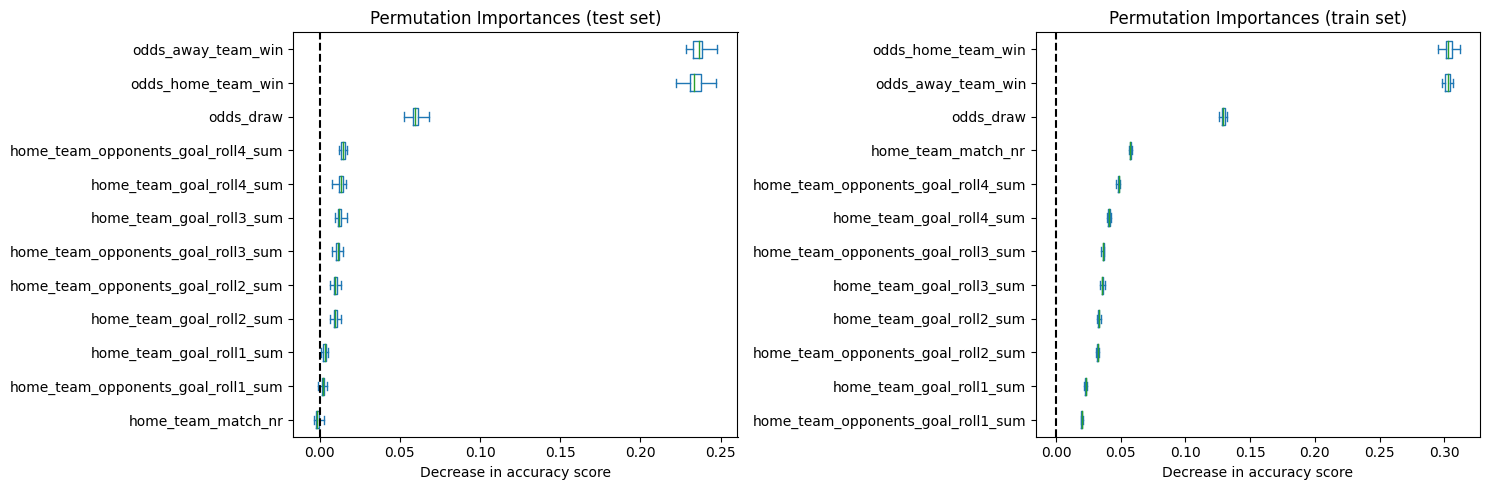

In [15]:
#calculate permutation importance for test data 
result_test = permutation_importance(
    model, X_val, y_val, n_repeats=20, random_state=42, n_jobs=2
)

sorted_importances_idx_test = result_test.importances_mean.argsort()
importances_test = pd.DataFrame(
    result_test.importances[sorted_importances_idx_test].T,
    columns=X.columns[sorted_importances_idx_test],
)

#calculate permutation importance for training data 
result_train = permutation_importance(
    model, X_train, y_train, n_repeats=20, random_state=42, n_jobs=2
)

sorted_importances_idx_train = result_train.importances_mean.argsort()
importances_train = pd.DataFrame(
    result_train.importances[sorted_importances_idx_train].T,
    columns=X.columns[sorted_importances_idx_train],
)

f, axs = plt.subplots(1,2,figsize=(15,5))

importances_test.plot.box(vert=False, whis=10, ax = axs[0])
axs[0].set_title("Permutation Importances (test set)")
axs[0].axvline(x=0, color="k", linestyle="--")
axs[0].set_xlabel("Decrease in accuracy score")
axs[0].figure.tight_layout()

importances_train.plot.box(vert=False, whis=10, ax = axs[1])
axs[1].set_title("Permutation Importances (train set)")
axs[1].axvline(x=0, color="k", linestyle="--")
axs[1].set_xlabel("Decrease in accuracy score")
axs[1].figure.tight_layout()